In [1]:
#!/usr/bin/env python3
"""
(Repaired 4/11/2023 version of SOCI_assign_c2v_FY2022_c.ipynb)

Read MOLPRO SO-CI output file that includes option MATEL=1
Assign SO states: Omega and dominant LS term
Assign parity to Omega=0 states based upon irreps in SO-CI
KKI
"""
import re, sys, copy
import numpy as np
import pandas as pd
from collections import Counter
from pprint import pprint
import matplotlib.pyplot as plt
sys.path.insert(0, '../atomic_SOC')
import molpro_subs as mpr
import chem_subs as chem

pd.set_option('display.width', 1000)
#fdir = r'C:\Users\irikura\OneDrive - NIST\Karl\PtH_anion\hybrid_PEC\\'
#fsoc = 'acqz_soc2011_6S5T_scan3.pro'  # scan of bond length
#fsoc = fdir + fsoc
fsoc = 'acqz_soc2011_6S5T_scan.pro'  # scan of bond length
fsoc = '../UMemphis/1_test.pro'

In [2]:
PG = mpr.read_point_group(fsoc)
if PG != 'C2v':
    print('Your calculation is in point group', PG)
crd, lineno_crd = mpr.read_coordinates(fsoc, linenum=True)
# convert list of coordinates to list of diatomic bond lengths
rlist = []
for df in crd:
    G = chem.Geometry(df, intype='DataFrame', units='bohr')
    G.toAngstrom()
    rlist.append(np.round(G.distance(0, 1), 6))  # round the bond length to 6 digits
#caslist, lineno_cas = mpr.readMULTI(fsoc, PG=PG, linenum=True)  # probably only one per geometry
#cilist, lineno_ci = mpr.readMRCI(fsoc, linenum=True)   # probably many per geometry
#soE, lineno_so = mpr.readSOenergy(fsoc, linenum=True)  # only one per geometry
#dimen = [len(so.results) for so in soE]  # dimension of each SO-CI 
#somatbuf, lineno_somat = mpr.readSOmatrixBlocks(fsoc)

TypeError: object of type 'builtin_function_or_method' has no len()

Found 201 geometries with 11 CASSCF energies each
Checking for non-integer values of Lz**2...all OK.


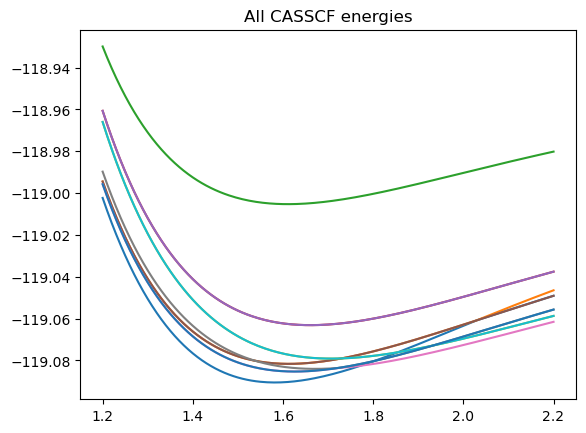

In [3]:
# Assuming my usual output of "Energies and Lz**2 values", check for 
#   non-integers and for changes across the bond-length scan
rx_nergies = re.compile(' Energies and Lz')
ECAS = [] # list of lists
Lzsq = [] # list of lists
inblock = False
Rbad = np.inf  # don't use data with R >= Rbad
with open (fsoc, 'r') as F:
    for line in F:
        if inblock:
            words = line.split()
            if len(words) > 2:
                inblock = False
                # save to the bigger lists
                ECAS.append(en)
                Lzsq.append(lz)
            if len(words) == 2:
                try:
                    e = float(words[0])
                    l = float(words[1].replace('D', 'E'))
                except:
                    continue
                # add to lists
                en.append(e)
                lz.append(l)
        if rx_nergies.match(line):
            inblock = True
            en = []
            lz = []

ECAS = np.array(ECAS)
Lzsq = np.array(Lzsq)
Lzsq = np.abs(Lzsq)  # cleanup any -0.0 values
print('Found {:d} geometries with {:d} CASSCF energies each'.format(*ECAS.shape))
ngeom = len(rlist)
print('Checking for non-integer values of Lz**2...', end='')
nonintLz = False
dif = Lzsq - Lzsq.astype(int)
idx = np.nonzero(dif)
if len(idx[0]):
    nonintLz = True
    Rbad = rlist[idx[0].min()]
    for i, j in zip(idx[0], idx[1]):
        print(f'\n   i = {i}, R = {rlist[i]}:', Lzsq[i,j], end='')
if not nonintLz:
    print('all OK.')
    # change type to int
    Lzsq = np.rint(Lzsq).astype(int)
# remove possible failed final geometry
nbad = len(rlist) - ECAS.shape[0]
if nbad:
    print(f'**Failure for {nbad} geometries; truncating rlist')
    rlist = rlist[:-nbad]
# plot just to check continuity
for i in range(ECAS.shape[1]):
    plt.plot(rlist, ECAS[:, i])
plt.title('All CASSCF energies')
#plt.ylim(top=-118.9)
plt.show()

In [5]:
def cas_sigma_parity_check(data_sets):
    # check for sigma parity not matching the expected C2v irrep ('-': 4 and '+': 1)
    # return nothing
    # be silent if no discrepancy is detected
    for j, c in enumerate(data_sets['cas']):
        for i, row in c.results.iterrows():
            lbl = row['Term']
            if 'Σ' in lbl:
                k = lbl.index('Σ')
                # look at the following character
                par = lbl[k+1]
                irr = row['Irrep']
                if ((par == '+') and (irr != 1)) or ((par == '-') and (irr != 4)):
                    print(f'*** Label = {lbl} but irrep = {irr} for row {i} of dataset {j}:')
                    print(row)
    return

In [6]:
# This takes a while if the scan has lots of points
# This always throws warnings about number of basis states (it gets corrected automatically)
data_sets = mpr.collect_corresponding_SOCI_results(fsoc)
cas_sigma_parity_check(data_sets)
ngeom = len(data_sets['R'])

*** Warning: "NO #1.1 is active and doubly occupied" in natorb_info()
*** Warning: "NO #1.1 is active and doubly occupied" in natorb_info()
*** Warning: "NO #1.1 is active and doubly occupied" in natorb_info()
*** Warning: "NO #1.1 is active and doubly occupied" in natorb_info()
*** Warning: "NO #1.1 is active and doubly occupied" in natorb_info()
*** Warning: "NO #1.1 is active and doubly occupied" in natorb_info()
*** Warning: "NO #1.1 is active and doubly occupied" in natorb_info()
*** Warning: "NO #1.1 is active and doubly occupied" in natorb_info()
*** Warning: "NO #1.1 is active and doubly occupied" in natorb_info()
*** Warning: "NO #1.1 is active and doubly occupied" in natorb_info()
*** Warning: "NO #1.1 is active and doubly occupied" in natorb_info()
*** Warning: "NO #1.1 is active and doubly occupied" in natorb_info()
*** Warning: "NO #1.1 is active and doubly occupied" in natorb_info()
*** Warning: "NO #1.1 is active and doubly occupied" in natorb_info()
*** Warning: "NO #1.

*** Warning: "21 SO states but only 16 unique basis states" in parse_SOmatrix()
	---correcting SO basis labels
*** Warning: "21 SO states but only 16 unique basis states" in parse_SOmatrix()
	---correcting SO basis labels
*** Warning: "21 SO states but only 16 unique basis states" in parse_SOmatrix()
	---correcting SO basis labels
*** Warning: "21 SO states but only 16 unique basis states" in parse_SOmatrix()
	---correcting SO basis labels
*** Warning: "21 SO states but only 16 unique basis states" in parse_SOmatrix()
	---correcting SO basis labels
*** Warning: "21 SO states but only 16 unique basis states" in parse_SOmatrix()
	---correcting SO basis labels
*** Warning: "21 SO states but only 16 unique basis states" in parse_SOmatrix()
	---correcting SO basis labels
*** Warning: "21 SO states but only 16 unique basis states" in parse_SOmatrix()
	---correcting SO basis labels
*** Warning: "21 SO states but only 16 unique basis states" in parse_SOmatrix()
	---correcting SO basis labels
*

*** Warning: "21 SO states but only 16 unique basis states" in parse_SOmatrix()
	---correcting SO basis labels
*** Warning: "21 SO states but only 16 unique basis states" in parse_SOmatrix()
	---correcting SO basis labels
*** Warning: "21 SO states but only 16 unique basis states" in parse_SOmatrix()
	---correcting SO basis labels
*** Warning: "21 SO states but only 16 unique basis states" in parse_SOmatrix()
	---correcting SO basis labels
*** Warning: "21 SO states but only 16 unique basis states" in parse_SOmatrix()
	---correcting SO basis labels
*** Warning: "21 SO states but only 16 unique basis states" in parse_SOmatrix()
	---correcting SO basis labels
*** Warning: "21 SO states but only 16 unique basis states" in parse_SOmatrix()
	---correcting SO basis labels
*** Warning: "21 SO states but only 16 unique basis states" in parse_SOmatrix()
	---correcting SO basis labels
*** Warning: "21 SO states but only 16 unique basis states" in parse_SOmatrix()
	---correcting SO basis labels
*

*** Warning: "21 SO states but only 16 unique basis states" in parse_SOmatrix()
	---correcting SO basis labels
*** Warning: "21 SO states but only 16 unique basis states" in parse_SOmatrix()
	---correcting SO basis labels
*** Warning: "21 SO states but only 16 unique basis states" in parse_SOmatrix()
	---correcting SO basis labels
*** Warning: "21 SO states but only 16 unique basis states" in parse_SOmatrix()
	---correcting SO basis labels
*** Warning: "21 SO states but only 16 unique basis states" in parse_SOmatrix()
	---correcting SO basis labels
*** Warning: "21 SO states but only 16 unique basis states" in parse_SOmatrix()
	---correcting SO basis labels
*** Warning: "21 SO states but only 16 unique basis states" in parse_SOmatrix()
	---correcting SO basis labels
*** Warning: "21 SO states but only 16 unique basis states" in parse_SOmatrix()
	---correcting SO basis labels
*** Warning: "21 SO states but only 16 unique basis states" in parse_SOmatrix()
	---correcting SO basis labels
*

In [7]:
print('{:d} geometries'.format(len(rlist)))
dfg = data_sets['cas'][0].results.groupby('Spin')
for spin, g in dfg:
    n = len(g)
    print(f'   {n} {spin}s')
    if spin == 'Doublet':
        ndoub = n

201 geometries
   6 Singlets
   5 Triplets


In [8]:
# check for changes in Lz**2 values
print('Checking for changes in Lz**2 values...')
lzinit = lznext = Counter(Lzsq[0, :])
print('\tInitial:  ', end='\t')
pprint(dict(lzinit))
idif = []  # indices with different Lz**2 from initial geometry
for i in range(ngeom):
    lzcount = Counter(Lzsq[i, :])
    if (lzcount != lzinit) and (lzcount != lznext):
        # different from both
        print(f'\tR = {rlist[i]}  ', end='\t')
        pprint(dict(lzcount))
        lznext = lzcount
    if (lzcount != lzinit):
        idif.append(i)
if len(idif):
    i = min(idif)
    Rbad = min(Rbad, rlist[i])
# Rbad == inf is ideal
print(f'Rbad = {Rbad}')

Checking for changes in Lz**2 values...
	Initial:  	{0: 3, 1: 4, 4: 4}
Rbad = inf


In [9]:
# Re-diagonalize the SO matrices, check consistency of results
data_sets['eigvals'] = []
data_sets['eigvecsq'] = []
for i in range(ngeom):
    vals, vecsq = mpr.get_SOeigs(data_sets['somat'][i])
    data_sets['eigvals'].append(vals)
    data_sets['eigvecsq'].append(vecsq)
    maxdiff = mpr.compare_MOLPRO_SOvals(data_sets['soci'][i].energies.Eshift, vals, silent=True)
    if abs(maxdiff) > 0.5:
        # largest difference is more than 0.5 cm-1; print comparison
        mpr.compare_MOLPRO_SOvals(data_sets['soci'][i].energies.Eshift, vals, silent=False)
    else:
        print('Biggest eigenvalue diff for geom #{:d} (vs. MOLPRO) is {:.2f} cm-1'.format(i, maxdiff))

Biggest eigenvalue diff for geom #0 (vs. MOLPRO) is -0.01 cm-1
Biggest eigenvalue diff for geom #1 (vs. MOLPRO) is -0.01 cm-1
Biggest eigenvalue diff for geom #2 (vs. MOLPRO) is 0.01 cm-1
Biggest eigenvalue diff for geom #3 (vs. MOLPRO) is 0.01 cm-1
Biggest eigenvalue diff for geom #4 (vs. MOLPRO) is -0.01 cm-1
Biggest eigenvalue diff for geom #5 (vs. MOLPRO) is -0.01 cm-1
Biggest eigenvalue diff for geom #6 (vs. MOLPRO) is -0.01 cm-1
Biggest eigenvalue diff for geom #7 (vs. MOLPRO) is -0.01 cm-1
Biggest eigenvalue diff for geom #8 (vs. MOLPRO) is 0.01 cm-1
Biggest eigenvalue diff for geom #9 (vs. MOLPRO) is 0.01 cm-1
Biggest eigenvalue diff for geom #10 (vs. MOLPRO) is 0.02 cm-1
Biggest eigenvalue diff for geom #11 (vs. MOLPRO) is -0.01 cm-1
Biggest eigenvalue diff for geom #12 (vs. MOLPRO) is -0.01 cm-1
Biggest eigenvalue diff for geom #13 (vs. MOLPRO) is -0.01 cm-1
Biggest eigenvalue diff for geom #14 (vs. MOLPRO) is -0.01 cm-1
Biggest eigenvalue diff for geom #15 (vs. MOLPRO) is 0.

In [10]:
csq_thresh = 5.e-3 # SO basis state must contribute at least this much to count
dfdups = []
for i in range(ngeom):
    print(f'>>> i = {i}, R = {rlist[i]}')
    mrci = data_sets['mrci'][i]
    SObasis = data_sets['sobas'][i]
    vals = data_sets['eigvals'][i]
    vecsq = data_sets['eigvecsq'][i]
    soci = data_sets['soci'][i]
    df, ok = mpr.SO_assign_omega(mrci, SObasis, soci, vecsq, csq_thresh, silent=False, debug=False)
    if not ok:
        print('*** PROBLEM ASSIGNING OMEGA VALUES ***')
    print('Results derived from MOLPRO file {:s}'.format(fsoc))
    display(df)
    dfdups.append(df)

>>> i = 0, R = 1.2
Target omega counts: {0: 5, 1: 8, 2: 6, 3: 2}
Results derived from MOLPRO file acqz_soc2011_6S5T_scan.pro


,E,cm-1,Ω,term,wt,label,Nr,exc
0,-119.791474,-445.98,0.0,1Σ+,0.973489,1Σ+_0+,1,0.00
1,-119.771845,3861.92,0.0,1Σ+,0.996486,1Σ+_0+,2,4307.90
2,-119.769440,4389.92,3.0,3Δ,0.500111,3Δ_3,12,4835.90
3,-119.769440,4389.92,3.0,3Δ,0.500111,3Δ_3,7,4835.90
4,-119.768932,4501.22,2.0,3Δ,0.519642,3Δ_2,17,4947.20
5,-119.768932,4501.27,2.0,3Δ,0.519417,3Δ_2,3,4947.25
6,-119.755821,7378.78,0.0,3Σ+,0.915771,3Σ+_0-,18,7824.76
7,-119.755694,7406.69,1.0,3Σ+,0.917422,3Σ+_1,8,7852.67
8,-119.755694,7406.69,1.0,3Σ+,0.917422,3Σ+_1,13,7852.67
9,-119.750336,8582.66,2.0,1Δ,0.278813,1Δ_2,4,9028.64


>>> i = 1, R = 1.205
Target omega counts: {0: 5, 1: 8, 2: 6, 3: 2}
Results derived from MOLPRO file acqz_soc2011_6S5T_scan.pro


,E,cm-1,Ω,term,wt,label,Nr,exc
0,-119.794423,-454.15,0.0,1Σ+,0.972924,1Σ+_0+,1,0.00
1,-119.774475,3923.86,0.0,1Σ+,0.996456,1Σ+_0+,2,4378.01
2,-119.772423,4374.30,3.0,3Δ,0.500112,3Δ_3,12,4828.45
3,-119.772423,4374.30,3.0,3Δ,0.500112,3Δ_3,7,4828.45
4,-119.771908,4487.40,2.0,3Δ,0.520028,3Δ_2,17,4941.55
5,-119.771907,4487.46,2.0,3Δ,0.519800,3Δ_2,3,4941.61
6,-119.758809,7362.19,0.0,3Σ+,0.913699,3Σ+_0-,18,7816.34
7,-119.758677,7391.07,1.0,3Σ+,0.915104,3Σ+_1,8,7845.22
8,-119.758677,7391.07,1.0,3Σ+,0.915104,3Σ+_1,13,7845.22
9,-119.753466,8534.85,2.0,1Δ,0.276800,1Δ_2,4,8989.00


>>> i = 2, R = 1.21
Target omega counts: {0: 5, 1: 8, 2: 6, 3: 2}
Results derived from MOLPRO file acqz_soc2011_6S5T_scan.pro


,E,cm-1,Ω,term,wt,label,Nr,exc
0,-119.797290,-462.41,0.0,1Σ+,0.972349,1Σ+_0+,1,0.00
1,-119.777022,3985.80,0.0,1Σ+,0.996424,1Σ+_0+,2,4448.21
2,-119.775324,4358.46,3.0,3Δ,0.500114,3Δ_3,12,4820.87
3,-119.775324,4358.46,3.0,3Δ,0.500114,3Δ_3,7,4820.87
4,-119.774801,4473.38,2.0,3Δ,0.520419,3Δ_2,17,4935.79
5,-119.774800,4473.44,2.0,3Δ,0.520187,3Δ_2,3,4935.85
6,-119.761716,7345.21,0.0,3Σ+,0.911589,3Σ+_0-,18,7807.62
7,-119.761580,7375.06,1.0,3Σ+,0.912699,3Σ+_1,8,7837.47
8,-119.761580,7375.06,1.0,3Σ+,0.912699,3Σ+_1,13,7837.47
9,-119.756515,8486.62,2.0,1Δ,0.274792,1Δ_2,4,8949.03


>>> i = 3, R = 1.215
Target omega counts: {0: 5, 1: 8, 2: 6, 3: 2}
Results derived from MOLPRO file acqz_soc2011_6S5T_scan.pro


,E,cm-1,Ω,term,wt,label,Nr,exc
0,-119.800076,-470.75,0.0,1Σ+,0.971764,1Σ+_0+,1,0.00
1,-119.779489,4047.68,0.0,1Σ+,0.996391,1Σ+_0+,2,4518.43
2,-119.778146,4342.38,3.0,3Δ,0.500115,3Δ_3,12,4813.13
3,-119.778146,4342.38,3.0,3Δ,0.500115,3Δ_3,7,4813.13
4,-119.777614,4459.14,2.0,3Δ,0.520815,3Δ_2,17,4929.89
5,-119.777614,4459.20,2.0,3Δ,0.520581,3Δ_2,3,4929.95
6,-119.764543,7327.80,0.0,3Σ+,0.909440,3Σ+_0-,18,7798.55
7,-119.764403,7358.63,1.0,3Σ+,0.910199,3Σ+_1,8,7829.38
8,-119.764403,7358.63,1.0,3Σ+,0.910199,3Σ+_1,13,7829.38
9,-119.759485,8437.95,2.0,1Δ,0.272794,1Δ_2,4,8908.70


>>> i = 4, R = 1.22
Target omega counts: {0: 5, 1: 8, 2: 6, 3: 2}
Results derived from MOLPRO file acqz_soc2011_6S5T_scan.pro


,E,cm-1,Ω,term,wt,label,Nr,exc
0,-119.802784,-479.18,0.0,1Σ+,0.971169,1Σ+_0+,1,0.00
1,-119.781876,4109.47,0.0,1Σ+,0.996356,1Σ+_0+,2,4588.65
2,-119.780890,4326.06,3.0,3Δ,0.500115,3Δ_3,12,4805.24
3,-119.780890,4326.06,3.0,3Δ,0.500115,3Δ_3,7,4805.24
4,-119.780349,4444.66,2.0,3Δ,0.521217,3Δ_2,17,4923.84
5,-119.780349,4444.72,2.0,3Δ,0.520982,3Δ_2,3,4923.90
6,-119.767294,7309.94,0.0,3Σ+,0.907252,3Σ+_0-,18,7789.12
7,-119.767149,7341.76,1.0,3Σ+,0.907598,3Σ+_1,8,7820.94
8,-119.767149,7341.76,1.0,3Σ+,0.907598,3Σ+_1,13,7820.94
9,-119.762378,8388.84,2.0,1Δ,0.270806,1Δ_2,4,8868.02


>>> i = 5, R = 1.225
Target omega counts: {0: 5, 1: 8, 2: 6, 3: 2}
Results derived from MOLPRO file acqz_soc2011_6S5T_scan.pro


,E,cm-1,Ω,term,wt,label,Nr,exc
0,-119.805414,-487.69,0.0,1Σ+,0.970564,1Σ+_0+,1,0.00
1,-119.784187,4171.10,0.0,1Σ+,0.996320,1Σ+_0+,2,4658.79
2,-119.783557,4309.47,3.0,3Δ,0.500117,3Δ_3,12,4797.16
3,-119.783557,4309.47,3.0,3Δ,0.500117,3Δ_3,7,4797.16
4,-119.783008,4429.93,2.0,3Δ,0.521626,3Δ_2,17,4917.62
5,-119.783008,4429.99,2.0,3Δ,0.521385,3Δ_2,3,4917.68
6,-119.769969,7291.61,0.0,3Σ+,0.905025,3Σ+_0-,18,7779.30
7,-119.769820,7324.40,1.0,3Σ+,0.904886,3Σ+_1,8,7812.09
8,-119.769820,7324.40,1.0,3Σ+,0.904886,3Σ+_1,13,7812.09
9,-119.765196,8339.27,2.0,1Δ,0.268822,1Δ_2,4,8826.96


>>> i = 6, R = 1.23
Target omega counts: {0: 5, 1: 8, 2: 6, 3: 2}
Results derived from MOLPRO file acqz_soc2011_6S5T_scan.pro


,E,cm-1,Ω,term,wt,label,Nr,exc
0,-119.807970,-496.29,0.0,1Σ+,0.969949,1Σ+_0+,1,0.00
1,-119.786424,4232.52,0.0,1Σ+,0.996283,1Σ+_0+,2,4728.81
2,-119.786150,4292.60,3.0,3Δ,0.500118,3Δ_3,12,4788.89
3,-119.786150,4292.60,3.0,3Δ,0.500118,3Δ_3,7,4788.89
4,-119.785593,4414.92,2.0,3Δ,0.522041,3Δ_2,17,4911.21
5,-119.785592,4414.99,2.0,3Δ,0.521798,3Δ_2,3,4911.28
6,-119.772571,7272.79,0.0,3Σ+,0.902759,3Σ+_0-,18,7769.08
7,-119.772417,7306.54,1.0,3Σ+,0.902057,3Σ+_1,8,7802.83
8,-119.772417,7306.54,1.0,3Σ+,0.902057,3Σ+_1,13,7802.83
9,-119.767940,8289.24,2.0,1Δ,0.266854,1Δ_2,4,8785.53


>>> i = 7, R = 1.235
Target omega counts: {0: 5, 1: 8, 2: 6, 3: 2}
Results derived from MOLPRO file acqz_soc2011_6S5T_scan.pro


,E,cm-1,Ω,term,wt,label,Nr,exc
0,-119.810451,-504.98,0.0,1Σ+,0.969324,1Σ+_0+,1,0.00
1,-119.788670,4275.43,3.0,3Δ,0.500118,3Δ_3,12,4780.41
2,-119.788670,4275.43,3.0,3Δ,0.500118,3Δ_3,7,4780.41
3,-119.788587,4293.70,0.0,1Σ+,0.996244,1Σ+_0+,2,4798.68
4,-119.788104,4399.63,2.0,3Δ,0.522460,3Δ_2,17,4904.61
5,-119.788104,4399.70,2.0,3Δ,0.522216,3Δ_2,3,4904.68
6,-119.775101,7253.44,0.0,3Σ+,0.900455,3Σ+_0-,18,7758.42
7,-119.774943,7288.15,1.0,3Σ+,0.899097,3Σ+_1,8,7793.13
8,-119.774943,7288.15,1.0,3Σ+,0.899097,3Σ+_1,13,7793.13
9,-119.770612,8238.74,2.0,1Δ,0.264897,1Δ_2,4,8743.72


>>> i = 8, R = 1.24
Target omega counts: {0: 5, 1: 8, 2: 6, 3: 2}
Results derived from MOLPRO file acqz_soc2011_6S5T_scan.pro


,E,cm-1,Ω,term,wt,label,Nr,exc
0,-119.812861,-513.75,0.0,1Σ+,0.968688,1Σ+_0+,1,0.00
1,-119.791120,4257.95,3.0,3Δ,0.500121,3Δ_3,12,4771.70
2,-119.791120,4257.95,3.0,3Δ,0.500121,3Δ_3,7,4771.70
3,-119.790679,4354.57,0.0,1Σ+,0.996204,1Σ+_0+,2,4868.32
4,-119.790545,4384.05,2.0,3Δ,0.522887,3Δ_2,17,4897.80
5,-119.790545,4384.11,2.0,3Δ,0.522638,3Δ_2,3,4897.86
6,-119.777562,7233.55,0.0,3Σ+,0.898112,3Σ+_0-,18,7747.30
7,-119.777399,7269.19,1.0,3Σ+,0.896001,3Σ+_1,8,7782.94
8,-119.777399,7269.19,1.0,3Σ+,0.896001,3Σ+_1,13,7782.94
9,-119.773214,8187.76,2.0,1Δ,0.262951,1Δ_2,4,8701.51


>>> i = 9, R = 1.245
Target omega counts: {0: 5, 1: 8, 2: 6, 3: 2}
Results derived from MOLPRO file acqz_soc2011_6S5T_scan.pro


,E,cm-1,Ω,term,wt,label,Nr,exc
0,-119.815200,-522.61,0.0,1Σ+,0.968041,1Σ+_0+,1,0.00
1,-119.793500,4240.15,3.0,3Δ,0.500121,3Δ_3,12,4762.76
2,-119.793500,4240.15,3.0,3Δ,0.500121,3Δ_3,7,4762.76
3,-119.792916,4368.14,2.0,3Δ,0.523318,3Δ_2,17,4890.75
4,-119.792916,4368.21,2.0,3Δ,0.523068,3Δ_2,2,4890.82
5,-119.792702,4415.10,0.0,1Σ+,0.996163,1Σ+_0+,3,4937.71
6,-119.779954,7213.10,0.0,3Σ+,0.895731,3Σ+_0-,18,7735.71
7,-119.779787,7249.65,1.0,3Σ+,0.892752,3Σ+_1,8,7772.26
8,-119.779787,7249.65,1.0,3Σ+,0.892752,3Σ+_1,13,7772.26
9,-119.775747,8136.29,2.0,1Δ,0.261020,1Δ_2,4,8658.90


>>> i = 10, R = 1.25
Target omega counts: {0: 5, 1: 8, 2: 6, 3: 2}
Results derived from MOLPRO file acqz_soc2011_6S5T_scan.pro


,E,cm-1,Ω,term,wt,label,Nr,exc
0,-119.817471,-531.56,0.0,1Σ+,0.967385,1Σ+_0+,1,0.00
1,-119.795812,4222.01,3.0,3Δ,0.500122,3Δ_3,12,4753.57
2,-119.795812,4222.01,3.0,3Δ,0.500122,3Δ_3,7,4753.57
3,-119.795220,4351.91,2.0,3Δ,0.523755,3Δ_2,17,4883.47
4,-119.795219,4351.99,2.0,3Δ,0.523503,3Δ_2,2,4883.55
5,-119.794658,4475.23,0.0,1Σ+,0.996119,1Σ+_0+,3,5006.79
6,-119.782279,7192.05,0.0,3Σ+,0.893312,3Σ+_0-,18,7723.61
7,-119.782109,7229.49,1.0,3Σ+,0.889341,3Σ+_1,8,7761.05
8,-119.782109,7229.49,1.0,3Σ+,0.889341,3Σ+_1,13,7761.05
9,-119.778214,8084.33,2.0,1Δ,0.259101,1Δ_2,4,8615.89


>>> i = 11, R = 1.255
Target omega counts: {0: 5, 1: 8, 2: 6, 3: 2}
Results derived from MOLPRO file acqz_soc2011_6S5T_scan.pro


,E,cm-1,Ω,term,wt,label,Nr,exc
0,-119.819673,-540.60,0.0,1Σ+,0.966717,1Σ+_0+,1,0.00
1,-119.798058,4203.51,3.0,3Δ,0.500124,3Δ_3,12,4744.11
2,-119.798058,4203.51,3.0,3Δ,0.500124,3Δ_3,7,4744.11
3,-119.797457,4335.34,2.0,3Δ,0.524199,3Δ_2,17,4875.94
4,-119.797457,4335.41,2.0,3Δ,0.523944,3Δ_2,2,4876.01
5,-119.796548,4534.91,0.0,1Σ+,0.996075,1Σ+_0+,3,5075.51
6,-119.784539,7170.40,0.0,3Σ+,0.890856,3Σ+_0-,18,7711.00
7,-119.784365,7208.67,1.0,3Σ+,0.885753,3Σ+_1,8,7749.27
8,-119.784365,7208.67,1.0,3Σ+,0.885753,3Σ+_1,13,7749.27
9,-119.780614,8031.88,2.0,3Π,0.261059,3Π_2,4,8572.48


>>> i = 12, R = 1.26
Target omega counts: {0: 5, 1: 8, 2: 6, 3: 2}
Results derived from MOLPRO file acqz_soc2011_6S5T_scan.pro


,E,cm-1,Ω,term,wt,label,Nr,exc
0,-119.821810,-549.72,0.0,1Σ+,0.966039,1Σ+_0+,1,0.00
1,-119.800239,4184.66,3.0,3Δ,0.500124,3Δ_3,12,4734.38
2,-119.800239,4184.66,3.0,3Δ,0.500124,3Δ_3,7,4734.38
3,-119.799629,4318.41,2.0,3Δ,0.524649,3Δ_2,17,4868.13
4,-119.799629,4318.49,2.0,3Δ,0.524389,3Δ_2,2,4868.21
5,-119.798373,4594.10,0.0,1Σ+,0.996029,1Σ+_0+,3,5143.82
6,-119.786736,7148.12,0.0,3Σ+,0.888363,3Σ+_0-,18,7697.84
7,-119.786558,7187.19,1.0,3Σ+,0.881973,3Σ+_1,8,7736.91
8,-119.786558,7187.19,1.0,3Σ+,0.881973,3Σ+_1,13,7736.91
9,-119.782951,7978.92,2.0,3Π,0.263239,3Π_2,4,8528.64


>>> i = 13, R = 1.265
Target omega counts: {0: 5, 1: 8, 2: 6, 3: 2}
Results derived from MOLPRO file acqz_soc2011_6S5T_scan.pro


,E,cm-1,Ω,term,wt,label,Nr,exc
0,-119.823883,-558.93,0.0,1Σ+,0.965349,1Σ+_0+,1,0.00
1,-119.802357,4165.42,3.0,3Δ,0.500127,3Δ_3,12,4724.35
2,-119.802357,4165.42,3.0,3Δ,0.500127,3Δ_3,7,4724.35
3,-119.801739,4301.11,2.0,3Δ,0.525105,3Δ_2,17,4860.04
4,-119.801738,4301.19,2.0,3Δ,0.524841,3Δ_2,2,4860.12
5,-119.800137,4652.75,0.0,1Σ+,0.995981,1Σ+_0+,3,5211.68
6,-119.788871,7125.18,0.0,3Σ+,0.885835,3Σ+_0-,18,7684.11
7,-119.788690,7165.00,1.0,3Σ+,0.877985,3Σ+_1,8,7723.93
8,-119.788690,7165.00,1.0,3Σ+,0.877985,3Σ+_1,13,7723.93
9,-119.785225,7925.46,2.0,3Π,0.265407,3Π_2,4,8484.39


>>> i = 14, R = 1.27
Target omega counts: {0: 5, 1: 8, 2: 6, 3: 2}
Results derived from MOLPRO file acqz_soc2011_6S5T_scan.pro


,E,cm-1,Ω,term,wt,label,Nr,exc
0,-119.825892,-568.23,0.0,1Σ+,0.964648,1Σ+_0+,1,0.00
1,-119.804413,4145.80,3.0,3Δ,0.500128,3Δ_3,12,4714.03
2,-119.804413,4145.80,3.0,3Δ,0.500128,3Δ_3,7,4714.03
3,-119.803786,4283.43,2.0,3Δ,0.525568,3Δ_2,17,4851.66
4,-119.803786,4283.51,2.0,3Δ,0.525301,3Δ_2,2,4851.74
5,-119.801839,4710.82,0.0,1Σ+,0.995932,1Σ+_0+,3,5279.05
6,-119.790946,7101.58,0.0,3Σ+,0.883270,3Σ+_0-,18,7669.81
7,-119.790761,7142.07,1.0,3Σ+,0.873771,3Σ+_1,8,7710.30
8,-119.790761,7142.07,1.0,3Σ+,0.873771,3Σ+_1,13,7710.30
9,-119.787438,7871.48,2.0,3Π,0.267561,3Π_2,4,8439.71


>>> i = 15, R = 1.275
Target omega counts: {0: 5, 1: 8, 2: 6, 3: 2}
Results derived from MOLPRO file acqz_soc2011_6S5T_scan.pro


,E,cm-1,Ω,term,wt,label,Nr,exc
0,-119.827840,-577.61,0.0,1Σ+,0.963936,1Σ+_0+,1,0.00
1,-119.806410,4125.77,3.0,3Δ,0.500128,3Δ_3,12,4703.38
2,-119.806410,4125.77,3.0,3Δ,0.500128,3Δ_3,7,4703.38
3,-119.805774,4265.36,2.0,3Δ,0.526034,3Δ_2,17,4842.97
4,-119.805773,4265.44,2.0,3Δ,0.525766,3Δ_2,2,4843.05
5,-119.803482,4768.27,0.0,1Σ+,0.995882,1Σ+_0+,3,5345.88
6,-119.792962,7077.29,0.0,3Σ+,0.880669,3Σ+_0-,18,7654.90
7,-119.792774,7118.39,1.0,3Σ+,0.869309,3Σ+_1,8,7696.00
8,-119.792774,7118.39,1.0,3Σ+,0.869309,3Σ+_1,13,7696.00
9,-119.789591,7817.00,2.0,3Π,0.269700,3Π_2,4,8394.61


>>> i = 16, R = 1.28
Target omega counts: {0: 5, 1: 8, 2: 6, 3: 2}
Results derived from MOLPRO file acqz_soc2011_6S5T_scan.pro


,E,cm-1,Ω,term,wt,label,Nr,exc
0,-119.829727,-587.09,0.0,1Σ+,0.963213,1Σ+_0+,1,0.00
1,-119.808347,4105.34,3.0,3Δ,0.500130,3Δ_3,12,4692.43
2,-119.808347,4105.34,3.0,3Δ,0.500129,3Δ_3,7,4692.43
3,-119.807702,4246.88,2.0,3Δ,0.526508,3Δ_2,17,4833.97
4,-119.807702,4246.96,2.0,3Δ,0.526236,3Δ_2,2,4834.05
5,-119.805068,4825.05,0.0,1Σ+,0.995830,1Σ+_0+,3,5412.14
6,-119.794920,7052.30,0.0,3Σ+,0.878035,3Σ+_0-,18,7639.39
7,-119.794730,7093.92,1.0,3Σ+,0.864585,3Σ+_1,8,7681.01
8,-119.794730,7093.92,1.0,3Σ+,0.864586,3Σ+_1,13,7681.01
9,-119.791686,7762.00,2.0,3Π,0.271825,3Π_2,4,8349.09


>>> i = 17, R = 1.285
Target omega counts: {0: 5, 1: 8, 2: 6, 3: 2}
Results derived from MOLPRO file acqz_soc2011_6S5T_scan.pro


,E,cm-1,Ω,term,wt,label,Nr,exc
0,-119.831555,-596.65,0.0,1Σ+,0.962478,1Σ+_0+,1,0.00
1,-119.810227,4084.48,3.0,3Δ,0.500131,3Δ_3,12,4681.13
2,-119.810227,4084.48,3.0,3Δ,0.500131,3Δ_3,7,4681.13
3,-119.809573,4227.98,2.0,3Δ,0.526987,3Δ_2,17,4824.63
4,-119.809572,4228.07,2.0,3Δ,0.526712,3Δ_2,2,4824.72
5,-119.806597,4881.12,0.0,1Σ+,0.995776,1Σ+_0+,3,5477.77
6,-119.796821,7026.58,0.0,3Σ+,0.875367,3Σ+_0-,18,7623.23
7,-119.796630,7068.63,1.0,3Σ+,0.859572,3Σ+_1,8,7665.28
8,-119.796630,7068.63,1.0,3Σ+,0.859572,3Σ+_1,13,7665.28
9,-119.793724,7706.48,2.0,3Π,0.273934,3Π_2,4,8303.13


>>> i = 18, R = 1.29
Target omega counts: {0: 5, 1: 8, 2: 6, 3: 2}
Results derived from MOLPRO file acqz_soc2011_6S5T_scan.pro


,E,cm-1,Ω,term,wt,label,Nr,exc
0,-119.833326,-606.30,0.0,1Σ+,0.961732,1Σ+_0+,1,0.00
1,-119.812050,4063.19,3.0,3Δ,0.500132,3Δ_3,12,4669.49
2,-119.812050,4063.19,3.0,3Δ,0.500131,3Δ_3,7,4669.49
3,-119.811387,4208.66,2.0,3Δ,0.527473,3Δ_2,17,4814.96
4,-119.811387,4208.75,2.0,3Δ,0.527196,3Δ_2,2,4815.05
5,-119.808071,4936.45,0.0,1Σ+,0.995721,1Σ+_0+,3,5542.75
6,-119.798668,7000.12,0.0,3Σ+,0.872667,3Σ+_0-,18,7606.42
7,-119.798475,7042.50,1.0,3Σ+,0.854249,3Σ+_1,8,7648.80
8,-119.798475,7042.50,1.0,3Σ+,0.854249,3Σ+_1,13,7648.80
9,-119.795705,7650.44,2.0,3Π,0.276026,3Π_2,4,8256.74


>>> i = 19, R = 1.295
Target omega counts: {0: 5, 1: 8, 2: 6, 3: 2}
Results derived from MOLPRO file acqz_soc2011_6S5T_scan.pro


,E,cm-1,Ω,term,wt,label,Nr,exc
0,-119.835040,-616.03,0.0,1Σ+,0.960974,1Σ+_0+,1,0.00
1,-119.813819,4041.46,3.0,3Δ,0.500133,3Δ_3,12,4657.49
2,-119.813819,4041.46,3.0,3Δ,0.500133,3Δ_3,7,4657.49
3,-119.813147,4188.89,2.0,3Δ,0.527963,3Δ_2,17,4804.92
4,-119.813146,4188.99,2.0,3Δ,0.527684,3Δ_2,2,4805.02
5,-119.809492,4990.99,0.0,1Σ+,0.995665,1Σ+_0+,3,5607.02
6,-119.800462,6972.91,0.0,3Σ+,0.869936,3Σ+_0-,18,7588.94
7,-119.800268,7015.49,1.0,3Σ+,0.848597,3Σ+_1,8,7631.52
8,-119.800268,7015.49,1.0,3Σ+,0.848597,3Σ+_1,13,7631.52
9,-119.797633,7593.89,2.0,3Π,0.278102,3Π_2,4,8209.92


>>> i = 20, R = 1.3
Target omega counts: {0: 5, 1: 8, 2: 6, 3: 2}
Results derived from MOLPRO file acqz_soc2011_6S5T_scan.pro


,E,cm-1,Ω,term,wt,label,Nr,exc
0,-119.836698,-625.86,0.0,1Σ+,0.960204,1Σ+_0+,1,0.00
1,-119.815534,4019.28,3.0,3Δ,0.500133,3Δ_3,12,4645.14
2,-119.815534,4019.28,3.0,3Δ,0.500133,3Δ_3,7,4645.14
3,-119.814853,4168.69,2.0,3Δ,0.528462,3Δ_2,17,4794.55
4,-119.814852,4168.78,2.0,3Δ,0.528178,3Δ_2,2,4794.64
5,-119.810861,5044.72,0.0,1Σ+,0.995606,1Σ+_0+,3,5670.58
6,-119.802203,6944.93,0.0,3Σ+,0.867173,3Σ+_0-,18,7570.79
7,-119.802009,6987.59,1.0,3Σ+,0.842582,3Σ+_1,8,7613.45
8,-119.802009,6987.59,1.0,3Σ+,0.842582,3Σ+_1,13,7613.45
9,-119.799506,7536.82,2.0,3Π,0.280159,3Π_2,4,8162.68


>>> i = 21, R = 1.305
Target omega counts: {0: 5, 1: 8, 2: 6, 3: 2}
Results derived from MOLPRO file acqz_soc2011_6S5T_scan.pro


,E,cm-1,Ω,term,wt,label,Nr,exc
0,-119.838303,-635.77,0.0,1Σ+,0.959422,1Σ+_0+,1,0.00
1,-119.817196,3996.64,3.0,3Δ,0.500135,3Δ_3,12,4632.41
2,-119.817196,3996.64,3.0,3Δ,0.500134,3Δ_3,7,4632.41
3,-119.816506,4148.02,2.0,3Δ,0.528967,3Δ_2,17,4783.79
4,-119.816506,4148.12,2.0,3Δ,0.528681,3Δ_2,2,4783.89
5,-119.812180,5097.59,0.0,1Σ+,0.995547,1Σ+_0+,3,5733.36
6,-119.803894,6916.17,0.0,3Σ+,0.864381,3Σ+_0-,18,7551.94
7,-119.803700,6958.77,1.0,3Σ+,0.836185,3Σ+_1,8,7594.54
8,-119.803700,6958.77,1.0,3Σ+,0.836185,3Σ+_1,13,7594.54
9,-119.801328,7479.24,2.0,3Π,0.282199,3Π_2,4,8115.01


>>> i = 22, R = 1.31
Target omega counts: {0: 5, 1: 8, 2: 6, 3: 2}
Results derived from MOLPRO file acqz_soc2011_6S5T_scan.pro


,E,cm-1,Ω,term,wt,label,Nr,exc
0,-119.839854,-645.77,0.0,1Σ+,0.958627,1Σ+_0+,1,0.00
1,-119.818807,3973.53,3.0,3Δ,0.500135,3Δ_3,12,4619.30
2,-119.818807,3973.53,3.0,3Δ,0.500135,3Δ_3,7,4619.30
3,-119.818109,4126.89,2.0,3Δ,0.529477,3Δ_2,17,4772.66
4,-119.818108,4126.99,2.0,3Δ,0.529186,3Δ_2,2,4772.76
5,-119.813449,5149.57,0.0,1Σ+,0.995486,1Σ+_0+,3,5795.34
6,-119.805534,6886.62,0.0,3Σ+,0.861561,3Σ+_0-,18,7532.39
7,-119.805341,6929.00,1.0,3Σ+,0.829382,3Σ+_1,8,7574.77
8,-119.805341,6929.00,1.0,3Σ+,0.829383,3Σ+_1,13,7574.77
9,-119.803099,7421.14,2.0,3Π,0.284220,3Π_2,4,8066.91


>>> i = 23, R = 1.315
Target omega counts: {0: 5, 1: 8, 2: 6, 3: 2}
Results derived from MOLPRO file acqz_soc2011_6S5T_scan.pro


,E,cm-1,Ω,term,wt,label,Nr,exc
0,-119.841354,-655.86,0.0,1Σ+,0.957821,1Σ+_0+,1,0.00
1,-119.820369,3949.96,3.0,3Δ,0.500137,3Δ_3,12,4605.82
2,-119.820369,3949.96,3.0,3Δ,0.500137,3Δ_3,7,4605.82
3,-119.819661,4105.30,2.0,3Δ,0.529992,3Δ_2,17,4761.16
4,-119.819660,4105.40,2.0,3Δ,0.529699,3Δ_2,2,4761.26
5,-119.814670,5200.63,0.0,1Σ+,0.995423,1Σ+_0+,3,5856.49
6,-119.807126,6856.26,0.0,3Σ+,0.858714,3Σ+_0-,18,7512.12
7,-119.806935,6898.25,1.0,3Σ+,0.822152,3Σ+_1,8,7554.11
8,-119.806935,6898.25,1.0,3Σ+,0.822152,3Σ+_1,13,7554.11
9,-119.804820,7362.54,2.0,3Π,0.286221,3Π_2,4,8018.40


>>> i = 24, R = 1.32
Target omega counts: {0: 5, 1: 8, 2: 6, 3: 2}
Results derived from MOLPRO file acqz_soc2011_6S5T_scan.pro


,E,cm-1,Ω,term,wt,label,Nr,exc
0,-119.842803,-666.04,0.0,1Σ+,0.957002,1Σ+_0+,1,0.00
1,-119.821881,3925.90,3.0,3Δ,0.500138,3Δ_3,12,4591.94
2,-119.821881,3925.90,3.0,3Δ,0.500138,3Δ_3,7,4591.94
3,-119.821164,4083.22,2.0,3Δ,0.530514,3Δ_2,17,4749.26
4,-119.821164,4083.33,2.0,3Δ,0.530217,3Δ_2,2,4749.37
5,-119.815844,5250.75,0.0,1Σ+,0.995359,1Σ+_0+,3,5916.79
6,-119.808671,6825.10,0.0,3Σ+,0.855841,3Σ+_0-,18,7491.14
7,-119.808482,6866.51,1.0,3Σ+,0.814473,3Σ+_1,8,7532.55
8,-119.808482,6866.51,1.0,3Σ+,0.814473,3Σ+_1,13,7532.55
9,-119.806492,7303.43,2.0,3Π,0.288203,3Π_2,4,7969.47


>>> i = 25, R = 1.325
Target omega counts: {0: 5, 1: 8, 2: 6, 3: 2}
Results derived from MOLPRO file acqz_soc2011_6S5T_scan.pro


,E,cm-1,Ω,term,wt,label,Nr,exc
0,-119.844203,-676.31,0.0,1Σ+,0.956171,1Σ+_0+,1,0.00
1,-119.823345,3901.36,3.0,3Δ,0.500139,3Δ_3,12,4577.67
2,-119.823345,3901.36,3.0,3Δ,0.500139,3Δ_3,7,4577.67
3,-119.822620,4060.66,2.0,3Δ,0.531042,3Δ_2,17,4736.97
4,-119.822619,4060.77,2.0,3Δ,0.530743,3Δ_2,2,4737.08
5,-119.816973,5299.89,0.0,1Σ+,0.995293,1Σ+_0+,3,5976.20
6,-119.810170,6793.11,0.0,3Σ+,0.852943,3Σ+_0-,18,7469.42
7,-119.809985,6833.75,1.0,3Σ+,0.806311,3Σ+_1,8,7510.06
8,-119.809985,6833.75,1.0,3Σ+,0.806311,3Σ+_1,13,7510.06
9,-119.808116,7243.81,2.0,3Π,0.290164,3Π_2,4,7920.12


>>> i = 26, R = 1.33
Target omega counts: {0: 5, 1: 8, 2: 6, 3: 2}
Results derived from MOLPRO file acqz_soc2011_6S5T_scan.pro


,E,cm-1,Ω,term,wt,label,Nr,exc
0,-119.845554,-686.66,0.0,1Σ+,0.955327,1Σ+_0+,1,0.00
1,-119.824763,3876.34,3.0,3Δ,0.500140,3Δ_3,12,4563.00
2,-119.824763,3876.34,3.0,3Δ,0.500140,3Δ_3,7,4563.00
3,-119.824028,4037.62,2.0,3Δ,0.531576,3Δ_2,17,4724.28
4,-119.824028,4037.73,2.0,3Δ,0.531273,3Δ_2,2,4724.39
5,-119.818058,5348.04,0.0,1Σ+,0.995226,1Σ+_0+,3,6034.70
6,-119.811623,6760.30,0.0,3Σ+,0.850023,3Σ+_0-,18,7446.96
7,-119.811442,6799.95,1.0,3Σ+,0.797664,3Σ+_1,8,7486.61
8,-119.811442,6799.95,1.0,3Σ+,0.797664,3Σ+_1,13,7486.61
9,-119.809694,7183.70,2.0,3Π,0.292105,3Π_2,4,7870.36


>>> i = 27, R = 1.335
Target omega counts: {0: 5, 1: 8, 2: 6, 3: 2}
Results derived from MOLPRO file acqz_soc2011_6S5T_scan.pro


,E,cm-1,Ω,term,wt,label,Nr,exc
0,-119.846858,-697.11,0.0,1Σ+,0.954470,1Σ+_0+,1,0.00
1,-119.826136,3850.82,3.0,3Δ,0.500140,3Δ_3,12,4547.93
2,-119.826136,3850.82,3.0,3Δ,0.500140,3Δ_3,7,4547.93
3,-119.825392,4014.08,2.0,3Δ,0.532117,3Δ_2,17,4711.19
4,-119.825391,4014.19,2.0,3Δ,0.531812,3Δ_2,2,4711.30
5,-119.819099,5395.17,0.0,1Σ+,0.995158,1Σ+_0+,3,6092.28
6,-119.813032,6726.66,0.0,3Σ+,0.847080,3Σ+_0-,18,7423.77
7,-119.812857,6765.09,1.0,3Σ+,0.788514,3Σ+_1,8,7462.20
8,-119.812857,6765.09,1.0,3Σ+,0.788513,3Σ+_1,13,7462.20
9,-119.811226,7123.10,2.0,3Π,0.294024,3Π_2,4,7820.21


>>> i = 28, R = 1.34
Target omega counts: {0: 5, 1: 8, 2: 6, 3: 2}
Results derived from MOLPRO file acqz_soc2011_6S5T_scan.pro


,E,cm-1,Ω,term,wt,label,Nr,exc
0,-119.848115,-707.64,0.0,1Σ+,0.953601,1Σ+_0+,1,0.00
1,-119.827463,3824.81,3.0,3Δ,0.500143,3Δ_3,12,4532.45
2,-119.827463,3824.81,3.0,3Δ,0.500143,3Δ_3,7,4532.45
3,-119.826711,3990.04,2.0,3Δ,0.532664,3Δ_2,17,4697.68
4,-119.826710,3990.16,2.0,3Δ,0.532354,3Δ_2,2,4697.80
5,-119.820098,5441.25,0.0,1Σ+,0.995088,1Σ+_0+,3,6148.89
6,-119.814399,6692.17,0.0,3Σ+,0.844118,3Σ+_0-,18,7399.81
7,-119.814230,6729.15,1.0,3Σ+,0.778846,3Σ+_1,8,7436.79
8,-119.814230,6729.15,1.0,3Σ+,0.778846,3Σ+_1,13,7436.79
9,-119.812714,7062.01,2.0,3Π,0.295921,3Π_2,4,7769.65


>>> i = 29, R = 1.345
Target omega counts: {0: 5, 1: 8, 2: 6, 3: 2}
Results derived from MOLPRO file acqz_soc2011_6S5T_scan.pro


,E,cm-1,Ω,term,wt,label,Nr,exc
0,-119.849326,-718.26,0.0,1Σ+,0.952718,1Σ+_0+,1,0.00
1,-119.828748,3798.30,3.0,3Δ,0.500143,3Δ_3,12,4516.56
2,-119.828748,3798.30,3.0,3Δ,0.500143,3Δ_3,7,4516.56
3,-119.827986,3965.50,2.0,3Δ,0.533218,3Δ_2,17,4683.76
4,-119.827985,3965.63,2.0,3Δ,0.532903,3Δ_2,2,4683.89
5,-119.821057,5486.27,0.0,1Σ+,0.995016,1Σ+_0+,3,6204.53
6,-119.815723,6656.85,0.0,3Σ+,0.841136,3Σ+_0-,18,7375.11
7,-119.815562,6692.13,1.0,3Σ+,0.768662,3Σ+_1,8,7410.39
8,-119.815562,6692.13,1.0,3Σ+,0.768662,3Σ+_1,13,7410.39
9,-119.814157,7000.45,2.0,3Π,0.297797,3Π_2,4,7718.71


>>> i = 30, R = 1.35
Target omega counts: {0: 5, 1: 8, 2: 6, 3: 2}
Results derived from MOLPRO file acqz_soc2011_6S5T_scan.pro


,E,cm-1,Ω,term,wt,label,Nr,exc
0,-119.850494,-728.97,0.0,1Σ+,0.951822,1Σ+_0+,1,0.00
1,-119.829989,3771.30,3.0,3Δ,0.500144,3Δ_3,12,4500.27
2,-119.829989,3771.30,3.0,3Δ,0.500144,3Δ_3,7,4500.27
3,-119.829218,3940.47,2.0,3Δ,0.533777,3Δ_2,17,4669.44
4,-119.829218,3940.59,2.0,3Δ,0.533461,3Δ_2,2,4669.56
5,-119.821975,5530.22,0.0,1Σ+,0.994943,1Σ+_0+,3,6259.19
6,-119.817006,6620.69,0.0,3Σ+,0.838139,3Σ+_0-,18,7349.66
7,-119.816855,6654.00,1.0,3Σ+,0.757967,3Σ+_1,8,7382.97
8,-119.816855,6654.00,1.0,3Σ+,0.757962,3Σ+_1,13,7382.97
9,-119.815559,6938.41,2.0,3Π,0.299650,3Π_2,4,7667.38


>>> i = 31, R = 1.355
Target omega counts: {0: 5, 1: 8, 2: 6, 3: 2}
Results derived from MOLPRO file acqz_soc2011_6S5T_scan.pro


,E,cm-1,Ω,term,wt,label,Nr,exc
0,-119.851618,-739.76,0.0,1Σ+,0.950913,1Σ+_0+,1,0.00
1,-119.831189,3743.79,3.0,3Δ,0.500145,3Δ_3,12,4483.55
2,-119.831189,3743.79,3.0,3Δ,0.500145,3Δ_3,7,4483.55
3,-119.830409,3914.92,2.0,3Δ,0.534341,3Δ_2,17,4654.68
4,-119.830409,3915.05,2.0,3Δ,0.534023,3Δ_2,2,4654.81
5,-119.822854,5573.07,0.0,1Σ+,0.994868,1Σ+_0+,3,6312.83
6,-119.818250,6583.68,0.0,3Σ+,0.835125,3Σ+_0-,18,7323.44
7,-119.818108,6614.76,1.0,3Σ+,0.746763,3Σ+_1,8,7354.52
8,-119.818108,6614.76,1.0,3Σ+,0.746763,3Σ+_1,13,7354.52
9,-119.816918,6875.92,2.0,3Π,0.301480,3Π_2,4,7615.68


>>> i = 32, R = 1.36
Target omega counts: {0: 5, 1: 8, 2: 6, 3: 2}
Results derived from MOLPRO file acqz_soc2011_6S5T_scan.pro


,E,cm-1,Ω,term,wt,label,Nr,exc
0,-119.852699,-750.65,0.0,1Σ+,0.949990,1Σ+_0+,1,0.00
1,-119.832349,3715.79,3.0,3Δ,0.500146,3Δ_3,12,4466.44
2,-119.832349,3715.79,3.0,3Δ,0.500146,3Δ_3,7,4466.44
3,-119.831560,3888.88,2.0,3Δ,0.534914,3Δ_2,17,4639.53
4,-119.831559,3889.01,2.0,3Δ,0.534591,3Δ_2,2,4639.66
5,-119.823696,5614.82,0.0,1Σ+,0.994792,1Σ+_0+,3,6365.47
6,-119.819454,6545.83,0.0,3Σ+,0.832098,3Σ+_0-,18,7296.48
7,-119.819324,6574.39,1.0,3Σ+,0.735080,3Σ+_1,8,7325.04
8,-119.819324,6574.39,1.0,3Σ+,0.735080,3Σ+_1,13,7325.04
9,-119.818237,6812.97,2.0,3Π,0.303288,3Π_2,4,7563.62


>>> i = 33, R = 1.365
Target omega counts: {0: 5, 1: 8, 2: 6, 3: 2}
Results derived from MOLPRO file acqz_soc2011_6S5T_scan.pro


,E,cm-1,Ω,term,wt,label,Nr,exc
0,-119.853739,-761.62,0.0,1Σ+,0.949054,1Σ+_0+,1,0.00
1,-119.833468,3687.28,3.0,3Δ,0.500146,3Δ_3,12,4448.90
2,-119.833468,3687.28,3.0,3Δ,0.500146,3Δ_3,7,4448.90
3,-119.832671,3862.33,2.0,3Δ,0.535493,3Δ_2,17,4623.95
4,-119.832670,3862.46,2.0,3Δ,0.535166,3Δ_2,2,4624.08
5,-119.824501,5655.45,0.0,1Σ+,0.994714,1Σ+_0+,3,6417.07
6,-119.820620,6507.13,0.0,3Σ+,0.829058,3Σ+_0-,18,7268.75
7,-119.820503,6532.91,1.0,3Σ+,0.722936,3Σ+_1,8,7294.53
8,-119.820503,6532.91,1.0,3Σ+,0.722936,3Σ+_1,13,7294.53
9,-119.819516,6749.58,2.0,3Π,0.305072,3Π_2,4,7511.20


>>> i = 34, R = 1.37
Target omega counts: {0: 5, 1: 8, 2: 6, 3: 2}
Results derived from MOLPRO file acqz_soc2011_6S5T_scan.pro


,E,cm-1,Ω,term,wt,label,Nr,exc
0,-119.854738,-772.68,0.0,1Σ+,0.948104,1Σ+_0+,1,0.00
1,-119.834549,3658.28,3.0,3Δ,0.500148,3Δ_3,12,4430.96
2,-119.834549,3658.28,3.0,3Δ,0.500148,3Δ_3,7,4430.96
3,-119.833743,3835.27,2.0,3Δ,0.536078,3Δ_2,17,4607.95
4,-119.833742,3835.41,2.0,3Δ,0.535747,3Δ_2,2,4608.09
5,-119.825270,5694.96,0.0,1Σ+,0.994635,1Σ+_0+,3,6467.64
6,-119.821749,6467.60,0.0,3Σ+,0.826008,3Σ+_0-,18,7240.28
7,-119.821646,6490.30,1.0,3Σ+,0.710371,3Σ+_1,8,7262.98
8,-119.821646,6490.30,1.0,3Σ+,0.710369,3Σ+_1,13,7262.98
9,-119.820755,6685.76,2.0,3Π,0.306831,3Π_2,4,7458.44


>>> i = 35, R = 1.375
Target omega counts: {0: 5, 1: 8, 2: 6, 3: 2}
Results derived from MOLPRO file acqz_soc2011_6S5T_scan.pro


,E,cm-1,Ω,term,wt,label,Nr,exc
0,-119.855698,-783.83,0.0,1Σ+,0.947141,1Σ+_0+,1,0.00
1,-119.835593,3628.78,3.0,3Δ,0.500147,3Δ_3,12,4412.61
2,-119.835593,3628.78,3.0,3Δ,0.500147,3Δ_3,7,4412.61
3,-119.834777,3807.71,2.0,3Δ,0.536668,3Δ_2,17,4591.54
4,-119.834777,3807.85,2.0,3Δ,0.536335,3Δ_2,2,4591.68
5,-119.826003,5733.34,0.0,1Σ+,0.994555,1Σ+_0+,3,6517.17
6,-119.822845,6426.58,0.0,3Σ+,0.822972,3Σ+_0-,18,7210.41
7,-119.822756,6446.01,1.0,3Σ+,0.697684,3Σ+_1,8,7229.84
8,-119.822756,6446.01,1.0,3Σ+,0.697684,3Σ+_1,13,7229.84
9,-119.821957,6621.51,2.0,3Π,0.308568,3Π_2,4,7405.34


>>> i = 36, R = 1.38
Target omega counts: {0: 5, 1: 8, 2: 6, 3: 2}
Results derived from MOLPRO file acqz_soc2011_6S5T_scan.pro


,E,cm-1,Ω,term,wt,label,Nr,exc
0,-119.856619,-795.06,0.0,1Σ+,0.946163,1Σ+_0+,1,0.00
1,-119.836599,3598.79,3.0,3Δ,0.500150,3Δ_3,12,4393.85
2,-119.836599,3598.79,3.0,3Δ,0.500150,3Δ_3,7,4393.85
3,-119.835775,3779.65,2.0,3Δ,0.537265,3Δ_2,17,4574.71
4,-119.835774,3779.80,2.0,3Δ,0.536928,3Δ_2,2,4574.86
5,-119.826703,5770.59,0.0,1Σ+,0.994473,1Σ+_0+,3,6565.65
6,-119.823902,6385.41,0.0,3Σ+,0.819906,3Σ+_0-,18,7180.47
7,-119.823830,6401.20,1.0,3Σ+,0.684416,3Σ+_1,8,7196.26
8,-119.823830,6401.20,1.0,3Σ+,0.684416,3Σ+_1,13,7196.26
9,-119.823121,6556.85,2.0,3Π,0.310281,3Π_2,4,7351.91


>>> i = 37, R = 1.385
Target omega counts: {0: 5, 1: 8, 2: 6, 3: 2}
Results derived from MOLPRO file acqz_soc2011_6S5T_scan.pro


,E,cm-1,Ω,term,wt,label,Nr,exc
0,-119.857501,-806.39,0.0,1Σ+,0.945172,1Σ+_0+,1,0.00
1,-119.837569,3568.31,3.0,3Δ,0.500151,3Δ_3,12,4374.70
2,-119.837569,3568.31,3.0,3Δ,0.500151,3Δ_3,7,4374.70
3,-119.836736,3751.09,2.0,3Δ,0.537871,3Δ_2,17,4557.48
4,-119.836735,3751.24,2.0,3Δ,0.537529,3Δ_2,2,4557.63
5,-119.827370,5806.70,0.0,1Σ+,0.994389,1Σ+_0+,3,6613.09
6,-119.824924,6343.41,0.0,3Σ+,0.816833,3Σ+_0-,18,7149.80
7,-119.824870,6355.28,1.0,3Σ+,0.670861,3Σ+_1,8,7161.67
8,-119.824870,6355.28,1.0,3Σ+,0.670861,3Σ+_1,13,7161.67
9,-119.824248,6491.79,2.0,3Π,0.311970,3Π_2,4,7298.18


>>> i = 38, R = 1.39
Target omega counts: {0: 5, 1: 8, 2: 6, 3: 2}
Results derived from MOLPRO file acqz_soc2011_6S5T_scan.pro


,E,cm-1,Ω,term,wt,label,Nr,exc
0,-119.858347,-817.80,0.0,1Σ+,0.944167,1Σ+_0+,1,0.00
1,-119.838503,3537.34,3.0,3Δ,0.500151,3Δ_3,12,4355.14
2,-119.838503,3537.34,3.0,3Δ,0.500151,3Δ_3,7,4355.14
3,-119.837662,3722.03,2.0,3Δ,0.538482,3Δ_2,17,4539.83
4,-119.837661,3722.19,2.0,3Δ,0.538137,3Δ_2,2,4539.99
5,-119.828004,5841.66,0.0,1Σ+,0.994304,1Σ+_0+,3,6659.46
6,-119.825913,6300.60,0.0,3Σ+,0.813758,3Σ+_0-,18,7118.40
7,-119.825878,6308.27,1.0,3Σ+,0.657098,3Σ+_1,8,7126.07
8,-119.825878,6308.27,1.0,3Σ+,0.657098,3Σ+_1,13,7126.07
9,-119.825340,6426.34,2.0,3Π,0.313634,3Π_2,4,7244.14


>>> i = 39, R = 1.395
Target omega counts: {0: 5, 1: 8, 2: 6, 3: 2}
Results derived from MOLPRO file acqz_soc2011_6S5T_scan.pro


,E,cm-1,Ω,term,wt,label,Nr,exc
0,-119.859156,-829.30,0.0,1Σ+,0.943148,1Σ+_0+,1,0.00
1,-119.839403,3505.88,3.0,3Δ,0.500153,3Δ_3,12,4335.18
2,-119.839403,3505.88,3.0,3Δ,0.500153,3Δ_3,7,4335.18
3,-119.838553,3692.49,2.0,3Δ,0.539098,3Δ_2,17,4521.79
4,-119.838552,3692.64,2.0,3Δ,0.538748,3Δ_2,2,4521.94
5,-119.828607,5875.49,0.0,1Σ+,0.994217,1Σ+_0+,3,6704.79
6,-119.826868,6256.98,0.0,3Σ+,0.810680,3Σ+_0-,18,7086.28
7,-119.826854,6260.19,1.0,3Σ+,0.643196,3Σ+_1,8,7089.49
8,-119.826854,6260.19,1.0,3Σ+,0.643196,3Σ+_1,13,7089.49
9,-119.826397,6360.52,2.0,3Π,0.315274,3Π_2,4,7189.82


>>> i = 40, R = 1.4
Target omega counts: {0: 5, 1: 8, 2: 6, 3: 2}
Results derived from MOLPRO file acqz_soc2011_6S5T_scan.pro


,E,cm-1,Ω,term,wt,label,Nr,exc
0,-119.859929,-840.88,0.0,1Σ+,0.942114,1Σ+_0+,1,0.00
1,-119.840270,3473.95,3.0,3Δ,0.500153,3Δ_3,12,4314.83
2,-119.840270,3473.95,3.0,3Δ,0.500153,3Δ_3,7,4314.83
3,-119.839411,3662.45,2.0,3Δ,0.539724,3Δ_2,17,4503.33
4,-119.839410,3662.61,2.0,3Δ,0.539371,3Δ_2,2,4503.49
5,-119.829178,5908.18,0.0,1Σ+,0.994129,1Σ+_0+,3,6749.06
6,-119.827798,6211.06,1.0,3Σ+,0.629210,3Σ+_1,13,7051.94
7,-119.827798,6211.06,1.0,3Σ+,0.629203,3Σ+_1,8,7051.94
8,-119.827792,6212.56,0.0,3Σ+,0.807602,3Σ+_0-,18,7053.44
9,-119.827419,6294.34,2.0,3Π,0.316889,3Π_2,4,7135.22


>>> i = 41, R = 1.405
Target omega counts: {0: 5, 1: 8, 2: 6, 3: 2}
Results derived from MOLPRO file acqz_soc2011_6S5T_scan.pro


,E,cm-1,Ω,term,wt,label,Nr,exc
0,-119.860668,-852.56,0.0,1Σ+,0.941066,1Σ+_0+,1,0.00
1,-119.841103,3441.54,3.0,3Δ,0.500154,3Δ_3,12,4294.10
2,-119.841103,3441.54,3.0,3Δ,0.500154,3Δ_3,7,4294.10
3,-119.840236,3631.93,2.0,3Δ,0.540352,3Δ_2,17,4484.49
4,-119.840235,3632.09,2.0,3Δ,0.539997,3Δ_2,2,4484.65
5,-119.829720,5939.73,0.0,1Σ+,0.994040,1Σ+_0+,3,6792.29
6,-119.828713,6160.90,1.0,3Σ+,0.615220,3Σ+_1,13,7013.46
7,-119.828713,6160.90,1.0,3Σ+,0.615220,3Σ+_1,8,7013.46
8,-119.828683,6167.35,0.0,3Σ+,0.804525,3Σ+_0-,18,7019.91
9,-119.828408,6227.80,2.0,3Π,0.318480,3Π_2,4,7080.36


>>> i = 42, R = 1.41
Target omega counts: {0: 5, 1: 8, 2: 6, 3: 2}
Results derived from MOLPRO file acqz_soc2011_6S5T_scan.pro


,E,cm-1,Ω,term,wt,label,Nr,exc
0,-119.861373,-864.32,0.0,1Σ+,0.940003,1Σ+_0+,1,0.00
1,-119.841904,3408.67,3.0,3Δ,0.500154,3Δ_3,12,4272.99
2,-119.841904,3408.67,3.0,3Δ,0.500154,3Δ_3,7,4272.99
3,-119.841028,3600.93,2.0,3Δ,0.540989,3Δ_2,17,4465.25
4,-119.841027,3601.10,2.0,3Δ,0.540632,3Δ_2,2,4465.42
5,-119.830233,5970.16,0.0,1Σ+,0.993948,1Σ+_0+,3,6834.48
6,-119.829597,6109.73,1.0,3Σ+,0.601294,3Σ+_1,13,6974.05
7,-119.829597,6109.73,1.0,3Σ+,0.601294,3Σ+_1,8,6974.05
8,-119.829544,6121.35,0.0,3Σ+,0.801452,3Σ+_0-,18,6985.67
9,-119.829364,6160.93,2.0,3Π,0.320046,3Π_2,4,7025.25


>>> i = 43, R = 1.415
Target omega counts: {0: 5, 1: 8, 2: 6, 3: 2}
Results derived from MOLPRO file acqz_soc2011_6S5T_scan.pro


,E,cm-1,Ω,term,wt,label,Nr,exc
0,-119.862045,-876.16,0.0,1Σ+,0.938926,1Σ+_0+,1,0.00
1,-119.842674,3375.33,3.0,3Δ,0.500156,3Δ_3,12,4251.49
2,-119.842674,3375.33,3.0,3Δ,0.500156,3Δ_3,7,4251.49
3,-119.841789,3569.46,2.0,3Δ,0.541638,3Δ_2,17,4445.62
4,-119.841789,3569.63,2.0,3Δ,0.541275,3Δ_2,2,4445.79
5,-119.830717,5999.47,0.0,1Σ+,0.993856,1Σ+_0+,3,6875.63
6,-119.830453,6057.59,1.0,3Σ+,0.587474,3Σ+_1,13,6933.75
7,-119.830453,6057.59,1.0,3Σ+,0.587474,3Σ+_1,8,6933.75
8,-119.830375,6074.57,0.0,3Σ+,0.798385,3Σ+_0-,18,6950.73
9,-119.830288,6093.73,2.0,3Π,0.321588,3Π_2,4,6969.89


>>> i = 44, R = 1.42
Target omega counts: {0: 5, 1: 8, 2: 6, 3: 2}
Results derived from MOLPRO file acqz_soc2011_6S5T_scan.pro


,E,cm-1,Ω,term,wt,label,Nr,exc
0,-119.862685,-888.10,0.0,1Σ+,0.937835,1Σ+_0+,1,0.00
1,-119.843413,3341.54,3.0,3Δ,0.500157,3Δ_3,12,4229.64
2,-119.843413,3341.54,3.0,3Δ,0.500157,3Δ_3,7,4229.64
3,-119.842520,3537.52,2.0,3Δ,0.542288,3Δ_2,17,4425.62
4,-119.842519,3537.70,2.0,3Δ,0.541922,3Δ_2,2,4425.80
5,-119.831280,6004.50,1.0,3Σ+,0.573860,3Σ+_1,13,6892.60
6,-119.831280,6004.50,1.0,3Σ+,0.573860,3Σ+_1,8,6892.60
7,-119.831181,6026.23,2.0,3Π,0.323105,3Π_2,3,6914.33
8,-119.831179,6026.57,2.0,3Π,0.323081,3Π_2,18,6914.67
9,-119.831177,6027.03,0.0,3Σ+,0.795323,3Σ+_0-,19,6915.13


>>> i = 45, R = 1.425
Target omega counts: {0: 5, 1: 8, 2: 6, 3: 2}
Results derived from MOLPRO file acqz_soc2011_6S5T_scan.pro


,E,cm-1,Ω,term,wt,label,Nr,exc
0,-119.863292,-900.12,0.0,1Σ+,0.936728,1Σ+_0+,1,0.00
1,-119.844122,3307.31,3.0,3Δ,0.500157,3Δ_3,12,4207.43
2,-119.844122,3307.31,3.0,3Δ,0.500157,3Δ_3,7,4207.43
3,-119.843221,3505.13,2.0,3Δ,0.542950,3Δ_2,17,4405.25
4,-119.843220,3505.30,2.0,3Δ,0.542578,3Δ_2,2,4405.42
5,-119.832079,5950.50,1.0,3Σ+,0.560485,3Σ+_1,8,6850.62
6,-119.832079,5950.50,1.0,3Σ+,0.560485,3Σ+_1,13,6850.62
7,-119.832043,5958.43,2.0,3Π,0.324597,3Π_2,3,6858.55
8,-119.832041,5958.77,2.0,3Π,0.324572,3Π_2,18,6858.89
9,-119.831950,5978.75,0.0,3Σ+,0.792270,3Σ+_0-,19,6878.87


>>> i = 46, R = 1.43
Target omega counts: {0: 5, 1: 8, 2: 6, 3: 2}
Results derived from MOLPRO file acqz_soc2011_6S5T_scan.pro


,E,cm-1,Ω,term,wt,label,Nr,exc
0,-119.863869,-912.22,0.0,1Σ+,0.935606,1Σ+_0+,1,0.00
1,-119.844802,3272.63,3.0,3Δ,0.500159,3Δ_3,12,4184.85
2,-119.844802,3272.63,3.0,3Δ,0.500159,3Δ_3,7,4184.85
3,-119.843892,3472.28,2.0,3Δ,0.543616,3Δ_2,17,4384.50
4,-119.843891,3472.46,2.0,3Δ,0.543242,3Δ_2,2,4384.68
5,-119.832874,5890.34,2.0,3Π,0.326065,3Π_2,3,6802.56
6,-119.832873,5890.70,2.0,3Π,0.326039,3Π_2,18,6802.92
7,-119.832850,5895.62,1.0,3Σ+,0.547396,3Σ+_1,8,6807.84
8,-119.832850,5895.62,1.0,3Σ+,0.547396,3Σ+_1,13,6807.84
9,-119.832695,5929.72,0.0,3Σ+,0.789226,3Σ+_0-,19,6841.94


>>> i = 47, R = 1.435
Target omega counts: {0: 5, 1: 8, 2: 6, 3: 2}
Results derived from MOLPRO file acqz_soc2011_6S5T_scan.pro


,E,cm-1,Ω,term,wt,label,Nr,exc
0,-119.864416,-924.41,0.0,1Σ+,0.934470,1Σ+_0+,1,0.00
1,-119.845453,3237.52,3.0,3Δ,0.500158,3Δ_3,12,4161.93
2,-119.845453,3237.52,3.0,3Δ,0.500158,3Δ_3,7,4161.93
3,-119.844535,3438.98,2.0,3Δ,0.544291,3Δ_2,17,4363.39
4,-119.844534,3439.17,2.0,3Δ,0.543914,3Δ_2,2,4363.58
5,-119.833677,5821.99,2.0,3Π,0.327507,3Π_2,3,6746.40
6,-119.833675,5822.35,2.0,3Π,0.327480,3Π_2,18,6746.76
7,-119.833595,5839.90,1.0,3Σ+,0.534639,3Σ+_1,8,6764.31
8,-119.833595,5839.90,1.0,3Σ+,0.534639,3Σ+_1,13,6764.31
9,-119.833413,5879.97,0.0,3Σ+,0.786194,3Σ+_0-,19,6804.38


>>> i = 48, R = 1.44
Target omega counts: {0: 5, 1: 8, 2: 6, 3: 2}
Results derived from MOLPRO file acqz_soc2011_6S5T_scan.pro


,E,cm-1,Ω,term,wt,label,Nr,exc
0,-119.864932,-936.75,0.0,1Σ+,0.933314,1Σ+_0+,1,0.00
1,-119.846076,3201.69,3.0,3Δ,0.500160,3Δ_3,12,4138.44
2,-119.846076,3201.69,3.0,3Δ,0.500160,3Δ_3,7,4138.44
3,-119.845150,3404.96,2.0,3Δ,0.544974,3Δ_2,17,4341.71
4,-119.845149,3405.15,2.0,3Δ,0.544592,3Δ_2,2,4341.90
5,-119.834451,5753.09,2.0,3Π,0.328926,3Π_2,3,6689.84
6,-119.834449,5753.45,2.0,3Π,0.328897,3Π_2,18,6690.20
7,-119.834314,5783.08,1.0,3Σ+,0.522247,3Σ+_1,8,6719.83
8,-119.834314,5783.08,1.0,3Σ+,0.522247,3Σ+_1,13,6719.83
9,-119.834104,5829.23,0.0,3Σ+,0.783175,3Σ+_0-,19,6765.98


>>> i = 49, R = 1.445
Target omega counts: {0: 5, 1: 8, 2: 6, 3: 2}
Results derived from MOLPRO file acqz_soc2011_6S5T_scan.pro


,E,cm-1,Ω,term,wt,label,Nr,exc
0,-119.865420,-949.11,0.0,1Σ+,0.932148,1Σ+_0+,1,0.00
1,-119.846671,3165.75,3.0,3Δ,0.500160,3Δ_3,12,4114.86
2,-119.846671,3165.75,3.0,3Δ,0.500160,3Δ_3,7,4114.86
3,-119.845737,3370.80,2.0,3Δ,0.545663,3Δ_2,17,4319.91
4,-119.845736,3371.00,2.0,3Δ,0.545279,3Δ_2,2,4320.11
5,-119.835196,5684.25,2.0,3Π,0.330320,3Π_2,3,6633.36
6,-119.835195,5684.62,2.0,3Π,0.330291,3Π_2,18,6633.73
7,-119.835007,5725.80,1.0,3Σ+,0.510254,3Σ+_1,8,6674.91
8,-119.835007,5725.80,1.0,3Σ+,0.510254,3Σ+_1,13,6674.91
9,-119.834769,5778.10,0.0,3Σ+,0.780170,3Σ+_0-,19,6727.21


>>> i = 50, R = 1.45
Target omega counts: {0: 5, 1: 8, 2: 6, 3: 2}
Results derived from MOLPRO file acqz_soc2011_6S5T_scan.pro


,E,cm-1,Ω,term,wt,label,Nr,exc
0,-119.865880,-961.56,0.0,1Σ+,0.930967,1Σ+_0+,1,0.00
1,-119.847240,3129.40,3.0,3Δ,0.500162,3Δ_3,12,4090.96
2,-119.847240,3129.40,3.0,3Δ,0.500162,3Δ_3,7,4090.96
3,-119.846298,3336.22,2.0,3Δ,0.546363,3Δ_2,17,4297.78
4,-119.846297,3336.43,2.0,3Δ,0.545974,3Δ_2,2,4297.99
5,-119.835914,5615.18,2.0,3Π,0.331689,3Π_2,3,6576.74
6,-119.835913,5615.55,2.0,3Π,0.331658,3Π_2,18,6577.11
7,-119.835675,5667.79,1.0,3Σ+,0.498681,3Σ+_1,8,6629.35
8,-119.835675,5667.79,1.0,3Σ+,0.498681,3Σ+_1,13,6629.35
9,-119.835408,5726.29,0.0,3Σ+,0.777180,3Σ+_0-,19,6687.85


>>> i = 51, R = 1.455
Target omega counts: {0: 5, 1: 8, 2: 6, 3: 2}
Results derived from MOLPRO file acqz_soc2011_6S5T_scan.pro


,E,cm-1,Ω,term,wt,label,Nr,exc
0,-119.866313,-974.09,0.0,1Σ+,0.929770,1Σ+_0+,1,0.00
1,-119.847783,3092.65,3.0,3Δ,0.500163,3Δ_3,12,4066.74
2,-119.847783,3092.65,3.0,3Δ,0.500163,3Δ_3,7,4066.74
3,-119.846833,3301.24,2.0,3Δ,0.547071,3Δ_2,17,4275.33
4,-119.846832,3301.44,2.0,3Δ,0.546674,3Δ_2,2,4275.53
5,-119.836606,5545.91,2.0,3Π,0.333034,3Π_2,3,6520.00
6,-119.836604,5546.28,2.0,3Π,0.333002,3Π_2,18,6520.37
7,-119.836318,5609.08,1.0,3Σ+,0.487524,3Σ+_1,8,6583.17
8,-119.836318,5609.08,1.0,3Σ+,0.487524,3Σ+_1,13,6583.17
9,-119.836023,5673.84,0.0,3Σ+,0.774207,3Σ+_0-,19,6647.93


>>> i = 52, R = 1.46
Target omega counts: {0: 5, 1: 8, 2: 6, 3: 2}
Results derived from MOLPRO file acqz_soc2011_6S5T_scan.pro


,E,cm-1,Ω,term,wt,label,Nr,exc
0,-119.866719,-986.70,0.0,1Σ+,0.928558,1Σ+_0+,1,0.00
1,-119.848301,3055.52,3.0,3Δ,0.500163,3Δ_3,12,4042.22
2,-119.848301,3055.52,3.0,3Δ,0.500163,3Δ_3,7,4042.22
3,-119.847343,3265.84,2.0,3Δ,0.547785,3Δ_2,17,4252.54
4,-119.847342,3266.05,2.0,3Δ,0.547385,3Δ_2,2,4252.75
5,-119.837270,5476.43,2.0,3Π,0.334355,3Π_2,3,6463.13
6,-119.837269,5476.82,2.0,3Π,0.334322,3Π_2,18,6463.52
7,-119.836936,5549.73,1.0,3Σ+,0.476815,3Σ+_1,8,6536.43
8,-119.836936,5549.73,1.0,3Σ+,0.476820,3Σ+_1,13,6536.43
9,-119.836613,5620.75,0.0,3Σ+,0.771253,3Σ+_0-,19,6607.45


>>> i = 53, R = 1.465
Target omega counts: {0: 5, 1: 8, 2: 6, 3: 2}
Results derived from MOLPRO file acqz_soc2011_6S5T_scan.pro


,E,cm-1,Ω,term,wt,label,Nr,exc
0,-119.867098,-999.40,0.0,1Σ+,0.927331,1Σ+_0+,1,0.00
1,-119.848793,3018.00,3.0,3Δ,0.500163,3Δ_3,12,4017.40
2,-119.848793,3018.00,3.0,3Δ,0.500163,3Δ_3,7,4017.40
3,-119.847827,3230.06,2.0,3Δ,0.548508,3Δ_2,17,4229.46
4,-119.847826,3230.27,2.0,3Δ,0.548103,3Δ_2,2,4229.67
5,-119.837909,5406.78,2.0,3Π,0.335652,3Π_2,3,6406.18
6,-119.837908,5407.17,2.0,3Π,0.335617,3Π_2,18,6406.57
7,-119.837531,5489.75,1.0,3Σ+,0.466552,3Σ+_1,8,6489.15
8,-119.837531,5489.75,1.0,3Σ+,0.466552,3Σ+_1,13,6489.15
9,-119.837179,5567.05,0.0,3Σ+,0.768317,3Σ+_0-,19,6566.45


>>> i = 54, R = 1.47
Target omega counts: {0: 5, 1: 8, 2: 6, 3: 2}
Results derived from MOLPRO file acqz_soc2011_6S5T_scan.pro


,E,cm-1,Ω,term,wt,label,Nr,exc
0,-119.867452,-1012.18,0.0,1Σ+,0.926089,1Σ+_0+,1,0.00
1,-119.849262,2980.12,3.0,3Δ,0.500165,3Δ_3,12,3992.30
2,-119.849262,2980.12,3.0,3Δ,0.500165,3Δ_3,7,3992.30
3,-119.848288,3193.89,2.0,3Δ,0.549242,3Δ_2,17,4206.07
4,-119.848287,3194.11,2.0,3Δ,0.548831,3Δ_2,2,4206.29
5,-119.838523,5336.96,2.0,3Π,0.336925,3Π_2,3,6349.14
6,-119.838521,5337.35,2.0,3Π,0.336888,3Π_2,18,6349.53
7,-119.838102,5429.49,1.0,3Σ+,0.456434,3Σ+_1,8,6441.67
8,-119.838102,5429.49,1.0,3Σ+,0.456434,3Σ+_1,13,6441.67
9,-119.837720,5513.26,0.0,3Σ+,0.765376,3Σ+_0-,19,6525.44


>>> i = 55, R = 1.475
Target omega counts: {0: 5, 1: 8, 2: 6, 3: 2}
Results derived from MOLPRO file acqz_soc2011_6S5T_scan.pro


,E,cm-1,Ω,term,wt,label,Nr,exc
0,-119.867781,-1025.05,0.0,1Σ+,0.924831,1Σ+_0+,1,0.00
1,-119.849706,2941.88,3.0,3Δ,0.500165,3Δ_3,12,3966.93
2,-119.849706,2941.88,3.0,3Δ,0.500165,3Δ_3,7,3966.93
3,-119.848725,3157.34,2.0,3Δ,0.549982,3Δ_2,17,4182.39
4,-119.848724,3157.57,2.0,3Δ,0.549570,3Δ_2,2,4182.62
5,-119.839112,5266.98,2.0,3Π,0.338172,3Π_2,3,6292.03
6,-119.839111,5267.38,2.0,3Π,0.338135,3Π_2,18,6292.43
7,-119.838651,5368.37,1.0,3Σ+,0.447055,3Σ+_1,8,6393.42
8,-119.838651,5368.37,1.0,3Σ+,0.447055,3Σ+_1,13,6393.42
9,-119.838240,5458.37,0.0,3Σ+,0.762480,3Σ+_0-,19,6483.42


>>> i = 56, R = 1.48
Target omega counts: {0: 5, 1: 8, 2: 6, 3: 2}
Results derived from MOLPRO file acqz_soc2011_6S5T_scan.pro


,E,cm-1,Ω,term,wt,label,Nr,exc
0,-119.868086,-1037.99,0.0,1Σ+,0.923558,1Σ+_0+,1,0.00
1,-119.850128,2903.29,3.0,3Δ,0.500167,3Δ_3,12,3941.28
2,-119.850128,2903.29,3.0,3Δ,0.500167,3Δ_3,7,3941.28
3,-119.849139,3120.43,2.0,3Δ,0.550732,3Δ_2,17,4158.42
4,-119.849137,3120.66,2.0,3Δ,0.550313,3Δ_2,2,4158.65
5,-119.839678,5196.87,2.0,3Π,0.339397,3Π_2,3,6234.86
6,-119.839676,5197.27,2.0,3Π,0.339359,3Π_2,18,6235.26
7,-119.839177,5306.72,1.0,3Σ+,0.438134,3Σ+_1,8,6344.71
8,-119.839177,5306.72,1.0,3Σ+,0.438134,3Σ+_1,13,6344.71
9,-119.838739,5402.92,0.0,3Σ+,0.759610,3Σ+_0-,19,6440.91


>>> i = 57, R = 1.485
Target omega counts: {0: 5, 1: 8, 2: 6, 3: 2}
Results derived from MOLPRO file acqz_soc2011_6S5T_scan.pro


,E,cm-1,Ω,term,wt,label,Nr,exc
0,-119.868367,-1051.02,0.0,1Σ+,0.922270,1Σ+_0+,1,0.00
1,-119.850527,2864.36,3.0,3Δ,0.500167,3Δ_3,12,3915.38
2,-119.850527,2864.36,3.0,3Δ,0.500167,3Δ_3,7,3915.38
3,-119.849530,3083.17,2.0,3Δ,0.551490,3Δ_2,17,4134.19
4,-119.849529,3083.40,2.0,3Δ,0.551069,3Δ_2,2,4134.42
5,-119.840219,5126.62,2.0,3Π,0.340598,3Π_2,3,6177.64
6,-119.840217,5127.03,2.0,3Π,0.340558,3Π_2,18,6178.05
7,-119.839682,5244.59,1.0,3Σ+,0.429635,3Σ+_1,8,6295.61
8,-119.839682,5244.59,1.0,3Σ+,0.429635,3Σ+_1,13,6295.61
9,-119.839215,5346.92,0.0,3Σ+,0.756764,3Σ+_0-,19,6397.94


>>> i = 58, R = 1.49
Target omega counts: {0: 5, 1: 8, 2: 6, 3: 2}
Results derived from MOLPRO file acqz_soc2011_6S5T_scan.pro


,E,cm-1,Ω,term,wt,label,Nr,exc
0,-119.868624,-1064.13,0.0,1Σ+,0.920966,1Σ+_0+,1,0.00
1,-119.850904,2825.10,3.0,3Δ,0.500168,3Δ_3,12,3889.23
2,-119.850904,2825.10,3.0,3Δ,0.500168,3Δ_3,7,3889.23
3,-119.849899,3045.55,2.0,3Δ,0.552260,3Δ_2,17,4109.68
4,-119.849898,3045.79,2.0,3Δ,0.551835,3Δ_2,2,4109.92
5,-119.840738,5056.27,2.0,3Π,0.341775,3Π_2,3,6120.40
6,-119.840736,5056.68,2.0,3Π,0.341733,3Π_2,18,6120.81
7,-119.840165,5182.00,1.0,3Σ+,0.421561,3Σ+_1,8,6246.13
8,-119.840165,5182.00,1.0,3Σ+,0.421561,3Σ+_1,13,6246.13
9,-119.839671,5290.39,0.0,3Σ+,0.753942,3Σ+_0-,19,6354.52


>>> i = 59, R = 1.495
Target omega counts: {0: 5, 1: 8, 2: 6, 3: 2}
Results derived from MOLPRO file acqz_soc2011_6S5T_scan.pro


,E,cm-1,Ω,term,wt,label,Nr,exc
0,-119.868859,-1077.32,0.0,1Σ+,0.919647,1Σ+_0+,1,0.00
1,-119.851259,2785.52,3.0,3Δ,0.500169,3Δ_3,12,3862.84
2,-119.851259,2785.52,3.0,3Δ,0.500169,3Δ_3,7,3862.84
3,-119.850247,3007.60,2.0,3Δ,0.553038,3Δ_2,17,4084.92
4,-119.850246,3007.85,2.0,3Δ,0.552610,3Δ_2,2,4085.17
5,-119.841233,4985.82,2.0,3Π,0.342929,3Π_2,3,6063.14
6,-119.841232,4986.24,2.0,3Π,0.342885,3Π_2,18,6063.56
7,-119.840627,5118.98,1.0,3Π,0.424766,3Π_1,8,6196.30
8,-119.840627,5118.98,1.0,3Π,0.424766,3Π_1,13,6196.30
9,-119.840106,5233.35,0.0,3Σ+,0.751146,3Σ+_0-,19,6310.67


>>> i = 60, R = 1.5
Target omega counts: {0: 5, 1: 8, 2: 6, 3: 2}
Results derived from MOLPRO file acqz_soc2011_6S5T_scan.pro


,E,cm-1,Ω,term,wt,label,Nr,exc
0,-119.869072,-1090.60,0.0,1Σ+,0.918312,1Σ+_0+,1,0.00
1,-119.851593,2745.64,3.0,3Δ,0.500169,3Δ_3,12,3836.24
2,-119.851593,2745.64,3.0,3Δ,0.500169,3Δ_3,7,3836.24
3,-119.850574,2969.33,2.0,3Δ,0.553827,3Δ_2,17,4059.93
4,-119.850573,2969.58,2.0,3Δ,0.553393,3Δ_2,2,4060.18
5,-119.841707,4915.29,2.0,3Π,0.344059,3Π_2,3,6005.89
6,-119.841705,4915.71,2.0,3Π,0.344014,3Π_2,18,6006.31
7,-119.841068,5055.56,1.0,3Σ+,0.406620,3Σ+_1,8,6146.16
8,-119.841068,5055.56,1.0,3Σ+,0.406620,3Σ+_1,13,6146.16
9,-119.840520,5175.81,0.0,3Σ+,0.748377,3Σ+_0-,19,6266.41


>>> i = 61, R = 1.505
Target omega counts: {0: 5, 1: 8, 2: 6, 3: 2}
Results derived from MOLPRO file acqz_soc2011_6S5T_scan.pro


,E,cm-1,Ω,term,wt,label,Nr,exc
0,-119.869263,-1103.95,0.0,1Σ+,0.916962,1Σ+_0+,1,0.00
1,-119.851906,2705.45,3.0,3Δ,0.500170,3Δ_3,12,3809.40
2,-119.851906,2705.45,3.0,3Δ,0.500170,3Δ_3,7,3809.40
3,-119.850880,2930.74,2.0,3Δ,0.554627,3Δ_2,17,4034.69
4,-119.850879,2931.00,2.0,3Δ,0.554189,3Δ_2,2,4034.95
5,-119.842159,4844.68,2.0,3Π,0.345166,3Π_2,3,5948.63
6,-119.842158,4845.11,2.0,3Π,0.345119,3Π_2,18,5949.06
7,-119.841489,4991.76,1.0,3Π,0.414454,3Π_1,8,6095.71
8,-119.841489,4991.76,1.0,3Π,0.414454,3Π_1,13,6095.71
9,-119.840915,5117.79,0.0,3Σ+,0.745635,3Σ+_0-,19,6221.74


>>> i = 62, R = 1.51
Target omega counts: {0: 5, 1: 8, 2: 6, 3: 2}
Results derived from MOLPRO file acqz_soc2011_6S5T_scan.pro


,E,cm-1,Ω,term,wt,label,Nr,exc
0,-119.869434,-1117.38,0.0,1Σ+,0.915596,1Σ+_0+,1,0.00
1,-119.852200,2664.98,3.0,3Δ,0.500171,3Δ_3,12,3782.36
2,-119.852200,2664.98,3.0,3Δ,0.500171,3Δ_3,7,3782.36
3,-119.851166,2891.84,2.0,3Δ,0.555436,3Δ_2,17,4009.22
4,-119.851165,2892.11,2.0,3Δ,0.554995,3Δ_2,2,4009.49
5,-119.842591,4774.02,2.0,3Π,0.346249,3Π_2,3,5891.40
6,-119.842589,4774.45,2.0,3Π,0.346200,3Π_2,18,5891.83
7,-119.841891,4927.62,1.0,3Σ+,0.393207,3Σ+_1,8,6045.00
8,-119.841891,4927.62,1.0,3Σ+,0.393207,3Σ+_1,13,6045.00
9,-119.841291,5059.32,0.0,3Σ+,0.742923,3Σ+_0-,19,6176.70


>>> i = 63, R = 1.515
Target omega counts: {0: 5, 1: 8, 2: 6, 3: 2}
Results derived from MOLPRO file acqz_soc2011_6S5T_scan.pro


,E,cm-1,Ω,term,wt,label,Nr,exc
0,-119.869584,-1130.89,0.0,1Σ+,0.914215,1Σ+_0+,1,0.00
1,-119.852474,2624.23,3.0,3Δ,0.500173,3Δ_3,12,3755.12
2,-119.852474,2624.23,3.0,3Δ,0.500173,3Δ_3,7,3755.12
3,-119.851433,2852.65,2.0,3Δ,0.556257,3Δ_2,17,3983.54
4,-119.851432,2852.92,2.0,3Δ,0.555810,3Δ_2,2,3983.81
5,-119.843001,4703.31,2.0,3Π,0.347310,3Π_2,3,5834.20
6,-119.842999,4703.75,2.0,3Π,0.347258,3Π_2,18,5834.64
7,-119.842273,4863.16,1.0,3Π,0.416935,3Π_1,8,5994.05
8,-119.842273,4863.16,1.0,3Π,0.416935,3Π_1,13,5994.05
9,-119.841647,5000.41,0.0,3Σ+,0.740238,3Σ+_0-,19,6131.30


>>> i = 64, R = 1.52
Target omega counts: {0: 5, 1: 8, 2: 6, 3: 2}
Results derived from MOLPRO file acqz_soc2011_6S5T_scan.pro


,E,cm-1,Ω,term,wt,label,Nr,exc
0,-119.869714,-1144.47,0.0,1Σ+,0.912818,1Σ+_0+,1,0.00
1,-119.852729,2583.22,3.0,3Δ,0.500174,3Δ_3,12,3727.69
2,-119.852729,2583.22,3.0,3Δ,0.500174,3Δ_3,7,3727.69
3,-119.851681,2813.18,2.0,3Δ,0.557089,3Δ_2,17,3957.65
4,-119.851680,2813.45,2.0,3Δ,0.556636,3Δ_2,2,3957.92
5,-119.843391,4632.57,2.0,3Π,0.348347,3Π_2,3,5777.04
6,-119.843389,4633.01,2.0,3Π,0.348294,3Π_2,18,5777.48
7,-119.842636,4798.40,1.0,3Π,0.443401,3Π_1,8,5942.87
8,-119.842636,4798.40,1.0,3Π,0.443401,3Π_1,13,5942.87
9,-119.841986,4941.08,0.0,3Σ+,0.737584,3Σ+_0-,19,6085.55


>>> i = 65, R = 1.525
Target omega counts: {0: 5, 1: 8, 2: 6, 3: 2}
Results derived from MOLPRO file acqz_soc2011_6S5T_scan.pro


,E,cm-1,Ω,term,wt,label,Nr,exc
0,-119.869824,-1158.14,0.0,1Σ+,0.911406,1Σ+_0+,1,0.00
1,-119.852965,2541.95,3.0,3Δ,0.500172,3Δ_3,12,3700.09
2,-119.852965,2541.95,3.0,3Δ,0.500172,3Δ_3,7,3700.09
3,-119.851911,2773.42,2.0,3Δ,0.557930,3Δ_2,17,3931.56
4,-119.851909,2773.70,2.0,3Δ,0.557477,3Δ_2,2,3931.84
5,-119.843762,4561.81,2.0,3Π,0.349361,3Π_2,3,5719.95
6,-119.843760,4562.26,2.0,3Π,0.349306,3Π_2,18,5720.40
7,-119.842980,4733.37,1.0,3Π,0.455315,3Π_1,8,5891.51
8,-119.842980,4733.37,1.0,3Π,0.455315,3Π_1,13,5891.51
9,-119.842306,4881.34,0.0,3Σ+,0.734961,3Σ+_0-,19,6039.48


>>> i = 66, R = 1.53
Target omega counts: {0: 5, 1: 8, 2: 6, 3: 2}
Results derived from MOLPRO file acqz_soc2011_6S5T_scan.pro


,E,cm-1,Ω,term,wt,label,Nr,exc
0,-119.869916,-1171.88,0.0,1Σ+,0.909978,1Σ+_0+,1,0.00
1,-119.853183,2500.43,3.0,3Δ,0.500176,3Δ_3,12,3672.31
2,-119.853183,2500.43,3.0,3Δ,0.500176,3Δ_3,7,3672.31
3,-119.852122,2733.41,2.0,3Δ,0.558788,3Δ_2,17,3905.29
4,-119.852120,2733.69,2.0,3Δ,0.558325,3Δ_2,2,3905.57
5,-119.844113,4491.04,2.0,3Π,0.350353,3Π_2,3,5662.92
6,-119.844111,4491.50,2.0,3Π,0.350295,3Π_2,18,5663.38
7,-119.843307,4668.08,1.0,3Σ+,0.370476,3Σ+_1,8,5839.96
8,-119.843307,4668.08,1.0,3Σ+,0.370476,3Σ+_1,13,5839.96
9,-119.842609,4821.22,0.0,3Σ+,0.732369,3Σ+_0-,19,5993.10


>>> i = 67, R = 1.535
Target omega counts: {0: 5, 1: 8, 2: 6, 3: 2}
Results derived from MOLPRO file acqz_soc2011_6S5T_scan.pro


,E,cm-1,Ω,term,wt,label,Nr,exc
0,-119.869989,-1185.70,0.0,1Σ+,0.908535,1Σ+_0+,1,0.00
1,-119.853384,2458.68,3.0,3Δ,0.500176,3Δ_3,12,3644.38
2,-119.853384,2458.68,3.0,3Δ,0.500176,3Δ_3,7,3644.38
3,-119.852315,2693.13,2.0,3Δ,0.559655,3Δ_2,17,3878.83
4,-119.852314,2693.42,2.0,3Δ,0.559188,3Δ_2,2,3879.12
5,-119.844446,4420.28,2.0,3Π,0.351322,3Π_2,3,5605.98
6,-119.844444,4420.75,2.0,3Π,0.351261,3Π_2,18,5606.45
7,-119.843615,4602.57,1.0,3Π,0.458825,3Π_1,8,5788.27
8,-119.843615,4602.57,1.0,3Π,0.458825,3Π_1,13,5788.27
9,-119.842895,4760.74,0.0,3Σ+,0.729807,3Σ+_0-,19,5946.44


>>> i = 68, R = 1.54
Target omega counts: {0: 5, 1: 8, 2: 6, 3: 2}
Results derived from MOLPRO file acqz_soc2011_6S5T_scan.pro


,E,cm-1,Ω,term,wt,label,Nr,exc
0,-119.870044,-1199.59,0.0,1Σ+,0.907076,1Σ+_0+,1,0.00
1,-119.853567,2416.70,3.0,3Δ,0.500178,3Δ_3,12,3616.29
2,-119.853567,2416.70,3.0,3Δ,0.500178,3Δ_3,7,3616.29
3,-119.852492,2652.61,2.0,3Δ,0.560534,3Δ_2,17,3852.20
4,-119.852490,2652.91,2.0,3Δ,0.560063,3Δ_2,2,3852.50
5,-119.844760,4349.54,2.0,3Π,0.352268,3Π_2,3,5549.13
6,-119.844758,4350.01,2.0,3Π,0.352205,3Π_2,18,5549.60
7,-119.843906,4536.85,1.0,3Π,0.418746,3Π_1,8,5736.44
8,-119.843906,4536.85,1.0,3Π,0.418746,3Π_1,13,5736.44
9,-119.843164,4699.90,0.0,3Σ+,0.727278,3Σ+_0-,19,5899.49


>>> i = 69, R = 1.545
Target omega counts: {0: 5, 1: 8, 2: 6, 3: 2}
Results derived from MOLPRO file acqz_soc2011_6S5T_scan.pro


,E,cm-1,Ω,term,wt,label,Nr,exc
0,-119.870081,-1213.56,0.0,1Σ+,0.905602,1Σ+_0+,1,0.00
1,-119.853733,2374.50,3.0,3Δ,0.500177,3Δ_3,12,3588.06
2,-119.853733,2374.50,3.0,3Δ,0.500177,3Δ_3,7,3588.06
3,-119.852651,2611.86,2.0,3Δ,0.561427,3Δ_2,17,3825.42
4,-119.852650,2612.16,2.0,3Δ,0.560953,3Δ_2,2,3825.72
5,-119.845056,4278.83,2.0,3Π,0.353190,3Π_2,3,5492.39
6,-119.845054,4279.30,2.0,3Π,0.353125,3Π_2,18,5492.86
7,-119.844180,4470.95,1.0,3Σ+,0.356550,3Σ+_1,8,5684.51
8,-119.844180,4470.95,1.0,3Σ+,0.356550,3Σ+_1,13,5684.51
9,-119.843416,4638.73,0.0,3Σ+,0.724781,3Σ+_0-,19,5852.29


>>> i = 70, R = 1.55
Target omega counts: {0: 5, 1: 8, 2: 6, 3: 2}
Results derived from MOLPRO file acqz_soc2011_6S5T_scan.pro


,E,cm-1,Ω,term,wt,label,Nr,exc
0,-119.870101,-1227.60,0.0,1Σ+,0.904113,1Σ+_0+,1,0.00
1,-119.853882,2332.10,3.0,3Δ,0.500179,3Δ_3,12,3559.70
2,-119.853882,2332.10,3.0,3Δ,0.500179,3Δ_3,7,3559.70
3,-119.852794,2570.88,2.0,3Δ,0.562333,3Δ_2,17,3798.48
4,-119.852793,2571.19,2.0,3Δ,0.561852,3Δ_2,2,3798.79
5,-119.845334,4208.15,2.0,3Π,0.354090,3Π_2,3,5435.75
6,-119.845332,4208.64,2.0,3Π,0.354022,3Π_2,18,5436.24
7,-119.844438,4404.88,1.0,3Π,0.391444,3Π_1,8,5632.48
8,-119.844438,4404.88,1.0,3Π,0.391444,3Π_1,13,5632.48
9,-119.843653,4577.25,0.0,3Σ+,0.722319,3Σ+_0-,19,5804.85


>>> i = 71, R = 1.555
Target omega counts: {0: 5, 1: 8, 2: 6, 3: 2}
Results derived from MOLPRO file acqz_soc2011_6S5T_scan.pro


,E,cm-1,Ω,term,wt,label,Nr,exc
0,-119.870105,-1241.71,0.0,1Σ+,0.902608,1Σ+_0+,1,0.00
1,-119.854016,2289.50,3.0,3Δ,0.500177,3Δ_3,12,3531.21
2,-119.854016,2289.50,3.0,3Δ,0.500177,3Δ_3,7,3531.21
3,-119.852921,2529.68,2.0,3Δ,0.563251,3Δ_2,17,3771.39
4,-119.852920,2529.99,2.0,3Δ,0.562771,3Δ_2,2,3771.70
5,-119.845595,4137.53,2.0,3Π,0.354968,3Π_2,3,5379.24
6,-119.845593,4138.02,2.0,3Π,0.354897,3Π_2,18,5379.73
7,-119.844679,4338.65,1.0,3Π,0.399404,3Π_1,8,5580.36
8,-119.844679,4338.65,1.0,3Π,0.399404,3Π_1,13,5580.36
9,-119.843873,4515.48,0.0,3Σ+,0.719889,3Σ+_0-,19,5757.19


>>> i = 72, R = 1.56
Target omega counts: {0: 5, 1: 8, 2: 6, 3: 2}
Results derived from MOLPRO file acqz_soc2011_6S5T_scan.pro


,E,cm-1,Ω,term,wt,label,Nr,exc
0,-119.870093,-1255.90,0.0,1Σ+,0.901087,1Σ+_0+,1,0.00
1,-119.854134,2246.71,3.0,3Δ,0.500179,3Δ_3,12,3502.61
2,-119.854134,2246.71,3.0,3Δ,0.500179,3Δ_3,7,3502.61
3,-119.853033,2488.27,2.0,3Δ,0.564187,3Δ_2,17,3744.17
4,-119.853031,2488.60,2.0,3Δ,0.563699,3Δ_2,2,3744.50
5,-119.845840,4066.97,2.0,3Π,0.355822,3Π_2,3,5322.87
6,-119.845838,4067.47,2.0,3Π,0.355748,3Π_2,18,5323.37
7,-119.844904,4272.30,1.0,3Σ+,0.344875,3Σ+_1,8,5528.20
8,-119.844904,4272.30,1.0,3Σ+,0.344875,3Σ+_1,13,5528.20
9,-119.844079,4453.42,0.0,3Σ+,0.717491,3Σ+_0-,19,5709.32


>>> i = 73, R = 1.565
Target omega counts: {0: 5, 1: 8, 2: 6, 3: 2}
Results derived from MOLPRO file acqz_soc2011_6S5T_scan.pro


,E,cm-1,Ω,term,wt,label,Nr,exc
0,-119.870064,-1270.16,0.0,1Σ+,0.899553,1Σ+_0+,1,0.00
1,-119.854236,2203.75,3.0,3Δ,0.500179,3Δ_3,12,3473.91
2,-119.854236,2203.75,3.0,3Δ,0.500179,3Δ_3,7,3473.91
3,-119.853129,2446.67,2.0,3Δ,0.565133,3Δ_2,17,3716.83
4,-119.853128,2447.00,2.0,3Δ,0.564642,3Δ_2,2,3717.16
5,-119.846068,3996.49,2.0,3Π,0.356654,3Π_2,3,5266.65
6,-119.846065,3996.99,2.0,3Π,0.356577,3Π_2,18,5267.15
7,-119.845114,4205.83,1.0,3Σ+,0.341426,3Σ+_1,8,5475.99
8,-119.845114,4205.83,1.0,3Σ+,0.341426,3Σ+_1,13,5475.99
9,-119.844270,4391.10,0.0,3Σ+,0.715128,3Σ+_0-,19,5661.26


>>> i = 74, R = 1.57
Target omega counts: {0: 5, 1: 8, 2: 6, 3: 2}
Results derived from MOLPRO file acqz_soc2011_6S5T_scan.pro


,E,cm-1,Ω,term,wt,label,Nr,exc
0,-119.870021,-1284.49,0.0,1Σ+,0.898002,1Σ+_0+,1,0.00
1,-119.854324,2160.62,3.0,3Δ,0.500181,3Δ_3,12,3445.11
2,-119.854324,2160.62,3.0,3Δ,0.500181,3Δ_3,7,3445.11
3,-119.853211,2404.87,2.0,3Δ,0.566095,3Δ_2,17,3689.36
4,-119.853209,2405.21,2.0,3Δ,0.565596,3Δ_2,2,3689.70
5,-119.846280,3926.09,2.0,3Π,0.357462,3Π_2,3,5210.58
6,-119.846277,3926.60,2.0,3Π,0.357382,3Π_2,18,5211.09
7,-119.845308,4139.27,1.0,3Π,0.486533,3Π_1,8,5423.76
8,-119.845308,4139.27,1.0,3Π,0.486532,3Π_1,13,5423.76
9,-119.844446,4328.54,0.0,3Σ+,0.712798,3Σ+_0-,19,5613.03


>>> i = 75, R = 1.575
Target omega counts: {0: 5, 1: 8, 2: 6, 3: 2}
Results derived from MOLPRO file acqz_soc2011_6S5T_scan.pro


,E,cm-1,Ω,term,wt,label,Nr,exc
0,-119.869962,-1298.89,0.0,1Σ+,0.896437,1Σ+_0+,1,0.00
1,-119.854397,2117.34,3.0,3Δ,0.500182,3Δ_3,12,3416.23
2,-119.854397,2117.34,3.0,3Δ,0.500182,3Δ_3,7,3416.23
3,-119.853278,2362.90,2.0,3Δ,0.567073,3Δ_2,17,3661.79
4,-119.853276,2363.25,2.0,3Δ,0.566568,3Δ_2,2,3662.14
5,-119.846476,3855.78,2.0,3Π,0.358248,3Π_2,3,5154.67
6,-119.846473,3856.30,2.0,3Π,0.358164,3Π_2,18,5155.19
7,-119.845488,4072.63,1.0,3Π,0.356652,3Π_1,8,5371.52
8,-119.845488,4072.63,1.0,3Π,0.356652,3Π_1,13,5371.52
9,-119.844608,4265.74,0.0,3Σ+,0.710502,3Σ+_0-,19,5564.63


>>> i = 76, R = 1.58
Target omega counts: {0: 5, 1: 8, 2: 6, 3: 2}
Results derived from MOLPRO file acqz_soc2011_6S5T_scan.pro


,E,cm-1,Ω,term,wt,label,Nr,exc
0,-119.869889,-1313.36,0.0,1Σ+,0.894856,1Σ+_0+,1,0.00
1,-119.854456,2073.90,3.0,3Δ,0.500182,3Δ_3,12,3387.26
2,-119.854456,2073.90,3.0,3Δ,0.500182,3Δ_3,7,3387.26
3,-119.853331,2320.76,2.0,3Δ,0.568063,3Δ_2,17,3634.12
4,-119.853329,2321.11,2.0,3Δ,0.567554,3Δ_2,2,3634.47
5,-119.846657,3785.58,2.0,3Π,0.359011,3Π_2,3,5098.94
6,-119.846654,3786.11,2.0,3Π,0.358923,3Π_2,18,5099.47
7,-119.845653,4005.91,1.0,3Π,0.352796,3Π_1,8,5319.27
8,-119.845653,4005.91,1.0,3Π,0.352796,3Π_1,13,5319.27
9,-119.844756,4202.73,0.0,3Σ+,0.708242,3Σ+_0-,19,5516.09


>>> i = 77, R = 1.585
Target omega counts: {0: 5, 1: 8, 2: 6, 3: 2}
Results derived from MOLPRO file acqz_soc2011_6S5T_scan.pro


,E,cm-1,Ω,term,wt,label,Nr,exc
0,-119.869802,-1327.90,0.0,1Σ+,0.893261,1Σ+_0+,1,0.00
1,-119.854501,2030.32,3.0,3Δ,0.500183,3Δ_3,12,3358.22
2,-119.854501,2030.32,3.0,3Δ,0.500183,3Δ_3,7,3358.22
3,-119.853370,2278.45,2.0,3Δ,0.569076,3Δ_2,17,3606.35
4,-119.853368,2278.81,2.0,3Δ,0.568561,3Δ_2,2,3606.71
5,-119.846822,3715.50,2.0,3Π,0.359750,3Π_2,3,5043.40
6,-119.846820,3716.03,2.0,3Π,0.359658,3Π_2,18,5043.93
7,-119.845803,3939.15,1.0,3Π,0.494988,3Π_1,8,5267.05
8,-119.845803,3939.15,1.0,3Π,0.494988,3Π_1,13,5267.05
9,-119.844890,4139.53,0.0,3Σ+,0.706015,3Σ+_0-,19,5467.43


>>> i = 78, R = 1.59
Target omega counts: {0: 5, 1: 8, 2: 6, 3: 2}
Results derived from MOLPRO file acqz_soc2011_6S5T_scan.pro


,E,cm-1,Ω,term,wt,label,Nr,exc
0,-119.869701,-1342.50,0.0,1Σ+,0.891651,1Σ+_0+,1,0.00
1,-119.854532,1986.62,3.0,3Δ,0.500185,3Δ_3,12,3329.12
2,-119.854532,1986.62,3.0,3Δ,0.500185,3Δ_3,7,3329.12
3,-119.853396,2235.99,2.0,3Δ,0.570100,3Δ_2,17,3578.49
4,-119.853394,2236.36,2.0,3Δ,0.569580,3Δ_2,2,3578.86
5,-119.846974,3645.53,2.0,3Π,0.360465,3Π_2,3,4988.03
6,-119.846971,3646.07,2.0,3Π,0.360370,3Π_2,18,4988.57
7,-119.845940,3872.36,1.0,3Σ+,0.327030,3Σ+_1,8,5214.86
8,-119.845940,3872.36,1.0,3Σ+,0.327030,3Σ+_1,13,5214.86
9,-119.845012,4076.14,0.0,3Σ+,0.703822,3Σ+_0-,19,5418.64


>>> i = 79, R = 1.595
Target omega counts: {0: 5, 1: 8, 2: 6, 3: 2}
Results derived from MOLPRO file acqz_soc2011_6S5T_scan.pro


,E,cm-1,Ω,term,wt,label,Nr,exc
0,-119.869586,-1357.18,0.0,1Σ+,0.890025,1Σ+_0+,1,0.00
1,-119.854551,1942.79,3.0,3Δ,0.500186,3Δ_3,12,3299.97
2,-119.854551,1942.79,3.0,3Δ,0.500186,3Δ_3,7,3299.97
3,-119.853409,2193.39,2.0,3Δ,0.571142,3Δ_2,17,3550.57
4,-119.853407,2193.77,2.0,3Δ,0.570618,3Δ_2,2,3550.95
5,-119.847111,3575.70,2.0,3Π,0.361157,3Π_2,3,4932.88
6,-119.847108,3576.25,2.0,3Π,0.361057,3Π_2,18,4933.43
7,-119.846063,3805.54,1.0,3Π,0.471959,3Π_1,8,5162.72
8,-119.846063,3805.54,1.0,3Π,0.471959,3Π_1,13,5162.72
9,-119.845120,4012.58,0.0,3Σ+,0.701664,3Σ+_0-,19,5369.76


>>> i = 80, R = 1.6
Target omega counts: {0: 5, 1: 8, 2: 6, 3: 2}
Results derived from MOLPRO file acqz_soc2011_6S5T_scan.pro


,E,cm-1,Ω,term,wt,label,Nr,exc
0,-119.869459,-1371.91,0.0,1Σ+,0.888386,1Σ+_0+,1,0.00
1,-119.854556,1898.85,3.0,3Δ,0.500187,3Δ_3,12,3270.76
2,-119.854556,1898.85,3.0,3Δ,0.500187,3Δ_3,7,3270.76
3,-119.853409,2150.65,2.0,3Δ,0.572200,3Δ_2,17,3522.56
4,-119.853407,2151.03,2.0,3Δ,0.571673,3Δ_2,2,3522.94
5,-119.847233,3506.02,2.0,3Π,0.361825,3Π_2,3,4877.93
6,-119.847231,3506.57,2.0,3Π,0.361721,3Π_2,18,4878.48
7,-119.846173,3738.71,1.0,3Π,0.455196,3Π_1,8,5110.62
8,-119.846173,3738.71,1.0,3Π,0.455196,3Π_1,13,5110.62
9,-119.845216,3948.87,0.0,3Σ+,0.699538,3Σ+_0-,19,5320.78


>>> i = 81, R = 1.605
Target omega counts: {0: 5, 1: 8, 2: 6, 3: 2}
Results derived from MOLPRO file acqz_soc2011_6S5T_scan.pro


,E,cm-1,Ω,term,wt,label,Nr,exc
0,-119.869319,-1386.72,0.0,1Σ+,0.886731,1Σ+_0+,1,0.00
1,-119.854549,1854.80,3.0,3Δ,0.500186,3Δ_3,12,3241.52
2,-119.854549,1854.80,3.0,3Δ,0.500186,3Δ_3,7,3241.52
3,-119.853397,2107.78,2.0,3Δ,0.573276,3Δ_2,17,3494.50
4,-119.853395,2108.17,2.0,3Δ,0.572747,3Δ_2,2,3494.89
5,-119.847343,3436.48,2.0,3Π,0.362468,3Π_2,3,4823.20
6,-119.847340,3437.05,2.0,3Π,0.362360,3Π_2,18,4823.77
7,-119.846270,3671.88,1.0,3Π,0.426401,3Π_1,8,5058.60
8,-119.846270,3671.88,1.0,3Π,0.426401,3Π_1,13,5058.60
9,-119.845299,3885.02,0.0,3Σ+,0.697449,3Σ+_0-,19,5271.74


>>> i = 82, R = 1.61
Target omega counts: {0: 5, 1: 8, 2: 6, 3: 2}
Results derived from MOLPRO file acqz_soc2011_6S5T_scan.pro


,E,cm-1,Ω,term,wt,label,Nr,exc
0,-119.869166,-1401.59,0.0,1Σ+,0.885062,1Σ+_0+,1,0.00
1,-119.854530,1810.66,3.0,3Δ,0.500189,3Δ_3,12,3212.25
2,-119.854530,1810.66,3.0,3Δ,0.500189,3Δ_3,7,3212.25
3,-119.853372,2064.79,2.0,3Δ,0.574372,3Δ_2,17,3466.38
4,-119.853371,2065.19,2.0,3Δ,0.573835,3Δ_2,2,3466.78
5,-119.847439,3367.11,2.0,3Π,0.363087,3Π_2,3,4768.70
6,-119.847436,3367.68,2.0,3Π,0.362974,3Π_2,18,4769.27
7,-119.846354,3605.07,1.0,3Σ+,0.318387,3Σ+_1,8,5006.66
8,-119.846354,3605.07,1.0,3Σ+,0.318387,3Σ+_1,13,5006.66
9,-119.845370,3821.05,0.0,3Σ+,0.695393,3Σ+_0-,19,5222.64


>>> i = 83, R = 1.615
Target omega counts: {0: 5, 1: 8, 2: 6, 3: 2}
Results derived from MOLPRO file acqz_soc2011_6S5T_scan.pro


,E,cm-1,Ω,term,wt,label,Nr,exc
0,-119.869002,-1416.52,0.0,1Σ+,0.883379,1Σ+_0+,1,0.00
1,-119.854499,1766.43,3.0,3Δ,0.500189,3Δ_3,12,3182.95
2,-119.854499,1766.43,3.0,3Δ,0.500189,3Δ_3,7,3182.95
3,-119.853336,2021.68,2.0,3Δ,0.575484,3Δ_2,17,3438.20
4,-119.853335,2022.10,2.0,3Δ,0.574947,3Δ_2,2,3438.62
5,-119.847522,3297.90,2.0,3Π,0.363681,3Π_2,3,4714.42
6,-119.847519,3298.48,2.0,3Π,0.363563,3Π_2,18,4715.00
7,-119.846426,3538.28,1.0,3Π,0.508492,3Π_1,8,4954.80
8,-119.846426,3538.28,1.0,3Π,0.508492,3Π_1,13,4954.80
9,-119.845430,3756.97,0.0,3Σ+,0.693373,3Σ+_0-,19,5173.49


>>> i = 84, R = 1.62
Target omega counts: {0: 5, 1: 8, 2: 6, 3: 2}
Results derived from MOLPRO file acqz_soc2011_6S5T_scan.pro


,E,cm-1,Ω,term,wt,label,Nr,exc
0,-119.868826,-1431.51,0.0,1Σ+,0.881682,1Σ+_0+,1,0.00
1,-119.854457,1722.11,3.0,3Δ,0.500191,3Δ_3,12,3153.62
2,-119.854457,1722.11,3.0,3Δ,0.500191,3Δ_3,7,3153.62
3,-119.853289,1978.48,2.0,3Δ,0.576621,3Δ_2,17,3409.99
4,-119.853287,1978.90,2.0,3Δ,0.576071,3Δ_2,2,3410.41
5,-119.847592,3228.87,2.0,3Π,0.364249,3Π_2,3,4660.38
6,-119.847589,3229.46,2.0,3Π,0.364125,3Π_2,18,4660.97
7,-119.846486,3471.54,1.0,3Π,0.507863,3Π_1,8,4903.05
8,-119.846486,3471.54,1.0,3Π,0.507863,3Π_1,13,4903.05
9,-119.845478,3692.79,0.0,3Σ+,0.691385,3Σ+_0-,19,5124.30


>>> i = 85, R = 1.625
Target omega counts: {0: 5, 1: 8, 2: 6, 3: 2}
Results derived from MOLPRO file acqz_soc2011_6S5T_scan.pro


,E,cm-1,Ω,term,wt,label,Nr,exc
0,-119.868639,-1446.56,0.0,1Σ+,0.879971,1Σ+_0+,1,0.00
1,-119.854403,1677.73,3.0,3Δ,0.500190,3Δ_3,12,3124.29
2,-119.854403,1677.73,3.0,3Δ,0.500190,3Δ_3,7,3124.29
3,-119.853230,1935.17,2.0,3Δ,0.577771,3Δ_2,17,3381.73
4,-119.853228,1935.60,2.0,3Δ,0.577223,3Δ_2,2,3382.16
5,-119.847650,3160.03,2.0,3Π,0.364791,3Π_2,3,4606.59
6,-119.847647,3160.63,2.0,3Π,0.364662,3Π_2,18,4607.19
7,-119.846534,3404.85,1.0,3Π,0.498805,3Π_1,8,4851.41
8,-119.846534,3404.85,1.0,3Π,0.498805,3Π_1,13,4851.41
9,-119.845515,3628.53,0.0,3Σ+,0.689430,3Σ+_0-,19,5075.09


>>> i = 86, R = 1.63
Target omega counts: {0: 5, 1: 8, 2: 6, 3: 2}
Results derived from MOLPRO file acqz_soc2011_6S5T_scan.pro


,E,cm-1,Ω,term,wt,label,Nr,exc
0,-119.868440,-1461.67,0.0,1Σ+,0.878245,1Σ+_0+,1,0.00
1,-119.854339,1633.28,3.0,3Δ,0.500193,3Δ_3,12,3094.95
2,-119.854339,1633.28,3.0,3Δ,0.500193,3Δ_3,7,3094.95
3,-119.853161,1891.77,2.0,3Δ,0.578947,3Δ_2,17,3353.44
4,-119.853159,1892.21,2.0,3Δ,0.578391,3Δ_2,2,3353.88
5,-119.847695,3091.37,2.0,3Π,0.365306,3Π_2,3,4553.04
6,-119.847692,3091.98,2.0,3Π,0.365171,3Π_2,18,4553.65
7,-119.846571,3338.21,1.0,3Π,0.334824,3Π_1,8,4799.88
8,-119.846571,3338.21,1.0,3Π,0.334824,3Π_1,13,4799.88
9,-119.845541,3564.20,0.0,3Σ+,0.687511,3Σ+_0-,19,5025.87


>>> i = 87, R = 1.635
Target omega counts: {0: 5, 1: 8, 2: 6, 3: 2}
Results derived from MOLPRO file acqz_soc2011_6S5T_scan.pro


,E,cm-1,Ω,term,wt,label,Nr,exc
0,-119.868232,-1476.85,0.0,1Σ+,0.876506,1Σ+_0+,1,0.00
1,-119.854264,1588.78,3.0,3Δ,0.500193,3Δ_3,12,3065.63
2,-119.854264,1588.78,3.0,3Δ,0.500193,3Δ_3,7,3065.63
3,-119.853081,1848.29,2.0,3Δ,0.580136,3Δ_2,17,3325.14
4,-119.853079,1848.74,2.0,3Δ,0.579581,3Δ_2,2,3325.59
5,-119.847729,3022.92,2.0,3Π,0.365794,3Π_2,3,4499.77
6,-119.847726,3023.54,2.0,3Π,0.365654,3Π_2,18,4500.39
7,-119.846596,3271.65,1.0,3Π,0.419481,3Π_1,8,4748.50
8,-119.846596,3271.65,1.0,3Π,0.419481,3Π_1,13,4748.50
9,-119.845556,3499.81,0.0,3Σ+,0.685623,3Σ+_0-,19,4976.66


>>> i = 88, R = 1.64
Target omega counts: {0: 5, 1: 8, 2: 6, 3: 2}
Results derived from MOLPRO file acqz_soc2011_6S5T_scan.pro


,E,cm-1,Ω,term,wt,label,Nr,exc
0,-119.868012,-1492.08,0.0,1Σ+,0.874753,1Σ+_0+,1,0.00
1,-119.854178,1544.22,3.0,3Δ,0.500194,3Δ_3,12,3036.30
2,-119.854178,1544.22,3.0,3Δ,0.500194,3Δ_3,7,3036.30
3,-119.852991,1804.73,2.0,3Δ,0.581349,3Δ_2,17,3296.81
4,-119.852989,1805.20,2.0,3Δ,0.580788,3Δ_2,2,3297.28
5,-119.847751,2954.68,2.0,3Π,0.366256,3Π_2,3,4446.76
6,-119.847749,2955.31,2.0,3Π,0.366108,3Π_2,18,4447.39
7,-119.846610,3205.17,1.0,3Π,0.519988,3Π_1,8,4697.25
8,-119.846610,3205.17,1.0,3Π,0.519988,3Π_1,13,4697.25
9,-119.845561,3435.38,0.0,3Σ+,0.683770,3Σ+_0-,19,4927.46


>>> i = 89, R = 1.645
Target omega counts: {0: 5, 1: 8, 2: 6, 3: 2}
Results derived from MOLPRO file acqz_soc2011_6S5T_scan.pro


,E,cm-1,Ω,term,wt,label,Nr,exc
0,-119.867783,-1507.36,0.0,1Σ+,0.872986,1Σ+_0+,1,0.00
1,-119.854082,1499.63,3.0,3Δ,0.500195,3Δ_3,12,3006.99
2,-119.854082,1499.63,3.0,3Δ,0.500194,3Δ_3,7,3006.99
3,-119.852891,1761.11,2.0,3Δ,0.582587,3Δ_2,17,3268.47
4,-119.852889,1761.58,2.0,3Δ,0.582022,3Δ_2,2,3268.94
5,-119.847762,2886.65,2.0,3Π,0.366686,3Π_2,3,4394.01
6,-119.847760,2887.29,2.0,3Π,0.366532,3Π_2,18,4394.65
7,-119.846614,3138.78,1.0,3Π,0.521872,3Π_1,8,4646.14
8,-119.846614,3138.78,1.0,3Π,0.521871,3Π_1,13,4646.14
9,-119.845556,3370.92,0.0,3Σ+,0.681950,3Σ+_0-,19,4878.28


>>> i = 90, R = 1.65
Target omega counts: {0: 5, 1: 8, 2: 6, 3: 2}
Results derived from MOLPRO file acqz_soc2011_6S5T_scan.pro


,E,cm-1,Ω,term,wt,label,Nr,exc
0,-119.867544,-1522.71,0.0,1Σ+,0.871206,1Σ+_0+,1,0.00
1,-119.853977,1455.00,3.0,3Δ,0.500196,3Δ_3,12,2977.71
2,-119.853977,1455.00,3.0,3Δ,0.500195,3Δ_3,7,2977.71
3,-119.852781,1717.41,2.0,3Δ,0.583840,3Δ_2,17,3240.12
4,-119.852779,1717.90,2.0,3Δ,0.583274,3Δ_2,2,3240.61
5,-119.847762,2818.85,2.0,3Π,0.367088,3Π_2,3,4341.56
6,-119.847759,2819.50,2.0,3Π,0.366928,3Π_2,18,4342.21
7,-119.846607,3072.49,1.0,3Π,0.523699,3Π_1,8,4595.20
8,-119.846607,3072.49,1.0,3Π,0.523699,3Π_1,13,4595.20
9,-119.845541,3306.44,0.0,3Σ+,0.680162,3Σ+_0-,19,4829.15


>>> i = 91, R = 1.655
Target omega counts: {0: 5, 1: 8, 2: 6, 3: 2}
Results derived from MOLPRO file acqz_soc2011_6S5T_scan.pro


,E,cm-1,Ω,term,wt,label,Nr,exc
0,-119.867296,-1538.10,0.0,1Σ+,0.869413,1Σ+_0+,1,0.00
1,-119.853861,1410.34,3.0,3Δ,0.500196,3Δ_3,12,2948.44
2,-119.853861,1410.34,3.0,3Δ,0.500196,3Δ_3,7,2948.44
3,-119.852662,1673.67,2.0,3Δ,0.585120,3Δ_2,17,3211.77
4,-119.852659,1674.16,2.0,3Δ,0.584550,3Δ_2,2,3212.26
5,-119.847752,2751.27,2.0,3Π,0.367459,3Π_2,3,4289.37
6,-119.847749,2751.93,2.0,3Π,0.367291,3Π_2,18,4290.03
7,-119.846590,3006.31,1.0,3Π,0.432856,3Π_1,8,4544.41
8,-119.846590,3006.31,1.0,3Π,0.432856,3Π_1,13,4544.41
9,-119.845516,3241.94,0.0,3Σ+,0.678408,3Σ+_0-,19,4780.04


>>> i = 92, R = 1.66
Target omega counts: {0: 5, 1: 8, 2: 6, 3: 2}
Results derived from MOLPRO file acqz_soc2011_6S5T_scan.pro


,E,cm-1,Ω,term,wt,label,Nr,exc
0,-119.867038,-1553.55,0.0,1Σ+,0.867607,1Σ+_0+,1,0.00
1,-119.853737,1365.66,3.0,3Δ,0.500199,3Δ_3,12,2919.21
2,-119.853737,1365.66,3.0,3Δ,0.500198,3Δ_3,7,2919.21
3,-119.852533,1629.86,2.0,3Δ,0.586423,3Δ_2,17,3183.41
4,-119.852531,1630.37,2.0,3Δ,0.585849,3Δ_2,2,3183.92
5,-119.847731,2683.93,2.0,3Π,0.367798,3Π_2,3,4237.48
6,-119.847727,2684.61,2.0,3Π,0.367623,3Π_2,18,4238.16
7,-119.846563,2940.24,1.0,3Π,0.527193,3Π_1,8,4493.79
8,-119.846563,2940.24,1.0,3Π,0.527193,3Π_1,13,4493.79
9,-119.845482,3177.45,0.0,3Σ+,0.676684,3Σ+_0-,19,4731.00


>>> i = 93, R = 1.665
Target omega counts: {0: 5, 1: 8, 2: 6, 3: 2}
Results derived from MOLPRO file acqz_soc2011_6S5T_scan.pro


,E,cm-1,Ω,term,wt,label,Nr,exc
0,-119.866771,-1569.06,0.0,1Σ+,0.865787,1Σ+_0+,1,0.00
1,-119.853604,1320.96,3.0,3Δ,0.500200,3Δ_3,12,2890.02
2,-119.853604,1320.96,3.0,3Δ,0.500200,3Δ_3,7,2890.02
3,-119.852396,1586.02,2.0,3Δ,0.587749,3Δ_2,17,3155.08
4,-119.852393,1586.54,2.0,3Δ,0.587169,3Δ_2,2,3155.60
5,-119.847699,2616.83,2.0,3Π,0.368105,3Π_2,3,4185.89
6,-119.847696,2617.52,2.0,3Π,0.367920,3Π_2,18,4186.58
7,-119.846526,2874.31,1.0,3Π,0.486976,3Π_1,8,4443.37
8,-119.846526,2874.31,1.0,3Π,0.486976,3Π_1,13,4443.37
9,-119.845438,3112.98,0.0,3Σ+,0.674992,3Σ+_0-,19,4682.04


>>> i = 94, R = 1.67
Target omega counts: {0: 5, 1: 8, 2: 6, 3: 2}
Results derived from MOLPRO file acqz_soc2011_6S5T_scan.pro


,E,cm-1,Ω,term,wt,label,Nr,exc
0,-119.866496,-1584.61,0.0,1Σ+,0.863956,1Σ+_0+,1,0.00
1,-119.853461,1276.26,3.0,3Δ,0.500200,3Δ_3,12,2860.87
2,-119.853461,1276.26,3.0,3Δ,0.500200,3Δ_3,7,2860.87
3,-119.852250,1542.13,2.0,3Δ,0.589095,3Δ_2,17,3126.74
4,-119.852247,1542.66,2.0,3Δ,0.588515,3Δ_2,2,3127.27
5,-119.847658,2549.99,2.0,3Π,0.368377,3Π_2,3,4134.60
6,-119.847654,2550.69,2.0,3Π,0.368185,3Π_2,18,4135.30
7,-119.846480,2808.50,1.0,3Π,0.451414,3Π_1,8,4393.11
8,-119.846480,2808.50,1.0,3Π,0.451414,3Π_1,13,4393.11
9,-119.845386,3048.53,0.0,3Σ+,0.673333,3Σ+_0-,19,4633.14


>>> i = 95, R = 1.675
Target omega counts: {0: 5, 1: 8, 2: 6, 3: 2}
Results derived from MOLPRO file acqz_soc2011_6S5T_scan.pro


,E,cm-1,Ω,term,wt,label,Nr,exc
0,-119.866213,-1600.22,0.0,1Σ+,0.862112,1Σ+_0+,1,0.00
1,-119.853310,1231.55,3.0,3Δ,0.500203,3Δ_3,12,2831.77
2,-119.853310,1231.55,3.0,3Δ,0.500203,3Δ_3,7,2831.77
3,-119.852095,1498.21,2.0,3Δ,0.590467,3Δ_2,17,3098.43
4,-119.852093,1498.75,2.0,3Δ,0.589885,3Δ_2,2,3098.97
5,-119.847606,2483.40,2.0,3Π,0.368613,3Π_2,3,4083.62
6,-119.847603,2484.11,2.0,3Π,0.368412,3Π_2,18,4084.33
7,-119.846424,2742.84,1.0,3Π,0.378045,3Π_1,8,4343.06
8,-119.846424,2742.84,1.0,3Π,0.378045,3Π_1,13,4343.06
9,-119.845325,2984.11,0.0,3Σ+,0.671705,3Σ+_0-,19,4584.33


>>> i = 96, R = 1.68
Target omega counts: {0: 5, 1: 8, 2: 6, 3: 2}
Results derived from MOLPRO file acqz_soc2011_6S5T_scan.pro


,E,cm-1,Ω,term,wt,label,Nr,exc
0,-119.865921,-1615.87,0.0,1Σ+,0.860255,1Σ+_0+,1,0.00
1,-119.853151,1186.85,3.0,3Δ,0.500202,3Δ_3,12,2802.72
2,-119.853151,1186.85,3.0,3Δ,0.500202,3Δ_3,7,2802.72
3,-119.851933,1454.26,2.0,3Δ,0.591855,3Δ_2,17,3070.13
4,-119.851930,1454.82,2.0,3Δ,0.591276,3Δ_2,2,3070.69
5,-119.847546,2417.07,2.0,3Π,0.368813,3Π_2,3,4032.94
6,-119.847542,2417.79,2.0,3Π,0.368604,3Π_2,18,4033.66
7,-119.846360,2677.32,1.0,3Π,0.326661,3Π_1,8,4293.19
8,-119.846360,2677.32,1.0,3Π,0.326661,3Π_1,13,4293.19
9,-119.845255,2919.74,0.0,3Σ+,0.670107,3Σ+_0-,19,4535.61


>>> i = 97, R = 1.685
Target omega counts: {0: 5, 1: 8, 2: 6, 3: 2}
Results derived from MOLPRO file acqz_soc2011_6S5T_scan.pro


,E,cm-1,Ω,term,wt,label,Nr,exc
0,-119.865622,-1631.57,0.0,1Σ+,0.858386,1Σ+_0+,1,0.00
1,-119.852984,1142.16,3.0,3Δ,0.500203,3Δ_3,12,2773.73
2,-119.852984,1142.16,3.0,3Δ,0.500203,3Δ_3,7,2773.73
3,-119.851762,1410.29,2.0,3Δ,0.593275,3Δ_2,17,3041.86
4,-119.851759,1410.85,2.0,3Δ,0.592690,3Δ_2,2,3042.42
5,-119.847476,2351.01,2.0,3Π,0.368974,3Π_2,3,3982.58
6,-119.847472,2351.74,2.0,3Π,0.368753,3Π_2,18,3983.31
7,-119.846287,2611.97,1.0,3Π,0.362858,3Π_1,8,4243.54
8,-119.846287,2611.97,1.0,3Π,0.362858,3Π_1,13,4243.54
9,-119.845178,2855.42,0.0,3Σ+,0.668541,3Σ+_0-,19,4486.99


>>> i = 98, R = 1.69
Target omega counts: {0: 5, 1: 8, 2: 6, 3: 2}
Results derived from MOLPRO file acqz_soc2011_6S5T_scan.pro


,E,cm-1,Ω,term,wt,label,Nr,exc
0,-119.865315,-1647.32,0.0,1Σ+,0.856505,1Σ+_0+,1,0.00
1,-119.852809,1097.49,3.0,3Δ,0.500204,3Δ_3,12,2744.81
2,-119.852809,1097.49,3.0,3Δ,0.500204,3Δ_3,7,2744.81
3,-119.851584,1366.29,2.0,3Δ,0.594715,3Δ_2,17,3013.61
4,-119.851581,1366.87,2.0,3Δ,0.594131,3Δ_2,2,3014.19
5,-119.847397,2285.22,2.0,3Π,0.369094,3Π_2,3,3932.54
6,-119.847393,2285.97,2.0,3Π,0.368863,3Π_2,18,3933.29
7,-119.846205,2546.77,1.0,3Σ+,0.300732,3Σ+_1,8,4194.09
8,-119.846205,2546.77,1.0,3Σ+,0.300732,3Σ+_1,13,4194.09
9,-119.845092,2791.17,0.0,3Σ+,0.667004,3Σ+_0-,19,4438.49


>>> i = 99, R = 1.695
Target omega counts: {0: 5, 1: 8, 2: 6, 3: 2}
Results derived from MOLPRO file acqz_soc2011_6S5T_scan.pro


,E,cm-1,Ω,term,wt,label,Nr,exc
0,-119.865000,-1663.11,0.0,1Σ+,0.854612,1Σ+_0+,1,0.00
1,-119.852626,1052.84,3.0,3Δ,0.500207,3Δ_3,12,2715.95
2,-119.852626,1052.84,3.0,3Δ,0.500207,3Δ_3,7,2715.95
3,-119.851398,1322.28,2.0,3Δ,0.596178,3Δ_2,17,2985.39
4,-119.851395,1322.88,2.0,3Δ,0.595591,3Δ_2,2,2985.99
5,-119.847309,2219.71,2.0,3Π,0.369172,3Π_2,3,3882.82
6,-119.847306,2220.48,2.0,3Π,0.368929,3Π_2,18,3883.59
7,-119.846115,2481.74,1.0,3Π,0.325021,3Π_1,8,4144.85
8,-119.846115,2481.74,1.0,3Π,0.325021,3Π_1,13,4144.85
9,-119.844998,2726.99,0.0,3Σ+,0.665497,3Σ+_0-,19,4390.10


>>> i = 100, R = 1.7
Target omega counts: {0: 5, 1: 8, 2: 6, 3: 2}
Results derived from MOLPRO file acqz_soc2011_6S5T_scan.pro


,E,cm-1,Ω,term,wt,label,Nr,exc
0,-119.864679,-1678.95,0.0,1Σ+,0.852708,1Σ+_0+,1,0.00
1,-119.852435,1008.21,3.0,3Δ,0.500208,3Δ_3,12,2687.16
2,-119.852435,1008.21,3.0,3Δ,0.500208,3Δ_3,7,2687.16
3,-119.851205,1278.26,2.0,3Δ,0.597666,3Δ_2,17,2957.21
4,-119.851202,1278.87,2.0,3Δ,0.597080,3Δ_2,2,2957.82
5,-119.847213,2154.49,2.0,3Π,0.369204,3Π_2,3,3833.44
6,-119.847209,2155.27,2.0,3Π,0.368949,3Π_2,18,3834.22
7,-119.846017,2416.89,1.0,3Π,0.520160,3Π_1,8,4095.84
8,-119.846017,2416.89,1.0,3Π,0.520160,3Π_1,13,4095.84
9,-119.844896,2662.89,0.0,3Σ+,0.664021,3Σ+_0-,19,4341.84


>>> i = 101, R = 1.705
Target omega counts: {0: 5, 1: 8, 2: 6, 3: 2}
Results derived from MOLPRO file acqz_soc2011_6S5T_scan.pro


,E,cm-1,Ω,term,wt,label,Nr,exc
0,-119.864351,-1694.82,0.0,1Σ+,0.850793,1Σ+_0+,1,0.00
1,-119.852238,963.62,3.0,3Δ,0.500208,3Δ_3,12,2658.44
2,-119.852238,963.62,3.0,3Δ,0.500208,3Δ_3,7,2658.44
3,-119.851005,1234.24,2.0,3Δ,0.599174,3Δ_2,17,2929.06
4,-119.851002,1234.86,2.0,3Δ,0.598593,3Δ_2,2,2929.68
5,-119.847108,2089.56,2.0,3Π,0.369186,3Π_2,3,3784.38
6,-119.847104,2090.35,2.0,3Π,0.368921,3Π_2,18,3785.17
7,-119.845911,2352.23,1.0,3Π,0.522165,3Π_1,8,4047.05
8,-119.845911,2352.23,1.0,3Π,0.522165,3Π_1,13,4047.05
9,-119.844787,2598.88,0.0,3Σ+,0.662572,3Σ+_0-,19,4293.70


>>> i = 102, R = 1.71
Target omega counts: {0: 5, 1: 8, 2: 6, 3: 2}
Results derived from MOLPRO file acqz_soc2011_6S5T_scan.pro


,E,cm-1,Ω,term,wt,label,Nr,exc
0,-119.864016,-1710.74,0.0,1Σ+,0.848866,1Σ+_0+,1,0.00
1,-119.852033,919.07,3.0,3Δ,0.500209,3Δ_3,12,2629.81
2,-119.852033,919.07,3.0,3Δ,0.500209,3Δ_3,7,2629.81
3,-119.850798,1190.21,2.0,3Δ,0.600704,3Δ_2,17,2900.95
4,-119.850795,1190.85,2.0,3Δ,0.600124,3Δ_2,2,2901.59
5,-119.846995,2024.93,2.0,3Π,0.369121,3Π_2,3,3735.67
6,-119.846991,2025.74,2.0,3Π,0.368843,3Π_2,18,3736.48
7,-119.845797,2287.75,1.0,3Π,0.378980,3Π_1,8,3998.49
8,-119.845797,2287.75,1.0,3Π,0.378980,3Π_1,13,3998.49
9,-119.844671,2534.98,0.0,3Σ+,0.661154,3Σ+_0-,19,4245.72


>>> i = 103, R = 1.715
Target omega counts: {0: 5, 1: 8, 2: 6, 3: 2}
Results derived from MOLPRO file acqz_soc2011_6S5T_scan.pro


,E,cm-1,Ω,term,wt,label,Nr,exc
0,-119.863674,-1726.70,0.0,1Σ+,0.846928,1Σ+_0+,1,0.00
1,-119.851822,874.57,3.0,3Δ,0.500210,3Δ_3,12,2601.27
2,-119.851822,874.57,3.0,3Δ,0.500210,3Δ_3,7,2601.27
3,-119.850584,1146.18,2.0,3Δ,0.602255,3Δ_2,17,2872.88
4,-119.850581,1146.84,2.0,3Δ,0.601682,3Δ_2,2,2873.54
5,-119.846874,1960.60,2.0,3Π,0.369000,3Π_2,3,3687.30
6,-119.846870,1961.42,2.0,3Π,0.368711,3Π_2,18,3688.12
7,-119.845676,2223.46,1.0,3Π,0.528168,3Π_1,8,3950.16
8,-119.845676,2223.46,1.0,3Π,0.528168,3Π_1,13,3950.16
9,-119.844547,2471.18,0.0,3Σ+,0.659763,3Σ+_0-,19,4197.88


>>> i = 104, R = 1.72
Target omega counts: {0: 5, 1: 8, 2: 6, 3: 2}
Results derived from MOLPRO file acqz_soc2011_6S5T_scan.pro


,E,cm-1,Ω,term,wt,label,Nr,exc
0,-119.863327,-1742.70,0.0,1Σ+,0.844979,1Σ+_0+,1,0.00
1,-119.851604,830.11,3.0,3Δ,0.500211,3Δ_3,12,2572.81
2,-119.851604,830.11,3.0,3Δ,0.500211,3Δ_3,7,2572.81
3,-119.850365,1102.15,2.0,3Δ,0.603825,3Δ_2,17,2844.85
4,-119.850361,1102.83,2.0,3Δ,0.603253,3Δ_2,2,2845.53
5,-119.846745,1896.58,2.0,3Π,0.368827,3Π_2,3,3639.28
6,-119.846741,1897.42,2.0,3Π,0.368523,3Π_2,18,3640.12
7,-119.845547,2159.38,1.0,3Π,0.388395,3Π_1,8,3902.08
8,-119.845547,2159.38,1.0,3Π,0.388395,3Π_1,13,3902.08
9,-119.844417,2407.50,0.0,3Σ+,0.658401,3Σ+_0-,19,4150.20


>>> i = 105, R = 1.725
Target omega counts: {0: 5, 1: 8, 2: 6, 3: 2}
Results derived from MOLPRO file acqz_soc2011_6S5T_scan.pro


,E,cm-1,Ω,term,wt,label,Nr,exc
0,-119.862973,-1758.74,0.0,1Σ+,0.843020,1Σ+_0+,1,0.00
1,-119.851380,785.70,3.0,3Δ,0.500213,3Δ_3,12,2544.44
2,-119.851380,785.70,3.0,3Δ,0.500212,3Δ_3,7,2544.44
3,-119.850138,1058.14,2.0,3Δ,0.605420,3Δ_2,17,2816.88
4,-119.850135,1058.83,2.0,3Δ,0.604851,3Δ_2,2,2817.57
5,-119.846608,1832.87,2.0,3Π,0.368589,3Π_2,3,3591.61
6,-119.846605,1833.73,2.0,3Π,0.368269,3Π_2,18,3592.47
7,-119.845412,2095.50,1.0,3Π,0.545372,3Π_1,8,3854.24
8,-119.845412,2095.50,1.0,3Π,0.545372,3Π_1,13,3854.24
9,-119.844280,2343.95,0.0,3Σ+,0.657066,3Σ+_0-,19,4102.69


>>> i = 106, R = 1.73
Target omega counts: {0: 5, 1: 8, 2: 6, 3: 2}
Results derived from MOLPRO file acqz_soc2011_6S5T_scan.pro


,E,cm-1,Ω,term,wt,label,Nr,exc
0,-119.862614,-1774.81,0.0,1Σ+,0.841052,1Σ+_0+,1,0.00
1,-119.851149,741.36,3.0,3Δ,0.500212,3Δ_3,12,2516.17
2,-119.851149,741.36,3.0,3Δ,0.500212,3Δ_3,7,2516.17
3,-119.849906,1014.13,2.0,3Δ,0.607027,3Δ_2,17,2788.94
4,-119.849903,1014.84,2.0,3Δ,0.606465,3Δ_2,2,2789.65
5,-119.846465,1769.49,2.0,3Π,0.368289,3Π_2,3,3544.30
6,-119.846461,1770.36,2.0,3Π,0.367955,3Π_2,18,3545.17
7,-119.845269,2031.82,1.0,3Π,0.338898,3Π_1,8,3806.63
8,-119.845269,2031.82,1.0,3Π,0.338898,3Π_1,13,3806.63
9,-119.844136,2280.52,0.0,3Σ+,0.655759,3Σ+_0-,19,4055.33


>>> i = 107, R = 1.735
Target omega counts: {0: 5, 1: 8, 2: 6, 3: 2}
Results derived from MOLPRO file acqz_soc2011_6S5T_scan.pro


,E,cm-1,Ω,term,wt,label,Nr,exc
0,-119.862249,-1790.92,0.0,1Σ+,0.839073,1Σ+_0+,1,0.00
1,-119.850912,697.08,3.0,3Δ,0.500215,3Δ_3,12,2488.00
2,-119.850912,697.08,3.0,3Δ,0.500214,3Δ_3,7,2488.00
3,-119.849668,970.14,2.0,3Δ,0.608651,3Δ_2,17,2761.06
4,-119.849665,970.86,2.0,3Δ,0.608096,3Δ_2,2,2761.78
5,-119.846313,1706.42,2.0,3Π,0.367920,3Π_2,3,3497.34
6,-119.846309,1707.32,2.0,3Π,0.367572,3Π_2,18,3498.24
7,-119.845120,1968.37,1.0,3Π,0.547566,3Π_1,8,3759.29
8,-119.845120,1968.37,1.0,3Π,0.547566,3Π_1,13,3759.29
9,-119.843986,2217.24,0.0,3Σ+,0.654477,3Σ+_0-,19,4008.16


>>> i = 108, R = 1.74
Target omega counts: {0: 5, 1: 8, 2: 6, 3: 2}
Results derived from MOLPRO file acqz_soc2011_6S5T_scan.pro


,E,cm-1,Ω,term,wt,label,Nr,exc
0,-119.861878,-1807.06,0.0,1Σ+,0.837083,1Σ+_0+,1,0.00
1,-119.850670,652.87,3.0,3Δ,0.500216,3Δ_3,12,2459.93
2,-119.850670,652.87,3.0,3Δ,0.500214,3Δ_3,7,2459.93
3,-119.849425,926.16,2.0,3Δ,0.610286,3Δ_2,17,2733.22
4,-119.849421,926.90,2.0,3Δ,0.609740,3Δ_2,2,2733.96
5,-119.846155,1643.69,2.0,3Π,0.367479,3Π_2,3,3450.75
6,-119.846151,1644.61,2.0,3Π,0.367112,3Π_2,18,3451.67
7,-119.844964,1905.13,1.0,3Π,0.548609,3Π_1,8,3712.19
8,-119.844964,1905.13,1.0,3Π,0.548608,3Π_1,13,3712.19
9,-119.843830,2154.10,0.0,3Σ+,0.653224,3Σ+_0-,19,3961.16


>>> i = 109, R = 1.745
Target omega counts: {0: 5, 1: 8, 2: 6, 3: 2}
Results derived from MOLPRO file acqz_soc2011_6S5T_scan.pro


,E,cm-1,Ω,term,wt,label,Nr,exc
0,-119.861503,-1823.23,0.0,1Σ+,0.835085,1Σ+_0+,1,0.00
1,-119.850422,608.73,3.0,3Δ,0.500219,3Δ_3,12,2431.96
2,-119.850422,608.73,3.0,3Δ,0.500219,3Δ_3,7,2431.96
3,-119.849176,882.20,2.0,3Δ,0.611931,3Δ_2,17,2705.43
4,-119.849172,882.96,2.0,3Δ,0.611393,3Δ_2,2,2706.19
5,-119.845990,1581.30,2.0,3Π,0.366961,3Π_2,3,3404.53
6,-119.845986,1582.23,2.0,3Π,0.366575,3Π_2,18,3405.46
7,-119.844802,1842.12,1.0,3Π,0.402964,3Π_1,8,3665.35
8,-119.844802,1842.12,1.0,3Π,0.402964,3Π_1,13,3665.35
9,-119.843667,2091.11,0.0,3Σ+,0.651995,3Σ+_0-,19,3914.34


>>> i = 110, R = 1.75
Target omega counts: {0: 5, 1: 8, 2: 6, 3: 2}
Results derived from MOLPRO file acqz_soc2011_6S5T_scan.pro


,E,cm-1,Ω,term,wt,label,Nr,exc
0,-119.861122,-1839.43,0.0,1Σ+,0.833078,1Σ+_0+,1,0.00
1,-119.850168,564.66,3.0,3Δ,0.500221,3Δ_3,12,2404.09
2,-119.850168,564.66,3.0,3Δ,0.500221,3Δ_3,7,2404.09
3,-119.848921,838.26,2.0,3Δ,0.613585,3Δ_2,17,2677.69
4,-119.848918,839.04,2.0,3Δ,0.613058,3Δ_2,2,2678.47
5,-119.845819,1519.24,2.0,3Π,0.366358,3Π_2,3,3358.67
6,-119.845814,1520.20,2.0,3Π,0.365953,3Π_2,18,3359.63
7,-119.844634,1779.34,1.0,3Π,0.550595,3Π_1,8,3618.77
8,-119.844634,1779.34,1.0,3Π,0.550594,3Π_1,13,3618.77
9,-119.843499,2028.28,0.0,3Σ+,0.650793,3Σ+_0-,19,3867.71


>>> i = 111, R = 1.755
Target omega counts: {0: 5, 1: 8, 2: 6, 3: 2}
Results derived from MOLPRO file acqz_soc2011_6S5T_scan.pro


,E,cm-1,Ω,term,wt,label,Nr,exc
0,-119.860736,-1855.67,0.0,1Σ+,0.831061,1Σ+_0+,1,0.00
1,-119.849909,520.68,3.0,3Δ,0.500221,3Δ_3,12,2376.35
2,-119.849909,520.68,3.0,3Δ,0.500221,3Δ_3,7,2376.35
3,-119.848662,794.33,2.0,3Δ,0.615238,3Δ_2,17,2650.00
4,-119.848658,795.14,2.0,3Δ,0.614725,3Δ_2,2,2650.81
5,-119.845640,1457.54,2.0,3Π,0.365667,3Π_2,3,3313.21
6,-119.845636,1458.51,2.0,3Π,0.365243,3Π_2,18,3314.18
7,-119.844459,1716.79,1.0,3Π,0.537025,3Π_1,8,3572.46
8,-119.844459,1716.79,1.0,3Π,0.537025,3Π_1,13,3572.46
9,-119.843325,1965.62,0.0,3Σ+,0.649616,3Σ+_0-,19,3821.29


>>> i = 112, R = 1.76
Target omega counts: {0: 5, 1: 8, 2: 6, 3: 2}
Results derived from MOLPRO file acqz_soc2011_6S5T_scan.pro


,E,cm-1,Ω,term,wt,label,Nr,exc
0,-119.860346,-1871.93,0.0,1Σ+,0.829036,1Σ+_0+,1,0.00
1,-119.849645,476.79,3.0,3Δ,0.500218,3Δ_3,12,2348.72
2,-119.849645,476.79,3.0,3Δ,0.500218,3Δ_3,7,2348.72
3,-119.848398,750.43,2.0,3Δ,0.616892,3Δ_2,17,2622.36
4,-119.848394,751.26,2.0,3Δ,0.616397,3Δ_2,2,2623.19
5,-119.845456,1396.19,2.0,3Π,0.364874,3Π_2,3,3268.12
6,-119.845451,1397.18,2.0,3Π,0.364435,3Π_2,18,3269.11
7,-119.844279,1654.47,1.0,3Π,0.301627,3Π_1,8,3526.40
8,-119.844279,1654.47,1.0,3Π,0.301627,3Π_1,13,3526.40
9,-119.843146,1903.13,0.0,3Σ+,0.648464,3Σ+_0-,19,3775.06


>>> i = 113, R = 1.765
Target omega counts: {0: 5, 1: 8, 2: 6, 3: 2}
Results derived from MOLPRO file acqz_soc2011_6S5T_scan.pro


,E,cm-1,Ω,term,wt,label,Nr,exc
0,-119.859952,-1888.21,0.0,1Σ+,0.827002,1Σ+_0+,1,0.00
1,-119.849376,432.98,3.0,3Δ,0.500221,3Δ_3,12,2321.19
2,-119.849376,432.98,3.0,3Δ,0.500221,3Δ_3,7,2321.19
3,-119.848129,706.55,2.0,3Δ,0.618538,3Δ_2,17,2594.76
4,-119.848125,707.40,2.0,3Δ,0.618062,3Δ_2,2,2595.61
5,-119.845265,1335.19,2.0,3Π,0.363981,3Π_2,3,3223.40
6,-119.845260,1336.21,2.0,3Π,0.363522,3Π_2,18,3224.42
7,-119.844093,1592.40,1.0,3Π,0.365507,3Π_1,8,3480.61
8,-119.844093,1592.40,1.0,3Π,0.365507,3Π_1,13,3480.61
9,-119.842961,1840.83,0.0,3Σ+,0.647336,3Σ+_0-,19,3729.04


>>> i = 114, R = 1.77
Target omega counts: {0: 5, 1: 8, 2: 6, 3: 2}
Results derived from MOLPRO file acqz_soc2011_6S5T_scan.pro


,E,cm-1,Ω,term,wt,label,Nr,exc
0,-119.859553,-1904.52,0.0,1Σ+,0.824960,1Σ+_0+,1,0.00
1,-119.849101,389.27,3.0,3Δ,0.500224,3Δ_3,12,2293.79
2,-119.849101,389.27,3.0,3Δ,0.500224,3Δ_3,7,2293.79
3,-119.847856,662.70,2.0,3Δ,0.620172,3Δ_2,17,2567.22
4,-119.847852,663.57,2.0,3Δ,0.619710,3Δ_2,2,2568.09
5,-119.845068,1274.57,2.0,3Π,0.362981,3Π_2,3,3179.09
6,-119.845063,1275.61,2.0,3Π,0.362496,3Π_2,18,3180.13
7,-119.843901,1530.57,1.0,3Σ+,0.298725,3Σ+_1,8,3435.09
8,-119.843901,1530.57,1.0,3Σ+,0.298725,3Σ+_1,13,3435.09
9,-119.842771,1778.70,0.0,3Σ+,0.646232,3Σ+_0-,19,3683.22


>>> i = 115, R = 1.775
Target omega counts: {0: 5, 1: 8, 2: 6, 3: 2}
Results derived from MOLPRO file acqz_soc2011_6S5T_scan.pro


,E,cm-1,Ω,term,wt,label,Nr,exc
0,-119.859150,-1920.86,0.0,1Σ+,0.822910,1Σ+_0+,1,0.00
1,-119.848823,345.65,3.0,3Δ,0.500227,3Δ_3,12,2266.51
2,-119.848823,345.65,3.0,3Δ,0.500227,3Δ_3,7,2266.51
3,-119.847578,618.87,2.0,3Δ,0.621783,3Δ_2,17,2539.73
4,-119.847574,619.76,2.0,3Δ,0.621341,3Δ_2,2,2540.62
5,-119.844865,1214.31,2.0,3Π,0.361860,3Π_2,3,3135.17
6,-119.844860,1215.37,2.0,3Π,0.361352,3Π_2,18,3136.23
7,-119.843704,1468.99,1.0,3Π,0.530713,3Π_1,8,3389.85
8,-119.843704,1468.99,1.0,3Π,0.530713,3Π_1,13,3389.85
9,-119.842575,1716.76,0.0,3Σ+,0.645153,3Σ+_0-,19,3637.62


>>> i = 116, R = 1.78
Target omega counts: {0: 5, 1: 8, 2: 6, 3: 2}
Results derived from MOLPRO file acqz_soc2011_6S5T_scan.pro


,E,cm-1,Ω,term,wt,label,Nr,exc
0,-119.858743,-1937.21,0.0,1Σ+,0.820852,1Σ+_0+,1,0.00
1,-119.848539,302.14,3.0,3Δ,0.500228,3Δ_3,12,2239.35
2,-119.848539,302.14,3.0,3Δ,0.500228,3Δ_3,7,2239.35
3,-119.847296,575.06,2.0,3Δ,0.623365,3Δ_2,17,2512.27
4,-119.847292,575.97,2.0,3Δ,0.622946,3Δ_2,2,2513.18
5,-119.844656,1154.43,2.0,3Π,0.360611,3Π_2,3,3091.64
6,-119.844651,1155.52,2.0,3Π,0.360079,3Π_2,18,3092.73
7,-119.843502,1407.66,1.0,3Π,0.377763,3Π_1,8,3344.87
8,-119.843502,1407.66,1.0,3Π,0.377763,3Π_1,13,3344.87
9,-119.842375,1655.02,0.0,3Σ+,0.644096,3Σ+_0-,19,3592.23


>>> i = 117, R = 1.785
Target omega counts: {0: 5, 1: 8, 2: 6, 3: 2}
Results derived from MOLPRO file acqz_soc2011_6S5T_scan.pro


,E,cm-1,Ω,term,wt,label,Nr,exc
0,-119.858332,-1953.59,0.0,1Σ+,0.818786,1Σ+_0+,1,0.00
1,-119.848252,258.73,3.0,3Δ,0.500229,3Δ_3,12,2212.32
2,-119.848252,258.73,3.0,3Δ,0.500229,3Δ_3,7,2212.32
3,-119.847010,531.27,2.0,3Δ,0.624908,3Δ_2,17,2484.86
4,-119.847006,532.21,2.0,3Δ,0.624518,3Δ_2,2,2485.80
5,-119.844442,1094.93,2.0,3Π,0.359217,3Π_2,3,3048.52
6,-119.844437,1096.05,2.0,3Π,0.358667,3Π_2,18,3049.64
7,-119.843295,1346.59,1.0,3Π,0.341335,3Π_1,8,3300.18
8,-119.843295,1346.59,1.0,3Π,0.341335,3Π_1,13,3300.18
9,-119.842170,1593.49,0.0,3Σ+,0.643063,3Σ+_0-,19,3547.08


>>> i = 118, R = 1.79
Target omega counts: {0: 5, 1: 8, 2: 6, 3: 2}
Results derived from MOLPRO file acqz_soc2011_6S5T_scan.pro


,E,cm-1,Ω,term,wt,label,Nr,exc
0,-119.857917,-1969.99,0.0,1Σ+,0.816714,1Σ+_0+,1,0.00
1,-119.847960,215.43,3.0,3Δ,0.500231,3Δ_3,12,2185.42
2,-119.847960,215.43,3.0,3Δ,0.500231,3Δ_3,7,2185.42
3,-119.846720,487.50,2.0,3Δ,0.626401,3Δ_2,17,2457.49
4,-119.846716,488.47,2.0,3Δ,0.626037,3Δ_2,2,2458.46
5,-119.844222,1035.83,2.0,3Π,0.357683,3Π_2,3,3005.82
6,-119.844217,1036.97,2.0,3Π,0.357106,3Π_2,18,3006.96
7,-119.843083,1285.77,1.0,3Π,0.331217,3Π_1,8,3255.76
8,-119.843083,1285.77,1.0,3Π,0.331217,3Π_1,13,3255.76
9,-119.841960,1532.15,0.0,3Σ+,0.642052,3Σ+_0-,19,3502.14


>>> i = 119, R = 1.795
Target omega counts: {0: 5, 1: 8, 2: 6, 3: 2}
Results derived from MOLPRO file acqz_soc2011_6S5T_scan.pro


,E,cm-1,Ω,term,wt,label,Nr,exc
0,-119.857499,-1986.40,0.0,1Σ+,0.814635,1Σ+_0+,1,0.00
1,-119.847664,172.24,3.0,3Δ,0.500231,3Δ_3,12,2158.64
2,-119.847664,172.24,3.0,3Δ,0.500231,3Δ_3,7,2158.64
3,-119.846427,443.75,2.0,3Δ,0.627830,3Δ_2,17,2430.15
4,-119.846422,444.74,2.0,3Δ,0.627497,3Δ_2,2,2431.14
5,-119.843996,977.12,2.0,3Π,0.355989,3Π_2,3,2963.52
6,-119.843991,978.28,2.0,3Π,0.355386,3Π_2,18,2964.68
7,-119.842866,1225.22,1.0,3Π,0.518951,3Π_1,8,3211.62
8,-119.842866,1225.22,1.0,3Π,0.518951,3Π_1,13,3211.62
9,-119.841746,1471.03,0.0,3Σ+,0.641063,3Σ+_0-,19,3457.43


>>> i = 120, R = 1.8
Target omega counts: {0: 5, 1: 8, 2: 6, 3: 2}
Results derived from MOLPRO file acqz_soc2011_6S5T_scan.pro


,E,cm-1,Ω,term,wt,label,Nr,exc
0,-119.857078,-2002.83,0.0,1Σ+,0.812549,1Σ+_0+,1,0.00
1,-119.847364,129.16,3.0,3Δ,0.500233,3Δ_3,12,2131.99
2,-119.847364,129.16,3.0,3Δ,0.500233,3Δ_3,7,2131.99
3,-119.846130,400.02,2.0,3Δ,0.629185,3Δ_2,17,2402.85
4,-119.846125,401.04,2.0,3Δ,0.628888,3Δ_2,2,2403.87
5,-119.843766,918.82,2.0,3Π,0.354114,3Π_2,3,2921.65
6,-119.843760,920.01,2.0,3Π,0.353492,3Π_2,18,2922.84
7,-119.842644,1164.93,1.0,3Π,0.553889,3Π_1,8,3167.76
8,-119.842644,1164.93,1.0,3Π,0.553889,3Π_1,13,3167.76
9,-119.841527,1410.12,0.0,3Σ+,0.640096,3Σ+_0-,19,3412.95


>>> i = 121, R = 1.805
Target omega counts: {0: 5, 1: 8, 2: 6, 3: 2}
Results derived from MOLPRO file acqz_soc2011_6S5T_scan.pro


,E,cm-1,Ω,term,wt,label,Nr,exc
0,-119.856653,-2019.27,0.0,1Σ+,0.810456,1Σ+_0+,1,0.00
1,-119.847060,86.21,3.0,3Δ,0.500234,3Δ_3,12,2105.48
2,-119.847060,86.21,3.0,3Δ,0.500234,3Δ_3,7,2105.48
3,-119.845829,356.30,2.0,3Δ,0.630445,3Δ_2,17,2375.57
4,-119.845824,357.35,2.0,3Δ,0.630184,3Δ_2,2,2376.62
5,-119.843530,860.92,2.0,3Π,0.352065,3Π_2,3,2880.19
6,-119.843524,862.14,2.0,3Π,0.351416,3Π_2,18,2881.41
7,-119.842418,1104.91,1.0,3Π,0.550747,3Π_1,8,3124.18
8,-119.842418,1104.91,1.0,3Π,0.550747,3Π_1,13,3124.18
9,-119.841304,1349.43,0.0,3Σ+,0.639150,3Σ+_0-,19,3368.70


>>> i = 122, R = 1.81
Target omega counts: {0: 5, 1: 8, 2: 6, 3: 2}
Results derived from MOLPRO file acqz_soc2011_6S5T_scan.pro


,E,cm-1,Ω,term,wt,label,Nr,exc
0,-119.856225,-2035.73,0.0,1Σ+,0.808358,1Σ+_0+,1,0.00
1,-119.846752,43.37,3.0,3Δ,0.500234,3Δ_3,12,2079.10
2,-119.846752,43.37,3.0,3Δ,0.500234,3Δ_3,7,2079.10
3,-119.845526,312.60,2.0,3Δ,0.631594,3Δ_2,17,2348.33
4,-119.845521,313.68,2.0,3Δ,0.631377,3Δ_2,2,2349.41
5,-119.843289,803.45,2.0,3Π,0.349809,3Π_2,3,2839.18
6,-119.843283,804.69,2.0,3Π,0.349142,3Π_2,18,2840.42
7,-119.842188,1045.15,1.0,3Π,0.392793,3Π_1,8,3080.88
8,-119.842188,1045.15,1.0,3Π,0.392793,3Π_1,13,3080.88
9,-119.841077,1288.97,0.0,3Σ+,0.638226,3Σ+_0-,19,3324.70


>>> i = 123, R = 1.815
Target omega counts: {0: 5, 1: 8, 2: 6, 3: 2}
Results derived from MOLPRO file acqz_soc2011_6S5T_scan.pro


,E,cm-1,Ω,term,wt,label,Nr,exc
0,-119.855795,-2052.20,0.0,1Σ+,0.806254,1Σ+_0+,1,0.00
1,-119.846441,0.66,3.0,3Δ,0.500236,3Δ_3,12,2052.86
2,-119.846441,0.66,3.0,3Δ,0.500236,3Δ_3,7,2052.86
3,-119.845219,268.91,2.0,3Δ,0.632613,3Δ_2,17,2321.11
4,-119.845214,270.01,2.0,3Δ,0.632437,3Δ_2,2,2322.21
5,-119.843043,746.40,2.0,3Π,0.347351,3Π_2,3,2798.60
6,-119.843038,747.67,2.0,3Π,0.346657,3Π_2,18,2799.87
7,-119.841953,985.67,1.0,3Π,0.509669,3Π_1,8,3037.87
8,-119.841953,985.67,1.0,3Π,0.509669,3Π_1,13,3037.87
9,-119.840846,1228.73,0.0,3Σ+,0.637322,3Σ+_0-,19,3280.93


>>> i = 124, R = 1.82
Target omega counts: {0: 5, 1: 8, 2: 6, 3: 2}
Results derived from MOLPRO file acqz_soc2011_6S5T_scan.pro


,E,cm-1,Ω,term,wt,label,Nr,exc
0,-119.855361,-2068.68,0.0,1Σ+,0.804144,1Σ+_0+,1,0.00
1,-119.846127,-41.93,3.0,3Δ,0.500239,3Δ_3,12,2026.75
2,-119.846127,-41.93,3.0,3Δ,0.500239,3Δ_3,7,2026.75
3,-119.844909,225.22,2.0,3Δ,0.633483,3Δ_2,17,2293.90
4,-119.844904,226.35,2.0,3Δ,0.633350,3Δ_2,2,2295.03
5,-119.842793,689.79,2.0,3Π,0.344658,3Π_2,3,2758.47
6,-119.842787,691.09,2.0,3Π,0.343936,3Π_2,18,2759.77
7,-119.841714,926.47,1.0,3Π,0.458036,3Π_1,8,2995.15
8,-119.841714,926.47,1.0,3Π,0.458036,3Π_1,13,2995.15
9,-119.840610,1168.73,0.0,3Σ+,0.636439,3Σ+_0-,19,3237.41


>>> i = 125, R = 1.825
Target omega counts: {0: 5, 1: 8, 2: 6, 3: 2}
Results derived from MOLPRO file acqz_soc2011_6S5T_scan.pro


,E,cm-1,Ω,term,wt,label,Nr,exc
0,-119.854925,-2085.17,0.0,1Σ+,0.802030,1Σ+_0+,1,0.00
1,-119.845809,-84.38,3.0,3Δ,0.500241,3Δ_3,12,2000.79
2,-119.845809,-84.38,3.0,3Δ,0.500241,3Δ_3,7,2000.79
3,-119.844597,181.54,2.0,3Δ,0.634172,3Δ_2,17,2266.71
4,-119.844592,182.70,2.0,3Δ,0.634087,3Δ_2,2,2267.87
5,-119.842537,633.62,2.0,3Π,0.341732,3Π_2,3,2718.79
6,-119.842531,634.95,2.0,3Π,0.340985,3Π_2,18,2720.12
7,-119.841471,867.54,1.0,3Π,0.435838,3Π_1,8,2952.71
8,-119.841471,867.54,1.0,3Π,0.435838,3Π_1,13,2952.71
9,-119.840371,1108.96,0.0,3Σ+,0.635575,3Σ+_0-,19,3194.13


>>> i = 126, R = 1.83
Target omega counts: {0: 5, 1: 8, 2: 6, 3: 2}
Results derived from MOLPRO file acqz_soc2011_6S5T_scan.pro


,E,cm-1,Ω,term,wt,label,Nr,exc
0,-119.854486,-2101.66,0.0,1Σ+,0.799909,1Σ+_0+,1,0.00
1,-119.845488,-126.70,3.0,3Δ,0.500242,3Δ_3,12,1974.96
2,-119.845488,-126.70,3.0,3Δ,0.500242,3Δ_3,7,1974.96
3,-119.844282,137.85,2.0,3Δ,0.634658,3Δ_2,17,2239.51
4,-119.844277,139.04,2.0,3Δ,0.634624,3Δ_2,2,2240.70
5,-119.842277,577.90,2.0,3Π,0.338541,3Π_2,3,2679.56
6,-119.842271,579.26,2.0,3Π,0.337780,3Π_2,18,2680.92
7,-119.841225,808.89,1.0,3Π,0.349100,3Π_1,8,2910.55
8,-119.841225,808.89,1.0,3Π,0.349100,3Π_1,13,2910.55
9,-119.840129,1049.43,0.0,3Σ+,0.634731,3Σ+_0-,19,3151.09


>>> i = 127, R = 1.835
Target omega counts: {0: 5, 1: 8, 2: 6, 3: 2}
Results derived from MOLPRO file acqz_soc2011_6S5T_scan.pro


,E,cm-1,Ω,term,wt,label,Nr,exc
0,-119.854045,-2118.17,0.0,1Σ+,0.797784,1Σ+_0+,1,0.00
1,-119.845164,-168.89,3.0,3Δ,0.500244,3Δ_3,12,1949.28
2,-119.845164,-168.89,3.0,3Δ,0.500244,3Δ_3,7,1949.28
3,-119.843965,94.16,2.0,3Δ,0.634912,3Δ_2,17,2212.33
4,-119.843959,95.38,2.0,3Δ,0.634930,3Δ_2,2,2213.55
5,-119.842013,522.64,2.0,3Π,0.335086,3Π_2,3,2640.81
6,-119.842006,524.03,2.0,3Π,0.334308,3Π_2,18,2642.20
7,-119.840974,750.52,1.0,3Π,0.562707,3Π_1,8,2868.69
8,-119.840974,750.52,1.0,3Π,0.562706,3Π_1,13,2868.69
9,-119.839883,990.15,0.0,3Σ+,0.633906,3Σ+_0-,19,3108.32


>>> i = 128, R = 1.84
Target omega counts: {0: 5, 1: 8, 2: 6, 3: 2}
Results derived from MOLPRO file acqz_soc2011_6S5T_scan.pro


,E,cm-1,Ω,term,wt,label,Nr,exc
0,-119.853602,-2134.67,0.0,1Σ+,0.795656,1Σ+_0+,1,0.00
1,-119.844836,-210.93,3.0,3Δ,0.500248,3Δ_3,12,1923.74
2,-119.844836,-210.93,3.0,3Δ,0.500248,3Δ_3,7,1923.74
3,-119.843645,50.45,2.0,3Δ,0.634902,3Δ_2,17,2185.12
4,-119.843640,51.70,2.0,3Δ,0.634973,3Δ_2,2,2186.37
5,-119.841744,467.85,2.0,1Δ,0.337301,1Δ_2,3,2602.52
6,-119.841737,469.27,2.0,1Δ,0.338908,1Δ_2,18,2603.94
7,-119.840720,692.43,1.0,3Π,0.362234,3Π_1,8,2827.10
8,-119.840720,692.43,1.0,3Π,0.362234,3Π_1,13,2827.10
9,-119.839633,931.12,0.0,3Σ+,0.633100,3Σ+_0-,19,3065.79


>>> i = 129, R = 1.845
Target omega counts: {0: 5, 1: 8, 2: 6, 3: 2}
Results derived from MOLPRO file acqz_soc2011_6S5T_scan.pro


,E,cm-1,Ω,term,wt,label,Nr,exc
0,-119.853156,-2151.18,0.0,1Σ+,0.793522,1Σ+_0+,1,0.00
1,-119.844506,-252.84,3.0,3Δ,0.500251,3Δ_3,12,1898.34
2,-119.844506,-252.84,3.0,3Δ,0.500250,3Δ_3,7,1898.34
3,-119.843324,6.73,2.0,3Δ,0.634596,3Δ_2,17,2157.91
4,-119.843318,8.01,2.0,3Δ,0.634721,3Δ_2,2,2159.19
5,-119.841470,413.53,2.0,1Δ,0.345354,1Δ_2,3,2564.71
6,-119.841464,414.98,2.0,1Δ,0.346944,1Δ_2,18,2566.16
7,-119.840463,634.63,1.0,3Π,0.563650,3Π_1,8,2785.81
8,-119.840463,634.63,1.0,3Π,0.563649,3Π_1,13,2785.81
9,-119.839380,872.33,0.0,3Σ+,0.632312,3Σ+_0-,19,3023.51


>>> i = 130, R = 1.85
Target omega counts: {0: 5, 1: 8, 2: 6, 3: 2}
Results derived from MOLPRO file acqz_soc2011_6S5T_scan.pro


,E,cm-1,Ω,term,wt,label,Nr,exc
0,-119.852708,-2167.69,0.0,1Σ+,0.791385,1Σ+_0+,1,0.00
1,-119.844174,-294.60,3.0,3Δ,0.500249,3Δ_3,12,1873.09
2,-119.844174,-294.60,3.0,3Δ,0.500249,3Δ_3,7,1873.09
3,-119.843000,-37.01,2.0,3Δ,0.633959,3Δ_2,17,2130.68
4,-119.842994,-35.70,2.0,3Δ,0.634137,3Δ_2,2,2131.99
5,-119.841193,359.70,2.0,1Δ,0.353726,1Δ_2,3,2527.39
6,-119.841186,361.18,2.0,1Δ,0.355259,1Δ_2,18,2528.87
7,-119.840202,577.11,1.0,3Π,0.308653,3Π_1,8,2744.80
8,-119.840202,577.11,1.0,3Π,0.308653,3Π_1,13,2744.80
9,-119.839124,813.80,0.0,3Σ+,0.631544,3Σ+_0-,19,2981.49


>>> i = 131, R = 1.855
Target omega counts: {0: 5, 1: 8, 2: 6, 3: 2}
Results derived from MOLPRO file acqz_soc2011_6S5T_scan.pro


,E,cm-1,Ω,term,wt,label,Nr,exc
0,-119.852258,-2184.20,0.0,1Σ+,0.789245,1Σ+_0+,1,0.00
1,-119.843838,-336.22,3.0,3Δ,0.500253,3Δ_3,12,1847.98
2,-119.843838,-336.22,3.0,3Δ,0.500253,3Δ_3,7,1847.98
3,-119.842675,-80.79,2.0,3Δ,0.632955,3Δ_2,17,2103.41
4,-119.842669,-79.45,2.0,3Δ,0.633187,3Δ_2,2,2104.75
5,-119.840911,306.37,2.0,1Δ,0.362347,1Δ_2,3,2490.57
6,-119.840904,307.88,2.0,1Δ,0.363839,1Δ_2,18,2492.08
7,-119.839938,519.89,1.0,3Π,0.471247,3Π_1,8,2704.09
8,-119.839938,519.89,1.0,3Π,0.471247,3Π_1,13,2704.09
9,-119.838864,755.53,0.0,3Σ+,0.630792,3Σ+_0-,19,2939.73


>>> i = 132, R = 1.86
Target omega counts: {0: 5, 1: 8, 2: 6, 3: 2}
Results derived from MOLPRO file acqz_soc2011_6S5T_scan.pro


,E,cm-1,Ω,term,wt,label,Nr,exc
0,-119.851807,-2200.70,0.0,1Σ+,0.787102,1Σ+_0+,1,0.00
1,-119.843501,-377.69,3.0,3Δ,0.500255,3Δ_3,12,1823.01
2,-119.843501,-377.69,3.0,3Δ,0.500255,3Δ_3,7,1823.01
3,-119.842347,-124.59,2.0,3Δ,0.631547,3Δ_2,17,2076.11
4,-119.842341,-123.22,2.0,3Δ,0.631831,3Δ_2,2,2077.48
5,-119.840625,253.54,2.0,1Δ,0.371246,1Δ_2,3,2454.24
6,-119.840618,255.08,2.0,1Δ,0.372688,1Δ_2,18,2455.78
7,-119.839670,462.95,1.0,3Π,0.548421,3Π_1,8,2663.65
8,-119.839670,462.95,1.0,3Π,0.548421,3Π_1,13,2663.65
9,-119.838602,697.51,0.0,3Σ+,0.630058,3Σ+_0-,19,2898.21


>>> i = 133, R = 1.865
Target omega counts: {0: 5, 1: 8, 2: 6, 3: 2}
Results derived from MOLPRO file acqz_soc2011_6S5T_scan.pro


,E,cm-1,Ω,term,wt,label,Nr,exc
0,-119.851354,-2217.21,0.0,1Σ+,0.784956,1Σ+_0+,1,0.00
1,-119.843160,-419.01,3.0,3Δ,0.500256,3Δ_3,12,1798.20
2,-119.843160,-419.01,3.0,3Δ,0.500256,3Δ_3,7,1798.20
3,-119.842019,-168.43,2.0,3Δ,0.629704,3Δ_2,17,2048.78
4,-119.842012,-167.04,2.0,3Δ,0.630034,3Δ_2,2,2050.17
5,-119.840334,201.22,2.0,1Δ,0.380377,1Δ_2,3,2418.43
6,-119.840327,202.79,2.0,1Δ,0.381746,1Δ_2,18,2420.00
7,-119.839400,406.31,1.0,3Π,0.393349,3Π_1,8,2623.52
8,-119.839400,406.31,1.0,3Π,0.393349,3Π_1,13,2623.52
9,-119.838336,639.76,0.0,3Σ+,0.629342,3Σ+_0-,19,2856.97


>>> i = 134, R = 1.87
Target omega counts: {0: 5, 1: 8, 2: 6, 3: 2}
Results derived from MOLPRO file acqz_soc2011_6S5T_scan.pro


,E,cm-1,Ω,term,wt,label,Nr,exc
0,-119.850899,-2233.71,0.0,1Σ+,0.782806,1Σ+_0+,1,0.00
1,-119.842818,-460.17,3.0,3Δ,0.500258,3Δ_3,12,1773.54
2,-119.842818,-460.17,3.0,3Δ,0.500258,3Δ_3,7,1773.54
3,-119.841688,-212.32,2.0,3Δ,0.627388,3Δ_2,17,2021.39
4,-119.841682,-210.90,2.0,3Δ,0.627762,3Δ_2,2,2022.81
5,-119.840040,149.43,2.0,1Δ,0.389699,1Δ_2,3,2383.14
6,-119.840033,151.03,2.0,1Δ,0.391001,1Δ_2,18,2384.74
7,-119.839127,349.96,1.0,3Π,0.308416,3Π_1,8,2583.67
8,-119.839127,349.96,1.0,3Π,0.308416,3Π_1,13,2583.67
9,-119.838068,582.27,0.0,3Σ+,0.628641,3Σ+_0-,19,2815.98


>>> i = 135, R = 1.875
Target omega counts: {0: 5, 1: 8, 2: 6, 3: 2}
Results derived from MOLPRO file acqz_soc2011_6S5T_scan.pro


,E,cm-1,Ω,term,wt,label,Nr,exc
0,-119.850442,-2250.20,0.0,1Σ+,0.780654,1Σ+_0+,1,0.00
1,-119.842473,-501.19,3.0,3Δ,0.500261,3Δ_3,12,1749.01
2,-119.842473,-501.19,3.0,3Δ,0.500261,3Δ_3,7,1749.01
3,-119.841357,-256.26,2.0,3Δ,0.624564,3Δ_2,17,1993.94
4,-119.841350,-254.81,2.0,3Δ,0.624976,3Δ_2,2,1995.39
5,-119.839742,98.16,2.0,1Δ,0.399206,1Δ_2,3,2348.36
6,-119.839735,99.78,2.0,1Δ,0.400430,1Δ_2,18,2349.98
7,-119.838850,293.91,1.0,3Π,0.565180,3Π_1,8,2544.11
8,-119.838850,293.91,1.0,3Π,0.565180,3Π_1,13,2544.11
9,-119.837797,525.05,0.0,3Σ+,0.627958,3Σ+_0-,19,2775.25


>>> i = 136, R = 1.88
Target omega counts: {0: 5, 1: 8, 2: 6, 3: 2}
Results derived from MOLPRO file acqz_soc2011_6S5T_scan.pro


,E,cm-1,Ω,term,wt,label,Nr,exc
0,-119.849984,-2266.68,0.0,1Σ+,0.778501,1Σ+_0+,1,0.00
1,-119.842126,-542.04,3.0,3Δ,0.500265,3Δ_3,12,1724.64
2,-119.842126,-542.04,3.0,3Δ,0.500265,3Δ_3,7,1724.64
3,-119.841024,-300.25,2.0,3Δ,0.621213,3Δ_2,17,1966.43
4,-119.841018,-298.77,2.0,3Δ,0.621655,3Δ_2,2,1967.91
5,-119.839440,47.43,2.0,1Δ,0.408819,1Δ_2,3,2314.11
6,-119.839433,49.08,2.0,1Δ,0.409957,1Δ_2,18,2315.76
7,-119.838571,238.15,1.0,3Π,0.488175,3Π_1,8,2504.83
8,-119.838571,238.15,1.0,3Π,0.488175,3Π_1,13,2504.83
9,-119.837523,468.11,0.0,3Σ+,0.627291,3Σ+_0-,19,2734.79


>>> i = 137, R = 1.885
Target omega counts: {0: 5, 1: 8, 2: 6, 3: 2}
Results derived from MOLPRO file acqz_soc2011_6S5T_scan.pro


,E,cm-1,Ω,term,wt,label,Nr,exc
0,-119.849525,-2283.16,0.0,1Σ+,0.776346,1Σ+_0+,1,0.00
1,-119.841777,-582.74,3.0,3Δ,0.500264,3Δ_3,12,1700.42
2,-119.841777,-582.74,3.0,3Δ,0.500264,3Δ_3,7,1700.42
3,-119.840691,-344.29,2.0,3Δ,0.617304,3Δ_2,17,1938.87
4,-119.840684,-342.80,2.0,3Δ,0.617766,3Δ_2,2,1940.36
5,-119.839134,-2.75,2.0,1Δ,0.418522,1Δ_2,3,2280.41
6,-119.839127,-1.09,2.0,1Δ,0.419560,1Δ_2,18,2282.07
7,-119.838290,182.69,1.0,3Π,0.480392,3Π_1,8,2465.85
8,-119.838290,182.69,1.0,3Π,0.480392,3Π_1,13,2465.85
9,-119.837247,411.43,0.0,3Σ+,0.626640,3Σ+_0-,19,2694.59


>>> i = 138, R = 1.89
Target omega counts: {0: 5, 1: 8, 2: 6, 3: 2}
Results derived from MOLPRO file acqz_soc2011_6S5T_scan.pro


,E,cm-1,Ω,term,wt,label,Nr,exc
0,-119.849064,-2299.62,0.0,1Σ+,0.774188,1Σ+_0+,1,0.00
1,-119.841426,-623.27,3.0,3Δ,0.500268,3Δ_3,12,1676.35
2,-119.841426,-623.27,3.0,3Δ,0.500268,3Δ_3,7,1676.35
3,-119.840356,-388.40,2.0,3Δ,0.612825,3Δ_2,17,1911.22
4,-119.840349,-386.88,2.0,3Δ,0.613294,3Δ_2,2,1912.74
5,-119.838825,-52.39,2.0,1Δ,0.428249,1Δ_2,3,2247.23
6,-119.838817,-50.71,2.0,1Δ,0.429176,1Δ_2,18,2248.91
7,-119.838005,127.52,1.0,3Π,0.541726,3Π_1,8,2427.14
8,-119.838005,127.52,1.0,3Π,0.541726,3Π_1,13,2427.14
9,-119.836969,355.03,0.0,3Σ+,0.626003,3Σ+_0-,19,2654.65


>>> i = 139, R = 1.895
Target omega counts: {0: 5, 1: 8, 2: 6, 3: 2}
Results derived from MOLPRO file acqz_soc2011_6S5T_scan.pro


,E,cm-1,Ω,term,wt,label,Nr,exc
0,-119.848602,-2316.07,0.0,1Σ+,0.772030,1Σ+_0+,1,0.00
1,-119.841073,-663.65,3.0,3Δ,0.500272,3Δ_3,12,1652.42
2,-119.841073,-663.65,3.0,3Δ,0.500272,3Δ_3,7,1652.42
3,-119.840021,-432.57,2.0,3Δ,0.607753,3Δ_2,17,1883.50
4,-119.840014,-431.03,2.0,3Δ,0.608227,3Δ_2,2,1885.04
5,-119.838512,-101.48,2.0,1Δ,0.437946,1Δ_2,3,2214.59
6,-119.838504,-99.77,2.0,1Δ,0.438782,1Δ_2,18,2216.30
7,-119.837719,72.66,1.0,3Π,0.567127,3Π_1,8,2388.73
8,-119.837719,72.66,1.0,3Π,0.567126,3Π_1,13,2388.73
9,-119.836688,298.91,0.0,3Σ+,0.625383,3Σ+_0-,19,2614.98


>>> i = 140, R = 1.9
Target omega counts: {0: 5, 1: 8, 2: 6, 3: 2}
Results derived from MOLPRO file acqz_soc2011_6S5T_scan.pro


,E,cm-1,Ω,term,wt,label,Nr,exc
0,-119.848140,-2332.51,0.0,1Σ+,0.769872,1Σ+_0+,1,0.00
1,-119.840719,-703.85,3.0,3Δ,0.500275,3Δ_3,12,1628.66
2,-119.840719,-703.85,3.0,3Δ,0.500275,3Δ_3,7,1628.66
3,-119.839684,-476.79,2.0,3Δ,0.602104,3Δ_2,17,1855.72
4,-119.839677,-475.24,2.0,3Δ,0.602563,3Δ_2,2,1857.27
5,-119.838195,-150.01,2.0,1Δ,0.447555,1Δ_2,3,2182.50
6,-119.838188,-148.29,2.0,1Δ,0.448275,1Δ_2,18,2184.22
7,-119.837429,18.10,1.0,3Π,0.430319,3Π_1,8,2350.61
8,-119.837429,18.10,1.0,3Π,0.430319,3Π_1,13,2350.61
9,-119.836404,243.06,0.0,3Σ+,0.624778,3Σ+_0-,19,2575.57


>>> i = 141, R = 1.905
Target omega counts: {0: 5, 1: 8, 2: 6, 3: 2}
Results derived from MOLPRO file acqz_soc2011_6S5T_scan.pro


,E,cm-1,Ω,term,wt,label,Nr,exc
0,-119.847676,-2348.93,0.0,1Σ+,0.767712,1Σ+_0+,1,0.00
1,-119.840363,-743.90,3.0,3Δ,0.500275,3Δ_3,12,1605.03
2,-119.840363,-743.90,3.0,3Δ,0.500275,3Δ_3,7,1605.03
3,-119.839347,-521.08,2.0,3Δ,0.595878,3Δ_2,17,1827.85
4,-119.839340,-519.52,2.0,3Δ,0.596311,3Δ_2,2,1829.41
5,-119.837875,-197.99,2.0,1Δ,0.457010,1Δ_2,3,2150.94
6,-119.837867,-196.26,2.0,1Δ,0.457617,1Δ_2,18,2152.67
7,-119.837138,-36.16,1.0,3Π,0.550171,3Π_1,8,2312.77
8,-119.837138,-36.16,1.0,3Π,0.550171,3Π_1,13,2312.77
9,-119.836119,187.50,0.0,3Σ+,0.624187,3Σ+_0-,19,2536.43


>>> i = 142, R = 1.91
Target omega counts: {0: 5, 1: 8, 2: 6, 3: 2}
Results derived from MOLPRO file acqz_soc2011_6S5T_scan.pro


,E,cm-1,Ω,term,wt,label,Nr,exc
0,-119.847211,-2365.34,0.0,1Σ+,0.765551,1Σ+_0+,1,0.00
1,-119.840005,-783.77,3.0,3Δ,0.500279,3Δ_3,12,1581.57
2,-119.840005,-783.77,3.0,3Δ,0.500279,3Δ_3,7,1581.57
3,-119.839010,-565.43,2.0,3Δ,0.589096,3Δ_2,17,1799.91
4,-119.839003,-563.86,2.0,3Δ,0.589483,3Δ_2,2,1801.48
5,-119.837552,-245.41,2.0,1Δ,0.466259,1Δ_2,3,2119.93
6,-119.837544,-243.67,2.0,1Δ,0.466747,1Δ_2,18,2121.67
7,-119.836844,-90.12,1.0,3Π,0.567808,3Π_1,8,2275.22
8,-119.836844,-90.12,1.0,3Π,0.567808,3Π_1,13,2275.22
9,-119.835831,132.22,0.0,3Σ+,0.623611,3Σ+_0-,19,2497.56


>>> i = 143, R = 1.915
Target omega counts: {0: 5, 1: 8, 2: 6, 3: 2}
Results derived from MOLPRO file acqz_soc2011_6S5T_scan.pro


,E,cm-1,Ω,term,wt,label,Nr,exc
0,-119.846745,-2381.73,0.0,1Σ+,0.763390,1Σ+_0+,1,0.00
1,-119.839646,-823.47,3.0,3Δ,0.500282,3Δ_3,12,1558.26
2,-119.839646,-823.47,3.0,3Δ,0.500282,3Δ_3,7,1558.26
3,-119.838672,-609.83,2.0,3Δ,0.581770,3Δ_2,17,1771.90
4,-119.838665,-608.25,2.0,3Δ,0.582106,3Δ_2,2,1773.48
5,-119.837225,-292.28,2.0,1Δ,0.475246,1Δ_2,3,2089.45
6,-119.837217,-290.53,2.0,1Δ,0.475625,1Δ_2,18,2091.20
7,-119.836549,-143.78,1.0,3Π,0.568003,3Π_1,8,2237.95
8,-119.836549,-143.78,1.0,3Π,0.568002,3Π_1,13,2237.95
9,-119.835542,77.23,0.0,3Σ+,0.623048,3Σ+_0-,19,2458.96


>>> i = 144, R = 1.92
Target omega counts: {0: 5, 1: 8, 2: 6, 3: 2}
Results derived from MOLPRO file acqz_soc2011_6S5T_scan.pro


,E,cm-1,Ω,term,wt,label,Nr,exc
0,-119.846279,-2398.09,0.0,1Σ+,0.761230,1Σ+_0+,1,0.00
1,-119.839285,-863.01,3.0,3Δ,0.500285,3Δ_3,12,1535.08
2,-119.839285,-863.01,3.0,3Δ,0.500285,3Δ_3,7,1535.08
3,-119.838334,-654.28,2.0,3Δ,0.573951,3Δ_2,17,1743.81
4,-119.838327,-652.70,2.0,3Δ,0.574228,3Δ_2,2,1745.39
5,-119.836895,-338.59,2.0,1Δ,0.483896,1Δ_2,3,2059.50
6,-119.836887,-336.84,2.0,1Δ,0.484179,1Δ_2,18,2061.25
7,-119.836251,-197.13,1.0,3Π,0.557318,3Π_1,8,2200.96
8,-119.836251,-197.13,1.0,3Π,0.557318,3Π_1,13,2200.96
9,-119.835250,22.52,0.0,3Σ+,0.622499,3Σ+_0-,19,2420.61


>>> i = 145, R = 1.925
Target omega counts: {0: 5, 1: 8, 2: 6, 3: 2}
Results derived from MOLPRO file acqz_soc2011_6S5T_scan.pro


,E,cm-1,Ω,term,wt,label,Nr,exc
0,-119.845812,-2414.44,0.0,1Σ+,0.759070,1Σ+_0+,1,0.00
1,-119.838923,-902.37,3.0,3Δ,0.500292,3Δ_3,12,1512.07
2,-119.838923,-902.37,3.0,3Δ,0.500292,3Δ_3,7,1512.07
3,-119.837995,-698.78,2.0,3Δ,0.565680,3Δ_2,17,1715.66
4,-119.837988,-697.20,2.0,3Δ,0.565883,3Δ_2,2,1717.24
5,-119.836562,-384.36,2.0,1Δ,0.492178,1Δ_2,3,2030.08
6,-119.836554,-382.61,2.0,1Δ,0.492366,1Δ_2,18,2031.83
7,-119.835951,-250.18,1.0,3Π,0.531551,3Π_1,8,2164.26
8,-119.835951,-250.18,1.0,3Π,0.531551,3Π_1,13,2164.26
9,-119.834957,-31.90,0.0,3Σ+,0.621964,3Σ+_0-,19,2382.54


>>> i = 146, R = 1.93
Target omega counts: {0: 5, 1: 8, 2: 6, 3: 2}
Results derived from MOLPRO file acqz_soc2011_6S5T_scan.pro


,E,cm-1,Ω,term,wt,label,Nr,exc
0,-119.845345,-2430.76,0.0,1Σ+,0.756912,1Σ+_0+,1,0.00
1,-119.838559,-941.56,3.0,3Δ,0.500290,3Δ_3,12,1489.20
2,-119.838559,-941.56,3.0,3Δ,0.500290,3Δ_3,7,1489.20
3,-119.837656,-743.31,2.0,3Δ,0.557009,3Δ_2,17,1687.45
4,-119.837649,-741.73,2.0,3Δ,0.557121,3Δ_2,2,1689.03
5,-119.836227,-429.59,2.0,1Δ,0.500053,1Δ_2,3,2001.17
6,-119.836219,-427.84,2.0,1Δ,0.500144,1Δ_2,18,2002.92
7,-119.835649,-302.92,1.0,3Π,0.358232,3Π_1,8,2127.84
8,-119.835649,-302.92,1.0,3Π,0.358232,3Π_1,13,2127.84
9,-119.834661,-86.03,0.0,3Σ+,0.621442,3Σ+_0-,19,2344.73


>>> i = 147, R = 1.935
Target omega counts: {0: 5, 1: 8, 2: 6, 3: 2}
Results derived from MOLPRO file acqz_soc2011_6S5T_scan.pro


,E,cm-1,Ω,term,wt,label,Nr,exc
0,-119.844876,-2447.06,0.0,1Σ+,0.754754,1Σ+_0+,1,0.00
1,-119.838195,-980.56,3.0,3Δ,0.500296,3Δ_3,12,1466.50
2,-119.838195,-980.56,3.0,3Δ,0.500295,3Δ_3,7,1466.50
3,-119.837317,-787.87,2.0,3Δ,0.547977,3Δ_2,17,1659.19
4,-119.837309,-786.29,2.0,3Δ,0.547991,3Δ_2,2,1660.77
5,-119.835888,-474.29,2.0,1Δ,0.507491,1Δ_2,3,1972.77
6,-119.835880,-472.54,2.0,1Δ,0.507497,1Δ_2,18,1974.52
7,-119.835346,-355.35,1.0,3Π,0.568620,3Π_1,8,2091.71
8,-119.835346,-355.35,1.0,3Π,0.568619,3Π_1,13,2091.71
9,-119.834364,-139.87,0.0,3Σ+,0.620934,3Σ+_0-,19,2307.19


>>> i = 148, R = 1.94
Target omega counts: {0: 5, 1: 8, 2: 6, 3: 2}
Results derived from MOLPRO file acqz_soc2011_6S5T_scan.pro


,E,cm-1,Ω,term,wt,label,Nr,exc
0,-119.844408,-2463.34,0.0,1Σ+,0.752597,1Σ+_0+,1,0.00
1,-119.837829,-1019.40,3.0,3Δ,0.500300,3Δ_3,12,1443.94
2,-119.837829,-1019.40,3.0,3Δ,0.500300,3Δ_3,7,1443.94
3,-119.836977,-832.44,2.0,3Δ,0.538672,3Δ_2,17,1630.90
4,-119.836970,-830.87,2.0,3Δ,0.538587,3Δ_2,2,1632.47
5,-119.835546,-518.47,2.0,1Δ,0.514438,1Δ_2,3,1944.87
6,-119.835538,-516.73,2.0,1Δ,0.514374,1Δ_2,18,1946.61
7,-119.835041,-407.48,1.0,3Π,0.473190,3Π_1,8,2055.86
8,-119.835041,-407.48,1.0,3Π,0.473190,3Π_1,13,2055.86
9,-119.834065,-193.42,0.0,3Σ+,0.620438,3Σ+_0-,19,2269.92


>>> i = 149, R = 1.945
Target omega counts: {0: 5, 1: 8, 2: 6, 3: 2}
Results derived from MOLPRO file acqz_soc2011_6S5T_scan.pro


,E,cm-1,Ω,term,wt,label,Nr,exc
0,-119.843939,-2479.58,0.0,1Σ+,0.750441,1Σ+_0+,1,0.00
1,-119.837462,-1058.06,3.0,3Δ,0.500300,3Δ_3,12,1421.52
2,-119.837462,-1058.06,3.0,3Δ,0.500300,3Δ_3,7,1421.52
3,-119.836637,-877.02,2.0,3Δ,0.529148,3Δ_2,17,1602.56
4,-119.836630,-875.46,2.0,3Δ,0.528949,3Δ_2,2,1604.12
5,-119.835202,-562.13,2.0,1Δ,0.520897,1Δ_2,3,1917.45
6,-119.835195,-560.40,2.0,1Δ,0.520765,1Δ_2,18,1919.18
7,-119.834734,-459.31,1.0,3Π,0.384363,3Π_1,8,2020.27
8,-119.834734,-459.31,1.0,3Π,0.384363,3Π_1,13,2020.27
9,-119.833765,-246.68,0.0,3Σ+,0.619954,3Σ+_0-,19,2232.90


>>> i = 150, R = 1.95
Target omega counts: {0: 5, 1: 8, 2: 6, 3: 2}
Results derived from MOLPRO file acqz_soc2011_6S5T_scan.pro


,E,cm-1,Ω,term,wt,label,Nr,exc
0,-119.843470,-2495.80,0.0,1Σ+,0.748287,1Σ+_0+,1,0.00
1,-119.837094,-1096.53,3.0,3Δ,0.500305,3Δ_3,12,1399.27
2,-119.837094,-1096.53,3.0,3Δ,0.500305,3Δ_3,7,1399.27
3,-119.836297,-921.59,2.0,3Δ,0.519452,3Δ_2,17,1574.21
4,-119.836290,-920.04,2.0,3Δ,0.519145,3Δ_2,2,1575.76
5,-119.834856,-605.30,2.0,1Δ,0.526858,1Δ_2,3,1890.50
6,-119.834848,-603.58,2.0,1Δ,0.526674,1Δ_2,18,1892.22
7,-119.834426,-510.82,1.0,3Π,0.428852,3Π_1,8,1984.98
8,-119.834426,-510.82,1.0,3Π,0.428852,3Π_1,13,1984.98
9,-119.833463,-299.64,0.0,3Σ+,0.619483,3Σ+_0-,19,2196.16


>>> i = 151, R = 1.955
Target omega counts: {0: 5, 1: 8, 2: 6, 3: 2}
Results derived from MOLPRO file acqz_soc2011_6S5T_scan.pro


,E,cm-1,Ω,term,wt,label,Nr,exc
0,-119.843000,-2511.99,0.0,1Σ+,0.746135,1Σ+_0+,1,0.00
1,-119.836725,-1134.83,3.0,3Δ,0.500311,3Δ_3,12,1377.16
2,-119.836725,-1134.83,3.0,3Δ,0.500311,3Δ_3,7,1377.16
3,-119.835957,-966.13,2.0,3Δ,0.509651,3Δ_2,17,1545.86
4,-119.835950,-964.61,2.0,3Δ,0.509245,3Δ_2,2,1547.38
5,-119.834507,-647.97,2.0,1Δ,0.532312,1Δ_2,3,1864.02
6,-119.834499,-646.27,2.0,1Δ,0.532094,1Δ_2,18,1865.72
7,-119.834116,-562.03,1.0,3Π,0.383011,3Π_1,8,1949.96
8,-119.834116,-562.03,1.0,3Π,0.383011,3Π_1,13,1949.96
9,-119.833160,-352.30,0.0,3Σ+,0.619023,3Σ+_0-,19,2159.69


>>> i = 152, R = 1.96
Target omega counts: {0: 5, 1: 8, 2: 6, 3: 2}
Results derived from MOLPRO file acqz_soc2011_6S5T_scan.pro


,E,cm-1,Ω,term,wt,label,Nr,exc
0,-119.842531,-2528.15,0.0,1Σ+,0.743986,1Σ+_0+,1,0.00
1,-119.836356,-1172.94,3.0,3Δ,0.500315,3Δ_3,12,1355.21
2,-119.836356,-1172.94,3.0,3Δ,0.500315,3Δ_3,7,1355.21
3,-119.835616,-1010.64,2.0,3Δ,0.499825,3Δ_2,17,1517.51
4,-119.835609,-1009.13,2.0,3Δ,0.499306,3Δ_2,2,1519.02
5,-119.834156,-690.18,2.0,1Δ,0.537268,1Δ_2,3,1837.97
6,-119.834148,-688.49,2.0,1Δ,0.537017,1Δ_2,18,1839.66
7,-119.833804,-612.93,1.0,3Π,0.473441,3Π_1,8,1915.22
8,-119.833804,-612.93,1.0,3Π,0.473441,3Π_1,13,1915.22
9,-119.832855,-404.67,0.0,3Σ+,0.618576,3Σ+_0-,19,2123.48


>>> i = 153, R = 1.965
Target omega counts: {0: 5, 1: 8, 2: 6, 3: 2}
Results derived from MOLPRO file acqz_soc2011_6S5T_scan.pro


,E,cm-1,Ω,term,wt,label,Nr,exc
0,-119.842061,-2544.27,0.0,1Σ+,0.741839,1Σ+_0+,1,0.00
1,-119.835985,-1210.87,3.0,3Δ,0.500321,3Δ_3,12,1333.40
2,-119.835985,-1210.87,3.0,3Δ,0.500321,3Δ_3,7,1333.40
3,-119.835276,-1055.11,2.0,3Δ,0.489989,3Δ_2,17,1489.16
4,-119.835269,-1053.62,2.0,3Δ,0.489375,3Δ_2,2,1490.65
5,-119.833803,-731.92,2.0,1Δ,0.541744,1Δ_2,3,1812.35
6,-119.833796,-730.25,2.0,1Δ,0.541477,1Δ_2,18,1814.02
7,-119.833491,-663.53,1.0,3Π,0.456259,3Π_1,8,1880.74
8,-119.833491,-663.53,1.0,3Π,0.456259,3Π_1,13,1880.74
9,-119.832549,-456.74,0.0,3Σ+,0.618140,3Σ+_0-,19,2087.53


>>> i = 154, R = 1.97
Target omega counts: {0: 5, 1: 8, 2: 6, 3: 2}
Results derived from MOLPRO file acqz_soc2011_6S5T_scan.pro


,E,cm-1,Ω,term,wt,label,Nr,exc
0,-119.841591,-2560.37,0.0,1Σ+,0.739694,1Σ+_0+,1,0.00
1,-119.835614,-1248.62,3.0,3Δ,0.500326,3Δ_3,12,1311.75
2,-119.835614,-1248.62,3.0,3Δ,0.500326,3Δ_3,7,1311.75
3,-119.834935,-1099.50,2.0,3Δ,0.480227,3Δ_2,17,1460.87
4,-119.834928,-1098.04,2.0,3Δ,0.479502,3Δ_2,2,1462.33
5,-119.833448,-773.21,2.0,1Δ,0.545756,1Δ_2,3,1787.16
6,-119.833441,-771.57,2.0,1Δ,0.545471,1Δ_2,18,1788.80
7,-119.833177,-713.81,1.0,3Π,0.485223,3Π_1,8,1846.56
8,-119.833177,-713.81,1.0,3Π,0.485223,3Π_1,13,1846.56
9,-119.832242,-508.51,0.0,3Σ+,0.617714,3Σ+_0-,19,2051.86


>>> i = 155, R = 1.975
Target omega counts: {0: 5, 1: 8, 2: 6, 3: 2}
Results derived from MOLPRO file acqz_soc2011_6S5T_scan.pro


,E,cm-1,Ω,term,wt,label,Nr,exc
0,-119.841121,-2576.42,0.0,1Σ+,0.737554,1Σ+_0+,1,0.00
1,-119.835242,-1286.18,3.0,3Δ,0.500327,3Δ_3,12,1290.24
2,-119.835242,-1286.18,3.0,3Δ,0.500327,3Δ_3,7,1290.24
3,-119.834594,-1143.83,2.0,3Δ,0.470569,3Δ_2,17,1432.59
4,-119.834587,-1142.38,2.0,3Δ,0.469741,3Δ_2,2,1434.04
5,-119.833091,-814.07,2.0,1Δ,0.549320,1Δ_2,3,1762.35
6,-119.833084,-812.45,2.0,1Δ,0.549027,1Δ_2,18,1763.97
7,-119.832862,-763.79,1.0,3Σ+,0.320178,3Σ+_1,8,1812.63
8,-119.832862,-763.79,1.0,3Σ+,0.320178,3Σ+_1,13,1812.63
9,-119.831934,-559.99,0.0,3Σ+,0.617301,3Σ+_0-,19,2016.43


>>> i = 156, R = 1.98
Target omega counts: {0: 5, 1: 8, 2: 6, 3: 2}
Results derived from MOLPRO file acqz_soc2011_6S5T_scan.pro


,E,cm-1,Ω,term,wt,label,Nr,exc
0,-119.840651,-2592.44,0.0,1Σ+,0.735415,1Σ+_0+,1,0.00
1,-119.834870,-1323.55,3.0,3Δ,0.500332,3Δ_3,12,1268.89
2,-119.834870,-1323.55,3.0,3Δ,0.500332,3Δ_3,7,1268.89
3,-119.834252,-1188.06,2.0,3Δ,0.461051,3Δ_2,17,1404.38
4,-119.834246,-1186.63,2.0,3Δ,0.460132,3Δ_2,2,1405.81
5,-119.832733,-854.51,2.0,1Δ,0.552463,1Δ_2,3,1737.93
6,-119.832725,-852.91,2.0,1Δ,0.552172,1Δ_2,18,1739.53
7,-119.832546,-813.46,1.0,3Π,0.497861,3Π_1,8,1778.98
8,-119.832546,-813.46,1.0,3Π,0.497861,3Π_1,13,1778.98
9,-119.831624,-611.16,0.0,3Σ+,0.616898,3Σ+_0-,19,1981.28


>>> i = 157, R = 1.985
Target omega counts: {0: 5, 1: 8, 2: 6, 3: 2}
Results derived from MOLPRO file acqz_soc2011_6S5T_scan.pro


,E,cm-1,Ω,term,wt,label,Nr,exc
0,-119.840182,-2608.42,0.0,1Σ+,0.733280,1Σ+_0+,1,0.00
1,-119.834497,-1360.74,3.0,3Δ,0.500337,3Δ_3,12,1247.68
2,-119.834497,-1360.74,3.0,3Δ,0.500337,3Δ_3,7,1247.68
3,-119.833911,-1232.18,2.0,3Δ,0.451701,3Δ_2,17,1376.24
4,-119.833905,-1230.79,2.0,3Δ,0.450716,3Δ_2,2,1377.63
5,-119.832373,-894.54,2.0,1Δ,0.555208,1Δ_2,3,1713.88
6,-119.832365,-892.96,2.0,1Δ,0.554931,1Δ_2,18,1715.46
7,-119.832228,-862.81,1.0,3Π,0.557028,3Π_1,8,1745.61
8,-119.832228,-862.81,1.0,3Π,0.557028,3Π_1,13,1745.61
9,-119.831313,-662.03,0.0,3Σ+,0.616506,3Σ+_0-,19,1946.39


>>> i = 158, R = 1.99
Target omega counts: {0: 5, 1: 8, 2: 6, 3: 2}
Results derived from MOLPRO file acqz_soc2011_6S5T_scan.pro


,E,cm-1,Ω,term,wt,label,Nr,exc
0,-119.839712,-2624.36,0.0,1Σ+,0.731150,1Σ+_0+,1,0.00
1,-119.834123,-1397.74,3.0,3Δ,0.500339,3Δ_3,12,1226.62
2,-119.834123,-1397.74,3.0,3Δ,0.500339,3Δ_3,7,1226.62
3,-119.833569,-1276.19,2.0,3Δ,0.442565,3Δ_2,17,1348.17
4,-119.833563,-1274.82,2.0,3Δ,0.441501,3Δ_2,2,1349.54
5,-119.832011,-934.17,2.0,1Δ,0.557589,1Δ_2,3,1690.19
6,-119.832004,-932.62,2.0,1Δ,0.557324,1Δ_2,18,1691.74
7,-119.831909,-911.86,1.0,3Π,0.499562,3Π_1,8,1712.50
8,-119.831909,-911.86,1.0,3Π,0.499562,3Π_1,13,1712.50
9,-119.831001,-712.60,0.0,3Σ+,0.616124,3Σ+_0-,19,1911.76


>>> i = 159, R = 1.995
Target omega counts: {0: 5, 1: 8, 2: 6, 3: 2}
Results derived from MOLPRO file acqz_soc2011_6S5T_scan.pro


,E,cm-1,Ω,term,wt,label,Nr,exc
0,-119.839243,-2640.26,0.0,1Σ+,0.729023,1Σ+_0+,1,0.00
1,-119.833749,-1434.55,3.0,3Δ,0.500347,3Δ_3,12,1205.71
2,-119.833749,-1434.55,3.0,3Δ,0.500347,3Δ_3,7,1205.71
3,-119.833228,-1320.08,2.0,3Δ,0.433668,3Δ_2,17,1320.18
4,-119.833221,-1318.73,2.0,3Δ,0.432523,3Δ_2,2,1321.53
5,-119.831648,-973.42,2.0,1Δ,0.559630,1Δ_2,3,1666.84
6,-119.831641,-971.90,2.0,1Δ,0.559379,1Δ_2,18,1668.36
7,-119.831590,-960.61,1.0,3Π,0.564824,3Π_1,8,1679.65
8,-119.831590,-960.61,1.0,3Π,0.564824,3Π_1,13,1679.65
9,-119.830689,-762.87,0.0,3Σ+,0.615752,3Σ+_0-,19,1877.39


>>> i = 160, R = 2.0
Target omega counts: {0: 5, 1: 8, 2: 6, 3: 2}
Results derived from MOLPRO file acqz_soc2011_6S5T_scan.pro


,E,cm-1,Ω,term,wt,label,Nr,exc
0,-119.838774,-2656.12,0.0,1Σ+,0.726900,1Σ+_0+,1,0.00
1,-119.833375,-1471.17,3.0,3Δ,0.500353,3Δ_3,12,1184.95
2,-119.833375,-1471.17,3.0,3Δ,0.500348,3Δ_3,7,1184.95
3,-119.832886,-1363.82,2.0,3Δ,0.424990,3Δ_2,17,1292.30
4,-119.832880,-1362.49,2.0,3Δ,0.423778,3Δ_2,2,1293.63
5,-119.831284,-1012.30,2.0,1Δ,0.561364,1Δ_2,3,1643.82
6,-119.831277,-1010.80,2.0,1Δ,0.561134,1Δ_2,18,1645.32
7,-119.831269,-1009.04,1.0,3Π,0.569096,3Π_1,8,1647.08
8,-119.831269,-1009.04,1.0,3Π,0.569095,3Π_1,13,1647.08
9,-119.830375,-812.84,0.0,3Σ+,0.615389,3Σ+_0-,19,1843.28


>>> i = 161, R = 2.005
Target omega counts: {0: 5, 1: 8, 2: 6, 3: 2}
Results derived from MOLPRO file acqz_soc2011_6S5T_scan.pro


,E,cm-1,Ω,term,wt,label,Nr,exc
0,-119.838305,-2671.94,0.0,1Σ+,0.724781,1Σ+_0+,1,0.00
1,-119.833000,-1507.59,3.0,3Δ,0.500359,3Δ_3,12,1164.35
2,-119.833000,-1507.59,3.0,3Δ,0.500359,3Δ_3,7,1164.35
3,-119.832543,-1407.40,2.0,3Δ,0.416578,3Δ_2,17,1264.54
4,-119.832537,-1406.11,2.0,3Δ,0.415305,3Δ_2,2,1265.83
5,-119.830948,-1057.17,1.0,3Σ+,0.324573,3Σ+_1,8,1614.77
6,-119.830948,-1057.17,1.0,3Σ+,0.324573,3Σ+_1,13,1614.77
7,-119.830919,-1050.82,2.0,1Δ,0.562813,1Δ_2,3,1621.12
8,-119.830912,-1049.35,2.0,1Δ,0.562605,1Δ_2,18,1622.59
9,-119.830061,-862.50,0.0,3Σ+,0.615037,3Σ+_0-,19,1809.44


>>> i = 162, R = 2.01
Target omega counts: {0: 5, 1: 8, 2: 6, 3: 2}
Results derived from MOLPRO file acqz_soc2011_6S5T_scan.pro


,E,cm-1,Ω,term,wt,label,Nr,exc
0,-119.837837,-2687.71,0.0,1Σ+,0.722667,1Σ+_0+,1,0.00
1,-119.832625,-1543.83,3.0,3Δ,0.500360,3Δ_3,12,1143.88
2,-119.832625,-1543.83,3.0,3Δ,0.500360,3Δ_3,7,1143.88
3,-119.832201,-1450.83,2.0,3Δ,0.408425,3Δ_2,17,1236.88
4,-119.832195,-1449.56,2.0,3Δ,0.407127,3Δ_2,2,1238.15
5,-119.830625,-1104.98,1.0,3Σ+,0.325316,3Σ+_1,8,1582.73
6,-119.830625,-1104.98,1.0,3Σ+,0.325316,3Σ+_1,13,1582.73
7,-119.830552,-1088.99,2.0,1Δ,0.564001,1Δ_2,3,1598.72
8,-119.830546,-1087.54,2.0,1Δ,0.563822,1Δ_2,18,1600.17
9,-119.829745,-911.86,0.0,3Σ+,0.614694,3Σ+_0-,19,1775.85


>>> i = 163, R = 2.015
Target omega counts: {0: 5, 1: 8, 2: 6, 3: 2}
Results derived from MOLPRO file acqz_soc2011_6S5T_scan.pro


,E,cm-1,Ω,term,wt,label,Nr,exc
0,-119.837369,-2703.44,0.0,1Σ+,0.720557,1Σ+_0+,1,0.00
1,-119.832249,-1579.87,3.0,3Δ,0.500375,3Δ_3,12,1123.57
2,-119.832249,-1579.87,3.0,3Δ,0.500375,3Δ_3,7,1123.57
3,-119.831859,-1494.08,2.0,3Δ,0.400553,3Δ_2,17,1209.36
4,-119.831853,-1492.83,2.0,3Δ,0.399197,3Δ_2,2,1210.61
5,-119.830302,-1152.49,1.0,3Π,0.417625,3Π_1,8,1550.95
6,-119.830302,-1152.49,1.0,3Π,0.417625,3Π_1,13,1550.95
7,-119.830185,-1126.82,2.0,1Δ,0.564961,1Δ_2,3,1576.62
8,-119.830179,-1125.39,2.0,1Δ,0.564808,1Δ_2,18,1578.05
9,-119.829429,-960.92,0.0,3Σ+,0.614359,3Σ+_0-,19,1742.52


>>> i = 164, R = 2.02
Target omega counts: {0: 5, 1: 8, 2: 6, 3: 2}
Results derived from MOLPRO file acqz_soc2011_6S5T_scan.pro


,E,cm-1,Ω,term,wt,label,Nr,exc
0,-119.836901,-2719.12,0.0,1Σ+,0.718454,1Σ+_0+,1,0.00
1,-119.831874,-1615.72,3.0,3Δ,0.500376,3Δ_3,12,1103.40
2,-119.831874,-1615.72,3.0,3Δ,0.500376,3Δ_3,7,1103.40
3,-119.831516,-1537.15,2.0,3Δ,0.392940,3Δ_2,17,1181.97
4,-119.831510,-1535.93,2.0,3Δ,0.391546,3Δ_2,2,1183.19
5,-119.829978,-1199.69,1.0,3Π,0.555564,3Π_1,8,1519.43
6,-119.829978,-1199.69,1.0,3Π,0.555564,3Π_1,13,1519.43
7,-119.829817,-1164.32,2.0,1Δ,0.565714,1Δ_2,3,1554.80
8,-119.829811,-1162.91,2.0,1Δ,0.565587,1Δ_2,18,1556.21
9,-119.829112,-1009.68,0.0,3Σ+,0.614035,3Σ+_0-,19,1709.44


>>> i = 165, R = 2.025
Target omega counts: {0: 5, 1: 8, 2: 6, 3: 2}
Results derived from MOLPRO file acqz_soc2011_6S5T_scan.pro


,E,cm-1,Ω,term,wt,label,Nr,exc
0,-119.836434,-2734.75,0.0,1Σ+,0.716355,1Σ+_0+,1,0.00
1,-119.831498,-1651.38,3.0,3Δ,0.500381,3Δ_3,12,1083.37
2,-119.831498,-1651.38,3.0,3Δ,0.500381,3Δ_3,7,1083.37
3,-119.831173,-1580.03,2.0,3Δ,0.385604,3Δ_2,17,1154.72
4,-119.831168,-1578.83,2.0,3Δ,0.384179,3Δ_2,2,1155.92
5,-119.829654,-1246.59,1.0,3Π,0.510898,3Π_1,8,1488.16
6,-119.829654,-1246.59,1.0,3Π,0.510898,3Π_1,13,1488.16
7,-119.829448,-1201.49,2.0,1Δ,0.566279,1Δ_2,3,1533.26
8,-119.829442,-1200.11,2.0,1Δ,0.566180,1Δ_2,18,1534.64
9,-119.828795,-1058.13,0.0,3Σ+,0.613719,3Σ+_0-,19,1676.62


>>> i = 166, R = 2.03
Target omega counts: {0: 5, 1: 8, 2: 6, 3: 2}
Results derived from MOLPRO file acqz_soc2011_6S5T_scan.pro


,E,cm-1,Ω,term,wt,label,Nr,exc
0,-119.835968,-2750.33,0.0,1Σ+,0.714262,1Σ+_0+,1,0.00
1,-119.831122,-1686.84,3.0,3Δ,0.500388,3Δ_3,12,1063.49
2,-119.831122,-1686.84,3.0,3Δ,0.500388,3Δ_3,7,1063.49
3,-119.830830,-1622.71,2.0,3Δ,0.378530,3Δ_2,17,1127.62
4,-119.830825,-1621.54,2.0,3Δ,0.377098,3Δ_2,2,1128.79
5,-119.829329,-1293.17,1.0,3Π,0.568658,3Π_1,8,1457.16
6,-119.829329,-1293.17,1.0,3Π,0.568657,3Π_1,13,1457.16
7,-119.829079,-1238.35,2.0,1Δ,0.566678,1Δ_2,3,1511.98
8,-119.829073,-1237.00,2.0,1Δ,0.566607,1Δ_2,18,1513.33
9,-119.828477,-1106.28,0.0,3Σ+,0.613413,3Σ+_0-,19,1644.05


>>> i = 167, R = 2.035
Target omega counts: {0: 5, 1: 8, 2: 6, 3: 2}
Results derived from MOLPRO file acqz_soc2011_6S5T_scan.pro


,E,cm-1,Ω,term,wt,label,Nr,exc
0,-119.835502,-2765.86,0.0,1Σ+,0.712175,1Σ+_0+,1,0.00
1,-119.830746,-1722.11,3.0,3Δ,0.500395,3Δ_3,12,1043.75
2,-119.830746,-1722.11,3.0,3Δ,0.500395,3Δ_3,7,1043.75
3,-119.830487,-1665.19,2.0,3Δ,0.371731,3Δ_2,17,1100.67
4,-119.830482,-1664.04,2.0,3Δ,0.370265,3Δ_2,2,1101.82
5,-119.829003,-1339.45,1.0,3Π,0.514380,3Π_1,8,1426.41
6,-119.829003,-1339.45,1.0,3Π,0.514380,3Π_1,13,1426.41
7,-119.828709,-1274.91,2.0,1Δ,0.566931,1Δ_2,3,1490.95
8,-119.828703,-1273.58,2.0,1Δ,0.566886,1Δ_2,18,1492.28
9,-119.828158,-1154.12,0.0,3Σ+,0.613114,3Σ+_0-,19,1611.74


>>> i = 168, R = 2.04
Target omega counts: {0: 5, 1: 8, 2: 6, 3: 2}
Results derived from MOLPRO file acqz_soc2011_6S5T_scan.pro


,E,cm-1,Ω,term,wt,label,Nr,exc
0,-119.835037,-2781.34,0.0,1Σ+,0.710093,1Σ+_0+,1,0.00
1,-119.830370,-1757.18,3.0,3Δ,0.500401,3Δ_3,12,1024.16
2,-119.830370,-1757.18,3.0,3Δ,0.500401,3Δ_3,7,1024.16
3,-119.830144,-1707.45,2.0,3Δ,0.365186,3Δ_2,17,1073.89
4,-119.830139,-1706.32,2.0,3Δ,0.363703,3Δ_2,2,1075.02
5,-119.828677,-1385.43,1.0,3Π,0.474828,3Π_1,8,1395.91
6,-119.828677,-1385.43,1.0,3Π,0.474828,3Π_1,13,1395.91
7,-119.828338,-1311.16,2.0,1Δ,0.567053,1Δ_2,3,1470.18
8,-119.828332,-1309.86,2.0,1Δ,0.567036,1Δ_2,18,1471.48
9,-119.827839,-1201.66,0.0,3Σ+,0.612824,3Σ+_0-,19,1579.68


>>> i = 169, R = 2.045
Target omega counts: {0: 5, 1: 8, 2: 6, 3: 2}
Results derived from MOLPRO file acqz_soc2011_6S5T_scan.pro


,E,cm-1,Ω,term,wt,label,Nr,exc
0,-119.834572,-2796.77,0.0,1Σ+,0.708016,1Σ+_0+,1,0.00
1,-119.829994,-1792.05,3.0,3Δ,0.500414,3Δ_3,12,1004.72
2,-119.829994,-1792.05,3.0,3Δ,0.500414,3Δ_3,7,1004.72
3,-119.829801,-1749.49,2.0,3Δ,0.358905,3Δ_2,17,1047.28
4,-119.829796,-1748.39,2.0,3Δ,0.357398,3Δ_2,2,1048.38
5,-119.828350,-1431.09,1.0,3Π,0.418565,3Π_1,8,1365.68
6,-119.828350,-1431.09,1.0,3Π,0.418565,3Π_1,13,1365.68
7,-119.827967,-1347.13,2.0,1Δ,0.567061,1Δ_2,3,1449.64
8,-119.827961,-1345.84,2.0,1Δ,0.567069,1Δ_2,18,1450.93
9,-119.827520,-1248.89,0.0,3Σ+,0.612541,3Σ+_0-,19,1547.88


>>> i = 170, R = 2.05
Target omega counts: {0: 5, 1: 8, 2: 6, 3: 2}
Results derived from MOLPRO file acqz_soc2011_6S5T_scan.pro


,E,cm-1,Ω,term,wt,label,Nr,exc
0,-119.834108,-2812.14,0.0,1Σ+,0.705948,1Σ+_0+,1,0.00
1,-119.829619,-1826.73,3.0,3Δ,0.500424,3Δ_3,12,985.41
2,-119.829619,-1826.73,3.0,3Δ,0.500424,3Δ_3,7,985.41
3,-119.829457,-1791.31,2.0,3Δ,0.352856,3Δ_2,17,1020.83
4,-119.829452,-1790.23,2.0,3Δ,0.351334,3Δ_2,2,1021.91
5,-119.828023,-1476.45,1.0,3Σ+,0.331352,3Σ+_1,8,1335.69
6,-119.828023,-1476.45,1.0,3Σ+,0.331352,3Σ+_1,13,1335.69
7,-119.827596,-1382.80,2.0,1Δ,0.566968,1Δ_2,3,1429.34
8,-119.827590,-1381.54,2.0,1Δ,0.567001,1Δ_2,18,1430.60
9,-119.827200,-1295.82,0.0,3Σ+,0.612268,3Σ+_0-,19,1516.32


>>> i = 171, R = 2.055
Target omega counts: {0: 5, 1: 8, 2: 6, 3: 2}
Results derived from MOLPRO file acqz_soc2011_6S5T_scan.pro


,E,cm-1,Ω,term,wt,label,Nr,exc
0,-119.833645,-2827.46,0.0,1Σ+,0.703884,1Σ+_0+,1,0.00
1,-119.829243,-1861.21,3.0,3Δ,0.500434,3Δ_3,12,966.25
2,-119.829243,-1861.21,3.0,3Δ,0.500434,3Δ_3,7,966.25
3,-119.829114,-1832.89,2.0,3Δ,0.347057,3Δ_2,17,994.57
4,-119.829109,-1831.83,2.0,3Δ,0.345530,3Δ_2,2,995.63
5,-119.827695,-1521.51,1.0,3Π,0.515428,3Π_1,8,1305.95
6,-119.827695,-1521.51,1.0,3Π,0.515428,3Π_1,13,1305.95
7,-119.827224,-1418.20,2.0,1Δ,0.566786,1Δ_2,3,1409.26
8,-119.827219,-1416.96,2.0,1Δ,0.566845,1Δ_2,18,1410.50
9,-119.826879,-1342.45,0.0,3Σ+,0.612001,3Σ+_0-,19,1485.01


>>> i = 172, R = 2.06
Target omega counts: {0: 5, 1: 8, 2: 6, 3: 2}
Results derived from MOLPRO file acqz_soc2011_6S5T_scan.pro


,E,cm-1,Ω,term,wt,label,Nr,exc
0,-119.833183,-2842.73,0.0,1Σ+,0.701827,1Σ+_0+,1,0.00
1,-119.828867,-1895.49,3.0,3Δ,0.500443,3Δ_3,12,947.24
2,-119.828867,-1895.49,3.0,3Δ,0.500443,3Δ_3,7,947.24
3,-119.828770,-1874.24,2.0,3Δ,0.341462,3Δ_2,17,968.49
4,-119.828766,-1873.21,2.0,3Δ,0.339948,3Δ_2,2,969.52
5,-119.827367,-1566.26,1.0,3Σ+,0.332877,3Σ+_1,8,1276.47
6,-119.827367,-1566.26,1.0,3Σ+,0.332877,3Σ+_1,13,1276.47
7,-119.826852,-1453.32,2.0,1Δ,0.566529,1Δ_2,3,1389.41
8,-119.826847,-1452.10,2.0,1Δ,0.566610,1Δ_2,18,1390.63
9,-119.826558,-1388.77,0.0,3Σ+,0.611743,3Σ+_0-,19,1453.96


>>> i = 173, R = 2.065
Target omega counts: {0: 5, 1: 8, 2: 6, 3: 2}
Results derived from MOLPRO file acqz_soc2011_6S5T_scan.pro


,E,cm-1,Ω,term,wt,label,Nr,exc
0,-119.832722,-2857.93,0.0,1Σ+,0.699778,1Σ+_0+,1,0.00
1,-119.828492,-1929.58,3.0,3Δ,0.500450,3Δ_3,12,928.35
2,-119.828492,-1929.58,3.0,3Δ,0.500450,3Δ_3,7,928.35
3,-119.828427,-1915.35,2.0,3Δ,0.336124,3Δ_2,17,942.58
4,-119.828422,-1914.34,2.0,3Δ,0.334583,3Δ_2,2,943.59
5,-119.827039,-1610.71,1.0,3Π,0.539844,3Π_1,8,1247.22
6,-119.827039,-1610.71,1.0,3Π,0.539844,3Π_1,13,1247.22
7,-119.826480,-1488.17,2.0,1Δ,0.566204,1Δ_2,3,1369.76
8,-119.826475,-1486.97,2.0,1Δ,0.566308,1Δ_2,18,1370.96
9,-119.826237,-1434.79,0.0,3Σ+,0.611492,3Σ+_0-,19,1423.14


>>> i = 174, R = 2.07
Target omega counts: {0: 5, 1: 8, 2: 6, 3: 2}
Results derived from MOLPRO file acqz_soc2011_6S5T_scan.pro


,E,cm-1,Ω,term,wt,label,Nr,exc
0,-119.832261,-2873.08,0.0,1Σ+,0.697734,1Σ+_0+,1,0.00
1,-119.828116,-1963.46,3.0,3Δ,0.500463,3Δ_3,12,909.62
2,-119.828116,-1963.46,3.0,3Δ,0.500463,3Δ_3,7,909.62
3,-119.828083,-1956.22,2.0,3Π,0.334405,3Π_2,17,916.86
4,-119.828079,-1955.22,2.0,3Π,0.335140,3Π_2,2,917.86
5,-119.826710,-1654.85,1.0,3Σ+,0.334404,3Σ+_1,8,1218.23
6,-119.826710,-1654.85,1.0,3Σ+,0.334404,3Σ+_1,13,1218.23
7,-119.826108,-1522.75,2.0,1Δ,0.565824,1Δ_2,3,1350.33
8,-119.826103,-1521.57,2.0,1Δ,0.565948,1Δ_2,18,1351.51
9,-119.825916,-1480.50,0.0,3Σ+,0.611247,3Σ+_0-,19,1392.58


>>> i = 175, R = 2.075
Target omega counts: {0: 5, 1: 8, 2: 6, 3: 2}
Results derived from MOLPRO file acqz_soc2011_6S5T_scan.pro


,E,cm-1,Ω,term,wt,label,Nr,exc
0,-119.831801,-2888.17,0.0,1Σ+,0.695700,1Σ+_0+,1,0.00
1,-119.827741,-1997.15,3.0,3Δ,0.500464,3Δ_3,12,891.02
2,-119.827741,-1997.15,3.0,3Δ,0.500464,3Δ_3,7,891.02
3,-119.827740,-1996.84,2.0,3Π,0.336788,3Π_2,17,891.33
4,-119.827735,-1995.86,2.0,3Π,0.337508,3Π_2,2,892.31
5,-119.826381,-1698.69,1.0,3Π,0.428067,3Π_1,8,1189.48
6,-119.826381,-1698.69,1.0,3Π,0.428067,3Π_1,13,1189.48
7,-119.825736,-1557.07,2.0,1Δ,0.565392,1Δ_2,3,1331.10
8,-119.825731,-1555.91,2.0,1Δ,0.565536,1Δ_2,18,1332.26
9,-119.825594,-1525.92,0.0,3Σ+,0.611012,3Σ+_0-,19,1362.25


>>> i = 176, R = 2.08
Target omega counts: {0: 5, 1: 8, 2: 6, 3: 2}
Results derived from MOLPRO file acqz_soc2011_6S5T_scan.pro


,E,cm-1,Ω,term,wt,label,Nr,exc
0,-119.831342,-2903.20,0.0,1Σ+,0.693671,1Σ+_0+,1,0.00
1,-119.827396,-2037.21,2.0,3Π,0.339036,3Π_2,17,865.99
2,-119.827392,-2036.25,2.0,3Π,0.339752,3Π_2,2,866.95
3,-119.827366,-2030.63,3.0,3Δ,0.500489,3Δ_3,7,872.57
4,-119.827366,-2030.63,3.0,3Δ,0.500489,3Δ_3,12,872.57
5,-119.826052,-1742.22,1.0,3Π,0.395514,3Π_1,8,1160.98
6,-119.826052,-1742.22,1.0,3Π,0.395514,3Π_1,13,1160.98
7,-119.825364,-1591.13,2.0,1Δ,0.564919,1Δ_2,3,1312.07
8,-119.825359,-1590.00,2.0,1Δ,0.565083,1Δ_2,18,1313.20
9,-119.825272,-1571.02,0.0,3Σ+,0.610781,3Σ+_0-,19,1332.18


>>> i = 177, R = 2.085
Target omega counts: {0: 5, 1: 8, 2: 6, 3: 2}
Results derived from MOLPRO file acqz_soc2011_6S5T_scan.pro


,E,cm-1,Ω,term,wt,label,Nr,exc
0,-119.830884,-2918.16,0.0,1Σ+,0.691649,1Σ+_0+,1,0.00
1,-119.827053,-2077.32,2.0,3Π,0.341178,3Π_2,17,840.84
2,-119.827049,-2076.38,2.0,3Π,0.341881,3Π_2,2,841.78
3,-119.826992,-2063.92,3.0,3Δ,0.500496,3Δ_3,7,854.24
4,-119.826992,-2063.92,3.0,3Δ,0.500496,3Δ_3,12,854.24
5,-119.825723,-1785.46,1.0,3Π,0.396252,3Π_1,8,1132.70
6,-119.825723,-1785.46,1.0,3Π,0.396252,3Π_1,13,1132.70
7,-119.824992,-1624.94,2.0,1Δ,0.564411,1Δ_2,3,1293.22
8,-119.824987,-1623.82,2.0,1Δ,0.564592,1Δ_2,18,1294.34
9,-119.824950,-1615.83,0.0,3Σ+,0.610558,3Σ+_0-,19,1302.33


>>> i = 178, R = 2.09
Target omega counts: {0: 5, 1: 8, 2: 6, 3: 2}
Results derived from MOLPRO file acqz_soc2011_6S5T_scan.pro


,E,cm-1,Ω,term,wt,label,Nr,exc
0,-119.830427,-2933.07,0.0,1Σ+,0.689636,1Σ+_0+,1,0.00
1,-119.826710,-2117.18,2.0,3Π,0.343214,3Π_2,17,815.89
2,-119.826706,-2116.26,2.0,3Π,0.343900,3Π_2,2,816.81
3,-119.826618,-2097.00,3.0,3Δ,0.500511,3Δ_3,7,836.07
4,-119.826618,-2097.00,3.0,3Δ,0.500511,3Δ_3,12,836.07
5,-119.825394,-1828.39,1.0,3Π,0.523322,3Π_1,8,1104.68
6,-119.825394,-1828.39,1.0,3Π,0.523322,3Π_1,13,1104.68
7,-119.824628,-1660.33,0.0,3Σ+,0.610342,3Σ+_0-,18,1272.74
8,-119.824620,-1658.50,2.0,1Δ,0.563873,1Δ_2,3,1274.57
9,-119.824615,-1657.40,2.0,1Δ,0.564070,1Δ_2,19,1275.67


>>> i = 179, R = 2.095
Target omega counts: {0: 5, 1: 8, 2: 6, 3: 2}
Results derived from MOLPRO file acqz_soc2011_6S5T_scan.pro


,E,cm-1,Ω,term,wt,label,Nr,exc
0,-119.829971,-2947.91,0.0,1Σ+,0.687631,1Σ+_0+,1,0.00
1,-119.826367,-2156.77,2.0,3Π,0.345144,3Π_2,17,791.14
2,-119.826363,-2155.87,2.0,3Π,0.345821,3Π_2,2,792.04
3,-119.826244,-2129.89,3.0,3Δ,0.500513,3Δ_3,7,818.02
4,-119.826244,-2129.89,3.0,3Δ,0.500513,3Δ_3,12,818.02
5,-119.825065,-1871.02,1.0,3Π,0.393275,3Π_1,13,1076.89
6,-119.825065,-1871.02,1.0,3Π,0.393275,3Π_1,8,1076.89
7,-119.824306,-1704.53,0.0,3Σ+,0.610132,3Σ+_0-,18,1243.38
8,-119.824248,-1691.81,2.0,1Δ,0.563310,1Δ_2,3,1256.10
9,-119.824243,-1690.72,2.0,1Δ,0.563524,1Δ_2,19,1257.19


>>> i = 180, R = 2.1
Target omega counts: {0: 5, 1: 8, 2: 6, 3: 2}
Results derived from MOLPRO file acqz_soc2011_6S5T_scan.pro


,E,cm-1,Ω,term,wt,label,Nr,exc
0,-119.829516,-2962.69,0.0,1Σ+,0.685633,1Σ+_0+,1,0.00
1,-119.826024,-2196.11,2.0,3Π,0.346983,3Π_2,17,766.58
2,-119.826020,-2195.23,2.0,3Π,0.347647,3Π_2,2,767.46
3,-119.825871,-2162.58,3.0,3Δ,0.500542,3Δ_3,7,800.11
4,-119.825871,-2162.58,3.0,3Δ,0.500542,3Δ_3,12,800.11
5,-119.824735,-1913.35,1.0,3Π,0.340728,3Π_1,8,1049.34
6,-119.824735,-1913.35,1.0,3Π,0.340728,3Π_1,13,1049.34
7,-119.823984,-1748.43,0.0,3Σ+,0.609929,3Σ+_0-,18,1214.26
8,-119.823876,-1724.87,2.0,1Δ,0.562727,1Δ_2,3,1237.82
9,-119.823872,-1723.81,2.0,1Δ,0.562956,1Δ_2,19,1238.88


>>> i = 181, R = 2.105
Target omega counts: {0: 5, 1: 8, 2: 6, 3: 2}
Results derived from MOLPRO file acqz_soc2011_6S5T_scan.pro


,E,cm-1,Ω,term,wt,label,Nr,exc
0,-119.829062,-2977.40,0.0,1Σ+,0.683643,1Σ+_0+,1,0.00
1,-119.825681,-2235.18,2.0,3Π,0.348735,3Π_2,17,742.22
2,-119.825677,-2234.32,2.0,3Π,0.349390,3Π_2,2,743.08
3,-119.825498,-2195.06,3.0,3Δ,0.500563,3Δ_3,7,782.34
4,-119.825498,-2195.06,3.0,3Δ,0.500563,3Δ_3,12,782.34
5,-119.824406,-1955.38,1.0,3Π,0.390513,3Π_1,8,1022.02
6,-119.824406,-1955.38,1.0,3Π,0.390513,3Π_1,13,1022.02
7,-119.823662,-1792.03,0.0,3Σ+,0.609732,3Σ+_0-,18,1185.37
8,-119.823505,-1757.70,2.0,1Δ,0.562126,1Δ_2,3,1219.70
9,-119.823500,-1756.64,2.0,1Δ,0.562370,1Δ_2,19,1220.76


>>> i = 182, R = 2.11
Target omega counts: {0: 5, 1: 8, 2: 6, 3: 2}
Results derived from MOLPRO file acqz_soc2011_6S5T_scan.pro


,E,cm-1,Ω,term,wt,label,Nr,exc
0,-119.828610,-2992.05,0.0,1Σ+,0.681662,1Σ+_0+,1,0.00
1,-119.825338,-2273.99,2.0,3Π,0.350401,3Π_2,17,718.06
2,-119.825334,-2273.14,2.0,3Π,0.351047,3Π_2,2,718.91
3,-119.825125,-2227.34,3.0,3Δ,0.500581,3Δ_3,7,764.71
4,-119.825125,-2227.34,3.0,3Δ,0.500581,3Δ_3,12,764.71
5,-119.824076,-1997.12,1.0,3Π,0.495780,3Π_1,8,994.93
6,-119.824076,-1997.12,1.0,3Π,0.495780,3Π_1,13,994.93
7,-119.823339,-1835.33,0.0,3Σ+,0.609541,3Σ+_0-,18,1156.72
8,-119.823134,-1790.28,2.0,1Δ,0.561513,1Δ_2,3,1201.77
9,-119.823129,-1789.24,2.0,1Δ,0.561770,1Δ_2,19,1202.81


>>> i = 183, R = 2.115
Target omega counts: {0: 5, 1: 8, 2: 6, 3: 2}
Results derived from MOLPRO file acqz_soc2011_6S5T_scan.pro


,E,cm-1,Ω,term,wt,label,Nr,exc
0,-119.828158,-3006.63,0.0,1Σ+,0.679689,1Σ+_0+,1,0.00
1,-119.824995,-2312.53,2.0,3Π,0.351988,3Π_2,17,694.10
2,-119.824992,-2311.70,2.0,3Π,0.352618,3Π_2,2,694.93
3,-119.824753,-2259.42,3.0,3Δ,0.500587,3Δ_3,7,747.21
4,-119.824753,-2259.42,3.0,3Δ,0.500587,3Δ_3,12,747.21
5,-119.823747,-2038.55,1.0,3Π,0.450026,3Π_1,8,968.08
6,-119.823747,-2038.55,1.0,3Π,0.450026,3Π_1,13,968.08
7,-119.823017,-1878.32,0.0,3Σ+,0.609356,3Σ+_0-,18,1128.31
8,-119.822763,-1822.62,2.0,1Δ,0.560892,1Δ_2,3,1184.01
9,-119.822759,-1821.60,2.0,1Δ,0.561161,1Δ_2,19,1185.03


>>> i = 184, R = 2.12
Target omega counts: {0: 5, 1: 8, 2: 6, 3: 2}
Results derived from MOLPRO file acqz_soc2011_6S5T_scan.pro


,E,cm-1,Ω,term,wt,label,Nr,exc
0,-119.827707,-3021.15,0.0,1Σ+,0.677724,1Σ+_0+,1,0.00
1,-119.824653,-2350.81,2.0,3Π,0.353508,3Π_2,17,670.34
2,-119.824649,-2349.99,2.0,3Π,0.354119,3Π_2,2,671.16
3,-119.824382,-2291.30,3.0,3Δ,0.500612,3Δ_3,7,729.85
4,-119.824382,-2291.30,3.0,3Δ,0.500612,3Δ_3,12,729.85
5,-119.823418,-2079.69,1.0,3Π,0.481774,3Π_1,8,941.46
6,-119.823418,-2079.69,1.0,3Π,0.481774,3Π_1,13,941.46
7,-119.822695,-1921.02,0.0,3Σ+,0.609177,3Σ+_0-,18,1100.13
8,-119.822393,-1854.73,2.0,1Δ,0.560264,1Δ_2,3,1166.42
9,-119.822388,-1853.72,2.0,1Δ,0.560542,1Δ_2,19,1167.43


>>> i = 185, R = 2.125
Target omega counts: {0: 5, 1: 8, 2: 6, 3: 2}
Results derived from MOLPRO file acqz_soc2011_6S5T_scan.pro


,E,cm-1,Ω,term,wt,label,Nr,exc
0,-119.827258,-3035.59,0.0,1Σ+,0.675769,1Σ+_0+,1,0.00
1,-119.824311,-2388.81,2.0,3Π,0.354948,3Π_2,17,646.78
2,-119.824307,-2388.01,2.0,3Π,0.355554,3Π_2,2,647.58
3,-119.824011,-2322.98,3.0,3Δ,0.500638,3Δ_3,7,712.61
4,-119.824011,-2322.98,3.0,3Δ,0.500638,3Δ_3,12,712.61
5,-119.823089,-2120.53,1.0,3Π,0.471882,3Π_1,8,915.06
6,-119.823089,-2120.53,1.0,3Π,0.471882,3Π_1,13,915.06
7,-119.822373,-1963.41,0.0,3Σ+,0.609004,3Σ+_0-,18,1072.18
8,-119.822023,-1886.60,2.0,1Δ,0.559630,1Δ_2,3,1148.99
9,-119.822018,-1885.61,2.0,1Δ,0.559920,1Δ_2,19,1149.98


>>> i = 186, R = 2.13
Target omega counts: {0: 5, 1: 8, 2: 6, 3: 2}
Results derived from MOLPRO file acqz_soc2011_6S5T_scan.pro


,E,cm-1,Ω,term,wt,label,Nr,exc
0,-119.826810,-3049.97,0.0,1Σ+,0.673821,1Σ+_0+,1,0.00
1,-119.823969,-2426.55,2.0,3Π,0.356330,3Π_2,17,623.42
2,-119.823966,-2425.76,2.0,3Π,0.356923,3Π_2,2,624.21
3,-119.823641,-2354.46,3.0,3Δ,0.500653,3Δ_3,7,695.51
4,-119.823641,-2354.46,3.0,3Δ,0.500653,3Δ_3,12,695.51
5,-119.822760,-2161.07,1.0,3Π,0.405431,3Π_1,8,888.90
6,-119.822760,-2161.07,1.0,3Π,0.405431,3Π_1,13,888.90
7,-119.822051,-2005.51,0.0,3Σ+,0.608836,3Σ+_0-,18,1044.46
8,-119.821653,-1918.25,2.0,1Δ,0.558994,1Δ_2,3,1131.72
9,-119.821649,-1917.27,2.0,1Δ,0.559293,1Δ_2,19,1132.70


>>> i = 187, R = 2.135
Target omega counts: {0: 5, 1: 8, 2: 6, 3: 2}
Results derived from MOLPRO file acqz_soc2011_6S5T_scan.pro


,E,cm-1,Ω,term,wt,label,Nr,exc
0,-119.826363,-3064.27,0.0,1Σ+,0.671883,1Σ+_0+,1,0.00
1,-119.823628,-2464.01,2.0,3Π,0.357650,3Π_2,17,600.26
2,-119.823624,-2463.24,2.0,3Π,0.358234,3Π_2,2,601.03
3,-119.823271,-2385.73,3.0,3Δ,0.500681,3Δ_3,7,678.54
4,-119.823271,-2385.73,3.0,3Δ,0.500681,3Δ_3,12,678.54
5,-119.822431,-2201.32,1.0,3Σ+,0.344364,3Σ+_1,8,862.95
6,-119.822431,-2201.32,1.0,3Σ+,0.344364,3Σ+_1,13,862.95
7,-119.821729,-2047.31,0.0,3Σ+,0.608673,3Σ+_0-,18,1016.96
8,-119.821284,-1949.66,2.0,1Δ,0.558356,1Δ_2,3,1114.61
9,-119.821280,-1948.70,2.0,1Δ,0.558664,1Δ_2,19,1115.57


>>> i = 188, R = 2.14
Target omega counts: {0: 5, 1: 8, 2: 6, 3: 2}
Results derived from MOLPRO file acqz_soc2011_6S5T_scan.pro


,E,cm-1,Ω,term,wt,label,Nr,exc
0,-119.825917,-3078.51,0.0,1Σ+,0.669954,1Σ+_0+,1,0.00
1,-119.823286,-2501.21,2.0,3Π,0.358912,3Π_2,17,577.30
2,-119.823283,-2500.44,2.0,3Π,0.359483,3Π_2,2,578.07
3,-119.822902,-2416.81,3.0,3Δ,0.500706,3Δ_3,7,661.70
4,-119.822902,-2416.81,3.0,3Δ,0.500706,3Δ_3,12,661.70
5,-119.822102,-2241.28,1.0,3Π,0.498974,3Π_1,8,837.23
6,-119.822102,-2241.28,1.0,3Π,0.498974,3Π_1,13,837.23
7,-119.821407,-2088.81,0.0,3Σ+,0.608516,3Σ+_0-,18,989.70
8,-119.820915,-1980.85,2.0,1Δ,0.557720,1Δ_2,3,1097.66
9,-119.820911,-1979.89,2.0,1Δ,0.558037,1Δ_2,19,1098.62


>>> i = 189, R = 2.145
Target omega counts: {0: 5, 1: 8, 2: 6, 3: 2}
Results derived from MOLPRO file acqz_soc2011_6S5T_scan.pro


,E,cm-1,Ω,term,wt,label,Nr,exc
0,-119.825472,-3092.67,0.0,1Σ+,0.668034,1Σ+_0+,1,0.00
1,-119.822945,-2538.13,2.0,3Π,0.360115,3Π_2,17,554.54
2,-119.822942,-2537.38,2.0,3Π,0.360677,3Π_2,2,555.29
3,-119.822533,-2447.68,3.0,3Δ,0.500730,3Δ_3,7,644.99
4,-119.822533,-2447.68,3.0,3Δ,0.500730,3Δ_3,12,644.99
5,-119.821774,-2280.94,1.0,3Π,0.381096,3Π_1,8,811.73
6,-119.821774,-2280.94,1.0,3Π,0.381096,3Π_1,13,811.73
7,-119.821086,-2130.02,0.0,3Σ+,0.608365,3Σ+_0-,18,962.65
8,-119.820547,-2011.80,2.0,1Δ,0.557086,1Δ_2,3,1080.87
9,-119.820543,-2010.87,2.0,1Δ,0.557412,1Δ_2,19,1081.80


>>> i = 190, R = 2.15
Target omega counts: {0: 5, 1: 8, 2: 6, 3: 2}
Results derived from MOLPRO file acqz_soc2011_6S5T_scan.pro


,E,cm-1,Ω,term,wt,label,Nr,exc
0,-119.825029,-3106.76,0.0,1Σ+,0.666123,1Σ+_0+,1,0.00
1,-119.822605,-2574.78,2.0,3Π,0.361266,3Π_2,17,531.98
2,-119.822602,-2574.04,2.0,3Π,0.361823,3Π_2,2,532.72
3,-119.822166,-2478.35,3.0,3Δ,0.500778,3Δ_3,7,628.41
4,-119.822166,-2478.35,3.0,3Δ,0.500778,3Δ_3,12,628.41
5,-119.821445,-2320.31,1.0,3Σ+,0.346652,3Σ+_1,8,786.45
6,-119.821445,-2320.31,1.0,3Σ+,0.346652,3Σ+_1,13,786.45
7,-119.820765,-2170.93,0.0,3Σ+,0.608217,3Σ+_0-,18,935.83
8,-119.820180,-2042.54,2.0,1Δ,0.556454,1Δ_2,3,1064.22
9,-119.820176,-2041.61,2.0,1Δ,0.556790,1Δ_2,19,1065.15


>>> i = 191, R = 2.155
Target omega counts: {0: 5, 1: 8, 2: 6, 3: 2}
Results derived from MOLPRO file acqz_soc2011_6S5T_scan.pro


,E,cm-1,Ω,term,wt,label,Nr,exc
0,-119.824587,-3120.78,0.0,1Σ+,0.664220,1Σ+_0+,1,0.00
1,-119.822265,-2611.16,2.0,3Π,0.362374,3Π_2,17,509.62
2,-119.822261,-2610.43,2.0,3Π,0.362917,3Π_2,2,510.35
3,-119.821798,-2508.81,3.0,3Δ,0.500819,3Δ_3,7,611.97
4,-119.821798,-2508.81,3.0,3Δ,0.500819,3Δ_3,12,611.97
5,-119.821118,-2359.38,1.0,3Π,0.495726,3Π_1,8,761.40
6,-119.821118,-2359.38,1.0,3Π,0.495726,3Π_1,13,761.40
7,-119.820444,-2211.54,0.0,3Σ+,0.608076,3Σ+_0-,18,909.24
8,-119.819813,-2073.05,2.0,1Δ,0.555830,1Δ_2,3,1047.73
9,-119.819809,-2072.13,2.0,1Δ,0.556171,1Δ_2,19,1048.65


>>> i = 192, R = 2.16
Target omega counts: {0: 5, 1: 8, 2: 6, 3: 2}
Results derived from MOLPRO file acqz_soc2011_6S5T_scan.pro


,E,cm-1,Ω,term,wt,label,Nr,exc
0,-119.824146,-3134.73,0.0,1Σ+,0.662328,1Σ+_0+,1,0.00
1,-119.821925,-2647.26,2.0,3Π,0.363434,3Π_2,17,487.47
2,-119.821922,-2646.54,2.0,3Π,0.363963,3Π_2,2,488.19
3,-119.821432,-2539.08,3.0,3Δ,0.500846,3Δ_3,7,595.65
4,-119.821432,-2539.08,3.0,3Δ,0.500844,3Δ_3,12,595.65
5,-119.820790,-2398.17,1.0,3Π,0.563399,3Π_1,8,736.56
6,-119.820790,-2398.17,1.0,3Π,0.563399,3Π_1,13,736.56
7,-119.820123,-2251.86,0.0,3Σ+,0.607938,3Σ+_0-,18,882.87
8,-119.819447,-2103.33,2.0,1Δ,0.555212,1Δ_2,3,1031.40
9,-119.819442,-2102.43,2.0,1Δ,0.555556,1Δ_2,19,1032.30


>>> i = 193, R = 2.165
Target omega counts: {0: 5, 1: 8, 2: 6, 3: 2}
Results derived from MOLPRO file acqz_soc2011_6S5T_scan.pro


,E,cm-1,Ω,term,wt,label,Nr,exc
0,-119.823706,-3148.60,0.0,1Σ+,0.660445,1Σ+_0+,1,0.00
1,-119.821585,-2683.09,2.0,3Π,0.364448,3Π_2,17,465.51
2,-119.821582,-2682.39,2.0,3Π,0.364971,3Π_2,2,466.21
3,-119.821066,-2569.14,3.0,3Δ,0.500895,3Δ_3,7,579.46
4,-119.821066,-2569.14,3.0,3Δ,0.500895,3Δ_3,12,579.46
5,-119.820463,-2436.66,1.0,3Π,0.378759,3Π_1,8,711.94
6,-119.820463,-2436.66,1.0,3Π,0.378759,3Π_1,13,711.94
7,-119.819803,-2291.88,0.0,3Σ+,0.607805,3Σ+_0-,18,856.72
8,-119.819081,-2133.40,2.0,1Δ,0.554597,1Δ_2,3,1015.20
9,-119.819077,-2132.51,2.0,1Δ,0.554949,1Δ_2,19,1016.09


>>> i = 194, R = 2.17
Target omega counts: {0: 5, 1: 8, 2: 6, 3: 2}
Results derived from MOLPRO file acqz_soc2011_6S5T_scan.pro


,E,cm-1,Ω,term,wt,label,Nr,exc
0,-119.823268,-3162.39,0.0,1Σ+,0.658572,1Σ+_0+,1,0.00
1,-119.821246,-2718.65,2.0,3Π,0.365423,3Π_2,17,443.74
2,-119.821243,-2717.96,2.0,3Π,0.365938,3Π_2,2,444.43
3,-119.820701,-2599.00,3.0,3Δ,0.500950,3Δ_3,7,563.39
4,-119.820701,-2599.00,3.0,3Δ,0.500950,3Δ_3,12,563.39
5,-119.820136,-2474.87,1.0,3Π,0.514752,3Π_1,8,687.52
6,-119.820136,-2474.87,1.0,3Π,0.514752,3Π_1,13,687.52
7,-119.819483,-2331.61,0.0,3Σ+,0.607678,3Σ+_0-,18,830.78
8,-119.818716,-2163.25,2.0,1Δ,0.553988,1Δ_2,3,999.14
9,-119.818712,-2162.37,2.0,1Δ,0.554347,1Δ_2,19,1000.02


>>> i = 195, R = 2.175
Target omega counts: {0: 5, 1: 8, 2: 6, 3: 2}
Results derived from MOLPRO file acqz_soc2011_6S5T_scan.pro


,E,cm-1,Ω,term,wt,label,Nr,exc
0,-119.822832,-3176.11,0.0,1Σ+,0.656709,1Σ+_0+,1,0.00
1,-119.820908,-2753.93,2.0,3Π,0.366360,3Π_2,17,422.18
2,-119.820905,-2753.25,2.0,3Π,0.366864,3Π_2,2,422.86
3,-119.820337,-2628.66,3.0,3Δ,0.500996,3Δ_3,7,547.45
4,-119.820337,-2628.66,3.0,3Δ,0.500996,3Δ_3,12,547.45
5,-119.819809,-2512.79,1.0,3Π,0.541561,3Π_1,8,663.32
6,-119.819809,-2512.79,1.0,3Π,0.541561,3Π_1,13,663.32
7,-119.819163,-2371.05,0.0,3Σ+,0.607555,3Σ+_0-,18,805.06
8,-119.818352,-2192.88,2.0,1Δ,0.553389,1Δ_2,3,983.23
9,-119.818348,-2192.01,2.0,1Δ,0.553751,1Δ_2,19,984.10


>>> i = 196, R = 2.18
Target omega counts: {0: 5, 1: 8, 2: 6, 3: 2}
Results derived from MOLPRO file acqz_soc2011_6S5T_scan.pro


,E,cm-1,Ω,term,wt,label,Nr,exc
0,-119.822396,-3189.76,0.0,1Σ+,0.654856,1Σ+_0+,1,0.00
1,-119.820570,-2788.94,2.0,3Π,0.367258,3Π_2,17,400.82
2,-119.820567,-2788.27,2.0,3Π,0.367755,3Π_2,2,401.49
3,-119.819974,-2658.12,3.0,3Δ,0.501079,3Δ_3,7,531.64
4,-119.819974,-2658.12,3.0,3Δ,0.501079,3Δ_3,12,531.64
5,-119.819483,-2550.42,1.0,3Π,0.457534,3Π_1,8,639.34
6,-119.819483,-2550.42,1.0,3Π,0.457534,3Π_1,13,639.34
7,-119.818844,-2410.19,0.0,3Σ+,0.607436,3Σ+_0-,18,779.57
8,-119.817988,-2222.29,2.0,1Δ,0.552796,1Δ_2,3,967.47
9,-119.817984,-2221.43,2.0,1Δ,0.553165,1Δ_2,19,968.33


>>> i = 197, R = 2.185
Target omega counts: {0: 5, 1: 8, 2: 6, 3: 2}
Results derived from MOLPRO file acqz_soc2011_6S5T_scan.pro


,E,cm-1,Ω,term,wt,label,Nr,exc
0,-119.821962,-3203.32,0.0,1Σ+,0.653012,1Σ+_0+,1,0.00
1,-119.820232,-2823.68,2.0,3Π,0.368122,3Π_2,17,379.64
2,-119.820229,-2823.02,2.0,3Π,0.368611,3Π_2,2,380.30
3,-119.819611,-2687.37,3.0,3Δ,0.501144,3Δ_3,7,515.95
4,-119.819611,-2687.37,3.0,3Δ,0.501144,3Δ_3,12,515.95
5,-119.819157,-2587.77,1.0,3Π,0.447415,3Π_1,8,615.55
6,-119.819157,-2587.77,1.0,3Π,0.447415,3Π_1,13,615.55
7,-119.818525,-2449.05,0.0,3Σ+,0.607321,3Σ+_0-,18,754.27
8,-119.817625,-2251.48,2.0,1Δ,0.552212,1Δ_2,3,951.84
9,-119.817621,-2250.63,2.0,1Δ,0.552584,1Δ_2,19,952.69


>>> i = 198, R = 2.19
Target omega counts: {0: 5, 1: 8, 2: 6, 3: 2}
Results derived from MOLPRO file acqz_soc2011_6S5T_scan.pro


,E,cm-1,Ω,term,wt,label,Nr,exc
0,-119.821529,-3216.81,0.0,1Σ+,0.651178,1Σ+_0+,1,0.00
1,-119.819895,-2858.15,2.0,3Π,0.368953,3Π_2,17,358.66
2,-119.819892,-2857.50,2.0,3Π,0.369436,3Π_2,2,359.31
3,-119.819249,-2716.43,3.0,3Δ,0.501237,3Δ_3,7,500.38
4,-119.819249,-2716.43,3.0,3Δ,0.501237,3Δ_3,12,500.38
5,-119.818832,-2624.82,1.0,3Σ+,0.352694,3Σ+_1,8,591.99
6,-119.818832,-2624.82,1.0,3Σ+,0.352694,3Σ+_1,13,591.99
7,-119.818207,-2487.61,0.0,3Σ+,0.607211,3Σ+_0-,18,729.20
8,-119.817263,-2280.46,2.0,1Δ,0.551636,1Δ_2,3,936.35
9,-119.817259,-2279.62,2.0,1Δ,0.552013,1Δ_2,19,937.19


>>> i = 199, R = 2.195
Target omega counts: {0: 5, 1: 8, 2: 6, 3: 2}
Results derived from MOLPRO file acqz_soc2011_6S5T_scan.pro


,E,cm-1,Ω,term,wt,label,Nr,exc
0,-119.821098,-3230.23,0.0,1Σ+,0.649354,1Σ+_0+,1,0.00
1,-119.819559,-2892.34,2.0,3Π,0.369751,3Π_2,17,337.89
2,-119.819556,-2891.71,2.0,3Π,0.370226,3Π_2,2,338.52
3,-119.818889,-2745.28,3.0,3Δ,0.501343,3Δ_3,7,484.95
4,-119.818889,-2745.28,3.0,3Δ,0.501343,3Δ_3,12,484.95
5,-119.818507,-2661.60,1.0,3Π,0.411390,3Π_1,8,568.63
6,-119.818507,-2661.60,1.0,3Π,0.411390,3Π_1,13,568.63
7,-119.817889,-2525.89,0.0,3Σ+,0.607105,3Σ+_0-,18,704.34
8,-119.816902,-2309.22,2.0,1Δ,0.551069,1Δ_2,3,921.01
9,-119.816898,-2308.39,2.0,1Δ,0.551452,1Δ_2,19,921.84


>>> i = 200, R = 2.2
Target omega counts: {0: 5, 1: 8, 2: 6, 3: 2}
Results derived from MOLPRO file acqz_soc2011_6S5T_scan.pro


,E,cm-1,Ω,term,wt,label,Nr,exc
0,-119.820668,-3243.56,0.0,1Σ+,0.647541,1Σ+_0+,1,0.00
1,-119.819223,-2926.27,2.0,3Π,0.370526,3Π_2,17,317.29
2,-119.819220,-2925.64,2.0,3Π,0.370985,3Π_2,2,317.92
3,-119.818529,-2773.93,3.0,3Δ,0.501439,3Δ_3,7,469.63
4,-119.818529,-2773.93,3.0,3Δ,0.501439,3Δ_3,12,469.63
5,-119.818183,-2698.09,1.0,3Π,0.431591,3Π_1,8,545.47
6,-119.818183,-2698.09,1.0,3Π,0.431591,3Π_1,13,545.47
7,-119.817571,-2563.87,0.0,3Σ+,0.607003,3Σ+_0-,18,679.69
8,-119.816541,-2337.77,2.0,1Δ,0.550514,1Δ_2,3,905.79
9,-119.816537,-2336.95,2.0,1Δ,0.550894,1Δ_2,19,906.61


In [11]:
tol_degen = 3. # cm-1
print('Combining degeneracies (tolerance = {:.1f} cm-1)'.format(tol_degen))
dffinal = []
for R, df in zip(rlist, dfdups):
    if R >= Rbad:
        break
    dflvl = mpr.combine_degenerate_labeled_pairs(df, 'exc', tol_degen, 'label')
    print('Final list of levels for R = {:.4f}:'.format(R))
    dflvl['Olbl'] = [lbl.split('_')[1] for lbl in dflvl.label]
    dflvl['Olbl'] = chem.enumerative_prefix(dflvl['Olbl'])
    display(dflvl.sort_values(by=['Ω', 'exc']))
    dffinal.append(dflvl)

Combining degeneracies (tolerance = 3.0 cm-1)
Final list of levels for R = 1.2000:


,E,cm-1,Ω,term,wt,label,Nr,exc,g,Olbl
0,-119.791474,-445.98,0.0,1Σ+,0.973489,1Σ+_0+,1,0.0,1,(1)0+
1,-119.771845,3861.92,0.0,1Σ+,0.996486,1Σ+_0+,2,4307.9,1,(2)0+
6,-119.755821,7378.78,0.0,3Σ+,0.915771,3Σ+_0-,18,7824.76,2,(1)0-
17,-119.712178,16957.41,0.0,3Π,0.485916,3Π_0+,6,17403.39,2,(3)0+
18,-119.710553,17314.11,0.0,3Π,0.457886,3Π_0-,21,17760.09,1,(2)0-
7,-119.755694,7406.69,1.0,3Σ+,0.917422,3Σ+_1,8,7852.67,1,(1)1
11,-119.74962,8739.92,1.0,3Δ,0.281843,3Δ_1,14,9185.9,2,(2)1
15,-119.714389,16472.08,1.0,3Π,0.422598,3Π_1,10,16918.06,2,(3)1
19,-119.707813,17915.45,1.0,1Π,0.388499,1Π_1,16,18361.43,1,(4)1
4,-119.768932,4501.22,2.0,3Δ,0.519642,3Δ_2,17,4947.2,2,(1)2


Final list of levels for R = 1.2050:


,E,cm-1,Ω,term,wt,label,Nr,exc,g,Olbl
0,-119.794423,-454.15,0.0,1Σ+,0.972924,1Σ+_0+,1,0.0,1,(1)0+
1,-119.774475,3923.86,0.0,1Σ+,0.996456,1Σ+_0+,2,4378.01,1,(2)0+
6,-119.758809,7362.19,0.0,3Σ+,0.913699,3Σ+_0-,18,7816.34,2,(1)0-
17,-119.715445,16879.44,0.0,3Π,0.48561,3Π_0+,6,17333.59,2,(3)0+
18,-119.713785,17243.77,0.0,3Π,0.45685,3Π_0-,21,17697.92,1,(2)0-
7,-119.758677,7391.07,1.0,3Σ+,0.915104,3Σ+_1,8,7845.22,1,(1)1
11,-119.752724,8697.67,1.0,3Δ,0.279824,3Δ_1,9,9151.82,2,(2)1
15,-119.71755,16417.44,1.0,3Π,0.26215,3Π_1,10,16871.59,2,(3)1
19,-119.710996,17855.89,1.0,1Π,0.666442,1Π_1,16,18310.04,1,(4)1
4,-119.771908,4487.4,2.0,3Δ,0.520028,3Δ_2,17,4941.55,2,(1)2


Final list of levels for R = 1.2100:


,E,cm-1,Ω,term,wt,label,Nr,exc,g,Olbl
0,-119.79729,-462.41,0.0,1Σ+,0.972349,1Σ+_0+,1,0.0,1,(1)0+
1,-119.777022,3985.8,0.0,1Σ+,0.996424,1Σ+_0+,2,4448.21,1,(2)0+
6,-119.761716,7345.21,0.0,3Σ+,0.911589,3Σ+_0-,18,7807.62,2,(1)0-
17,-119.718629,16801.6,0.0,3Π,0.4853,3Π_0+,6,17264.01,2,(3)0+
18,-119.716934,17173.68,0.0,3Π,0.455795,3Π_0-,21,17636.09,1,(2)0-
7,-119.76158,7375.06,1.0,3Σ+,0.912699,3Σ+_1,8,7837.47,1,(1)1
11,-119.755747,8655.15,1.0,3Δ,0.277799,3Δ_1,14,9117.56,2,(2)1
15,-119.720628,16362.93,1.0,3Π,0.454868,3Π_1,10,16825.34,2,(3)1
19,-119.714095,17796.72,1.0,1Π,0.667369,1Π_1,11,18259.13,1,(4)1
4,-119.774801,4473.38,2.0,3Δ,0.520419,3Δ_2,17,4935.79,2,(1)2


Final list of levels for R = 1.2150:


,E,cm-1,Ω,term,wt,label,Nr,exc,g,Olbl
0,-119.800076,-470.75,0.0,1Σ+,0.971764,1Σ+_0+,1,0.0,1,(1)0+
1,-119.779489,4047.68,0.0,1Σ+,0.996391,1Σ+_0+,2,4518.43,1,(2)0+
6,-119.764543,7327.8,0.0,3Σ+,0.90944,3Σ+_0-,18,7798.55,2,(1)0-
17,-119.721732,16723.88,0.0,3Π,0.484989,3Π_0+,6,17194.63,2,(3)0+
18,-119.72,17103.85,0.0,3Π,0.454723,3Π_0-,21,17574.6,1,(2)0-
7,-119.764403,7358.63,1.0,3Σ+,0.910199,3Σ+_1,8,7829.38,1,(1)1
11,-119.758691,8612.36,1.0,3Δ,0.275765,3Δ_1,9,9083.11,2,(2)1
15,-119.723624,16308.55,1.0,3Π,0.478616,3Π_1,10,16779.3,2,(3)1
19,-119.717111,17737.91,1.0,1Π,0.669366,1Π_1,16,18208.66,1,(4)1
4,-119.777614,4459.14,2.0,3Δ,0.520815,3Δ_2,17,4929.89,2,(1)2


Final list of levels for R = 1.2200:


,E,cm-1,Ω,term,wt,label,Nr,exc,g,Olbl
0,-119.802784,-479.18,0.0,1Σ+,0.971169,1Σ+_0+,1,0.0,1,(1)0+
1,-119.781876,4109.47,0.0,1Σ+,0.996356,1Σ+_0+,2,4588.65,1,(2)0+
6,-119.767294,7309.94,0.0,3Σ+,0.907252,3Σ+_0-,18,7789.12,2,(1)0-
17,-119.724755,16646.26,0.0,3Π,0.484663,3Π_0+,6,17125.44,2,(3)0+
18,-119.722987,17034.26,0.0,3Π,0.453626,3Π_0-,21,17513.44,1,(2)0-
7,-119.767149,7341.76,1.0,3Σ+,0.907598,3Σ+_1,8,7820.94,1,(1)1
11,-119.761556,8569.28,1.0,3Δ,0.27372,3Δ_1,14,9048.46,2,(2)1
15,-119.726541,16254.27,1.0,3Π,0.475076,3Π_1,10,16733.45,2,(3)1
19,-119.720047,17679.46,1.0,1Π,0.669119,1Π_1,16,18158.64,1,(4)1
4,-119.780349,4444.66,2.0,3Δ,0.521217,3Δ_2,17,4923.84,2,(1)2


Final list of levels for R = 1.2250:


,E,cm-1,Ω,term,wt,label,Nr,exc,g,Olbl
0,-119.805414,-487.69,0.0,1Σ+,0.970564,1Σ+_0+,1,0.0,1,(1)0+
1,-119.784187,4171.1,0.0,1Σ+,0.99632,1Σ+_0+,2,4658.79,1,(2)0+
6,-119.769969,7291.61,0.0,3Σ+,0.905025,3Σ+_0-,18,7779.3,2,(1)0-
17,-119.7277,16568.75,0.0,3Π,0.484337,3Π_0+,6,17056.44,2,(3)0+
18,-119.725895,16964.9,0.0,3Π,0.452512,3Π_0-,21,17452.59,1,(2)0-
7,-119.76982,7324.4,1.0,3Σ+,0.904886,3Σ+_1,8,7812.09,1,(1)1
11,-119.764345,8525.92,1.0,3Δ,0.271667,3Δ_1,14,9013.61,2,(2)1
15,-119.729379,16200.09,1.0,3Π,0.248649,3Π_1,10,16687.78,2,(3)1
19,-119.722904,17621.35,1.0,1Π,0.475612,1Π_1,11,18109.04,1,(4)1
4,-119.783008,4429.93,2.0,3Δ,0.521626,3Δ_2,17,4917.62,2,(1)2


Final list of levels for R = 1.2300:


,E,cm-1,Ω,term,wt,label,Nr,exc,g,Olbl
0,-119.80797,-496.29,0.0,1Σ+,0.969949,1Σ+_0+,1,0.0,1,(1)0+
1,-119.786424,4232.52,0.0,1Σ+,0.996283,1Σ+_0+,2,4728.81,1,(2)0+
6,-119.772571,7272.79,0.0,3Σ+,0.902759,3Σ+_0-,18,7769.08,2,(1)0-
17,-119.730568,16491.34,0.0,3Π,0.484005,3Π_0+,6,16987.63,2,(3)0+
18,-119.728726,16895.76,0.0,3Π,0.45138,3Π_0-,21,17392.05,1,(2)0-
7,-119.772417,7306.54,1.0,3Σ+,0.902057,3Σ+_1,8,7802.83,1,(1)1
11,-119.76706,8482.28,1.0,3Δ,0.269601,3Δ_1,14,8978.57,2,(2)1
15,-119.732142,16145.99,1.0,3Π,0.407054,3Π_1,10,16642.28,2,(3)1
19,-119.725683,17563.56,1.0,1Π,0.668939,1Π_1,11,18059.85,1,(4)1
4,-119.785593,4414.92,2.0,3Δ,0.522041,3Δ_2,17,4911.21,2,(1)2


Final list of levels for R = 1.2350:


,E,cm-1,Ω,term,wt,label,Nr,exc,g,Olbl
0,-119.810451,-504.98,0.0,1Σ+,0.969324,1Σ+_0+,1,0.0,1,(1)0+
3,-119.788587,4293.7,0.0,1Σ+,0.996244,1Σ+_0+,2,4798.68,2,(2)0+
6,-119.775101,7253.44,0.0,3Σ+,0.900455,3Σ+_0-,18,7758.42,2,(1)0-
17,-119.733363,16414.0,0.0,3Π,0.483669,3Π_0+,6,16918.98,2,(3)0+
18,-119.731482,16826.83,0.0,3Π,0.450227,3Π_0-,21,17331.81,1,(2)0-
7,-119.774943,7288.15,1.0,3Σ+,0.899097,3Σ+_1,8,7793.13,1,(1)1
11,-119.769703,8438.34,1.0,3Δ,0.26752,3Δ_1,14,8943.32,2,(2)1
15,-119.73483,16091.95,1.0,3Π,0.455507,3Π_1,10,16596.93,2,(3)1
19,-119.728387,17506.09,1.0,1Π,0.666722,1Π_1,16,18011.07,1,(4)1
4,-119.788104,4399.63,2.0,3Δ,0.52246,3Δ_2,17,4904.61,1,(1)2


Final list of levels for R = 1.2400:


,E,cm-1,Ω,term,wt,label,Nr,exc,g,Olbl
0,-119.812861,-513.75,0.0,1Σ+,0.968688,1Σ+_0+,1,0.0,1,(1)0+
3,-119.790679,4354.57,0.0,1Σ+,0.996204,1Σ+_0+,2,4868.32,2,(2)0+
6,-119.777562,7233.55,0.0,3Σ+,0.898112,3Σ+_0-,18,7747.3,2,(1)0-
17,-119.736085,16336.75,0.0,3Π,0.483326,3Π_0+,6,16850.5,2,(3)0+
18,-119.734165,16758.1,0.0,3Π,0.449056,3Π_0-,21,17271.85,1,(2)0-
7,-119.777399,7269.19,1.0,3Σ+,0.896001,3Σ+_1,8,7782.94,1,(1)1
11,-119.772274,8394.1,1.0,3Δ,0.265428,3Δ_1,14,8907.85,2,(2)1
15,-119.737446,16037.96,1.0,3Π,0.329893,3Π_1,10,16551.71,2,(3)1
19,-119.731017,17448.9,1.0,1Π,0.384891,1Π_1,11,17962.65,1,(4)1
4,-119.790545,4384.05,2.0,3Δ,0.522887,3Δ_2,17,4897.8,1,(1)2


Final list of levels for R = 1.2450:


,E,cm-1,Ω,term,wt,label,Nr,exc,g,Olbl
0,-119.8152,-522.61,0.0,1Σ+,0.968041,1Σ+_0+,1,0.0,1,(1)0+
5,-119.792702,4415.1,0.0,1Σ+,0.996163,1Σ+_0+,3,4937.71,2,(2)0+
6,-119.779954,7213.1,0.0,3Σ+,0.895731,3Σ+_0-,18,7735.71,1,(1)0-
17,-119.738735,16259.57,0.0,3Π,0.482978,3Π_0+,6,16782.18,2,(3)0+
18,-119.736776,16689.57,0.0,3Π,0.447865,3Π_0-,21,17212.18,1,(2)0-
7,-119.779787,7249.65,1.0,3Σ+,0.892752,3Σ+_1,8,7772.26,1,(1)1
11,-119.774776,8349.57,1.0,3Δ,0.263315,3Δ_1,9,8872.18,2,(2)1
15,-119.739991,15984.02,1.0,3Π,0.446067,3Π_1,10,16506.63,2,(3)1
19,-119.733575,17392.0,1.0,1Π,0.661775,1Π_1,16,17914.61,1,(4)1
3,-119.792916,4368.14,2.0,3Δ,0.523318,3Δ_2,17,4890.75,2,(1)2


Final list of levels for R = 1.2500:


,E,cm-1,Ω,term,wt,label,Nr,exc,g,Olbl
0,-119.817471,-531.56,0.0,1Σ+,0.967385,1Σ+_0+,1,0.0,1,(1)0+
5,-119.794658,4475.23,0.0,1Σ+,0.996119,1Σ+_0+,3,5006.79,2,(2)0+
6,-119.782279,7192.05,0.0,3Σ+,0.893312,3Σ+_0-,18,7723.61,1,(1)0-
17,-119.741316,16182.45,0.0,3Π,0.482625,3Π_0+,6,16714.01,2,(3)0+
18,-119.739317,16621.22,0.0,3Π,0.446656,3Π_0-,21,17152.78,1,(2)0-
7,-119.782109,7229.49,1.0,3Σ+,0.889341,3Σ+_1,8,7761.05,1,(1)1
11,-119.777209,8304.74,1.0,3Δ,0.261184,3Δ_1,14,8836.3,2,(2)1
15,-119.742466,15930.1,1.0,3Π,0.457196,3Π_1,10,16461.66,2,(3)1
19,-119.736063,17335.36,1.0,1Π,0.658184,1Π_1,16,17866.92,1,(4)1
3,-119.79522,4351.91,2.0,3Δ,0.523755,3Δ_2,17,4883.47,2,(1)2


Final list of levels for R = 1.2550:


,E,cm-1,Ω,term,wt,label,Nr,exc,g,Olbl
0,-119.819673,-540.6,0.0,1Σ+,0.966717,1Σ+_0+,1,0.0,1,(1)0+
5,-119.796548,4534.91,0.0,1Σ+,0.996075,1Σ+_0+,3,5075.51,2,(2)0+
6,-119.784539,7170.4,0.0,3Σ+,0.890856,3Σ+_0-,18,7711.0,1,(1)0-
17,-119.743829,16105.39,0.0,3Π,0.482265,3Π_0+,6,16645.99,2,(3)0+
18,-119.741789,16553.05,0.0,3Π,0.445428,3Π_0-,21,17093.65,1,(2)0-
7,-119.784365,7208.67,1.0,3Σ+,0.885753,3Σ+_1,8,7749.27,1,(1)1
11,-119.779577,8259.62,1.0,3Δ,0.259033,3Δ_1,14,8800.22,2,(2)1
15,-119.744873,15876.2,1.0,3Π,0.437361,3Π_1,10,16416.8,2,(3)1
19,-119.738481,17278.97,1.0,1Π,0.65948,1Π_1,11,17819.57,1,(4)1
3,-119.797457,4335.34,2.0,3Δ,0.524199,3Δ_2,17,4875.94,2,(1)2


Final list of levels for R = 1.2600:


,E,cm-1,Ω,term,wt,label,Nr,exc,g,Olbl
0,-119.82181,-549.72,0.0,1Σ+,0.966039,1Σ+_0+,1,0.0,1,(1)0+
5,-119.798373,4594.1,0.0,1Σ+,0.996029,1Σ+_0+,3,5143.82,2,(2)0+
6,-119.786736,7148.12,0.0,3Σ+,0.888363,3Σ+_0-,18,7697.84,1,(1)0-
17,-119.746275,16028.38,0.0,3Π,0.481901,3Π_0+,6,16578.1,2,(3)0+
18,-119.744194,16485.06,0.0,3Π,0.444182,3Π_0-,21,17034.78,1,(2)0-
7,-119.786558,7187.19,1.0,3Σ+,0.881973,3Σ+_1,8,7736.91,1,(1)1
11,-119.781879,8214.21,1.0,3Δ,0.256855,3Δ_1,14,8763.93,2,(2)1
15,-119.747214,15822.3,1.0,3Π,0.47871,3Π_1,10,16372.02,2,(3)1
20,-119.740833,17222.81,1.0,1Π,0.678353,1Π_1,11,17772.53,1,(4)1
3,-119.799629,4318.41,2.0,3Δ,0.524649,3Δ_2,17,4868.13,2,(1)2


Final list of levels for R = 1.2650:


,E,cm-1,Ω,term,wt,label,Nr,exc,g,Olbl
0,-119.823883,-558.93,0.0,1Σ+,0.965349,1Σ+_0+,1,0.0,1,(1)0+
5,-119.800137,4652.75,0.0,1Σ+,0.995981,1Σ+_0+,3,5211.68,2,(2)0+
6,-119.788871,7125.18,0.0,3Σ+,0.885835,3Σ+_0-,18,7684.11,1,(1)0-
17,-119.748656,15951.42,0.0,3Π,0.48153,3Π_0+,6,16510.35,2,(3)0+
18,-119.746534,16417.22,0.0,3Π,0.442917,3Π_0-,21,16976.15,1,(2)0-
7,-119.78869,7165.0,1.0,3Σ+,0.877985,3Σ+_1,8,7723.93,1,(1)1
11,-119.784118,8168.5,1.0,3Δ,0.254652,3Δ_1,14,8727.43,2,(2)1
15,-119.74949,15768.39,1.0,3Π,0.44133,3Π_1,10,16327.32,2,(3)1
19,-119.743118,17166.88,1.0,1Π,0.671658,1Π_1,16,17725.81,1,(4)1
3,-119.801739,4301.11,2.0,3Δ,0.525105,3Δ_2,17,4860.04,2,(1)2


Final list of levels for R = 1.2700:


,E,cm-1,Ω,term,wt,label,Nr,exc,g,Olbl
0,-119.825892,-568.23,0.0,1Σ+,0.964648,1Σ+_0+,1,0.0,1,(1)0+
5,-119.801839,4710.82,0.0,1Σ+,0.995932,1Σ+_0+,3,5279.05,2,(2)0+
6,-119.790946,7101.58,0.0,3Σ+,0.88327,3Σ+_0-,18,7669.81,1,(1)0-
17,-119.750974,15874.51,0.0,3Π,0.481153,3Π_0+,6,16442.74,2,(3)0+
18,-119.748809,16349.53,0.0,3Π,0.441635,3Π_0-,21,16917.76,1,(2)0-
7,-119.790761,7142.07,1.0,3Σ+,0.873771,3Σ+_1,8,7710.3,1,(1)1
11,-119.786294,8122.5,1.0,3Δ,0.252417,3Δ_1,14,8690.73,2,(2)1
15,-119.751703,15714.47,1.0,3Π,0.44895,3Π_1,10,16282.7,2,(3)1
19,-119.745339,17111.14,1.0,1Π,0.652643,1Π_1,16,17679.37,1,(4)1
3,-119.803786,4283.43,2.0,3Δ,0.525568,3Δ_2,17,4851.66,2,(1)2


Final list of levels for R = 1.2750:


,E,cm-1,Ω,term,wt,label,Nr,exc,g,Olbl
0,-119.82784,-577.61,0.0,1Σ+,0.963936,1Σ+_0+,1,0.0,1,(1)0+
5,-119.803482,4768.27,0.0,1Σ+,0.995882,1Σ+_0+,3,5345.88,2,(2)0+
6,-119.792962,7077.29,0.0,3Σ+,0.880669,3Σ+_0-,18,7654.9,1,(1)0-
17,-119.753229,15797.63,0.0,3Π,0.48077,3Π_0+,6,16375.24,2,(3)0+
18,-119.751022,16281.99,0.0,3Π,0.440335,3Π_0-,21,16859.6,1,(2)0-
7,-119.792774,7118.39,1.0,3Σ+,0.869309,3Σ+_1,8,7696.0,1,(1)1
11,-119.78841,8076.23,1.0,3Δ,0.250144,3Δ_1,9,8653.84,2,(2)1
15,-119.753853,15660.52,1.0,3Π,0.462223,3Π_1,10,16238.13,2,(3)1
19,-119.747497,17055.59,1.0,1Π,0.671873,1Π_1,16,17633.2,1,(4)1
3,-119.805774,4265.36,2.0,3Δ,0.526034,3Δ_2,17,4842.97,2,(1)2


Final list of levels for R = 1.2800:


,E,cm-1,Ω,term,wt,label,Nr,exc,g,Olbl
0,-119.829727,-587.09,0.0,1Σ+,0.963213,1Σ+_0+,1,0.0,1,(1)0+
5,-119.805068,4825.05,0.0,1Σ+,0.99583,1Σ+_0+,3,5412.14,2,(2)0+
6,-119.79492,7052.3,0.0,3Σ+,0.878035,3Σ+_0-,18,7639.39,1,(1)0-
17,-119.755423,15720.78,0.0,3Π,0.480382,3Π_0+,6,16307.87,2,(3)0+
18,-119.753173,16214.6,0.0,3Π,0.439022,3Π_0-,21,16801.69,1,(2)0-
7,-119.79473,7093.92,1.0,3Σ+,0.864585,3Σ+_1,8,7681.01,1,(1)1
11,-119.790466,8029.67,1.0,3Δ,0.247836,3Δ_1,14,8616.76,2,(2)1
15,-119.755944,15606.54,1.0,3Π,0.4774,3Π_1,10,16193.63,2,(3)1
19,-119.749593,17000.22,1.0,1Π,0.680621,1Π_1,16,17587.31,1,(4)1
3,-119.807702,4246.88,2.0,3Δ,0.526508,3Δ_2,17,4833.97,2,(1)2


Final list of levels for R = 1.2850:


,E,cm-1,Ω,term,wt,label,Nr,exc,g,Olbl
0,-119.831555,-596.65,0.0,1Σ+,0.962478,1Σ+_0+,1,0.0,1,(1)0+
5,-119.806597,4881.12,0.0,1Σ+,0.995776,1Σ+_0+,3,5477.77,2,(2)0+
6,-119.796821,7026.58,0.0,3Σ+,0.875367,3Σ+_0-,18,7623.23,1,(1)0-
17,-119.757558,15643.97,0.0,3Π,0.479987,3Π_0+,6,16240.62,2,(3)0+
18,-119.755264,16147.33,0.0,3Π,0.437684,3Π_0-,21,16743.98,1,(2)0-
7,-119.79663,7068.63,1.0,3Σ+,0.859572,3Σ+_1,8,7665.28,1,(1)1
11,-119.792464,7982.85,1.0,3Δ,0.245483,3Δ_1,14,8579.5,2,(2)1
15,-119.757974,15552.51,1.0,3Π,0.435831,3Π_1,10,16149.16,2,(3)1
19,-119.75163,16945.0,1.0,1Π,0.677872,1Π_1,16,17541.65,1,(4)1
3,-119.809573,4227.98,2.0,3Δ,0.526987,3Δ_2,17,4824.63,2,(1)2


Final list of levels for R = 1.2900:


,E,cm-1,Ω,term,wt,label,Nr,exc,g,Olbl
0,-119.833326,-606.3,0.0,1Σ+,0.961732,1Σ+_0+,1,0.0,1,(1)0+
5,-119.808071,4936.45,0.0,1Σ+,0.995721,1Σ+_0+,3,5542.75,2,(2)0+
6,-119.798668,7000.12,0.0,3Σ+,0.872667,3Σ+_0-,18,7606.42,1,(1)0-
17,-119.759634,15567.19,0.0,3Π,0.479586,3Π_0+,6,16173.49,2,(3)0+
18,-119.757297,16080.19,0.0,3Π,0.436334,3Π_0-,21,16686.49,1,(2)0-
7,-119.798475,7042.5,1.0,3Σ+,0.854249,3Σ+_1,8,7648.8,1,(1)1
11,-119.794405,7935.77,1.0,1Π,0.247459,1Π_1,14,8542.07,2,(2)1
15,-119.759947,15498.42,1.0,3Π,0.476395,3Π_1,10,16104.72,2,(3)1
19,-119.753607,16889.93,1.0,1Π,0.68134,1Π_1,16,17496.23,1,(4)1
3,-119.811387,4208.66,2.0,3Δ,0.527473,3Δ_2,17,4814.96,2,(1)2


Final list of levels for R = 1.2950:


,E,cm-1,Ω,term,wt,label,Nr,exc,g,Olbl
0,-119.83504,-616.03,0.0,1Σ+,0.960974,1Σ+_0+,1,0.0,1,(1)0+
5,-119.809492,4990.99,0.0,1Σ+,0.995665,1Σ+_0+,3,5607.02,2,(2)0+
6,-119.800462,6972.91,0.0,3Σ+,0.869936,3Σ+_0-,18,7588.94,1,(1)0-
17,-119.761653,15490.44,0.0,3Π,0.479179,3Π_0+,6,16106.47,2,(3)0+
18,-119.759272,16013.17,0.0,3Π,0.434968,3Π_0-,21,16629.2,1,(2)0-
7,-119.800268,7015.49,1.0,3Σ+,0.848597,3Σ+_1,8,7631.52,1,(1)1
11,-119.796291,7888.43,1.0,1Π,0.250282,1Π_1,14,8504.46,2,(2)1
15,-119.761864,15444.28,1.0,3Π,0.475335,3Π_1,10,16060.31,2,(3)1
19,-119.755527,16834.99,1.0,1Π,0.6816,1Π_1,16,17451.02,1,(4)1
3,-119.813147,4188.89,2.0,3Δ,0.527963,3Δ_2,17,4804.92,2,(1)2


Final list of levels for R = 1.3000:


,E,cm-1,Ω,term,wt,label,Nr,exc,g,Olbl
0,-119.836698,-625.86,0.0,1Σ+,0.960204,1Σ+_0+,1,0.0,1,(1)0+
5,-119.810861,5044.72,0.0,1Σ+,0.995606,1Σ+_0+,3,5670.58,2,(2)0+
6,-119.802203,6944.93,0.0,3Σ+,0.867173,3Σ+_0-,18,7570.79,1,(1)0-
17,-119.763617,15413.71,0.0,3Π,0.478766,3Π_0+,6,16039.57,2,(3)0+
18,-119.76119,15946.26,0.0,3Π,0.433587,3Π_0-,21,16572.12,1,(2)0-
7,-119.802009,6987.59,1.0,3Σ+,0.842582,3Σ+_1,8,7613.45,1,(1)1
11,-119.798121,7840.86,1.0,3Δ,0.238119,3Δ_1,14,8466.72,2,(2)1
15,-119.763724,15390.06,1.0,3Π,0.464798,3Π_1,10,16015.92,2,(3)1
19,-119.757391,16780.16,1.0,1Π,0.669671,1Π_1,16,17406.02,1,(4)1
3,-119.814853,4168.69,2.0,3Δ,0.528462,3Δ_2,17,4794.55,2,(1)2


Final list of levels for R = 1.3050:


,E,cm-1,Ω,term,wt,label,Nr,exc,g,Olbl
0,-119.838303,-635.77,0.0,1Σ+,0.959422,1Σ+_0+,1,0.0,1,(1)0+
5,-119.81218,5097.59,0.0,1Σ+,0.995547,1Σ+_0+,3,5733.36,2,(2)0+
6,-119.803894,6916.17,0.0,3Σ+,0.864381,3Σ+_0-,18,7551.94,1,(1)0-
17,-119.765526,15337.01,0.0,3Π,0.478346,3Π_0+,6,15972.78,2,(3)0+
18,-119.763054,15879.46,0.0,3Π,0.432191,3Π_0-,21,16515.23,1,(2)0-
7,-119.8037,6958.77,1.0,3Σ+,0.836185,3Σ+_1,8,7594.54,1,(1)1
11,-119.799898,7793.06,1.0,1Π,0.256213,1Π_1,14,8428.83,2,(2)1
15,-119.765531,15335.77,1.0,3Π,0.474461,3Π_1,10,15971.54,2,(3)1
19,-119.759199,16725.43,1.0,1Π,0.681917,1Π_1,16,17361.2,1,(4)1
3,-119.816506,4148.02,2.0,3Δ,0.528967,3Δ_2,17,4783.79,2,(1)2


Final list of levels for R = 1.3100:


,E,cm-1,Ω,term,wt,label,Nr,exc,g,Olbl
0,-119.839854,-645.77,0.0,1Σ+,0.958627,1Σ+_0+,1,0.0,1,(1)0+
5,-119.813449,5149.57,0.0,1Σ+,0.995486,1Σ+_0+,3,5795.34,2,(2)0+
6,-119.805534,6886.62,0.0,3Σ+,0.861561,3Σ+_0-,18,7532.39,1,(1)0-
15,-119.767381,15260.33,0.0,3Π,0.47796,3Π_0+,6,15906.1,2,(3)0+
18,-119.764864,15812.76,0.0,3Π,0.430784,3Π_0-,21,16458.53,2,(2)0-
7,-119.805341,6929.0,1.0,3Σ+,0.829382,3Σ+_1,8,7574.77,1,(1)1
11,-119.801623,7745.04,1.0,1Π,0.259224,1Π_1,9,8390.81,2,(2)1
16,-119.767285,15281.4,1.0,3Π,0.4737,3Π_1,10,15927.17,1,(3)1
19,-119.760954,16670.8,1.0,1Π,0.681978,1Π_1,11,17316.57,1,(4)1
3,-119.818109,4126.89,2.0,3Δ,0.529477,3Δ_2,17,4772.66,2,(1)2


Final list of levels for R = 1.3150:


,E,cm-1,Ω,term,wt,label,Nr,exc,g,Olbl
0,-119.841354,-655.86,0.0,1Σ+,0.957821,1Σ+_0+,1,0.0,1,(1)0+
5,-119.81467,5200.63,0.0,1Σ+,0.995423,1Σ+_0+,3,5856.49,2,(2)0+
6,-119.807126,6856.26,0.0,3Σ+,0.858714,3Σ+_0-,18,7512.12,1,(1)0-
15,-119.769184,15183.68,0.0,3Π,0.477488,3Π_0+,6,15839.54,2,(3)0+
18,-119.766621,15746.15,0.0,3Π,0.429357,3Π_0-,21,16402.01,2,(2)0-
7,-119.806935,6898.25,1.0,3Σ+,0.822152,3Σ+_1,8,7554.11,1,(1)1
11,-119.803297,7696.82,1.0,1Π,0.24981,1Π_1,9,8352.68,2,(2)1
16,-119.768987,15226.94,1.0,3Π,0.350719,3Π_1,10,15882.8,1,(3)1
19,-119.762657,16616.24,1.0,1Π,0.556799,1Π_1,16,17272.1,1,(4)1
3,-119.819661,4105.3,2.0,3Δ,0.529992,3Δ_2,17,4761.16,2,(1)2


Final list of levels for R = 1.3200:


,E,cm-1,Ω,term,wt,label,Nr,exc,g,Olbl
0,-119.842803,-666.04,0.0,1Σ+,0.957002,1Σ+_0+,1,0.0,1,(1)0+
5,-119.815844,5250.75,0.0,1Σ+,0.995359,1Σ+_0+,3,5916.79,2,(2)0+
6,-119.808671,6825.1,0.0,3Σ+,0.855841,3Σ+_0-,18,7491.14,1,(1)0-
15,-119.770936,15107.06,0.0,3Π,0.477049,3Π_0+,6,15773.1,2,(3)0+
18,-119.768327,15679.64,0.0,3Π,0.427921,3Π_0-,21,16345.68,2,(2)0-
7,-119.808482,6866.51,1.0,3Σ+,0.814473,3Σ+_1,8,7532.55,1,(1)1
11,-119.80492,7648.41,1.0,3Δ,0.2274,3Δ_1,14,8314.45,2,(2)1
16,-119.770638,15172.39,1.0,3Π,0.466322,3Π_1,10,15838.43,1,(3)1
19,-119.764308,16561.75,1.0,1Π,0.676195,1Π_1,11,17227.79,1,(4)1
3,-119.821164,4083.22,2.0,3Δ,0.530514,3Δ_2,17,4749.26,2,(1)2


Final list of levels for R = 1.3250:


,E,cm-1,Ω,term,wt,label,Nr,exc,g,Olbl
0,-119.844203,-676.31,0.0,1Σ+,0.956171,1Σ+_0+,1,0.0,1,(1)0+
5,-119.816973,5299.89,0.0,1Σ+,0.995293,1Σ+_0+,3,5976.2,2,(2)0+
6,-119.81017,6793.11,0.0,3Σ+,0.852943,3Σ+_0-,18,7469.42,1,(1)0-
13,-119.772638,15030.47,0.0,3Π,0.476603,3Π_0+,5,15706.78,2,(3)0+
18,-119.769982,15613.22,0.0,3Π,0.426471,3Π_0-,21,16289.53,2,(2)0-
7,-119.809985,6833.75,1.0,3Σ+,0.806311,3Σ+_1,8,7510.06,1,(1)1
11,-119.806494,7599.83,1.0,1Π,0.267854,1Π_1,14,8276.14,2,(2)1
16,-119.77224,15117.75,1.0,3Π,0.469629,3Π_1,10,15794.06,2,(3)1
19,-119.765909,16507.3,1.0,1Π,0.656167,1Π_1,16,17183.61,1,(4)1
3,-119.82262,4060.66,2.0,3Δ,0.531042,3Δ_2,17,4736.97,2,(1)2


Final list of levels for R = 1.3300:


,E,cm-1,Ω,term,wt,label,Nr,exc,g,Olbl
0,-119.845554,-686.66,0.0,1Σ+,0.955327,1Σ+_0+,1,0.0,1,(1)0+
5,-119.818058,5348.04,0.0,1Σ+,0.995226,1Σ+_0+,3,6034.7,2,(2)0+
6,-119.811623,6760.3,0.0,3Σ+,0.850023,3Σ+_0-,18,7446.96,1,(1)0-
13,-119.77429,14953.9,0.0,3Π,0.47615,3Π_0+,5,15640.56,2,(3)0+
18,-119.771588,15546.88,0.0,3Π,0.425011,3Π_0-,21,16233.54,2,(2)0-
7,-119.811442,6799.95,1.0,3Σ+,0.797664,3Σ+_1,8,7486.61,1,(1)1
11,-119.80802,7551.1,1.0,1Π,0.256448,1Π_1,9,8237.76,2,(2)1
16,-119.773793,15063.0,1.0,3Π,0.382636,3Π_1,10,15749.66,2,(3)1
19,-119.76746,16452.9,1.0,1Π,0.679832,1Π_1,16,17139.56,1,(4)1
3,-119.824028,4037.62,2.0,3Δ,0.531576,3Δ_2,17,4724.28,2,(1)2


Final list of levels for R = 1.3350:


,E,cm-1,Ω,term,wt,label,Nr,exc,g,Olbl
0,-119.846858,-697.11,0.0,1Σ+,0.95447,1Σ+_0+,1,0.0,1,(1)0+
5,-119.819099,5395.17,0.0,1Σ+,0.995158,1Σ+_0+,3,6092.28,2,(2)0+
6,-119.813032,6726.66,0.0,3Σ+,0.84708,3Σ+_0-,18,7423.77,1,(1)0-
13,-119.775895,14877.37,0.0,3Π,0.475691,3Π_0+,5,15574.48,2,(3)0+
18,-119.773146,15480.62,0.0,3Π,0.42354,3Π_0-,21,16177.73,2,(2)0-
7,-119.812857,6765.09,1.0,3Σ+,0.788514,3Σ+_1,8,7462.2,1,(1)1
11,-119.809499,7502.22,1.0,1Π,0.274672,1Π_1,14,8199.33,2,(2)1
16,-119.775299,15008.15,1.0,3Π,0.46907,3Π_1,10,15705.26,2,(3)1
19,-119.768964,16398.53,1.0,1Π,0.681359,1Π_1,11,17095.64,1,(4)1
3,-119.825392,4014.08,2.0,3Δ,0.532117,3Δ_2,17,4711.19,2,(1)2


Final list of levels for R = 1.3400:


,E,cm-1,Ω,term,wt,label,Nr,exc,g,Olbl
0,-119.848115,-707.64,0.0,1Σ+,0.953601,1Σ+_0+,1,0.0,1,(1)0+
5,-119.820098,5441.25,0.0,1Σ+,0.995088,1Σ+_0+,3,6148.89,2,(2)0+
6,-119.814399,6692.17,0.0,3Σ+,0.844118,3Σ+_0-,18,7399.81,1,(1)0-
13,-119.777453,14800.88,0.0,3Π,0.475225,3Π_0+,5,15508.52,2,(3)0+
18,-119.774657,15414.43,0.0,3Π,0.422059,3Π_0-,21,16122.07,2,(2)0-
7,-119.81423,6729.15,1.0,3Σ+,0.778846,3Σ+_1,8,7436.79,1,(1)1
11,-119.810931,7453.21,1.0,3Δ,0.21538,3Δ_1,14,8160.85,2,(2)1
16,-119.776759,14953.19,1.0,3Π,0.467774,3Π_1,10,15660.83,2,(3)1
19,-119.770421,16344.17,1.0,1Π,0.675594,1Π_1,16,17051.81,1,(4)1
3,-119.826711,3990.04,2.0,3Δ,0.532664,3Δ_2,17,4697.68,2,(1)2


Final list of levels for R = 1.3450:


,E,cm-1,Ω,term,wt,label,Nr,exc,g,Olbl
0,-119.849326,-718.26,0.0,1Σ+,0.952718,1Σ+_0+,1,0.0,1,(1)0+
5,-119.821057,5486.27,0.0,1Σ+,0.995016,1Σ+_0+,3,6204.53,2,(2)0+
6,-119.815723,6656.85,0.0,3Σ+,0.841136,3Σ+_0-,18,7375.11,1,(1)0-
13,-119.778964,14724.42,0.0,3Π,0.474752,3Π_0+,5,15442.68,2,(3)0+
18,-119.776122,15348.31,0.0,3Π,0.420568,3Π_0-,21,16066.57,2,(2)0-
7,-119.815562,6692.13,1.0,3Σ+,0.768662,3Σ+_1,8,7410.39,1,(1)1
11,-119.812318,7404.09,1.0,1Π,0.252307,1Π_1,9,8122.35,2,(2)1
16,-119.778173,14898.12,1.0,3Π,0.466016,3Π_1,10,15616.38,2,(3)1
19,-119.771832,16289.82,1.0,1Π,0.365971,1Π_1,11,17008.08,1,(4)1
3,-119.827986,3965.5,2.0,3Δ,0.533218,3Δ_2,17,4683.76,2,(1)2


Final list of levels for R = 1.3500:


,E,cm-1,Ω,term,wt,label,Nr,exc,g,Olbl
0,-119.850494,-728.97,0.0,1Σ+,0.951822,1Σ+_0+,1,0.0,1,(1)0+
5,-119.821975,5530.22,0.0,1Σ+,0.994943,1Σ+_0+,3,6259.19,2,(2)0+
6,-119.817006,6620.69,0.0,3Σ+,0.838139,3Σ+_0-,18,7349.66,1,(1)0-
13,-119.780431,14648.01,0.0,3Π,0.474272,3Π_0+,5,15376.98,2,(3)0+
18,-119.777541,15282.27,0.0,3Π,0.419069,3Π_0-,21,16011.24,2,(2)0-
7,-119.816855,6654.0,1.0,3Σ+,0.757967,3Σ+_1,8,7382.97,1,(1)1
11,-119.813661,7354.87,1.0,1Π,0.283879,1Π_1,14,8083.84,2,(2)1
16,-119.779543,14842.94,1.0,3Π,0.465667,3Π_1,10,15571.91,2,(3)1
20,-119.773198,16235.47,1.0,1Π,0.680308,1Π_1,11,16964.44,1,(4)1
3,-119.829218,3940.47,2.0,3Δ,0.533777,3Δ_2,17,4669.44,2,(1)2


Final list of levels for R = 1.3550:


,E,cm-1,Ω,term,wt,label,Nr,exc,g,Olbl
0,-119.851618,-739.76,0.0,1Σ+,0.950913,1Σ+_0+,1,0.0,1,(1)0+
5,-119.822854,5573.07,0.0,1Σ+,0.994868,1Σ+_0+,3,6312.83,2,(2)0+
6,-119.81825,6583.68,0.0,3Σ+,0.835125,3Σ+_0-,18,7323.44,1,(1)0-
13,-119.781854,14571.65,0.0,3Π,0.473786,3Π_0+,5,15311.41,2,(3)0+
18,-119.778917,15216.28,0.0,3Π,0.417562,3Π_0-,21,15956.04,2,(2)0-
7,-119.818108,6614.76,1.0,3Σ+,0.746763,3Σ+_1,8,7354.52,1,(1)1
11,-119.814961,7305.56,1.0,3Δ,0.205424,3Δ_1,14,8045.32,2,(2)1
16,-119.78087,14787.65,1.0,3Π,0.464167,3Π_1,10,15527.41,2,(3)1
19,-119.774521,16181.12,1.0,1Π,0.67956,1Π_1,16,16920.88,1,(4)1
3,-119.830409,3914.92,2.0,3Δ,0.534341,3Δ_2,17,4654.68,2,(1)2


Final list of levels for R = 1.3600:


,E,cm-1,Ω,term,wt,label,Nr,exc,g,Olbl
0,-119.852699,-750.65,0.0,1Σ+,0.94999,1Σ+_0+,1,0.0,1,(1)0+
5,-119.823696,5614.82,0.0,1Σ+,0.994792,1Σ+_0+,3,6365.47,2,(2)0+
6,-119.819454,6545.83,0.0,3Σ+,0.832098,3Σ+_0-,18,7296.48,1,(1)0-
13,-119.783233,14495.33,0.0,3Π,0.473308,3Π_0+,5,15245.98,2,(3)0+
18,-119.780249,15150.36,0.0,3Π,0.416049,3Π_0-,21,15901.01,2,(2)0-
7,-119.819324,6574.39,1.0,3Σ+,0.73508,3Σ+_1,8,7325.04,1,(1)1
11,-119.816217,7256.18,1.0,1Π,0.256679,1Π_1,9,8006.83,2,(2)1
16,-119.782154,14732.24,1.0,3Π,0.455259,3Π_1,10,15482.89,2,(3)1
19,-119.7758,16126.74,1.0,1Π,0.678941,1Π_1,16,16877.39,1,(4)1
3,-119.83156,3888.88,2.0,3Δ,0.534914,3Δ_2,17,4639.53,2,(1)2


Final list of levels for R = 1.3650:


,E,cm-1,Ω,term,wt,label,Nr,exc,g,Olbl
0,-119.853739,-761.62,0.0,1Σ+,0.949054,1Σ+_0+,1,0.0,1,(1)0+
5,-119.824501,5655.45,0.0,1Σ+,0.994714,1Σ+_0+,3,6417.07,2,(2)0+
6,-119.82062,6507.13,0.0,3Σ+,0.829058,3Σ+_0-,18,7268.75,1,(1)0-
13,-119.784571,14419.08,0.0,3Π,0.472791,3Π_0+,5,15180.7,2,(3)0+
18,-119.781539,15084.51,0.0,3Π,0.414529,3Π_0-,21,15846.13,2,(2)0-
7,-119.820503,6532.91,1.0,3Σ+,0.722936,3Σ+_1,8,7294.53,1,(1)1
11,-119.817433,7206.73,1.0,1Π,0.223451,1Π_1,9,7968.35,2,(2)1
16,-119.783397,14676.72,1.0,3Π,0.452415,3Π_1,10,15438.34,2,(3)1
19,-119.777038,16072.34,1.0,1Π,0.666907,1Π_1,16,16833.96,1,(4)1
3,-119.832671,3862.33,2.0,3Δ,0.535493,3Δ_2,17,4623.95,2,(1)2


Final list of levels for R = 1.3700:


,E,cm-1,Ω,term,wt,label,Nr,exc,g,Olbl
0,-119.854738,-772.68,0.0,1Σ+,0.948104,1Σ+_0+,1,0.0,1,(1)0+
5,-119.82527,5694.96,0.0,1Σ+,0.994635,1Σ+_0+,3,6467.64,2,(2)0+
6,-119.821749,6467.6,0.0,3Σ+,0.826008,3Σ+_0-,18,7240.28,1,(1)0-
13,-119.785867,14342.89,0.0,3Π,0.472283,3Π_0+,5,15115.57,2,(3)0+
18,-119.782788,15018.7,0.0,3Π,0.413004,3Π_0-,21,15791.38,2,(2)0-
7,-119.821646,6490.3,1.0,3Σ+,0.710371,3Σ+_1,8,7262.98,1,(1)1
11,-119.818607,7157.23,1.0,1Π,0.29534,1Π_1,14,7929.91,2,(2)1
16,-119.784599,14621.09,1.0,3Π,0.460501,3Π_1,10,15393.77,2,(3)1
19,-119.778235,16017.9,1.0,1Π,0.678229,1Π_1,16,16790.58,1,(4)1
3,-119.833743,3835.27,2.0,3Δ,0.536078,3Δ_2,17,4607.95,2,(1)2


Final list of levels for R = 1.3750:


,E,cm-1,Ω,term,wt,label,Nr,exc,g,Olbl
0,-119.855698,-783.83,0.0,1Σ+,0.947141,1Σ+_0+,1,0.0,1,(1)0+
5,-119.826003,5733.34,0.0,1Σ+,0.994555,1Σ+_0+,3,6517.17,2,(2)0+
6,-119.822845,6426.58,0.0,3Σ+,0.822972,3Σ+_0-,18,7210.41,1,(1)0-
13,-119.787122,14266.77,0.0,3Π,0.471767,3Π_0+,5,15050.6,2,(3)0+
18,-119.783996,14952.85,0.0,3Π,0.411486,3Π_0-,21,15736.68,2,(2)0-
7,-119.822756,6446.01,1.0,3Σ+,0.697684,3Σ+_1,8,7229.84,1,(1)1
11,-119.819742,7107.56,1.0,3Δ,0.191092,3Δ_1,9,7891.39,2,(2)1
16,-119.785762,14565.32,1.0,3Π,0.453927,3Π_1,10,15349.15,2,(3)1
19,-119.779392,15963.35,1.0,1Π,0.677168,1Π_1,11,16747.18,1,(4)1
3,-119.834777,3807.71,2.0,3Δ,0.536668,3Δ_2,17,4591.54,2,(1)2


Final list of levels for R = 1.3800:


,E,cm-1,Ω,term,wt,label,Nr,exc,g,Olbl
0,-119.856619,-795.06,0.0,1Σ+,0.946163,1Σ+_0+,1,0.0,1,(1)0+
5,-119.826703,5770.59,0.0,1Σ+,0.994473,1Σ+_0+,3,6565.65,2,(2)0+
6,-119.823902,6385.41,0.0,3Σ+,0.819906,3Σ+_0-,18,7180.47,1,(1)0-
13,-119.788338,14190.73,0.0,3Π,0.471245,3Π_0+,5,14985.79,2,(3)0+
18,-119.785165,14887.16,0.0,3Π,0.409953,3Π_0-,21,15682.22,2,(2)0-
7,-119.82383,6401.2,1.0,3Σ+,0.684416,3Σ+_1,8,7196.26,1,(1)1
11,-119.820838,7057.96,1.0,3Δ,0.187353,3Δ_1,9,7853.02,2,(2)1
16,-119.786886,14509.45,1.0,3Π,0.439001,3Π_1,10,15304.51,2,(3)1
19,-119.78051,15908.83,1.0,1Π,0.669086,1Π_1,16,16703.89,1,(4)1
3,-119.835775,3779.65,2.0,3Δ,0.537265,3Δ_2,17,4574.71,2,(1)2


Final list of levels for R = 1.3850:


,E,cm-1,Ω,term,wt,label,Nr,exc,g,Olbl
0,-119.857501,-806.39,0.0,1Σ+,0.945172,1Σ+_0+,1,0.0,1,(1)0+
5,-119.82737,5806.7,0.0,1Σ+,0.994389,1Σ+_0+,3,6613.09,2,(2)0+
6,-119.824924,6343.41,0.0,3Σ+,0.816833,3Σ+_0-,18,7149.8,1,(1)0-
13,-119.789515,14114.77,0.0,3Π,0.470715,3Π_0+,5,14921.16,2,(3)0+
18,-119.786295,14821.53,0.0,3Π,0.408417,3Π_0-,21,15627.92,2,(2)0-
7,-119.82487,6355.28,1.0,3Σ+,0.670861,3Σ+_1,8,7161.67,1,(1)1
11,-119.821895,7008.31,1.0,1Π,0.286422,1Π_1,14,7814.7,2,(2)1
16,-119.787972,14453.48,1.0,3Δ,0.244279,3Δ_1,10,15259.87,2,(3)1
19,-119.78159,15854.25,1.0,1Π,0.474774,1Π_1,11,16660.64,1,(4)1
3,-119.836736,3751.09,2.0,3Δ,0.537871,3Δ_2,17,4557.48,2,(1)2


Final list of levels for R = 1.3900:


,E,cm-1,Ω,term,wt,label,Nr,exc,g,Olbl
0,-119.858347,-817.8,0.0,1Σ+,0.944167,1Σ+_0+,1,0.0,1,(1)0+
5,-119.828004,5841.66,0.0,1Σ+,0.994304,1Σ+_0+,3,6659.46,2,(2)0+
6,-119.825913,6300.6,0.0,3Σ+,0.813758,3Σ+_0-,18,7118.4,1,(1)0-
13,-119.790655,14038.9,0.0,3Π,0.470178,3Π_0+,5,14856.7,2,(3)0+
18,-119.787387,14755.94,0.0,3Π,0.406879,3Π_0-,21,15573.74,2,(2)0-
7,-119.825878,6308.27,1.0,3Σ+,0.657098,3Σ+_1,8,7126.07,1,(1)1
11,-119.822915,6958.62,1.0,1Π,0.305082,1Π_1,14,7776.42,2,(2)1
16,-119.789021,14397.39,1.0,3Π,0.454736,3Π_1,10,15215.19,2,(3)1
19,-119.782632,15799.62,1.0,1Π,0.675511,1Π_1,11,16617.42,1,(4)1
3,-119.837662,3722.03,2.0,3Δ,0.538482,3Δ_2,17,4539.83,2,(1)2


Final list of levels for R = 1.3950:


,E,cm-1,Ω,term,wt,label,Nr,exc,g,Olbl
0,-119.859156,-829.3,0.0,1Σ+,0.943148,1Σ+_0+,1,0.0,1,(1)0+
5,-119.828607,5875.49,0.0,1Σ+,0.994217,1Σ+_0+,3,6704.79,2,(2)0+
6,-119.826868,6256.98,0.0,3Σ+,0.81068,3Σ+_0-,18,7086.28,1,(1)0-
13,-119.791757,13963.13,0.0,3Π,0.469633,3Π_0+,5,14792.43,2,(3)0+
18,-119.788443,14690.41,0.0,3Π,0.40534,3Π_0-,21,15519.71,2,(2)0-
7,-119.826854,6260.19,1.0,3Σ+,0.643196,3Σ+_1,8,7089.49,1,(1)1
11,-119.823898,6908.89,1.0,1Π,0.239431,1Π_1,14,7738.19,2,(2)1
16,-119.790034,14341.2,1.0,3Π,0.424066,3Π_1,10,15170.5,2,(3)1
19,-119.783638,15744.92,1.0,1Π,0.539793,1Π_1,16,16574.22,1,(4)1
3,-119.838553,3692.49,2.0,3Δ,0.539098,3Δ_2,17,4521.79,2,(1)2


Final list of levels for R = 1.4000:


,E,cm-1,Ω,term,wt,label,Nr,exc,g,Olbl
0,-119.859929,-840.88,0.0,1Σ+,0.942114,1Σ+_0+,1,0.0,1,(1)0+
5,-119.829178,5908.18,0.0,1Σ+,0.994129,1Σ+_0+,3,6749.06,2,(2)0+
8,-119.827792,6212.56,0.0,3Σ+,0.807602,3Σ+_0-,18,7053.44,2,(1)0-
13,-119.792822,13887.46,0.0,3Π,0.46908,3Π_0+,5,14728.34,2,(3)0+
18,-119.789462,14624.93,0.0,3Π,0.403801,3Π_0-,21,15465.81,2,(2)0-
6,-119.827798,6211.06,1.0,3Σ+,0.62921,3Σ+_1,13,7051.94,1,(1)1
11,-119.824846,6859.1,1.0,1Π,0.309166,1Π_1,14,7699.98,2,(2)1
14,-119.791011,14284.9,1.0,3Π,0.451658,3Π_1,10,15125.78,1,(3)1
19,-119.784608,15690.16,1.0,1Π,0.673943,1Π_1,11,16531.04,1,(4)1
3,-119.839411,3662.45,2.0,3Δ,0.539724,3Δ_2,17,4503.33,2,(1)2


Final list of levels for R = 1.4050:


,E,cm-1,Ω,term,wt,label,Nr,exc,g,Olbl
0,-119.860668,-852.56,0.0,1Σ+,0.941066,1Σ+_0+,1,0.0,1,(1)0+
5,-119.82972,5939.73,0.0,1Σ+,0.99404,1Σ+_0+,3,6792.29,2,(2)0+
8,-119.828683,6167.35,0.0,3Σ+,0.804525,3Σ+_0-,18,7019.91,2,(1)0-
13,-119.793852,13811.9,0.0,3Π,0.46852,3Π_0+,5,14664.46,2,(3)0+
18,-119.790446,14559.5,0.0,3Π,0.402263,3Π_0-,21,15412.06,2,(2)0-
6,-119.828713,6160.9,1.0,3Σ+,0.61522,3Σ+_1,13,7013.46,1,(1)1
11,-119.825759,6809.26,1.0,1Π,0.308538,1Π_1,9,7661.82,2,(2)1
14,-119.791954,14228.49,1.0,3Π,0.448343,3Π_1,10,15081.05,1,(3)1
19,-119.785544,15635.33,1.0,1Π,0.673111,1Π_1,16,16487.89,1,(4)1
3,-119.840236,3631.93,2.0,3Δ,0.540352,3Δ_2,17,4484.49,2,(1)2


Final list of levels for R = 1.4100:


,E,cm-1,Ω,term,wt,label,Nr,exc,g,Olbl
0,-119.861373,-864.32,0.0,1Σ+,0.940003,1Σ+_0+,1,0.0,1,(1)0+
5,-119.830233,5970.16,0.0,1Σ+,0.993948,1Σ+_0+,3,6834.48,2,(2)0+
8,-119.829544,6121.35,0.0,3Σ+,0.801452,3Σ+_0-,18,6985.67,2,(1)0-
13,-119.794847,13736.47,0.0,3Π,0.467953,3Π_0+,5,14600.79,2,(3)0+
18,-119.791395,14494.12,0.0,3Π,0.400726,3Π_0-,21,15358.44,2,(2)0-
6,-119.829597,6109.73,1.0,3Σ+,0.601294,3Σ+_1,13,6974.05,1,(1)1
11,-119.826637,6759.35,1.0,1Π,0.253326,1Π_1,14,7623.67,2,(2)1
14,-119.792863,14171.99,1.0,3Π,0.445818,3Π_1,10,15036.31,1,(3)1
19,-119.786446,15580.43,1.0,1Π,0.361776,1Π_1,16,16444.75,1,(4)1
3,-119.841028,3600.93,2.0,3Δ,0.540989,3Δ_2,17,4465.25,2,(1)2


Final list of levels for R = 1.4150:


,E,cm-1,Ω,term,wt,label,Nr,exc,g,Olbl
0,-119.862045,-876.16,0.0,1Σ+,0.938926,1Σ+_0+,1,0.0,1,(1)0+
5,-119.830717,5999.47,0.0,1Σ+,0.993856,1Σ+_0+,3,6875.63,2,(2)0+
8,-119.830375,6074.57,0.0,3Σ+,0.798385,3Σ+_0-,18,6950.73,2,(1)0-
13,-119.795808,13661.16,0.0,3Π,0.467378,3Π_0+,5,14537.32,2,(3)0+
18,-119.792311,14428.79,0.0,3Π,0.399192,3Π_0-,21,15304.95,2,(2)0-
6,-119.830453,6057.59,1.0,3Σ+,0.587474,3Σ+_1,13,6933.75,1,(1)1
11,-119.827483,6709.37,1.0,1Π,0.262576,1Π_1,14,7585.53,2,(2)1
14,-119.793739,14115.38,1.0,3Π,0.437448,3Π_1,10,14991.54,1,(3)1
19,-119.787314,15525.45,1.0,1Π,0.669189,1Π_1,16,16401.61,1,(4)1
3,-119.841789,3569.46,2.0,3Δ,0.541638,3Δ_2,17,4445.62,2,(1)2


Final list of levels for R = 1.4200:


,E,cm-1,Ω,term,wt,label,Nr,exc,g,Olbl
0,-119.862685,-888.1,0.0,1Σ+,0.937835,1Σ+_0+,1,0.0,1,(1)0+
9,-119.831177,6027.03,0.0,3Σ+,0.795323,3Σ+_0-,19,6915.13,2,(1)0-
10,-119.831174,6027.66,0.0,1Σ+,0.993762,1Σ+_0+,4,6915.76,1,(2)0+
13,-119.796736,13585.99,0.0,3Π,0.466795,3Π_0+,5,14474.09,2,(3)0+
18,-119.793193,14363.5,0.0,3Π,0.397661,3Π_0-,21,15251.6,2,(2)0-
5,-119.83128,6004.5,1.0,3Σ+,0.57386,3Σ+_1,13,6892.6,2,(1)1
11,-119.828296,6659.3,1.0,1Π,0.305938,1Π_1,9,7547.4,1,(2)1
14,-119.794582,14058.69,1.0,3Δ,0.249317,3Δ_1,10,14946.79,1,(3)1
19,-119.78815,15470.39,1.0,1Π,0.340958,1Π_1,16,16358.49,1,(4)1
3,-119.84252,3537.52,2.0,3Δ,0.542288,3Δ_2,17,4425.62,2,(1)2


Final list of levels for R = 1.4250:


,E,cm-1,Ω,term,wt,label,Nr,exc,g,Olbl
0,-119.863292,-900.12,0.0,1Σ+,0.936728,1Σ+_0+,1,0.0,1,(1)0+
9,-119.83195,5978.75,0.0,3Σ+,0.79227,3Σ+_0-,19,6878.87,2,(1)0-
10,-119.831604,6054.76,0.0,1Σ+,0.993666,1Σ+_0+,4,6954.88,1,(2)0+
13,-119.797631,13510.97,0.0,3Π,0.466205,3Π_0+,5,14411.09,2,(3)0+
18,-119.794043,14298.27,0.0,3Π,0.396135,3Π_0-,21,15198.39,2,(2)0-
5,-119.832079,5950.5,1.0,3Σ+,0.560485,3Σ+_1,8,6850.62,2,(1)1
11,-119.829078,6609.13,1.0,1Π,0.304888,1Π_1,14,7509.25,1,(2)1
14,-119.795394,14001.9,1.0,3Π,0.307998,3Π_1,10,14902.02,1,(3)1
19,-119.788954,15415.26,1.0,1Π,0.645215,1Π_1,16,16315.38,1,(4)1
3,-119.843221,3505.13,2.0,3Δ,0.54295,3Δ_2,17,4405.25,2,(1)2


Final list of levels for R = 1.4300:


,E,cm-1,Ω,term,wt,label,Nr,exc,g,Olbl
0,-119.863869,-912.22,0.0,1Σ+,0.935606,1Σ+_0+,1,0.0,1,(1)0+
9,-119.832695,5929.72,0.0,3Σ+,0.789226,3Σ+_0-,19,6841.94,2,(1)0-
10,-119.832007,6080.77,0.0,1Σ+,0.993569,1Σ+_0+,4,6992.99,1,(2)0+
13,-119.798493,13436.1,0.0,3Π,0.465606,3Π_0+,5,14348.32,2,(3)0+
18,-119.794862,14233.08,0.0,3Π,0.394613,3Π_0-,21,15145.3,2,(2)0-
7,-119.83285,5895.62,1.0,3Σ+,0.547396,3Σ+_1,8,6807.84,2,(1)1
11,-119.829828,6558.85,1.0,1Π,0.314554,1Π_1,14,7471.07,1,(2)1
14,-119.796175,13945.02,1.0,3Π,0.430706,3Π_1,10,14857.24,1,(3)1
19,-119.789727,15360.05,1.0,1Π,0.668619,1Π_1,16,16272.27,1,(4)1
3,-119.843892,3472.28,2.0,3Δ,0.543616,3Δ_2,17,4384.5,2,(1)2


Final list of levels for R = 1.4350:


,E,cm-1,Ω,term,wt,label,Nr,exc,g,Olbl
0,-119.864416,-924.41,0.0,1Σ+,0.93447,1Σ+_0+,1,0.0,1,(1)0+
9,-119.833413,5879.97,0.0,3Σ+,0.786194,3Σ+_0-,19,6804.38,2,(1)0-
10,-119.832384,6105.71,0.0,1Σ+,0.99347,1Σ+_0+,4,7030.12,1,(2)0+
13,-119.799325,13361.39,0.0,3Π,0.465,3Π_0+,5,14285.8,2,(3)0+
18,-119.79565,14167.95,0.0,3Π,0.393097,3Π_0-,21,15092.36,2,(2)0-
7,-119.833595,5839.9,1.0,3Σ+,0.534639,3Σ+_1,8,6764.31,2,(1)1
11,-119.830549,6508.45,1.0,1Π,0.319314,1Π_1,9,7432.86,1,(2)1
14,-119.796925,13888.06,1.0,3Π,0.282363,3Π_1,10,14812.47,1,(3)1
19,-119.79047,15304.75,1.0,1Π,0.667459,1Π_1,16,16229.16,1,(4)1
3,-119.844535,3438.98,2.0,3Δ,0.544291,3Δ_2,17,4363.39,2,(1)2


Final list of levels for R = 1.4400:


,E,cm-1,Ω,term,wt,label,Nr,exc,g,Olbl
0,-119.864932,-936.75,0.0,1Σ+,0.933314,1Σ+_0+,1,0.0,1,(1)0+
9,-119.834104,5829.23,0.0,3Σ+,0.783175,3Σ+_0-,19,6765.98,2,(1)0-
10,-119.832737,6129.29,0.0,1Σ+,0.993369,1Σ+_0+,4,7066.04,1,(2)0+
13,-119.800125,13286.62,0.0,3Π,0.464384,3Π_0+,5,14223.37,2,(3)0+
18,-119.796408,14102.57,0.0,3Π,0.391587,3Π_0-,21,15039.32,2,(2)0-
7,-119.834314,5783.08,1.0,3Σ+,0.522247,3Σ+_1,8,6719.83,2,(1)1
12,-119.831241,6457.62,1.0,1Π,0.320401,1Π_1,9,7394.37,1,(2)1
14,-119.797646,13830.73,1.0,3Π,0.438488,3Π_1,10,14767.48,1,(3)1
19,-119.791184,15249.08,1.0,1Π,0.66672,1Π_1,16,16185.83,1,(4)1
3,-119.84515,3404.96,2.0,3Δ,0.544974,3Δ_2,17,4341.71,2,(1)2


Final list of levels for R = 1.4450:


,E,cm-1,Ω,term,wt,label,Nr,exc,g,Olbl
0,-119.86542,-949.11,0.0,1Σ+,0.932148,1Σ+_0+,1,0.0,1,(1)0+
9,-119.834769,5778.1,0.0,3Σ+,0.78017,3Σ+_0-,19,6727.21,2,(1)0-
10,-119.833064,6152.12,0.0,1Σ+,0.993267,1Σ+_0+,4,7101.23,1,(2)0+
13,-119.800896,13212.27,0.0,3Π,0.463762,3Π_0+,5,14161.38,2,(3)0+
18,-119.797136,14037.55,0.0,3Π,0.390085,3Π_0-,21,14986.66,2,(2)0-
7,-119.835007,5725.8,1.0,3Σ+,0.510254,3Σ+_1,8,6674.91,2,(1)1
11,-119.831903,6406.95,1.0,3Σ+,0.307385,3Σ+_1,14,7356.06,1,(2)1
14,-119.798338,13773.62,1.0,3Π,0.433189,3Π_1,10,14722.73,1,(3)1
19,-119.791868,15193.64,1.0,1Π,0.645784,1Π_1,16,16142.75,1,(4)1
3,-119.845737,3370.8,2.0,3Δ,0.545663,3Δ_2,17,4319.91,2,(1)2


Final list of levels for R = 1.4500:


,E,cm-1,Ω,term,wt,label,Nr,exc,g,Olbl
0,-119.86588,-961.56,0.0,1Σ+,0.930967,1Σ+_0+,1,0.0,1,(1)0+
9,-119.835408,5726.29,0.0,3Σ+,0.77718,3Σ+_0-,19,6687.85,2,(1)0-
10,-119.833369,6173.92,0.0,1Σ+,0.993163,1Σ+_0+,4,7135.48,1,(2)0+
13,-119.801637,13138.1,0.0,3Π,0.463132,3Π_0+,5,14099.66,2,(3)0+
18,-119.797835,13972.59,0.0,3Π,0.38859,3Π_0-,21,14934.15,2,(2)0-
7,-119.835675,5667.79,1.0,3Σ+,0.498681,3Σ+_1,8,6629.35,2,(1)1
11,-119.832538,6356.13,1.0,3Σ+,0.316812,3Σ+_1,9,7317.69,1,(2)1
14,-119.799002,13716.45,1.0,3Δ,0.253265,3Δ_1,10,14678.01,1,(3)1
19,-119.792525,15138.11,1.0,1Π,0.394574,1Π_1,16,16099.67,1,(4)1
3,-119.846298,3336.22,2.0,3Δ,0.546363,3Δ_2,17,4297.78,2,(1)2


Final list of levels for R = 1.4550:


,E,cm-1,Ω,term,wt,label,Nr,exc,g,Olbl
0,-119.866313,-974.09,0.0,1Σ+,0.92977,1Σ+_0+,1,0.0,1,(1)0+
9,-119.836023,5673.84,0.0,3Σ+,0.774207,3Σ+_0-,19,6647.93,2,(1)0-
10,-119.833649,6194.71,0.0,1Σ+,0.993058,1Σ+_0+,4,7168.8,1,(2)0+
13,-119.80235,13064.14,0.0,3Π,0.462494,3Π_0+,5,14038.23,2,(3)0+
18,-119.798507,13907.68,0.0,3Π,0.387103,3Π_0-,21,14881.77,2,(2)0-
7,-119.836318,5609.08,1.0,3Σ+,0.487524,3Σ+_1,8,6583.17,2,(1)1
11,-119.833146,6305.14,1.0,3Σ+,0.32584,3Σ+_1,9,7279.23,1,(2)1
14,-119.799639,13659.21,1.0,3Π,0.337931,3Π_1,10,14633.3,1,(3)1
19,-119.793154,15082.51,1.0,1Π,0.522421,1Π_1,16,16056.6,1,(4)1
3,-119.846833,3301.24,2.0,3Δ,0.547071,3Δ_2,17,4275.33,2,(1)2


Final list of levels for R = 1.4600:


,E,cm-1,Ω,term,wt,label,Nr,exc,g,Olbl
0,-119.866719,-986.7,0.0,1Σ+,0.928558,1Σ+_0+,1,0.0,1,(1)0+
9,-119.836613,5620.75,0.0,3Σ+,0.771253,3Σ+_0-,19,6607.45,2,(1)0-
10,-119.833907,6214.5,0.0,1Σ+,0.992951,1Σ+_0+,4,7201.2,1,(2)0+
13,-119.803034,12990.38,0.0,3Π,0.461848,3Π_0+,5,13977.08,2,(3)0+
18,-119.79915,13842.83,0.0,3Π,0.385627,3Π_0-,21,14829.53,2,(2)0-
7,-119.836936,5549.73,1.0,3Σ+,0.476815,3Σ+_1,8,6536.43,2,(1)1
11,-119.833728,6253.98,1.0,3Σ+,0.334434,3Σ+_1,14,7240.68,1,(2)1
14,-119.800248,13601.91,1.0,3Π,0.431614,3Π_1,10,14588.61,1,(3)1
19,-119.793756,15026.84,1.0,1Π,0.662745,1Π_1,16,16013.54,1,(4)1
3,-119.847343,3265.84,2.0,3Δ,0.547785,3Δ_2,17,4252.54,2,(1)2


Final list of levels for R = 1.4650:


,E,cm-1,Ω,term,wt,label,Nr,exc,g,Olbl
0,-119.867098,-999.4,0.0,1Σ+,0.927331,1Σ+_0+,1,0.0,1,(1)0+
9,-119.837179,5567.05,0.0,3Σ+,0.768317,3Σ+_0-,19,6566.45,2,(1)0-
12,-119.834143,6233.31,0.0,1Σ+,0.992842,1Σ+_0+,4,7232.71,2,(2)0+
13,-119.803691,12916.83,0.0,3Π,0.461194,3Π_0+,5,13916.23,1,(3)0+
18,-119.799767,13778.04,0.0,3Π,0.384158,3Π_0-,21,14777.44,2,(2)0-
7,-119.837531,5489.75,1.0,3Σ+,0.466552,3Σ+_1,8,6489.15,2,(1)1
11,-119.834283,6202.63,1.0,3Σ+,0.342612,3Σ+_1,9,7202.03,1,(2)1
14,-119.800831,13544.56,1.0,3Π,0.406868,3Π_1,10,14543.96,1,(3)1
19,-119.794331,14971.09,1.0,1Π,0.637623,1Π_1,11,15970.49,1,(4)1
3,-119.847827,3230.06,2.0,3Δ,0.548508,3Δ_2,17,4229.46,2,(1)2


Final list of levels for R = 1.4700:


,E,cm-1,Ω,term,wt,label,Nr,exc,g,Olbl
0,-119.867452,-1012.18,0.0,1Σ+,0.926089,1Σ+_0+,1,0.0,1,(1)0+
9,-119.83772,5513.26,0.0,3Σ+,0.765376,3Σ+_0-,19,6525.44,2,(1)0-
12,-119.834358,6251.16,0.0,1Σ+,0.992731,1Σ+_0+,4,7263.34,2,(2)0+
13,-119.804321,12843.51,0.0,3Π,0.460537,3Π_0+,5,13855.69,1,(3)0+
18,-119.800357,13713.44,0.0,3Π,0.382688,3Π_0-,21,14725.62,2,(2)0-
7,-119.838102,5429.49,1.0,3Σ+,0.456434,3Σ+_1,8,6441.67,2,(1)1
11,-119.834813,6151.33,1.0,3Σ+,0.350637,3Σ+_1,14,7163.51,1,(2)1
14,-119.801388,13487.18,1.0,3Π,0.427847,3Π_1,10,14499.36,1,(3)1
19,-119.794881,14915.35,1.0,1Π,0.651774,1Π_1,16,15927.53,1,(4)1
3,-119.848288,3193.89,2.0,3Δ,0.549242,3Δ_2,17,4206.07,2,(1)2


Final list of levels for R = 1.4750:


,E,cm-1,Ω,term,wt,label,Nr,exc,g,Olbl
0,-119.867781,-1025.05,0.0,1Σ+,0.924831,1Σ+_0+,1,0.0,1,(1)0+
9,-119.83824,5458.37,0.0,3Σ+,0.76248,3Σ+_0-,19,6483.42,2,(1)0-
12,-119.834551,6268.07,0.0,1Σ+,0.992618,1Σ+_0+,4,7293.12,2,(2)0+
13,-119.804924,12770.41,0.0,3Π,0.459861,3Π_0+,5,13795.46,1,(3)0+
18,-119.800922,13648.78,0.0,3Π,0.38124,3Π_0-,21,14673.83,2,(2)0-
7,-119.838651,5368.37,1.0,3Σ+,0.447055,3Σ+_1,8,6393.42,2,(1)1
11,-119.835319,6099.62,1.0,3Σ+,0.357965,3Σ+_1,9,7124.67,1,(2)1
14,-119.80192,13429.74,1.0,3Π,0.39208,3Π_1,10,14454.79,1,(3)1
19,-119.795406,14859.47,1.0,1Π,0.599632,1Π_1,16,15884.52,1,(4)1
3,-119.848725,3157.34,2.0,3Δ,0.549982,3Δ_2,17,4182.39,2,(1)2


Final list of levels for R = 1.4800:


,E,cm-1,Ω,term,wt,label,Nr,exc,g,Olbl
0,-119.868086,-1037.99,0.0,1Σ+,0.923558,1Σ+_0+,1,0.0,1,(1)0+
9,-119.838739,5402.92,0.0,3Σ+,0.75961,3Σ+_0-,19,6440.91,2,(1)0-
12,-119.834724,6284.06,0.0,1Σ+,0.992504,1Σ+_0+,4,7322.05,2,(2)0+
13,-119.805502,12697.56,0.0,3Π,0.459183,3Π_0+,5,13735.55,1,(3)0+
18,-119.801462,13584.19,0.0,3Π,0.379805,3Π_0-,21,14622.18,2,(2)0-
7,-119.839177,5306.72,1.0,3Σ+,0.438134,3Σ+_1,8,6344.71,2,(1)1
11,-119.835801,6047.7,1.0,3Σ+,0.364856,3Σ+_1,9,7085.69,1,(2)1
14,-119.802428,13372.26,1.0,3Π,0.338974,3Π_1,10,14410.25,1,(3)1
19,-119.795906,14803.52,1.0,1Π,0.579127,1Π_1,16,15841.51,1,(4)1
3,-119.849139,3120.43,2.0,3Δ,0.550732,3Δ_2,17,4158.42,2,(1)2


Final list of levels for R = 1.4850:


,E,cm-1,Ω,term,wt,label,Nr,exc,g,Olbl
0,-119.868367,-1051.02,0.0,1Σ+,0.92227,1Σ+_0+,1,0.0,1,(1)0+
9,-119.839215,5346.92,0.0,3Σ+,0.756764,3Σ+_0-,19,6397.94,2,(1)0-
12,-119.834877,6299.15,0.0,1Σ+,0.992387,1Σ+_0+,4,7350.17,2,(2)0+
13,-119.806054,12624.96,0.0,3Π,0.458496,3Π_0+,5,13675.98,1,(3)0+
18,-119.801978,13519.66,0.0,3Π,0.378382,3Π_0-,21,14570.68,2,(2)0-
7,-119.839682,5244.59,1.0,3Σ+,0.429635,3Σ+_1,8,6295.61,2,(1)1
11,-119.83626,5995.58,1.0,3Σ+,0.371348,3Σ+_1,9,7046.6,1,(2)1
14,-119.802911,13314.74,1.0,3Π,0.281335,3Π_1,10,14365.76,1,(3)1
19,-119.796383,14747.51,1.0,1Π,0.524843,1Π_1,16,15798.53,1,(4)1
3,-119.84953,3083.17,2.0,3Δ,0.55149,3Δ_2,17,4134.19,2,(1)2


Final list of levels for R = 1.4900:


,E,cm-1,Ω,term,wt,label,Nr,exc,g,Olbl
0,-119.868624,-1064.13,0.0,1Σ+,0.920966,1Σ+_0+,1,0.0,1,(1)0+
9,-119.839671,5290.39,0.0,3Σ+,0.753942,3Σ+_0-,19,6354.52,2,(1)0-
12,-119.83501,6313.37,0.0,1Σ+,0.992268,1Σ+_0+,4,7377.5,2,(2)0+
13,-119.806582,12552.61,0.0,3Π,0.457801,3Π_0+,5,13616.74,1,(3)0+
18,-119.802469,13455.21,0.0,3Π,0.376971,3Π_0-,21,14519.34,2,(2)0-
7,-119.840165,5182.0,1.0,3Σ+,0.421561,3Σ+_1,8,6246.13,2,(1)1
11,-119.836696,5943.25,1.0,3Σ+,0.377436,3Σ+_1,9,7007.38,1,(2)1
14,-119.803371,13257.2,1.0,3Π,0.324638,3Π_1,10,14321.33,1,(3)1
19,-119.796836,14691.43,1.0,1Π,0.513702,1Π_1,11,15755.56,1,(4)1
3,-119.849899,3045.55,2.0,3Δ,0.55226,3Δ_2,17,4109.68,2,(1)2


Final list of levels for R = 1.4950:


,E,cm-1,Ω,term,wt,label,Nr,exc,g,Olbl
0,-119.868859,-1077.32,0.0,1Σ+,0.919647,1Σ+_0+,1,0.0,1,(1)0+
9,-119.840106,5233.35,0.0,3Σ+,0.751146,3Σ+_0-,19,6310.67,2,(1)0-
12,-119.835124,6326.72,0.0,1Σ+,0.992148,1Σ+_0+,4,7404.04,2,(2)0+
13,-119.807085,12480.53,0.0,3Π,0.457098,3Π_0+,5,13557.85,1,(3)0+
18,-119.802937,13390.82,0.0,3Π,0.375573,3Π_0-,21,14468.14,2,(2)0-
7,-119.840627,5118.98,1.0,3Π,0.424766,3Π_1,8,6196.3,2,(1)1
11,-119.83711,5890.71,1.0,3Σ+,0.383148,3Σ+_1,9,6968.03,1,(2)1
14,-119.803809,13199.64,1.0,3Π,0.29539,3Π_1,10,14276.96,1,(3)1
19,-119.797267,14635.31,1.0,1Π,0.575422,1Π_1,11,15712.63,1,(4)1
3,-119.850247,3007.6,2.0,3Δ,0.553038,3Δ_2,17,4084.92,2,(1)2


Final list of levels for R = 1.5000:


,E,cm-1,Ω,term,wt,label,Nr,exc,g,Olbl
0,-119.869072,-1090.6,0.0,1Σ+,0.918312,1Σ+_0+,1,0.0,1,(1)0+
9,-119.84052,5175.81,0.0,3Σ+,0.748377,3Σ+_0-,19,6266.41,2,(1)0-
12,-119.835219,6339.24,0.0,1Σ+,0.992025,1Σ+_0+,4,7429.84,2,(2)0+
13,-119.807565,12408.71,0.0,3Π,0.456386,3Π_0+,5,13499.31,1,(3)0+
18,-119.803383,13326.52,0.0,3Π,0.374188,3Π_0-,21,14417.12,2,(2)0-
7,-119.841068,5055.56,1.0,3Σ+,0.40662,3Σ+_1,8,6146.16,2,(1)1
11,-119.837503,5837.97,1.0,3Σ+,0.388477,3Σ+_1,14,6928.57,1,(2)1
14,-119.804223,13142.06,1.0,3Π,0.412707,3Π_1,10,14232.66,1,(3)1
19,-119.797675,14579.13,1.0,1Π,0.638499,1Π_1,16,15669.73,1,(4)1
3,-119.850574,2969.33,2.0,3Δ,0.553827,3Δ_2,17,4059.93,2,(1)2


Final list of levels for R = 1.5050:


,E,cm-1,Ω,term,wt,label,Nr,exc,g,Olbl
0,-119.869263,-1103.95,0.0,1Σ+,0.916962,1Σ+_0+,1,0.0,1,(1)0+
9,-119.840915,5117.79,0.0,3Σ+,0.745635,3Σ+_0-,19,6221.74,2,(1)0-
12,-119.835296,6350.95,0.0,1Σ+,0.9919,1Σ+_0+,4,7454.9,2,(2)0+
13,-119.808021,12337.18,0.0,3Π,0.455666,3Π_0+,5,13441.13,1,(3)0+
18,-119.803806,13262.29,0.0,3Π,0.372817,3Π_0-,21,14366.24,2,(2)0-
7,-119.841489,4991.76,1.0,3Π,0.414454,3Π_1,8,6095.71,2,(1)1
11,-119.837875,5785.02,1.0,3Σ+,0.393456,3Σ+_1,14,6888.97,1,(2)1
14,-119.804616,13084.47,1.0,3Π,0.355108,3Π_1,10,14188.42,1,(3)1
19,-119.798062,14522.91,1.0,1Π,0.503915,1Π_1,16,15626.86,1,(4)1
3,-119.85088,2930.74,2.0,3Δ,0.554627,3Δ_2,17,4034.69,2,(1)2


Final list of levels for R = 1.5100:


,E,cm-1,Ω,term,wt,label,Nr,exc,g,Olbl
0,-119.869434,-1117.38,0.0,1Σ+,0.915596,1Σ+_0+,1,0.0,1,(1)0+
9,-119.841291,5059.32,0.0,3Σ+,0.742923,3Σ+_0-,19,6176.7,2,(1)0-
12,-119.835356,6361.87,0.0,1Σ+,0.991772,1Σ+_0+,4,7479.25,2,(2)0+
13,-119.808455,12265.94,0.0,3Π,0.454938,3Π_0+,5,13383.32,1,(3)0+
18,-119.804207,13198.14,0.0,3Π,0.371461,3Π_0-,21,14315.52,2,(2)0-
7,-119.841891,4927.62,1.0,3Σ+,0.393207,3Σ+_1,8,6045.0,2,(1)1
11,-119.838226,5731.86,1.0,3Σ+,0.398085,3Σ+_1,9,6849.24,1,(2)1
14,-119.804988,13026.87,1.0,3Δ,0.260259,3Δ_1,10,14144.25,1,(3)1
19,-119.798428,14466.64,1.0,1Π,0.393508,1Π_1,16,15584.02,1,(4)1
3,-119.851166,2891.84,2.0,3Δ,0.555436,3Δ_2,17,4009.22,2,(1)2


Final list of levels for R = 1.5150:


,E,cm-1,Ω,term,wt,label,Nr,exc,g,Olbl
0,-119.869584,-1130.89,0.0,1Σ+,0.914215,1Σ+_0+,1,0.0,1,(1)0+
9,-119.841647,5000.41,0.0,3Σ+,0.740238,3Σ+_0-,19,6131.3,2,(1)0-
12,-119.835398,6372.01,0.0,1Σ+,0.991642,1Σ+_0+,4,7502.9,2,(2)0+
13,-119.808866,12194.99,0.0,3Π,0.454201,3Π_0+,5,13325.88,1,(3)0+
18,-119.804588,13134.07,0.0,3Π,0.370119,3Π_0-,21,14264.96,2,(2)0-
7,-119.842273,4863.16,1.0,3Π,0.416935,3Π_1,8,5994.05,2,(1)1
11,-119.838558,5678.5,1.0,3Σ+,0.402395,3Σ+_1,14,6809.39,1,(2)1
14,-119.805339,12969.28,1.0,3Π,0.341056,3Π_1,10,14100.17,1,(3)1
19,-119.798773,14410.34,1.0,1Π,0.650343,1Π_1,11,15541.23,1,(4)1
3,-119.851433,2852.65,2.0,3Δ,0.556257,3Δ_2,17,3983.54,2,(1)2


Final list of levels for R = 1.5200:


,E,cm-1,Ω,term,wt,label,Nr,exc,g,Olbl
0,-119.869714,-1144.47,0.0,1Σ+,0.912818,1Σ+_0+,1,0.0,1,(1)0+
9,-119.841986,4941.08,0.0,3Σ+,0.737584,3Σ+_0-,19,6085.55,2,(1)0-
12,-119.835423,6381.41,0.0,1Σ+,0.99151,1Σ+_0+,4,7525.88,2,(2)0+
13,-119.809256,12124.35,0.0,3Π,0.453456,3Π_0+,5,13268.82,1,(3)0+
18,-119.804947,13070.1,0.0,3Π,0.368792,3Π_0-,21,14214.57,2,(2)0-
7,-119.842636,4798.4,1.0,3Π,0.443401,3Π_1,8,5942.87,2,(1)1
11,-119.83887,5624.93,1.0,3Σ+,0.406382,3Σ+_1,9,6769.4,1,(2)1
14,-119.805669,12911.69,1.0,3Π,0.409946,3Π_1,10,14056.16,1,(3)1
19,-119.799097,14354.0,1.0,1Π,0.650422,1Π_1,16,15498.47,1,(4)1
3,-119.851681,2813.18,2.0,3Δ,0.557089,3Δ_2,17,3957.65,2,(1)2


Final list of levels for R = 1.5250:


,E,cm-1,Ω,term,wt,label,Nr,exc,g,Olbl
0,-119.869824,-1158.14,0.0,1Σ+,0.911406,1Σ+_0+,1,0.0,1,(1)0+
9,-119.842306,4881.34,0.0,3Σ+,0.734961,3Σ+_0-,19,6039.48,2,(1)0-
12,-119.835432,6390.08,0.0,1Σ+,0.991375,1Σ+_0+,4,7548.22,2,(2)0+
13,-119.809625,12054.01,0.0,3Π,0.452702,3Π_0+,5,13212.15,1,(3)0+
18,-119.805287,13006.2,0.0,3Π,0.36748,3Π_0-,21,14164.34,2,(2)0-
7,-119.84298,4733.37,1.0,3Π,0.455315,3Π_1,8,5891.51,2,(1)1
11,-119.839163,5571.17,1.0,3Σ+,0.410081,3Σ+_1,9,6729.31,1,(2)1
14,-119.80598,12854.12,1.0,3Π,0.40937,3Π_1,15,14012.26,1,(3)1
19,-119.799402,14297.63,1.0,1Π,0.64941,1Π_1,16,15455.77,1,(4)1
3,-119.851911,2773.42,2.0,3Δ,0.55793,3Δ_2,17,3931.56,2,(1)2


Final list of levels for R = 1.5300:


,E,cm-1,Ω,term,wt,label,Nr,exc,g,Olbl
0,-119.869916,-1171.88,0.0,1Σ+,0.909978,1Σ+_0+,1,0.0,1,(1)0+
9,-119.842609,4821.22,0.0,3Σ+,0.732369,3Σ+_0-,19,5993.1,2,(1)0-
12,-119.835424,6398.05,0.0,1Σ+,0.991237,1Σ+_0+,4,7569.93,2,(2)0+
13,-119.809973,11983.99,0.0,3Π,0.45194,3Π_0+,5,13155.87,1,(3)0+
18,-119.805606,12942.41,0.0,3Π,0.366184,3Π_0-,21,14114.29,2,(2)0-
7,-119.843307,4668.08,1.0,3Σ+,0.370476,3Σ+_1,8,5839.96,2,(1)1
11,-119.839438,5517.21,1.0,3Σ+,0.413505,3Σ+_1,9,6689.09,1,(2)1
14,-119.806271,12796.56,1.0,3Π,0.357274,3Π_1,10,13968.44,1,(3)1
19,-119.799688,14241.23,1.0,1Π,0.588855,1Π_1,16,15413.11,1,(4)1
3,-119.852122,2733.41,2.0,3Δ,0.558788,3Δ_2,17,3905.29,2,(1)2


Final list of levels for R = 1.5350:


,E,cm-1,Ω,term,wt,label,Nr,exc,g,Olbl
0,-119.869989,-1185.7,0.0,1Σ+,0.908535,1Σ+_0+,1,0.0,1,(1)0+
9,-119.842895,4760.74,0.0,3Σ+,0.729807,3Σ+_0-,19,5946.44,2,(1)0-
12,-119.835401,6405.34,0.0,1Σ+,0.991097,1Σ+_0+,4,7591.04,2,(2)0+
13,-119.810301,11914.3,0.0,3Π,0.451169,3Π_0+,5,13100.0,1,(3)0+
18,-119.805906,12878.7,0.0,3Π,0.364904,3Π_0-,21,14064.4,2,(2)0-
7,-119.843615,4602.57,1.0,3Π,0.458825,3Π_1,8,5788.27,2,(1)1
11,-119.839695,5463.07,1.0,3Σ+,0.416648,3Σ+_1,9,6648.77,1,(2)1
14,-119.806543,12739.02,1.0,3Δ,0.262843,3Δ_1,10,13924.72,1,(3)1
19,-119.799955,14184.81,1.0,1Π,0.45785,1Π_1,16,15370.51,1,(4)1
3,-119.852315,2693.13,2.0,3Δ,0.559655,3Δ_2,17,3878.83,2,(1)2


Final list of levels for R = 1.5400:


,E,cm-1,Ω,term,wt,label,Nr,exc,g,Olbl
0,-119.870044,-1199.59,0.0,1Σ+,0.907076,1Σ+_0+,1,0.0,1,(1)0+
9,-119.843164,4699.9,0.0,3Σ+,0.727278,3Σ+_0-,19,5899.49,2,(1)0-
12,-119.835363,6411.96,0.0,1Σ+,0.990953,1Σ+_0+,4,7611.55,2,(2)0+
13,-119.810608,11844.93,0.0,3Π,0.45039,3Π_0+,5,13044.52,1,(3)0+
18,-119.806188,12815.1,0.0,3Π,0.363639,3Π_0-,21,14014.69,2,(2)0-
7,-119.843906,4536.85,1.0,3Π,0.418746,3Π_1,8,5736.44,2,(1)1
11,-119.839934,5408.74,1.0,3Σ+,0.419548,3Σ+_1,9,6608.33,1,(2)1
14,-119.806797,12681.52,1.0,3Π,0.362335,3Π_1,10,13881.11,1,(3)1
19,-119.800204,14128.38,1.0,1Π,0.646394,1Π_1,16,15327.97,1,(4)1
3,-119.852492,2652.61,2.0,3Δ,0.560534,3Δ_2,17,3852.2,2,(1)2


Final list of levels for R = 1.5450:


,E,cm-1,Ω,term,wt,label,Nr,exc,g,Olbl
0,-119.870081,-1213.56,0.0,1Σ+,0.905602,1Σ+_0+,1,0.0,1,(1)0+
9,-119.843416,4638.73,0.0,3Σ+,0.724781,3Σ+_0-,19,5852.29,2,(1)0-
12,-119.835309,6417.95,0.0,1Σ+,0.990806,1Σ+_0+,4,7631.51,2,(2)0+
13,-119.810897,11775.91,0.0,3Π,0.449601,3Π_0+,5,12989.47,1,(3)0+
18,-119.806451,12751.59,0.0,3Π,0.362391,3Π_0-,21,13965.15,2,(2)0-
7,-119.84418,4470.95,1.0,3Σ+,0.35655,3Σ+_1,8,5684.51,2,(1)1
11,-119.840156,5354.24,1.0,3Σ+,0.422217,3Σ+_1,9,6567.8,1,(2)1
14,-119.807032,12624.05,1.0,3Δ,0.263821,3Δ_1,10,13837.61,1,(3)1
19,-119.800435,14071.94,1.0,1Π,0.635323,1Π_1,11,15285.5,1,(4)1
3,-119.852651,2611.86,2.0,3Δ,0.561427,3Δ_2,17,3825.42,2,(1)2


Final list of levels for R = 1.5500:


,E,cm-1,Ω,term,wt,label,Nr,exc,g,Olbl
0,-119.870101,-1227.6,0.0,1Σ+,0.904113,1Σ+_0+,1,0.0,1,(1)0+
9,-119.843653,4577.25,0.0,3Σ+,0.722319,3Σ+_0-,19,5804.85,2,(1)0-
12,-119.835241,6423.32,0.0,1Σ+,0.990657,1Σ+_0+,4,7650.92,2,(2)0+
13,-119.811166,11707.22,0.0,3Π,0.448805,3Π_0+,5,12934.82,1,(3)0+
16,-119.806696,12688.19,0.0,3Π,0.361159,3Π_0-,20,13915.79,2,(2)0-
7,-119.844438,4404.88,1.0,3Π,0.391444,3Π_1,8,5632.48,2,(1)1
11,-119.840361,5299.57,1.0,3Σ+,0.424659,3Σ+_1,9,6527.17,1,(2)1
14,-119.80725,12566.62,1.0,3Π,0.376032,3Π_1,10,13794.22,1,(3)1
19,-119.800649,14015.5,1.0,1Π,0.640192,1Π_1,16,15243.1,2,(4)1
3,-119.852794,2570.88,2.0,3Δ,0.562333,3Δ_2,17,3798.48,2,(1)2


Final list of levels for R = 1.5550:


,E,cm-1,Ω,term,wt,label,Nr,exc,g,Olbl
0,-119.870105,-1241.71,0.0,1Σ+,0.902608,1Σ+_0+,1,0.0,1,(1)0+
9,-119.843873,4515.48,0.0,3Σ+,0.719889,3Σ+_0-,19,5757.19,2,(1)0-
12,-119.835159,6428.09,0.0,1Σ+,0.990504,1Σ+_0+,4,7669.8,2,(2)0+
13,-119.811417,11638.88,0.0,3Π,0.448,3Π_0+,5,12880.59,1,(3)0+
16,-119.806924,12624.9,0.0,3Π,0.359944,3Π_0-,20,13866.61,2,(2)0-
7,-119.844679,4338.65,1.0,3Π,0.399404,3Π_1,8,5580.36,2,(1)1
11,-119.840551,5244.74,1.0,3Σ+,0.426884,3Σ+_1,14,6486.45,1,(2)1
14,-119.807451,12509.23,1.0,3Π,0.355509,3Π_1,10,13750.94,1,(3)1
19,-119.800845,13959.05,1.0,1Π,0.598076,1Π_1,16,15200.76,2,(4)1
3,-119.852921,2529.68,2.0,3Δ,0.563251,3Δ_2,17,3771.39,2,(1)2


Final list of levels for R = 1.5600:


,E,cm-1,Ω,term,wt,label,Nr,exc,g,Olbl
0,-119.870093,-1255.9,0.0,1Σ+,0.901087,1Σ+_0+,1,0.0,1,(1)0+
9,-119.844079,4453.42,0.0,3Σ+,0.717491,3Σ+_0-,19,5709.32,2,(1)0-
12,-119.835063,6432.29,0.0,1Σ+,0.990347,1Σ+_0+,4,7688.19,2,(2)0+
13,-119.811649,11570.9,0.0,3Π,0.447186,3Π_0+,5,12826.8,1,(3)0+
16,-119.807135,12561.71,0.0,3Π,0.358745,3Π_0-,20,13817.61,2,(2)0-
7,-119.844904,4272.3,1.0,3Σ+,0.344875,3Σ+_1,8,5528.2,2,(1)1
11,-119.840724,5189.76,1.0,3Σ+,0.428916,3Σ+_1,9,6445.66,1,(2)1
14,-119.807635,12451.9,1.0,3Π,0.348959,3Π_1,10,13707.8,1,(3)1
19,-119.801025,13902.61,1.0,1Π,0.497774,1Π_1,16,15158.51,2,(4)1
3,-119.853033,2488.27,2.0,3Δ,0.564187,3Δ_2,17,3744.17,2,(1)2


Final list of levels for R = 1.5650:


,E,cm-1,Ω,term,wt,label,Nr,exc,g,Olbl
0,-119.870064,-1270.16,0.0,1Σ+,0.899553,1Σ+_0+,1,0.0,1,(1)0+
9,-119.84427,4391.1,0.0,3Σ+,0.715128,3Σ+_0-,19,5661.26,2,(1)0-
12,-119.834953,6435.93,0.0,1Σ+,0.990186,1Σ+_0+,4,7706.09,2,(2)0+
13,-119.811864,11503.28,0.0,3Π,0.446363,3Π_0+,5,12773.44,1,(3)0+
16,-119.807329,12498.64,0.0,3Π,0.357564,3Π_0-,20,13768.8,2,(2)0-
7,-119.845114,4205.83,1.0,3Σ+,0.341426,3Σ+_1,8,5475.99,2,(1)1
11,-119.840882,5134.62,1.0,3Σ+,0.43076,3Σ+_1,9,6404.78,1,(2)1
14,-119.807803,12394.62,1.0,3Δ,0.265695,3Δ_1,15,13664.78,1,(3)1
19,-119.801189,13846.17,1.0,1Π,0.6413,1Π_1,16,15116.33,2,(4)1
3,-119.853129,2446.67,2.0,3Δ,0.565133,3Δ_2,17,3716.83,2,(1)2


Final list of levels for R = 1.5700:


,E,cm-1,Ω,term,wt,label,Nr,exc,g,Olbl
0,-119.870021,-1284.49,0.0,1Σ+,0.898002,1Σ+_0+,1,0.0,1,(1)0+
9,-119.844446,4328.54,0.0,3Σ+,0.712798,3Σ+_0-,19,5613.03,2,(1)0-
12,-119.83483,6439.04,0.0,1Σ+,0.990022,1Σ+_0+,4,7723.53,2,(2)0+
13,-119.812062,11436.03,0.0,3Π,0.445532,3Π_0+,5,12720.52,1,(3)0+
16,-119.807507,12435.69,0.0,3Π,0.356399,3Π_0-,20,13720.18,2,(2)0-
7,-119.845308,4139.27,1.0,3Π,0.486533,3Π_1,8,5423.76,2,(1)1
11,-119.841025,5079.35,1.0,3Σ+,0.432426,3Σ+_1,14,6363.84,1,(2)1
14,-119.807955,12337.4,1.0,3Π,0.395025,3Π_1,10,13621.89,1,(3)1
19,-119.801337,13789.75,1.0,1Π,0.64063,1Π_1,11,15074.24,2,(4)1
3,-119.853211,2404.87,2.0,3Δ,0.566095,3Δ_2,17,3689.36,2,(1)2


Final list of levels for R = 1.5750:


,E,cm-1,Ω,term,wt,label,Nr,exc,g,Olbl
0,-119.869962,-1298.89,0.0,1Σ+,0.896437,1Σ+_0+,1,0.0,1,(1)0+
9,-119.844608,4265.74,0.0,3Σ+,0.710502,3Σ+_0-,19,5564.63,2,(1)0-
12,-119.834694,6441.64,0.0,1Σ+,0.989854,1Σ+_0+,4,7740.53,2,(2)0+
13,-119.812242,11369.15,0.0,3Π,0.444692,3Π_0+,5,12668.04,1,(3)0+
16,-119.807669,12372.86,0.0,3Π,0.355251,3Π_0-,20,13671.75,2,(2)0-
7,-119.845488,4072.63,1.0,3Π,0.356652,3Π_1,8,5371.52,2,(1)1
11,-119.841153,5023.95,1.0,3Σ+,0.43392,3Σ+_1,14,6322.84,1,(2)1
14,-119.808091,12280.25,1.0,3Δ,0.266589,3Δ_1,10,13579.14,1,(3)1
19,-119.80147,13733.36,1.0,1Π,0.542077,1Π_1,16,15032.25,2,(4)1
3,-119.853278,2362.9,2.0,3Δ,0.567073,3Δ_2,17,3661.79,2,(1)2


Final list of levels for R = 1.5800:


,E,cm-1,Ω,term,wt,label,Nr,exc,g,Olbl
0,-119.869889,-1313.36,0.0,1Σ+,0.894856,1Σ+_0+,1,0.0,1,(1)0+
9,-119.844756,4202.73,0.0,3Σ+,0.708242,3Σ+_0-,19,5516.09,2,(1)0-
12,-119.834545,6443.74,0.0,1Σ+,0.989682,1Σ+_0+,4,7757.1,2,(2)0+
13,-119.812406,11302.64,0.0,3Π,0.443842,3Π_0+,5,12616.0,1,(3)0+
16,-119.807816,12310.15,0.0,3Π,0.354121,3Π_0-,20,13623.51,2,(2)0-
7,-119.845653,4005.91,1.0,3Π,0.352796,3Π_1,8,5319.27,2,(1)1
11,-119.841267,4968.43,1.0,3Σ+,0.435269,3Σ+_1,9,6281.79,1,(2)1
14,-119.808212,12223.17,1.0,3Δ,0.267025,3Δ_1,10,13536.53,1,(3)1
19,-119.801588,13676.98,1.0,1Π,0.637978,1Π_1,16,14990.34,2,(4)1
3,-119.853331,2320.76,2.0,3Δ,0.568063,3Δ_2,17,3634.12,2,(1)2


Final list of levels for R = 1.5850:


,E,cm-1,Ω,term,wt,label,Nr,exc,g,Olbl
0,-119.869802,-1327.9,0.0,1Σ+,0.893261,1Σ+_0+,1,0.0,1,(1)0+
9,-119.84489,4139.53,0.0,3Σ+,0.706015,3Σ+_0-,19,5467.43,2,(1)0-
12,-119.834384,6445.36,0.0,1Σ+,0.989505,1Σ+_0+,4,7773.26,2,(2)0+
13,-119.812554,11236.51,0.0,3Π,0.442985,3Π_0+,5,12564.41,1,(3)0+
16,-119.807947,12247.56,0.0,3Π,0.353007,3Π_0-,20,13575.46,2,(2)0-
7,-119.845803,3939.15,1.0,3Π,0.494988,3Π_1,8,5267.05,2,(1)1
11,-119.841367,4912.79,1.0,3Σ+,0.436467,3Σ+_1,9,6240.69,1,(2)1
14,-119.808318,12166.16,1.0,3Π,0.390529,3Π_1,10,13494.06,1,(3)1
19,-119.801691,13620.64,1.0,1Π,0.637868,1Π_1,16,14948.54,2,(4)1
3,-119.85337,2278.45,2.0,3Δ,0.569076,3Δ_2,17,3606.35,2,(1)2


Final list of levels for R = 1.5900:


,E,cm-1,Ω,term,wt,label,Nr,exc,g,Olbl
0,-119.869701,-1342.5,0.0,1Σ+,0.891651,1Σ+_0+,1,0.0,1,(1)0+
9,-119.845012,4076.14,0.0,3Σ+,0.703822,3Σ+_0-,19,5418.64,2,(1)0-
12,-119.834211,6446.53,0.0,1Σ+,0.989324,1Σ+_0+,4,7789.03,2,(2)0+
13,-119.812686,11170.78,0.0,3Π,0.442118,3Π_0+,5,12513.28,1,(3)0+
16,-119.808064,12185.11,0.0,3Π,0.351911,3Π_0-,20,13527.61,2,(2)0-
7,-119.84594,3872.36,1.0,3Σ+,0.32703,3Σ+_1,8,5214.86,2,(1)1
11,-119.841454,4857.05,1.0,3Σ+,0.437528,3Σ+_1,14,6199.55,1,(2)1
14,-119.80841,12109.24,1.0,3Δ,0.267876,3Δ_1,10,13451.74,1,(3)1
19,-119.80178,13564.33,1.0,1Π,0.369248,1Π_1,11,14906.83,2,(4)1
3,-119.853396,2235.99,2.0,3Δ,0.5701,3Δ_2,17,3578.49,2,(1)2


Final list of levels for R = 1.5950:


,E,cm-1,Ω,term,wt,label,Nr,exc,g,Olbl
0,-119.869586,-1357.18,0.0,1Σ+,0.890025,1Σ+_0+,1,0.0,1,(1)0+
9,-119.84512,4012.58,0.0,3Σ+,0.701664,3Σ+_0-,19,5369.76,2,(1)0-
12,-119.834027,6447.26,0.0,1Σ+,0.989138,1Σ+_0+,4,7804.44,2,(2)0+
13,-119.812803,11105.43,0.0,3Π,0.441243,3Π_0+,5,12462.61,1,(3)0+
16,-119.808167,12122.79,0.0,3Π,0.350832,3Π_0-,20,13479.97,2,(2)0-
7,-119.846063,3805.54,1.0,3Π,0.471959,3Π_1,8,5162.72,2,(1)1
11,-119.841527,4801.21,1.0,3Σ+,0.438461,3Σ+_1,9,6158.39,1,(2)1
14,-119.808488,12052.41,1.0,3Δ,0.268294,3Δ_1,10,13409.59,1,(3)1
19,-119.801855,13508.07,1.0,1Π,0.59534,1Π_1,16,14865.25,2,(4)1
3,-119.853409,2193.39,2.0,3Δ,0.571142,3Δ_2,17,3550.57,2,(1)2


Final list of levels for R = 1.6000:


,E,cm-1,Ω,term,wt,label,Nr,exc,g,Olbl
0,-119.869459,-1371.91,0.0,1Σ+,0.888386,1Σ+_0+,1,0.0,1,(1)0+
9,-119.845216,3948.87,0.0,3Σ+,0.699538,3Σ+_0-,19,5320.78,2,(1)0-
12,-119.833831,6447.57,0.0,1Σ+,0.988947,1Σ+_0+,4,7819.48,2,(2)0+
13,-119.812904,11040.47,0.0,3Π,0.440358,3Π_0+,5,12412.38,1,(3)0+
16,-119.808256,12060.61,0.0,3Π,0.349769,3Π_0-,20,13432.52,2,(2)0-
7,-119.846173,3738.71,1.0,3Π,0.455196,3Π_1,8,5110.62,2,(1)1
11,-119.841587,4745.28,1.0,3Σ+,0.439265,3Σ+_1,9,6117.19,1,(2)1
14,-119.808552,11995.66,1.0,3Δ,0.268702,3Δ_1,15,13367.57,1,(3)1
19,-119.801917,13451.85,1.0,1Π,0.629216,1Π_1,16,14823.76,2,(4)1
3,-119.853409,2150.65,2.0,3Δ,0.5722,3Δ_2,17,3522.56,2,(1)2


Final list of levels for R = 1.6050:


,E,cm-1,Ω,term,wt,label,Nr,exc,g,Olbl
0,-119.869319,-1386.72,0.0,1Σ+,0.886731,1Σ+_0+,1,0.0,1,(1)0+
9,-119.845299,3885.02,0.0,3Σ+,0.697449,3Σ+_0-,19,5271.74,2,(1)0-
12,-119.833624,6447.48,0.0,1Σ+,0.988751,1Σ+_0+,4,7834.2,2,(2)0+
13,-119.81299,10975.92,0.0,3Π,0.439465,3Π_0+,5,12362.64,1,(3)0+
16,-119.808331,11998.56,0.0,3Π,0.348725,3Π_0-,20,13385.28,2,(2)0-
7,-119.84627,3671.88,1.0,3Π,0.426401,3Π_1,8,5058.6,2,(1)1
11,-119.841635,4689.28,1.0,3Σ+,0.439958,3Σ+_1,14,6076.0,1,(2)1
14,-119.808602,11939.02,1.0,3Π,0.383843,3Π_1,10,13325.74,1,(3)1
19,-119.801965,13395.67,1.0,1Π,0.633951,1Π_1,16,14782.39,2,(4)1
3,-119.853397,2107.78,2.0,3Δ,0.573276,3Δ_2,17,3494.5,2,(1)2


Final list of levels for R = 1.6100:


,E,cm-1,Ω,term,wt,label,Nr,exc,g,Olbl
0,-119.869166,-1401.59,0.0,1Σ+,0.885062,1Σ+_0+,1,0.0,1,(1)0+
9,-119.84537,3821.05,0.0,3Σ+,0.695393,3Σ+_0-,19,5222.64,2,(1)0-
12,-119.833406,6447.0,0.0,1Σ+,0.988549,1Σ+_0+,4,7848.59,2,(2)0+
13,-119.813063,10911.77,0.0,3Π,0.438563,3Π_0+,5,12313.36,1,(3)0+
16,-119.808393,11936.66,0.0,3Π,0.347697,3Π_0-,20,13338.25,2,(2)0-
7,-119.846354,3605.07,1.0,3Σ+,0.318387,3Σ+_1,8,5006.66,2,(1)1
11,-119.84167,4633.21,1.0,3Σ+,0.440543,3Σ+_1,9,6034.8,1,(2)1
14,-119.80864,11882.47,1.0,3Δ,0.269502,3Δ_1,10,13284.06,1,(3)1
19,-119.802001,13339.56,1.0,1Π,0.436435,1Π_1,16,14741.15,2,(4)1
3,-119.853372,2064.79,2.0,3Δ,0.574372,3Δ_2,17,3466.38,2,(1)2


Final list of levels for R = 1.6150:


,E,cm-1,Ω,term,wt,label,Nr,exc,g,Olbl
0,-119.869002,-1416.52,0.0,1Σ+,0.883379,1Σ+_0+,1,0.0,1,(1)0+
9,-119.84543,3756.97,0.0,3Σ+,0.693373,3Σ+_0-,19,5173.49,2,(1)0-
12,-119.833177,6446.16,0.0,1Σ+,0.988342,1Σ+_0+,4,7862.68,2,(2)0+
13,-119.813121,10848.02,0.0,3Π,0.437652,3Π_0+,5,12264.54,1,(3)0+
16,-119.808442,11874.91,0.0,3Π,0.346686,3Π_0-,20,13291.43,2,(2)0-
7,-119.846426,3538.28,1.0,3Π,0.508492,3Π_1,8,4954.8,2,(1)1
11,-119.841693,4577.07,1.0,3Σ+,0.441037,3Σ+_1,9,5993.59,1,(2)1
14,-119.808665,11826.03,1.0,3Π,0.275097,3Π_1,10,13242.55,1,(3)1
19,-119.802024,13283.5,1.0,1Π,0.599491,1Π_1,16,14700.02,2,(4)1
3,-119.853336,2021.68,2.0,3Δ,0.575484,3Δ_2,17,3438.2,2,(1)2


Final list of levels for R = 1.6200:


,E,cm-1,Ω,term,wt,label,Nr,exc,g,Olbl
0,-119.868826,-1431.51,0.0,1Σ+,0.881682,1Σ+_0+,1,0.0,1,(1)0+
9,-119.845478,3692.79,0.0,3Σ+,0.691385,3Σ+_0-,19,5124.3,2,(1)0-
12,-119.832938,6444.96,0.0,1Σ+,0.988128,1Σ+_0+,4,7876.47,2,(2)0+
13,-119.813165,10784.69,0.0,3Π,0.436732,3Π_0+,5,12216.2,1,(3)0+
16,-119.808478,11813.3,0.0,3Π,0.345692,3Π_0-,20,13244.81,2,(2)0-
7,-119.846486,3471.54,1.0,3Π,0.507863,3Π_1,8,4903.05,2,(1)1
11,-119.841705,4520.89,1.0,3Σ+,0.441432,3Σ+_1,14,5952.4,1,(2)1
14,-119.808677,11769.69,1.0,3Π,0.346894,3Π_1,10,13201.2,1,(3)1
19,-119.802035,13227.51,1.0,1Π,0.618072,1Π_1,16,14659.02,2,(4)1
3,-119.853289,1978.48,2.0,3Δ,0.576621,3Δ_2,17,3409.99,2,(1)2


Final list of levels for R = 1.6250:


,E,cm-1,Ω,term,wt,label,Nr,exc,g,Olbl
0,-119.868639,-1446.56,0.0,1Σ+,0.879971,1Σ+_0+,1,0.0,1,(1)0+
9,-119.845515,3628.53,0.0,3Σ+,0.68943,3Σ+_0-,19,5075.09,2,(1)0-
12,-119.832689,6443.43,0.0,1Σ+,0.987908,1Σ+_0+,4,7889.99,2,(2)0+
13,-119.813196,10721.76,0.0,3Π,0.435802,3Π_0+,5,12168.32,1,(3)0+
16,-119.808502,11751.85,0.0,3Π,0.344715,3Π_0-,20,13198.41,2,(2)0-
7,-119.846534,3404.85,1.0,3Π,0.498805,3Π_1,8,4851.41,2,(1)1
11,-119.841705,4464.65,1.0,3Σ+,0.441731,3Σ+_1,9,5911.21,1,(2)1
14,-119.808677,11713.47,1.0,3Π,0.270891,3Π_1,10,13160.03,1,(3)1
19,-119.802034,13171.59,1.0,1Π,0.467392,1Π_1,16,14618.15,2,(4)1
3,-119.85323,1935.17,2.0,3Δ,0.577771,3Δ_2,17,3381.73,2,(1)2


Final list of levels for R = 1.6300:


,E,cm-1,Ω,term,wt,label,Nr,exc,g,Olbl
0,-119.86844,-1461.67,0.0,1Σ+,0.878245,1Σ+_0+,1,0.0,1,(1)0+
9,-119.845541,3564.2,0.0,3Σ+,0.687511,3Σ+_0-,19,5025.87,2,(1)0-
12,-119.832431,6441.58,0.0,1Σ+,0.987681,1Σ+_0+,4,7903.25,2,(2)0+
13,-119.813213,10659.26,0.0,3Π,0.434864,3Π_0+,5,12120.93,1,(3)0+
16,-119.808515,11690.55,0.0,3Π,0.343755,3Π_0-,20,13152.22,2,(2)0-
7,-119.846571,3338.21,1.0,3Π,0.334824,3Π_1,8,4799.88,2,(1)1
11,-119.841695,4408.39,1.0,3Σ+,0.441955,3Σ+_1,9,5870.06,1,(2)1
14,-119.808666,11657.37,1.0,3Δ,0.271022,3Δ_1,10,13119.04,1,(3)1
19,-119.802021,13115.75,1.0,1Π,0.624953,1Π_1,16,14577.42,2,(4)1
3,-119.853161,1891.77,2.0,3Δ,0.578947,3Δ_2,17,3353.44,2,(1)2


Final list of levels for R = 1.6350:


,E,cm-1,Ω,term,wt,label,Nr,exc,g,Olbl
0,-119.868232,-1476.85,0.0,1Σ+,0.876506,1Σ+_0+,1,0.0,1,(1)0+
9,-119.845556,3499.81,0.0,3Σ+,0.685623,3Σ+_0-,19,4976.66,2,(1)0-
12,-119.832162,6439.43,0.0,1Σ+,0.987448,1Σ+_0+,4,7916.28,2,(2)0+
13,-119.813218,10597.17,0.0,3Π,0.433916,3Π_0+,5,12074.02,1,(3)0+
16,-119.808515,11629.41,0.0,3Π,0.342812,3Π_0-,20,13106.26,2,(2)0-
7,-119.846596,3271.65,1.0,3Π,0.419481,3Π_1,8,4748.5,2,(1)1
11,-119.841673,4352.1,1.0,3Σ+,0.442097,3Σ+_1,9,5828.95,1,(2)1
14,-119.808643,11601.4,1.0,3Π,0.358538,3Π_1,10,13078.25,1,(3)1
19,-119.801997,13059.98,1.0,1Π,0.627603,1Π_1,16,14536.83,2,(4)1
3,-119.853081,1848.29,2.0,3Δ,0.580136,3Δ_2,17,3325.14,2,(1)2


Final list of levels for R = 1.6400:


,E,cm-1,Ω,term,wt,label,Nr,exc,g,Olbl
0,-119.868012,-1492.08,0.0,1Σ+,0.874753,1Σ+_0+,1,0.0,1,(1)0+
9,-119.845561,3435.38,0.0,3Σ+,0.68377,3Σ+_0-,19,4927.46,2,(1)0-
12,-119.831885,6436.98,0.0,1Σ+,0.987207,1Σ+_0+,4,7929.06,2,(2)0+
13,-119.813211,10535.51,0.0,3Π,0.43296,3Π_0+,5,12027.59,1,(3)0+
16,-119.808504,11568.43,0.0,3Π,0.341885,3Π_0-,20,13060.51,2,(2)0-
7,-119.84661,3205.17,1.0,3Π,0.519988,3Π_1,8,4697.25,2,(1)1
11,-119.841641,4295.79,1.0,3Σ+,0.442165,3Σ+_1,9,5787.87,1,(2)1
14,-119.808609,11545.55,1.0,3Π,0.375426,3Π_1,10,13037.63,1,(3)1
19,-119.801962,13004.3,1.0,1Π,0.628574,1Π_1,16,14496.38,2,(4)1
3,-119.852991,1804.73,2.0,3Δ,0.581349,3Δ_2,17,3296.81,2,(1)2


Final list of levels for R = 1.6450:


,E,cm-1,Ω,term,wt,label,Nr,exc,g,Olbl
0,-119.867783,-1507.36,0.0,1Σ+,0.872986,1Σ+_0+,1,0.0,1,(1)0+
9,-119.845556,3370.92,0.0,3Σ+,0.68195,3Σ+_0-,19,4878.28,2,(1)0-
12,-119.831598,6434.26,0.0,1Σ+,0.986959,1Σ+_0+,4,7941.62,2,(2)0+
13,-119.813191,10474.28,0.0,3Π,0.431993,3Π_0+,5,11981.64,1,(3)0+
16,-119.808482,11507.62,0.0,3Π,0.340975,3Π_0-,20,13014.98,2,(2)0-
7,-119.846614,3138.78,1.0,3Π,0.521872,3Π_1,8,4646.14,2,(1)1
11,-119.841599,4239.47,1.0,3Σ+,0.442164,3Σ+_1,9,5746.83,1,(2)1
14,-119.808563,11489.83,1.0,3Π,0.374162,3Π_1,10,12997.19,1,(3)1
19,-119.801916,12948.7,1.0,1Π,0.627798,1Π_1,16,14456.06,2,(4)1
3,-119.852891,1761.11,2.0,3Δ,0.582587,3Δ_2,17,3268.47,2,(1)2


Final list of levels for R = 1.6500:


,E,cm-1,Ω,term,wt,label,Nr,exc,g,Olbl
0,-119.867544,-1522.71,0.0,1Σ+,0.871206,1Σ+_0+,1,0.0,1,(1)0+
9,-119.845541,3306.44,0.0,3Σ+,0.680162,3Σ+_0-,19,4829.15,2,(1)0-
12,-119.831303,6431.27,0.0,1Σ+,0.986702,1Σ+_0+,4,7953.98,2,(2)0+
13,-119.813159,10413.47,0.0,3Π,0.43102,3Π_0+,5,11936.18,1,(3)0+
16,-119.80845,11446.98,0.0,3Π,0.340081,3Π_0-,20,12969.69,2,(2)0-
7,-119.846607,3072.49,1.0,3Π,0.523699,3Π_1,8,4595.2,2,(1)1
11,-119.841546,4183.15,1.0,3Σ+,0.442098,3Σ+_1,14,5705.86,1,(2)1
14,-119.808508,11434.24,1.0,3Π,0.372918,3Π_1,10,12956.95,1,(3)1
19,-119.80186,12893.2,1.0,1Π,0.627033,1Π_1,16,14415.91,2,(4)1
3,-119.852781,1717.41,2.0,3Δ,0.58384,3Δ_2,17,3240.12,2,(1)2


Final list of levels for R = 1.6550:


,E,cm-1,Ω,term,wt,label,Nr,exc,g,Olbl
0,-119.867296,-1538.1,0.0,1Σ+,0.869413,1Σ+_0+,1,0.0,1,(1)0+
9,-119.845516,3241.94,0.0,3Σ+,0.678408,3Σ+_0-,19,4780.04,2,(1)0-
12,-119.830999,6428.04,0.0,1Σ+,0.986437,1Σ+_0+,4,7966.14,2,(2)0+
13,-119.813115,10353.09,0.0,3Π,0.430034,3Π_0+,5,11891.19,1,(3)0+
16,-119.808407,11386.51,0.0,3Π,0.339204,3Π_0-,20,12924.61,2,(2)0-
7,-119.84659,3006.31,1.0,3Π,0.432856,3Π_1,8,4544.41,2,(1)1
11,-119.841484,4126.84,1.0,3Σ+,0.441978,3Σ+_1,9,5664.94,1,(2)1
14,-119.808442,11378.8,1.0,3Π,0.280866,3Π_1,10,12916.9,1,(3)1
19,-119.801794,12837.8,1.0,1Π,0.54284,1Π_1,16,14375.9,2,(4)1
3,-119.852662,1673.67,2.0,3Δ,0.58512,3Δ_2,17,3211.77,2,(1)2


Final list of levels for R = 1.6600:


,E,cm-1,Ω,term,wt,label,Nr,exc,g,Olbl
0,-119.867038,-1553.55,0.0,1Σ+,0.867607,1Σ+_0+,1,0.0,1,(1)0+
9,-119.845482,3177.45,0.0,3Σ+,0.676684,3Σ+_0-,19,4731.0,2,(1)0-
12,-119.830687,6424.57,0.0,1Σ+,0.986163,1Σ+_0+,4,7978.12,2,(2)0+
13,-119.81306,10293.15,0.0,3Π,0.429042,3Π_0+,5,11846.7,1,(3)0+
16,-119.808353,11326.22,0.0,3Π,0.338342,3Π_0-,20,12879.77,2,(2)0-
7,-119.846563,2940.24,1.0,3Π,0.527193,3Π_1,8,4493.79,2,(1)1
11,-119.841413,4070.54,1.0,3Σ+,0.441793,3Σ+_1,9,5624.09,1,(2)1
14,-119.808366,11323.49,1.0,3Π,0.37048,3Π_1,10,12877.04,1,(3)1
19,-119.801718,12782.5,1.0,1Π,0.625537,1Π_1,16,14336.05,2,(4)1
3,-119.852533,1629.86,2.0,3Δ,0.586423,3Δ_2,17,3183.41,2,(1)2


Final list of levels for R = 1.6650:


,E,cm-1,Ω,term,wt,label,Nr,exc,g,Olbl
0,-119.866771,-1569.06,0.0,1Σ+,0.865787,1Σ+_0+,1,0.0,1,(1)0+
9,-119.845438,3112.98,0.0,3Σ+,0.674992,3Σ+_0-,19,4682.04,2,(1)0-
12,-119.830367,6420.88,0.0,1Σ+,0.985881,1Σ+_0+,4,7989.94,2,(2)0+
13,-119.812994,10233.64,0.0,3Π,0.428036,3Π_0+,5,11802.7,1,(3)0+
14,-119.80829,11266.1,0.0,3Π,0.337496,3Π_0-,20,12835.16,1,(2)0-
7,-119.846526,2874.31,1.0,3Π,0.486976,3Π_1,8,4443.37,2,(1)1
10,-119.841332,4014.26,1.0,3Σ+,0.441563,3Σ+_1,9,5583.32,1,(2)1
15,-119.80828,11268.34,1.0,3Π,0.333102,3Π_1,15,12837.4,1,(3)1
19,-119.801632,12727.3,1.0,1Π,0.61347,1Π_1,16,14296.36,2,(4)1
3,-119.852396,1586.02,2.0,3Δ,0.587749,3Δ_2,17,3155.08,2,(1)2


Final list of levels for R = 1.6700:


,E,cm-1,Ω,term,wt,label,Nr,exc,g,Olbl
0,-119.866496,-1584.61,0.0,1Σ+,0.863956,1Σ+_0+,1,0.0,1,(1)0+
9,-119.845386,3048.53,0.0,3Σ+,0.673333,3Σ+_0-,19,4633.14,2,(1)0-
12,-119.830038,6416.97,0.0,1Σ+,0.985589,1Σ+_0+,4,8001.58,2,(2)0+
13,-119.812917,10174.57,0.0,3Π,0.427024,3Π_0+,5,11759.18,1,(3)0+
14,-119.808217,11206.17,0.0,3Π,0.336666,3Π_0-,20,12790.78,1,(2)0-
7,-119.84648,2808.5,1.0,3Π,0.451414,3Π_1,8,4393.11,2,(1)1
11,-119.841242,3958.02,1.0,3Σ+,0.441279,3Σ+_1,9,5542.63,1,(2)1
15,-119.808185,11213.33,1.0,3Π,0.358122,3Π_1,15,12797.94,1,(3)1
19,-119.801537,12672.22,1.0,1Π,0.583371,1Π_1,16,14256.83,2,(4)1
3,-119.85225,1542.13,2.0,3Δ,0.589095,3Δ_2,17,3126.74,2,(1)2


Final list of levels for R = 1.6750:


,E,cm-1,Ω,term,wt,label,Nr,exc,g,Olbl
0,-119.866213,-1600.22,0.0,1Σ+,0.862112,1Σ+_0+,1,0.0,1,(1)0+
9,-119.845325,2984.11,0.0,3Σ+,0.671705,3Σ+_0-,19,4584.33,2,(1)0-
12,-119.829702,6412.87,0.0,1Σ+,0.985285,1Σ+_0+,4,8013.09,2,(2)0+
13,-119.81283,10115.94,0.0,3Π,0.426001,3Π_0+,5,11716.16,1,(3)0+
14,-119.808135,11146.41,0.0,3Π,0.335852,3Π_0-,20,12746.63,1,(2)0-
7,-119.846424,2742.84,1.0,3Π,0.378045,3Π_1,8,4343.06,2,(1)1
11,-119.841144,3901.82,1.0,3Σ+,0.440947,3Σ+_1,9,5502.04,1,(2)1
15,-119.80808,11158.48,1.0,3Π,0.346366,3Π_1,10,12758.7,1,(3)1
19,-119.801433,12617.25,1.0,1Π,0.521564,1Π_1,16,14217.47,2,(4)1
3,-119.852095,1498.21,2.0,3Δ,0.590467,3Δ_2,17,3098.43,2,(1)2


Final list of levels for R = 1.6800:


,E,cm-1,Ω,term,wt,label,Nr,exc,g,Olbl
0,-119.865921,-1615.87,0.0,1Σ+,0.860255,1Σ+_0+,1,0.0,1,(1)0+
9,-119.845255,2919.74,0.0,3Σ+,0.670107,3Σ+_0-,19,4535.61,2,(1)0-
12,-119.829359,6408.57,0.0,1Σ+,0.984973,1Σ+_0+,4,8024.44,2,(2)0+
13,-119.812732,10057.75,0.0,3Π,0.424969,3Π_0+,5,11673.62,1,(3)0+
14,-119.808043,11086.85,0.0,3Π,0.335054,3Π_0-,20,12702.72,1,(2)0-
7,-119.84636,2677.32,1.0,3Π,0.326661,3Π_1,8,4293.19,2,(1)1
11,-119.841037,3845.66,1.0,3Σ+,0.440571,3Σ+_1,14,5461.53,1,(2)1
15,-119.807966,11103.78,1.0,3Π,0.346811,3Π_1,10,12719.65,1,(3)1
19,-119.80132,12562.4,1.0,1Π,0.428321,1Π_1,16,14178.27,2,(4)1
3,-119.851933,1454.26,2.0,3Δ,0.591855,3Δ_2,17,3070.13,2,(1)2


Final list of levels for R = 1.6850:


,E,cm-1,Ω,term,wt,label,Nr,exc,g,Olbl
0,-119.865622,-1631.57,0.0,1Σ+,0.858386,1Σ+_0+,1,0.0,1,(1)0+
9,-119.845178,2855.42,0.0,3Σ+,0.668541,3Σ+_0-,19,4486.99,2,(1)0-
12,-119.829009,6404.09,0.0,1Σ+,0.984647,1Σ+_0+,4,8035.66,2,(2)0+
13,-119.812624,10000.0,0.0,3Π,0.423927,3Π_0+,5,11631.57,1,(3)0+
14,-119.807943,11027.47,0.0,3Π,0.33427,3Π_0-,20,12659.04,1,(2)0-
7,-119.846287,2611.97,1.0,3Π,0.362858,3Π_1,8,4243.54,2,(1)1
11,-119.840921,3789.55,1.0,3Σ+,0.440149,3Σ+_1,9,5421.12,1,(2)1
15,-119.807844,11049.25,1.0,3Δ,0.27471,3Δ_1,10,12680.82,1,(3)1
19,-119.801199,12507.67,1.0,1Π,0.426096,1Π_1,16,14139.24,2,(4)1
3,-119.851762,1410.29,2.0,3Δ,0.593275,3Δ_2,17,3041.86,2,(1)2


Final list of levels for R = 1.6900:


,E,cm-1,Ω,term,wt,label,Nr,exc,g,Olbl
0,-119.865315,-1647.32,0.0,1Σ+,0.856505,1Σ+_0+,1,0.0,1,(1)0+
9,-119.845092,2791.17,0.0,3Σ+,0.667004,3Σ+_0-,19,4438.49,2,(1)0-
12,-119.828651,6399.45,0.0,1Σ+,0.984311,1Σ+_0+,4,8046.77,2,(2)0+
13,-119.812507,9942.7,0.0,3Π,0.422876,3Π_0+,5,11590.02,1,(3)0+
14,-119.807834,10968.29,0.0,3Π,0.333502,3Π_0-,20,12615.61,1,(2)0-
7,-119.846205,2546.77,1.0,3Σ+,0.300732,3Σ+_1,8,4194.09,2,(1)1
11,-119.840798,3733.5,1.0,3Σ+,0.439696,3Σ+_1,9,5380.82,1,(2)1
15,-119.807713,10994.88,1.0,3Δ,0.275012,3Δ_1,10,12642.2,1,(3)1
19,-119.801069,12453.06,1.0,1Π,0.476206,1Π_1,16,14100.38,2,(4)1
3,-119.851584,1366.29,2.0,3Δ,0.594715,3Δ_2,17,3013.61,2,(1)2


Final list of levels for R = 1.6950:


,E,cm-1,Ω,term,wt,label,Nr,exc,g,Olbl
0,-119.865,-1663.11,0.0,1Σ+,0.854612,1Σ+_0+,1,0.0,1,(1)0+
9,-119.844998,2726.99,0.0,3Σ+,0.665497,3Σ+_0-,19,4390.1,2,(1)0-
12,-119.828287,6394.65,0.0,1Σ+,0.983962,1Σ+_0+,4,8057.76,2,(2)0+
13,-119.81238,9885.84,0.0,3Π,0.421815,3Π_0+,5,11548.95,1,(3)0+
14,-119.807716,10909.31,0.0,3Σ+,0.334503,3Σ+_0-,20,12572.42,1,(2)0-
7,-119.846115,2481.74,1.0,3Π,0.325021,3Π_1,8,4144.85,2,(1)1
11,-119.840667,3677.53,1.0,3Σ+,0.439205,3Σ+_1,9,5340.64,1,(2)1
15,-119.807573,10940.68,1.0,3Π,0.341053,3Π_1,10,12603.79,1,(3)1
19,-119.800931,12398.59,1.0,1Π,0.580832,1Π_1,16,14061.7,2,(4)1
3,-119.851398,1322.28,2.0,3Δ,0.596178,3Δ_2,17,2985.39,2,(1)2


Final list of levels for R = 1.7000:


,E,cm-1,Ω,term,wt,label,Nr,exc,g,Olbl
0,-119.864679,-1678.95,0.0,1Σ+,0.852708,1Σ+_0+,1,0.0,1,(1)0+
9,-119.844896,2662.89,0.0,3Σ+,0.664021,3Σ+_0-,19,4341.84,2,(1)0-
12,-119.827916,6389.69,0.0,1Σ+,0.983601,1Σ+_0+,4,8068.64,2,(2)0+
13,-119.812243,9829.43,0.0,3Π,0.420743,3Π_0+,5,11508.38,1,(3)0+
14,-119.807591,10850.52,0.0,3Σ+,0.335979,3Σ+_0-,20,12529.47,1,(2)0-
7,-119.846017,2416.89,1.0,3Π,0.52016,3Π_1,8,4095.84,2,(1)1
11,-119.840528,3621.62,1.0,3Σ+,0.438678,3Σ+_1,9,5300.57,1,(2)1
15,-119.807426,10886.64,1.0,3Δ,0.275603,3Δ_1,10,12565.59,1,(3)1
19,-119.800785,12344.25,1.0,1Π,0.554794,1Π_1,16,14023.2,2,(4)1
3,-119.851205,1278.26,2.0,3Δ,0.597666,3Δ_2,17,2957.21,2,(1)2


Final list of levels for R = 1.7050:


,E,cm-1,Ω,term,wt,label,Nr,exc,g,Olbl
0,-119.864351,-1694.82,0.0,1Σ+,0.850793,1Σ+_0+,1,0.0,1,(1)0+
9,-119.844787,2598.88,0.0,3Σ+,0.662572,3Σ+_0-,19,4293.7,2,(1)0-
12,-119.827538,6384.6,0.0,1Σ+,0.983226,1Σ+_0+,4,8079.42,2,(2)0+
13,-119.812097,9773.47,0.0,3Π,0.419662,3Π_0+,5,11468.29,1,(3)0+
14,-119.807457,10791.93,0.0,3Σ+,0.337428,3Σ+_0-,20,12486.75,1,(2)0-
7,-119.845911,2352.23,1.0,3Π,0.522165,3Π_1,8,4047.05,2,(1)1
11,-119.840381,3565.8,1.0,3Σ+,0.438122,3Σ+_1,14,5260.62,1,(2)1
15,-119.807271,10832.78,1.0,3Δ,0.275889,3Δ_1,10,12527.6,1,(3)1
19,-119.800631,12290.04,1.0,1Π,0.617795,1Π_1,16,13984.86,2,(4)1
3,-119.851005,1234.24,2.0,3Δ,0.599174,3Δ_2,17,2929.06,2,(1)2


Final list of levels for R = 1.7100:


,E,cm-1,Ω,term,wt,label,Nr,exc,g,Olbl
0,-119.864016,-1710.74,0.0,1Σ+,0.848866,1Σ+_0+,1,0.0,1,(1)0+
9,-119.844671,2534.98,0.0,3Σ+,0.661154,3Σ+_0-,19,4245.72,2,(1)0-
12,-119.827154,6379.37,0.0,1Σ+,0.982837,1Σ+_0+,4,8090.11,2,(2)0+
13,-119.811943,9717.95,0.0,3Π,0.41857,3Π_0+,5,11428.69,1,(3)0+
14,-119.807315,10733.55,0.0,3Σ+,0.338846,3Σ+_0-,20,12444.29,1,(2)0-
7,-119.845797,2287.75,1.0,3Π,0.37898,3Π_1,8,3998.49,2,(1)1
11,-119.840228,3510.07,1.0,3Σ+,0.437537,3Σ+_1,9,5220.81,1,(2)1
15,-119.807108,10779.1,1.0,3Δ,0.276173,3Δ_1,10,12489.84,1,(3)1
19,-119.80047,12235.98,1.0,1Π,0.613442,1Π_1,16,13946.72,2,(4)1
3,-119.850798,1190.21,2.0,3Δ,0.600704,3Δ_2,17,2900.95,2,(1)2


Final list of levels for R = 1.7150:


,E,cm-1,Ω,term,wt,label,Nr,exc,g,Olbl
0,-119.863674,-1726.7,0.0,1Σ+,0.846928,1Σ+_0+,1,0.0,1,(1)0+
9,-119.844547,2471.18,0.0,3Σ+,0.659763,3Σ+_0-,19,4197.88,2,(1)0-
12,-119.826765,6374.02,0.0,1Σ+,0.982432,1Σ+_0+,4,8100.72,2,(2)0+
13,-119.811779,9662.89,0.0,3Π,0.417468,3Π_0+,5,11389.59,1,(3)0+
14,-119.807166,10675.37,0.0,3Σ+,0.340237,3Σ+_0-,20,12402.07,1,(2)0-
7,-119.845676,2223.46,1.0,3Π,0.528168,3Π_1,8,3950.16,2,(1)1
11,-119.840067,3454.42,1.0,3Σ+,0.436922,3Σ+_1,9,5181.12,1,(2)1
15,-119.806937,10725.6,1.0,3Π,0.29515,3Π_1,10,12452.3,1,(3)1
19,-119.800301,12182.06,1.0,1Π,0.428269,1Π_1,16,13908.76,2,(4)1
3,-119.850584,1146.18,2.0,3Δ,0.602255,3Δ_2,17,2872.88,2,(1)2


Final list of levels for R = 1.7200:


,E,cm-1,Ω,term,wt,label,Nr,exc,g,Olbl
0,-119.863327,-1742.7,0.0,1Σ+,0.844979,1Σ+_0+,1,0.0,1,(1)0+
9,-119.844417,2407.5,0.0,3Σ+,0.658401,3Σ+_0-,19,4150.2,2,(1)0-
12,-119.826369,6368.54,0.0,1Σ+,0.982012,1Σ+_0+,4,8111.24,2,(2)0+
13,-119.811608,9608.27,0.0,3Π,0.416356,3Π_0+,5,11350.97,1,(3)0+
14,-119.80701,10617.41,0.0,3Σ+,0.341599,3Σ+_0-,20,12360.11,1,(2)0-
7,-119.845547,2159.38,1.0,3Π,0.388395,3Π_1,8,3902.08,2,(1)1
11,-119.8399,3398.88,1.0,3Σ+,0.436277,3Σ+_1,9,5141.58,1,(2)1
15,-119.80676,10672.27,1.0,3Π,0.310382,3Π_1,10,12414.97,1,(3)1
19,-119.800126,12128.29,1.0,1Π,0.468718,1Π_1,16,13870.99,2,(4)1
3,-119.850365,1102.15,2.0,3Δ,0.603825,3Δ_2,17,2844.85,2,(1)2


Final list of levels for R = 1.7250:


,E,cm-1,Ω,term,wt,label,Nr,exc,g,Olbl
0,-119.862973,-1758.74,0.0,1Σ+,0.84302,1Σ+_0+,1,0.0,1,(1)0+
9,-119.84428,2343.95,0.0,3Σ+,0.657066,3Σ+_0-,19,4102.69,2,(1)0-
12,-119.825968,6362.96,0.0,1Σ+,0.981576,1Σ+_0+,4,8121.7,2,(2)0+
13,-119.811428,9554.11,0.0,3Π,0.415233,3Π_0+,5,11312.85,1,(3)0+
14,-119.806846,10559.65,0.0,3Σ+,0.342934,3Σ+_0-,20,12318.39,1,(2)0-
7,-119.845412,2095.5,1.0,3Π,0.545372,3Π_1,8,3854.24,2,(1)1
11,-119.839726,3343.45,1.0,3Σ+,0.435614,3Σ+_1,9,5102.19,1,(2)1
15,-119.806575,10619.14,1.0,3Π,0.356326,3Π_1,10,12377.88,1,(3)1
19,-119.799943,12074.67,1.0,1Π,0.616895,1Π_1,16,13833.41,2,(4)1
3,-119.850138,1058.14,2.0,3Δ,0.60542,3Δ_2,17,2816.88,2,(1)2


Final list of levels for R = 1.7300:


,E,cm-1,Ω,term,wt,label,Nr,exc,g,Olbl
0,-119.862614,-1774.81,0.0,1Σ+,0.841052,1Σ+_0+,1,0.0,1,(1)0+
9,-119.844136,2280.52,0.0,3Σ+,0.655759,3Σ+_0-,19,4055.33,2,(1)0-
12,-119.825561,6357.27,0.0,1Σ+,0.981122,1Σ+_0+,4,8132.08,2,(2)0+
13,-119.81124,9500.4,0.0,3Π,0.4141,3Π_0+,5,11275.21,1,(3)0+
14,-119.806676,10502.11,0.0,3Σ+,0.344241,3Σ+_0-,20,12276.92,1,(2)0-
7,-119.845269,2031.82,1.0,3Π,0.338898,3Π_1,8,3806.63,2,(1)1
11,-119.839545,3288.13,1.0,3Σ+,0.434927,3Σ+_1,9,5062.94,1,(2)1
15,-119.806384,10566.19,1.0,3Δ,0.277258,3Δ_1,10,12341.0,1,(3)1
19,-119.799754,12021.2,1.0,1Π,0.475893,1Π_1,16,13796.01,2,(4)1
3,-119.849906,1014.13,2.0,3Δ,0.607027,3Δ_2,17,2788.94,2,(1)2


Final list of levels for R = 1.7350:


,E,cm-1,Ω,term,wt,label,Nr,exc,g,Olbl
0,-119.862249,-1790.92,0.0,1Σ+,0.839073,1Σ+_0+,1,0.0,1,(1)0+
9,-119.843986,2217.24,0.0,3Σ+,0.654477,3Σ+_0-,19,4008.16,2,(1)0-
12,-119.825149,6351.49,0.0,1Σ+,0.980651,1Σ+_0+,4,8142.41,2,(2)0+
13,-119.811044,9447.14,0.0,3Π,0.412956,3Π_0+,5,11238.06,1,(3)0+
14,-119.806499,10444.79,0.0,3Σ+,0.345523,3Σ+_0-,20,12235.71,1,(2)0-
7,-119.84512,1968.37,1.0,3Π,0.547566,3Π_1,8,3759.29,2,(1)1
11,-119.839358,3232.93,1.0,3Σ+,0.434221,3Σ+_1,14,5023.85,1,(2)1
15,-119.806186,10513.43,1.0,3Π,0.354392,3Π_1,10,12304.35,1,(3)1
19,-119.799559,11967.89,1.0,1Π,0.615724,1Π_1,16,13758.81,2,(4)1
3,-119.849668,970.14,2.0,3Δ,0.608651,3Δ_2,17,2761.06,2,(1)2


Final list of levels for R = 1.7400:


,E,cm-1,Ω,term,wt,label,Nr,exc,g,Olbl
0,-119.861878,-1807.06,0.0,1Σ+,0.837083,1Σ+_0+,1,0.0,1,(1)0+
9,-119.84383,2154.1,0.0,3Σ+,0.653224,3Σ+_0-,19,3961.16,2,(1)0-
12,-119.824732,6345.61,0.0,1Σ+,0.98016,1Σ+_0+,4,8152.67,2,(2)0+
13,-119.810841,9394.34,0.0,3Π,0.411802,3Π_0+,5,11201.4,1,(3)0+
14,-119.806315,10387.69,0.0,3Σ+,0.346776,3Σ+_0-,20,12194.75,1,(2)0-
7,-119.844964,1905.13,1.0,3Π,0.548609,3Π_1,8,3712.19,2,(1)1
11,-119.839165,3177.85,1.0,3Σ+,0.433486,3Σ+_1,9,4984.91,1,(2)1
15,-119.805981,10460.87,1.0,3Π,0.353447,3Π_1,10,12267.93,1,(3)1
19,-119.799357,11914.75,1.0,1Π,0.615153,1Π_1,16,13721.81,2,(4)1
3,-119.849425,926.16,2.0,3Δ,0.610286,3Δ_2,17,2733.22,2,(1)2


Final list of levels for R = 1.7450:


,E,cm-1,Ω,term,wt,label,Nr,exc,g,Olbl
0,-119.861503,-1823.23,0.0,1Σ+,0.835085,1Σ+_0+,1,0.0,1,(1)0+
9,-119.843667,2091.11,0.0,3Σ+,0.651995,3Σ+_0-,19,3914.34,2,(1)0-
12,-119.82431,6339.65,0.0,1Σ+,0.979649,1Σ+_0+,4,8162.88,2,(2)0+
13,-119.81063,9341.99,0.0,3Π,0.410633,3Π_0+,5,11165.22,1,(3)0+
14,-119.806125,10330.81,0.0,3Σ+,0.348005,3Σ+_0-,20,12154.04,1,(2)0-
7,-119.844802,1842.12,1.0,3Π,0.402964,3Π_1,8,3665.35,2,(1)1
11,-119.838966,3122.9,1.0,3Σ+,0.432738,3Σ+_1,9,4946.13,1,(2)1
16,-119.805771,10408.49,1.0,3Π,0.347551,3Π_1,15,12231.72,1,(3)1
19,-119.799149,11861.76,1.0,1Π,0.601121,1Π_1,16,13684.99,2,(4)1
3,-119.849176,882.2,2.0,3Δ,0.611931,3Δ_2,17,2705.43,2,(1)2


Final list of levels for R = 1.7500:


,E,cm-1,Ω,term,wt,label,Nr,exc,g,Olbl
0,-119.861122,-1839.43,0.0,1Σ+,0.833078,1Σ+_0+,1,0.0,1,(1)0+
9,-119.843499,2028.28,0.0,3Σ+,0.650793,3Σ+_0-,19,3867.71,2,(1)0-
12,-119.823883,6333.6,0.0,1Σ+,0.979117,1Σ+_0+,4,8173.03,2,(2)0+
13,-119.810412,9290.09,0.0,3Π,0.409455,3Π_0+,5,11129.52,1,(3)0+
14,-119.805928,10274.15,0.0,3Σ+,0.349207,3Σ+_0-,20,12113.58,1,(2)0-
7,-119.844634,1779.34,1.0,3Π,0.550595,3Π_1,8,3618.77,2,(1)1
11,-119.838762,3068.08,1.0,3Σ+,0.431978,3Σ+_1,9,4907.51,1,(2)1
15,-119.805554,10356.32,1.0,3Π,0.351603,3Π_1,10,12195.75,1,(3)1
19,-119.798935,11808.94,1.0,1Π,0.61404,1Π_1,16,13648.37,2,(4)1
3,-119.848921,838.26,2.0,3Δ,0.613585,3Δ_2,17,2677.69,2,(1)2


Final list of levels for R = 1.7550:


,E,cm-1,Ω,term,wt,label,Nr,exc,g,Olbl
0,-119.860736,-1855.67,0.0,1Σ+,0.831061,1Σ+_0+,1,0.0,1,(1)0+
9,-119.843325,1965.62,0.0,3Σ+,0.649616,3Σ+_0-,19,3821.29,2,(1)0-
12,-119.823451,6327.48,0.0,1Σ+,0.978563,1Σ+_0+,4,8183.15,2,(2)0+
13,-119.810187,9238.64,0.0,3Π,0.408264,3Π_0+,5,11094.31,1,(3)0+
14,-119.805726,10217.72,0.0,3Σ+,0.350384,3Σ+_0-,20,12073.39,1,(2)0-
7,-119.844459,1716.79,1.0,3Π,0.537025,3Π_1,8,3572.46,2,(1)1
11,-119.838551,3013.41,1.0,3Σ+,0.431192,3Σ+_1,9,4869.08,1,(2)1
15,-119.805331,10304.35,1.0,3Π,0.296864,3Π_1,10,12160.02,1,(3)1
19,-119.798716,11756.29,1.0,1Π,0.547854,1Π_1,16,13611.96,2,(4)1
3,-119.848662,794.33,2.0,3Δ,0.615238,3Δ_2,17,2650.0,2,(1)2


Final list of levels for R = 1.7600:


,E,cm-1,Ω,term,wt,label,Nr,exc,g,Olbl
0,-119.860346,-1871.93,0.0,1Σ+,0.829036,1Σ+_0+,1,0.0,1,(1)0+
9,-119.843146,1903.13,0.0,3Σ+,0.648464,3Σ+_0-,19,3775.06,2,(1)0-
12,-119.823015,6321.28,0.0,1Σ+,0.977985,1Σ+_0+,4,8193.21,2,(2)0+
13,-119.809955,9187.66,0.0,3Π,0.407063,3Π_0+,5,11059.59,1,(3)0+
14,-119.805518,10161.52,0.0,3Σ+,0.351536,3Σ+_0-,20,12033.45,1,(2)0-
7,-119.844279,1654.47,1.0,3Π,0.301627,3Π_1,8,3526.4,2,(1)1
11,-119.838336,2958.88,1.0,3Σ+,0.4304,3Σ+_1,9,4830.81,1,(2)1
15,-119.805103,10252.58,1.0,3Π,0.282341,3Π_1,10,12124.51,1,(3)1
19,-119.798491,11703.81,1.0,1Π,0.561504,1Π_1,16,13575.74,2,(4)1
3,-119.848398,750.43,2.0,3Δ,0.616892,3Δ_2,17,2622.36,2,(1)2


Final list of levels for R = 1.7650:


,E,cm-1,Ω,term,wt,label,Nr,exc,g,Olbl
0,-119.859952,-1888.21,0.0,1Σ+,0.827002,1Σ+_0+,1,0.0,1,(1)0+
9,-119.842961,1840.83,0.0,3Σ+,0.647336,3Σ+_0-,19,3729.04,2,(1)0-
12,-119.822575,6315.02,0.0,1Σ+,0.977385,1Σ+_0+,4,8203.23,2,(2)0+
13,-119.809717,9137.12,0.0,3Π,0.405849,3Π_0+,5,11025.33,1,(3)0+
14,-119.805304,10105.55,0.0,3Σ+,0.352664,3Σ+_0-,20,11993.76,1,(2)0-
7,-119.844093,1592.4,1.0,3Π,0.365507,3Π_1,8,3480.61,2,(1)1
10,-119.838115,2904.49,1.0,3Σ+,0.429589,3Σ+_1,9,4792.7,1,(2)1
15,-119.804869,10201.02,1.0,3Π,0.301808,3Π_1,10,12089.23,1,(3)1
19,-119.79826,11651.5,1.0,1Π,0.611263,1Π_1,16,13539.71,2,(4)1
3,-119.848129,706.55,2.0,3Δ,0.618538,3Δ_2,17,2594.76,2,(1)2


Final list of levels for R = 1.7700:


,E,cm-1,Ω,term,wt,label,Nr,exc,g,Olbl
0,-119.859553,-1904.52,0.0,1Σ+,0.82496,1Σ+_0+,1,0.0,1,(1)0+
9,-119.842771,1778.7,0.0,3Σ+,0.646232,3Σ+_0-,19,3683.22,2,(1)0-
12,-119.822131,6308.69,0.0,1Σ+,0.976757,1Σ+_0+,4,8213.21,2,(2)0+
13,-119.809472,9087.04,0.0,3Π,0.404623,3Π_0+,5,10991.56,1,(3)0+
14,-119.805085,10049.81,0.0,3Σ+,0.353768,3Σ+_0-,20,11954.33,1,(2)0-
7,-119.843901,1530.57,1.0,3Σ+,0.298725,3Σ+_1,8,3435.09,2,(1)1
11,-119.837888,2850.27,1.0,3Σ+,0.428764,3Σ+_1,9,4754.79,1,(2)1
15,-119.80463,10149.66,1.0,3Π,0.335163,3Π_1,10,12054.18,1,(3)1
19,-119.798024,11599.37,1.0,1Π,0.394785,1Π_1,16,13503.89,2,(4)1
3,-119.847856,662.7,2.0,3Δ,0.620172,3Δ_2,17,2567.22,2,(1)2


Final list of levels for R = 1.7750:


,E,cm-1,Ω,term,wt,label,Nr,exc,g,Olbl
0,-119.85915,-1920.86,0.0,1Σ+,0.82291,1Σ+_0+,1,0.0,1,(1)0+
9,-119.842575,1716.76,0.0,3Σ+,0.645153,3Σ+_0-,19,3637.62,2,(1)0-
12,-119.821682,6302.29,0.0,1Σ+,0.976103,1Σ+_0+,4,8223.15,2,(2)0+
13,-119.80922,9037.41,0.0,3Π,0.403384,3Π_0+,5,10958.27,1,(3)0+
14,-119.80486,9994.31,0.0,3Σ+,0.354847,3Σ+_0-,20,11915.17,1,(2)0-
7,-119.843704,1468.99,1.0,3Π,0.530713,3Π_1,8,3389.85,2,(1)1
11,-119.837657,2796.2,1.0,3Σ+,0.427926,3Σ+_1,9,4717.06,1,(2)1
15,-119.804385,10098.51,1.0,3Π,0.336648,3Π_1,10,12019.37,1,(3)1
19,-119.797784,11547.42,1.0,1Π,0.518616,1Π_1,16,13468.28,2,(4)1
3,-119.847578,618.87,2.0,3Δ,0.621783,3Δ_2,17,2539.73,2,(1)2


Final list of levels for R = 1.7800:


,E,cm-1,Ω,term,wt,label,Nr,exc,g,Olbl
0,-119.858743,-1937.21,0.0,1Σ+,0.820852,1Σ+_0+,1,0.0,1,(1)0+
9,-119.842375,1655.02,0.0,3Σ+,0.644096,3Σ+_0-,19,3592.23,2,(1)0-
12,-119.82123,6295.84,0.0,1Σ+,0.975422,1Σ+_0+,4,8233.05,2,(2)0+
13,-119.808963,8988.24,0.0,3Π,0.402132,3Π_0+,5,10925.45,1,(3)0+
14,-119.80463,9939.04,0.0,3Σ+,0.355904,3Σ+_0-,20,11876.25,1,(2)0-
7,-119.843502,1407.66,1.0,3Π,0.377763,3Π_1,8,3344.87,2,(1)1
11,-119.837421,2742.3,1.0,3Σ+,0.427082,3Σ+_1,9,4679.51,1,(2)1
15,-119.804136,10047.57,1.0,3Π,0.340858,3Π_1,10,11984.78,1,(3)1
19,-119.797538,11495.65,1.0,1Π,0.432413,1Π_1,16,13432.86,2,(4)1
3,-119.847296,575.06,2.0,3Δ,0.623365,3Δ_2,17,2512.27,2,(1)2


Final list of levels for R = 1.7850:


,E,cm-1,Ω,term,wt,label,Nr,exc,g,Olbl
0,-119.858332,-1953.59,0.0,1Σ+,0.818786,1Σ+_0+,1,0.0,1,(1)0+
9,-119.84217,1593.49,0.0,3Σ+,0.643063,3Σ+_0-,19,3547.08,2,(1)0-
12,-119.820774,6289.33,0.0,1Σ+,0.97471,1Σ+_0+,4,8242.92,2,(2)0+
13,-119.808699,8939.53,0.0,3Π,0.400866,3Π_0+,5,10893.12,1,(3)0+
14,-119.804396,9884.02,0.0,3Σ+,0.356937,3Σ+_0-,20,11837.61,1,(2)0-
7,-119.843295,1346.59,1.0,3Π,0.341335,3Π_1,8,3300.18,2,(1)1
11,-119.837181,2688.56,1.0,3Σ+,0.426225,3Σ+_1,9,4642.15,1,(2)1
15,-119.803882,9996.84,1.0,3Π,0.321853,3Π_1,10,11950.43,1,(3)1
19,-119.797288,11444.06,1.0,1Π,0.604445,1Π_1,16,13397.65,2,(4)1
3,-119.84701,531.27,2.0,3Δ,0.624908,3Δ_2,17,2484.86,2,(1)2


Final list of levels for R = 1.7900:


,E,cm-1,Ω,term,wt,label,Nr,exc,g,Olbl
0,-119.857917,-1969.99,0.0,1Σ+,0.816714,1Σ+_0+,1,0.0,1,(1)0+
9,-119.84196,1532.15,0.0,3Σ+,0.642052,3Σ+_0-,19,3502.14,2,(1)0-
12,-119.820315,6282.76,0.0,1Σ+,0.973967,1Σ+_0+,4,8252.75,2,(2)0+
13,-119.80843,8891.26,0.0,3Π,0.399587,3Π_0+,5,10861.25,1,(3)0+
14,-119.804156,9829.23,0.0,3Σ+,0.357948,3Σ+_0-,20,11799.22,1,(2)0-
7,-119.843083,1285.77,1.0,3Π,0.331217,3Π_1,8,3255.76,2,(1)1
11,-119.836935,2635.0,1.0,3Σ+,0.425359,3Σ+_1,9,4604.99,1,(2)1
15,-119.803622,9946.33,1.0,3Π,0.328664,3Π_1,10,11916.32,1,(3)1
19,-119.797033,11392.66,1.0,1Π,0.411455,1Π_1,16,13362.65,2,(4)1
3,-119.84672,487.5,2.0,3Δ,0.626401,3Δ_2,17,2457.49,2,(1)2


Final list of levels for R = 1.7950:


,E,cm-1,Ω,term,wt,label,Nr,exc,g,Olbl
0,-119.857499,-1986.4,0.0,1Σ+,0.814635,1Σ+_0+,1,0.0,1,(1)0+
9,-119.841746,1471.03,0.0,3Σ+,0.641063,3Σ+_0-,19,3457.43,2,(1)0-
12,-119.819852,6276.14,0.0,1Σ+,0.973193,1Σ+_0+,4,8262.54,2,(2)0+
13,-119.808155,8843.45,0.0,3Π,0.398295,3Π_0+,5,10829.85,1,(3)0+
14,-119.803912,9774.69,0.0,3Σ+,0.358937,3Σ+_0-,20,11761.09,1,(2)0-
7,-119.842866,1225.22,1.0,3Π,0.518951,3Π_1,8,3211.62,2,(1)1
11,-119.836686,2581.61,1.0,3Σ+,0.424484,3Σ+_1,9,4568.01,1,(2)1
15,-119.803359,9896.04,1.0,3Π,0.30809,3Π_1,10,11882.44,1,(3)1
19,-119.796773,11341.44,1.0,1Π,0.439441,1Π_1,16,13327.84,2,(4)1
3,-119.846427,443.75,2.0,3Δ,0.62783,3Δ_2,17,2430.15,2,(1)2


Final list of levels for R = 1.8000:


,E,cm-1,Ω,term,wt,label,Nr,exc,g,Olbl
0,-119.857078,-2002.83,0.0,1Σ+,0.812549,1Σ+_0+,1,0.0,1,(1)0+
9,-119.841527,1410.12,0.0,3Σ+,0.640096,3Σ+_0-,19,3412.95,2,(1)0-
12,-119.819386,6269.47,0.0,1Σ+,0.972383,1Σ+_0+,4,8272.3,2,(2)0+
13,-119.807874,8796.1,0.0,3Π,0.396988,3Π_0+,5,10798.93,1,(3)0+
14,-119.803663,9720.4,0.0,3Σ+,0.359904,3Σ+_0-,20,11723.23,1,(2)0-
7,-119.842644,1164.93,1.0,3Π,0.553889,3Π_1,8,3167.76,2,(1)1
11,-119.836432,2528.4,1.0,3Σ+,0.423599,3Σ+_1,9,4531.23,1,(2)1
15,-119.803091,9845.96,1.0,3Δ,0.280566,3Δ_1,10,11848.79,1,(3)1
19,-119.796509,11290.42,1.0,1Π,0.499399,1Π_1,16,13293.25,2,(4)1
3,-119.84613,400.02,2.0,3Δ,0.629185,3Δ_2,17,2402.85,2,(1)2


Final list of levels for R = 1.8050:


,E,cm-1,Ω,term,wt,label,Nr,exc,g,Olbl
0,-119.856653,-2019.27,0.0,1Σ+,0.810456,1Σ+_0+,1,0.0,1,(1)0+
9,-119.841304,1349.43,0.0,3Σ+,0.63915,3Σ+_0-,19,3368.7,2,(1)0-
12,-119.818917,6262.74,0.0,1Σ+,0.971537,1Σ+_0+,4,8282.01,2,(2)0+
13,-119.807588,8749.2,0.0,3Π,0.395665,3Π_0+,5,10768.47,1,(3)0+
14,-119.803409,9666.35,0.0,3Σ+,0.36085,3Σ+_0-,20,11685.62,1,(2)0-
7,-119.842418,1104.91,1.0,3Π,0.550747,3Π_1,8,3124.18,2,(1)1
11,-119.836174,2475.38,1.0,3Σ+,0.422706,3Σ+_1,9,4494.65,1,(2)1
15,-119.802818,9796.1,1.0,3Π,0.327508,3Π_1,10,11815.37,1,(3)1
19,-119.796241,11239.59,1.0,1Π,0.590917,1Π_1,16,13258.86,2,(4)1
3,-119.845829,356.3,2.0,3Δ,0.630445,3Δ_2,17,2375.57,2,(1)2


Final list of levels for R = 1.8100:


,E,cm-1,Ω,term,wt,label,Nr,exc,g,Olbl
0,-119.856225,-2035.73,0.0,1Σ+,0.808358,1Σ+_0+,1,0.0,1,(1)0+
9,-119.841077,1288.97,0.0,3Σ+,0.638226,3Σ+_0-,19,3324.7,2,(1)0-
12,-119.818446,6255.97,0.0,1Σ+,0.970653,1Σ+_0+,4,8291.7,2,(2)0+
13,-119.807297,8702.75,0.0,3Π,0.394328,3Π_0+,5,10738.48,1,(3)0+
14,-119.803152,9612.55,0.0,3Σ+,0.361774,3Σ+_0-,20,11648.28,1,(2)0-
7,-119.842188,1045.15,1.0,3Π,0.392793,3Π_1,8,3080.88,2,(1)1
11,-119.835912,2422.55,1.0,3Σ+,0.421809,3Σ+_1,9,4458.28,1,(2)1
15,-119.802542,9746.47,1.0,3Δ,0.280987,3Δ_1,10,11782.2,1,(3)1
19,-119.795969,11188.95,1.0,1Π,0.605654,1Π_1,16,13224.68,2,(4)1
3,-119.845526,312.6,2.0,3Δ,0.631594,3Δ_2,17,2348.33,2,(1)2


Final list of levels for R = 1.8150:


,E,cm-1,Ω,term,wt,label,Nr,exc,g,Olbl
0,-119.855795,-2052.2,0.0,1Σ+,0.806254,1Σ+_0+,1,0.0,1,(1)0+
9,-119.840846,1228.73,0.0,3Σ+,0.637322,3Σ+_0-,19,3280.93,2,(1)0-
12,-119.817971,6249.14,0.0,1Σ+,0.969732,1Σ+_0+,4,8301.34,2,(2)0+
13,-119.807001,8656.76,0.0,3Π,0.392976,3Π_0+,5,10708.96,1,(3)0+
14,-119.80289,9559.0,0.0,3Σ+,0.362678,3Σ+_0-,20,11611.2,1,(2)0-
7,-119.841953,985.67,1.0,3Π,0.509669,3Π_1,8,3037.87,2,(1)1
11,-119.835646,2369.9,1.0,3Σ+,0.420906,3Σ+_1,9,4422.1,1,(2)1
15,-119.802261,9697.06,1.0,3Δ,0.281194,3Δ_1,10,11749.26,1,(3)1
19,-119.795693,11138.51,1.0,1Π,0.589124,1Π_1,16,13190.71,2,(4)1
3,-119.845219,268.91,2.0,3Δ,0.632613,3Δ_2,17,2321.11,2,(1)2


Final list of levels for R = 1.8200:


,E,cm-1,Ω,term,wt,label,Nr,exc,g,Olbl
0,-119.855361,-2068.68,0.0,1Σ+,0.804144,1Σ+_0+,1,0.0,1,(1)0+
9,-119.84061,1168.73,0.0,3Σ+,0.636439,3Σ+_0-,19,3237.41,2,(1)0-
12,-119.817494,6242.27,0.0,1Σ+,0.968767,1Σ+_0+,4,8310.95,2,(2)0+
13,-119.8067,8611.22,0.0,3Π,0.391607,3Π_0+,5,10679.9,1,(3)0+
14,-119.802624,9505.7,0.0,3Σ+,0.363561,3Σ+_0-,20,11574.38,1,(2)0-
7,-119.841714,926.47,1.0,3Π,0.458036,3Π_1,8,2995.15,2,(1)1
11,-119.835376,2317.45,1.0,3Σ+,0.419997,3Σ+_1,9,4386.13,1,(2)1
15,-119.801977,9647.87,1.0,3Δ,0.281396,3Δ_1,10,11716.55,1,(3)1
19,-119.795414,11088.27,1.0,1Π,0.364194,1Π_1,16,13156.95,2,(4)1
3,-119.844909,225.22,2.0,3Δ,0.633483,3Δ_2,17,2293.9,2,(1)2


Final list of levels for R = 1.8250:


,E,cm-1,Ω,term,wt,label,Nr,exc,g,Olbl
0,-119.854925,-2085.17,0.0,1Σ+,0.80203,1Σ+_0+,1,0.0,1,(1)0+
9,-119.840371,1108.96,0.0,3Σ+,0.635575,3Σ+_0-,19,3194.13,2,(1)0-
12,-119.817014,6235.34,0.0,1Σ+,0.967758,1Σ+_0+,4,8320.51,2,(2)0+
13,-119.806394,8566.13,0.0,3Π,0.390221,3Π_0+,5,10651.3,1,(3)0+
14,-119.802355,9452.66,0.0,3Σ+,0.364425,3Σ+_0-,20,11537.83,1,(2)0-
7,-119.841471,867.54,1.0,3Π,0.435838,3Π_1,8,2952.71,2,(1)1
11,-119.835103,2265.2,1.0,3Σ+,0.419079,3Σ+_1,9,4350.37,1,(2)1
15,-119.801688,9598.91,1.0,3Π,0.307083,3Π_1,10,11684.08,1,(3)1
19,-119.79513,11038.23,1.0,1Π,0.606307,1Π_1,16,13123.4,2,(4)1
3,-119.844597,181.54,2.0,3Δ,0.634172,3Δ_2,17,2266.71,2,(1)2


Final list of levels for R = 1.8300:


,E,cm-1,Ω,term,wt,label,Nr,exc,g,Olbl
0,-119.854486,-2101.66,0.0,1Σ+,0.799909,1Σ+_0+,1,0.0,1,(1)0+
9,-119.840129,1049.43,0.0,3Σ+,0.634731,3Σ+_0-,19,3151.09,2,(1)0-
12,-119.816532,6228.37,0.0,1Σ+,0.966703,1Σ+_0+,4,8330.03,2,(2)0+
13,-119.806084,8521.49,0.0,3Π,0.388818,3Π_0+,5,10623.15,1,(3)0+
14,-119.802081,9399.87,0.0,3Σ+,0.365269,3Σ+_0-,20,11501.53,1,(2)0-
7,-119.841225,808.89,1.0,3Π,0.3491,3Π_1,8,2910.55,2,(1)1
11,-119.834827,2213.15,1.0,3Σ+,0.41816,3Σ+_1,14,4314.81,1,(2)1
15,-119.801397,9550.17,1.0,3Π,0.313192,3Π_1,10,11651.83,1,(3)1
19,-119.794844,10988.38,1.0,1Π,0.4283,1Π_1,16,13090.04,2,(4)1
3,-119.844282,137.85,2.0,3Δ,0.634658,3Δ_2,17,2239.51,2,(1)2


Final list of levels for R = 1.8350:


,E,cm-1,Ω,term,wt,label,Nr,exc,g,Olbl
0,-119.854045,-2118.17,0.0,1Σ+,0.797784,1Σ+_0+,1,0.0,1,(1)0+
9,-119.839883,990.15,0.0,3Σ+,0.633906,3Σ+_0-,19,3108.32,2,(1)0-
12,-119.816048,6221.34,0.0,1Σ+,0.9656,1Σ+_0+,4,8339.51,2,(2)0+
13,-119.805769,8477.31,0.0,3Π,0.387397,3Π_0+,5,10595.48,1,(3)0+
14,-119.801804,9347.34,0.0,3Σ+,0.366094,3Σ+_0-,20,11465.51,1,(2)0-
7,-119.840974,750.52,1.0,3Π,0.562707,3Π_1,8,2868.69,2,(1)1
11,-119.834546,2161.3,1.0,3Σ+,0.417231,3Σ+_1,9,4279.47,1,(2)1
15,-119.801101,9501.67,1.0,3Π,0.338081,3Π_1,10,11619.84,1,(3)1
19,-119.794553,10938.74,1.0,1Π,0.605986,1Π_1,16,13056.91,2,(4)1
3,-119.843965,94.16,2.0,3Δ,0.634912,3Δ_2,17,2212.33,2,(1)2


Final list of levels for R = 1.8400:


,E,cm-1,Ω,term,wt,label,Nr,exc,g,Olbl
0,-119.853602,-2134.67,0.0,1Σ+,0.795656,1Σ+_0+,1,0.0,1,(1)0+
9,-119.839633,931.12,0.0,3Σ+,0.6331,3Σ+_0-,19,3065.79,2,(1)0-
12,-119.815561,6214.26,0.0,1Σ+,0.964446,1Σ+_0+,4,8348.93,2,(2)0+
13,-119.805449,8433.57,0.0,3Π,0.385958,3Π_0+,5,10568.24,1,(3)0+
14,-119.801524,9295.07,0.0,3Σ+,0.3669,3Σ+_0-,20,11429.74,1,(2)0-
7,-119.84072,692.43,1.0,3Π,0.362234,3Π_1,8,2827.1,2,(1)1
11,-119.834263,2109.66,1.0,3Σ+,0.416306,3Σ+_1,9,4244.33,1,(2)1
15,-119.800803,9453.39,1.0,3Π,0.324859,3Π_1,10,11588.06,1,(3)1
19,-119.79426,10889.31,1.0,1Π,0.45789,1Π_1,16,13023.98,2,(4)1
3,-119.843645,50.45,2.0,3Δ,0.634902,3Δ_2,17,2185.12,2,(1)2


Final list of levels for R = 1.8450:


,E,cm-1,Ω,term,wt,label,Nr,exc,g,Olbl
0,-119.853156,-2151.18,0.0,1Σ+,0.793522,1Σ+_0+,1,0.0,1,(1)0+
9,-119.83938,872.33,0.0,3Σ+,0.632312,3Σ+_0-,19,3023.51,2,(1)0-
12,-119.815073,6207.12,0.0,1Σ+,0.96324,1Σ+_0+,4,8358.3,2,(2)0+
13,-119.805125,8390.29,0.0,3Π,0.3845,3Π_0+,5,10541.47,1,(3)0+
14,-119.80124,9243.05,0.0,3Σ+,0.367688,3Σ+_0-,20,11394.23,1,(2)0-
7,-119.840463,634.63,1.0,3Π,0.56365,3Π_1,8,2785.81,2,(1)1
11,-119.833976,2058.23,1.0,3Σ+,0.415369,3Σ+_1,9,4209.41,1,(2)1
15,-119.800501,9405.35,1.0,3Π,0.336716,3Π_1,10,11556.53,1,(3)1
19,-119.793963,10840.08,1.0,1Π,0.605185,1Π_1,16,12991.26,2,(4)1
3,-119.843324,6.73,2.0,3Δ,0.634596,3Δ_2,17,2157.91,2,(1)2


Final list of levels for R = 1.8500:


,E,cm-1,Ω,term,wt,label,Nr,exc,g,Olbl
0,-119.852708,-2167.69,0.0,1Σ+,0.791385,1Σ+_0+,1,0.0,1,(1)0+
9,-119.839124,813.8,0.0,3Σ+,0.631544,3Σ+_0-,19,2981.49,2,(1)0-
12,-119.814583,6199.92,0.0,1Σ+,0.961977,1Σ+_0+,4,8367.61,2,(2)0+
13,-119.804798,8347.46,0.0,3Π,0.383023,3Π_0+,5,10515.15,1,(3)0+
14,-119.800953,9191.3,0.0,3Σ+,0.368456,3Σ+_0-,20,11358.99,1,(2)0-
7,-119.840202,577.11,1.0,3Π,0.308653,3Π_1,8,2744.8,2,(1)1
11,-119.833687,2007.02,1.0,3Σ+,0.414439,3Σ+_1,14,4174.71,1,(2)1
15,-119.800195,9357.54,1.0,3Π,0.283892,3Π_1,10,11525.23,1,(3)1
19,-119.793664,10791.06,1.0,1Π,0.304125,1Π_1,16,12958.75,2,(4)1
3,-119.843,-37.01,2.0,3Δ,0.633959,3Δ_2,17,2130.68,2,(1)2


Final list of levels for R = 1.8550:


,E,cm-1,Ω,term,wt,label,Nr,exc,g,Olbl
0,-119.852258,-2184.2,0.0,1Σ+,0.789245,1Σ+_0+,1,0.0,1,(1)0+
9,-119.838864,755.53,0.0,3Σ+,0.630792,3Σ+_0-,19,2939.73,2,(1)0-
12,-119.814091,6192.67,0.0,1Σ+,0.960656,1Σ+_0+,4,8376.87,2,(2)0+
13,-119.804466,8305.08,0.0,3Π,0.381524,3Π_0+,5,10489.28,1,(3)0+
14,-119.800663,9139.81,0.0,3Σ+,0.369208,3Σ+_0-,20,11324.01,1,(2)0-
7,-119.839938,519.89,1.0,3Π,0.471247,3Π_1,8,2704.09,2,(1)1
11,-119.833394,1956.02,1.0,3Σ+,0.413497,3Σ+_1,9,4140.22,1,(2)1
15,-119.799887,9309.96,1.0,3Π,0.317001,3Π_1,10,11494.16,1,(3)1
19,-119.793361,10742.24,1.0,1Π,0.480525,1Π_1,16,12926.44,2,(4)1
3,-119.842675,-80.79,2.0,3Δ,0.632955,3Δ_2,17,2103.41,2,(1)2


Final list of levels for R = 1.8600:


,E,cm-1,Ω,term,wt,label,Nr,exc,g,Olbl
0,-119.851807,-2200.7,0.0,1Σ+,0.787102,1Σ+_0+,1,0.0,1,(1)0+
9,-119.838602,697.51,0.0,3Σ+,0.630058,3Σ+_0-,19,2898.21,2,(1)0-
12,-119.813597,6185.36,0.0,1Σ+,0.959274,1Σ+_0+,4,8386.06,2,(2)0+
13,-119.80413,8263.15,0.0,3Π,0.380005,3Π_0+,5,10463.85,1,(3)0+
14,-119.800369,9088.58,0.0,3Σ+,0.369942,3Σ+_0-,20,11289.28,1,(2)0-
7,-119.83967,462.95,1.0,3Π,0.548421,3Π_1,8,2663.65,2,(1)1
11,-119.833099,1905.23,1.0,3Σ+,0.412556,3Σ+_1,14,4105.93,1,(2)1
15,-119.799576,9262.62,1.0,3Δ,0.28294,3Δ_1,10,11463.32,1,(3)1
19,-119.793056,10693.64,1.0,1Π,0.595175,1Π_1,16,12894.34,2,(4)1
3,-119.842347,-124.59,2.0,3Δ,0.631547,3Δ_2,17,2076.11,2,(1)2


Final list of levels for R = 1.8650:


,E,cm-1,Ω,term,wt,label,Nr,exc,g,Olbl
0,-119.851354,-2217.21,0.0,1Σ+,0.784956,1Σ+_0+,1,0.0,1,(1)0+
9,-119.838336,639.76,0.0,3Σ+,0.629342,3Σ+_0-,19,2856.97,2,(1)0-
12,-119.813102,6177.99,0.0,1Σ+,0.957828,1Σ+_0+,4,8395.2,2,(2)0+
13,-119.803791,8221.67,0.0,3Π,0.378464,3Π_0+,5,10438.88,1,(3)0+
14,-119.800073,9037.62,0.0,3Σ+,0.370658,3Σ+_0-,20,11254.83,1,(2)0-
7,-119.8394,406.31,1.0,3Π,0.393349,3Π_1,8,2623.52,2,(1)1
11,-119.832801,1854.67,1.0,3Σ+,0.411615,3Σ+_1,9,4071.88,1,(2)1
15,-119.799262,9215.52,1.0,3Π,0.332252,3Π_1,10,11432.73,1,(3)1
19,-119.792748,10645.25,1.0,1Π,0.579224,1Π_1,16,12862.46,2,(4)1
3,-119.842019,-168.43,2.0,3Δ,0.629704,3Δ_2,17,2048.78,2,(1)2


Final list of levels for R = 1.8700:


,E,cm-1,Ω,term,wt,label,Nr,exc,g,Olbl
0,-119.850899,-2233.71,0.0,1Σ+,0.782806,1Σ+_0+,1,0.0,1,(1)0+
9,-119.838068,582.27,0.0,3Σ+,0.628641,3Σ+_0-,19,2815.98,2,(1)0-
12,-119.812606,6170.54,0.0,1Σ+,0.956314,1Σ+_0+,4,8404.25,2,(2)0+
13,-119.803447,8180.65,0.0,3Π,0.376901,3Π_0+,5,10414.36,1,(3)0+
14,-119.799774,8986.92,0.0,3Σ+,0.371359,3Σ+_0-,20,11220.63,1,(2)0-
7,-119.839127,349.96,1.0,3Π,0.308416,3Π_1,8,2583.67,2,(1)1
11,-119.8325,1804.33,1.0,3Σ+,0.410666,3Σ+_1,9,4038.04,1,(2)1
15,-119.798946,9168.65,1.0,3Δ,0.283305,3Δ_1,10,11402.36,1,(3)1
19,-119.792437,10597.07,1.0,1Π,0.580204,1Π_1,16,12830.78,2,(4)1
3,-119.841688,-212.32,2.0,3Δ,0.627388,3Δ_2,17,2021.39,2,(1)2


Final list of levels for R = 1.8750:


,E,cm-1,Ω,term,wt,label,Nr,exc,g,Olbl
0,-119.850442,-2250.2,0.0,1Σ+,0.780654,1Σ+_0+,1,0.0,1,(1)0+
9,-119.837797,525.05,0.0,3Σ+,0.627958,3Σ+_0-,19,2775.25,2,(1)0-
12,-119.812109,6163.03,0.0,1Σ+,0.95473,1Σ+_0+,4,8413.23,2,(2)0+
13,-119.803101,8140.07,0.0,3Π,0.375313,3Π_0+,5,10390.27,1,(3)0+
14,-119.799472,8936.49,0.0,3Σ+,0.372042,3Σ+_0-,20,11186.69,1,(2)0-
7,-119.83885,293.91,1.0,3Π,0.56518,3Π_1,8,2544.11,2,(1)1
11,-119.832197,1754.21,1.0,3Σ+,0.409725,3Σ+_1,9,4004.41,1,(2)1
15,-119.798626,9122.02,1.0,3Π,0.332328,3Π_1,15,11372.22,1,(3)1
19,-119.792124,10549.1,1.0,1Π,0.602939,1Π_1,16,12799.3,2,(4)1
3,-119.841357,-256.26,2.0,3Δ,0.624564,3Δ_2,17,1993.94,2,(1)2


Final list of levels for R = 1.8800:


,E,cm-1,Ω,term,wt,label,Nr,exc,g,Olbl
0,-119.849984,-2266.68,0.0,1Σ+,0.778501,1Σ+_0+,1,0.0,1,(1)0+
9,-119.837523,468.11,0.0,3Σ+,0.627291,3Σ+_0-,19,2734.79,2,(1)0-
12,-119.81161,6155.45,0.0,1Σ+,0.953072,1Σ+_0+,4,8422.13,2,(2)0+
13,-119.80275,8099.94,0.0,3Π,0.373702,3Π_0+,5,10366.62,1,(3)0+
14,-119.799167,8886.33,0.0,3Σ+,0.372709,3Σ+_0-,20,11153.01,1,(2)0-
7,-119.838571,238.15,1.0,3Π,0.488175,3Π_1,8,2504.83,2,(1)1
11,-119.831891,1704.33,1.0,3Σ+,0.408776,3Σ+_1,9,3971.01,1,(2)1
15,-119.798305,9075.63,1.0,3Δ,0.283662,3Δ_1,10,11342.31,1,(3)1
19,-119.791809,10501.35,1.0,1Π,0.588691,1Π_1,16,12768.03,2,(4)1
3,-119.841024,-300.25,2.0,3Δ,0.621213,3Δ_2,17,1966.43,2,(1)2


Final list of levels for R = 1.8850:


,E,cm-1,Ω,term,wt,label,Nr,exc,g,Olbl
0,-119.849525,-2283.16,0.0,1Σ+,0.776346,1Σ+_0+,1,0.0,1,(1)0+
9,-119.837247,411.43,0.0,3Σ+,0.62664,3Σ+_0-,19,2694.59,2,(1)0-
12,-119.811111,6147.79,0.0,1Σ+,0.951335,1Σ+_0+,4,8430.95,2,(2)0+
13,-119.802397,8060.25,0.0,3Π,0.372065,3Π_0+,5,10343.41,1,(3)0+
14,-119.79886,8836.44,0.0,3Σ+,0.37336,3Σ+_0-,20,11119.6,1,(2)0-
7,-119.83829,182.69,1.0,3Π,0.480392,3Π_1,8,2465.85,2,(1)1
11,-119.831583,1654.67,1.0,3Σ+,0.407826,3Σ+_1,9,3937.83,1,(2)1
15,-119.797981,9029.47,1.0,3Δ,0.283839,3Δ_1,10,11312.63,1,(3)1
19,-119.791491,10453.81,1.0,1Π,0.523628,1Π_1,16,12736.97,2,(4)1
3,-119.840691,-344.29,2.0,3Δ,0.617304,3Δ_2,17,1938.87,2,(1)2


Final list of levels for R = 1.8900:


,E,cm-1,Ω,term,wt,label,Nr,exc,g,Olbl
0,-119.849064,-2299.62,0.0,1Σ+,0.774188,1Σ+_0+,1,0.0,1,(1)0+
9,-119.836969,355.03,0.0,3Σ+,0.626003,3Σ+_0-,19,2654.65,2,(1)0-
12,-119.81061,6140.05,0.0,1Σ+,0.949522,1Σ+_0+,4,8439.67,2,(2)0+
13,-119.80204,8021.02,0.0,3Π,0.370404,3Π_0+,5,10320.64,1,(3)0+
14,-119.798551,8786.81,0.0,3Σ+,0.373997,3Σ+_0-,20,11086.43,1,(2)0-
7,-119.838005,127.52,1.0,3Π,0.541726,3Π_1,8,2427.14,2,(1)1
11,-119.831272,1605.24,1.0,3Σ+,0.406875,3Σ+_1,9,3904.86,1,(2)1
15,-119.797654,8983.56,1.0,3Π,0.294837,3Π_1,10,11283.18,1,(3)1
19,-119.791171,10406.49,1.0,1Π,0.386716,1Π_1,16,12706.11,2,(4)1
3,-119.840356,-388.4,2.0,3Δ,0.612825,3Δ_2,17,1911.22,2,(1)2


Final list of levels for R = 1.8950:


,E,cm-1,Ω,term,wt,label,Nr,exc,g,Olbl
0,-119.848602,-2316.07,0.0,1Σ+,0.77203,1Σ+_0+,1,0.0,1,(1)0+
9,-119.836688,298.91,0.0,3Σ+,0.625383,3Σ+_0-,19,2614.98,2,(1)0-
12,-119.810109,6132.23,0.0,1Σ+,0.947621,1Σ+_0+,4,8448.3,2,(2)0+
13,-119.80168,7982.24,0.0,3Π,0.368712,3Π_0+,5,10298.31,1,(3)0+
14,-119.798239,8737.46,0.0,3Σ+,0.374617,3Σ+_0-,20,11053.53,1,(2)0-
7,-119.837719,72.66,1.0,3Π,0.567127,3Π_1,8,2388.73,2,(1)1
11,-119.83096,1556.05,1.0,3Σ+,0.405925,3Σ+_1,9,3872.12,1,(2)1
15,-119.797326,8937.89,1.0,3Π,0.330475,3Π_1,10,11253.96,1,(3)1
19,-119.790849,10359.39,1.0,1Π,0.60156,1Π_1,16,12675.46,2,(4)1
3,-119.840021,-432.57,2.0,3Δ,0.607753,3Δ_2,17,1883.5,2,(1)2


Final list of levels for R = 1.9000:


,E,cm-1,Ω,term,wt,label,Nr,exc,g,Olbl
0,-119.84814,-2332.51,0.0,1Σ+,0.769872,1Σ+_0+,1,0.0,1,(1)0+
9,-119.836404,243.06,0.0,3Σ+,0.624778,3Σ+_0-,19,2575.57,2,(1)0-
12,-119.809607,6124.32,0.0,1Σ+,0.945632,1Σ+_0+,4,8456.83,2,(2)0+
13,-119.801317,7943.9,0.0,3Π,0.366994,3Π_0+,5,10276.41,1,(3)0+
14,-119.797925,8688.38,0.0,3Σ+,0.375222,3Σ+_0-,20,11020.89,1,(2)0-
7,-119.837429,18.1,1.0,3Π,0.430319,3Π_1,8,2350.61,2,(1)1
11,-119.830645,1507.09,1.0,3Σ+,0.404975,3Σ+_1,9,3839.6,1,(2)1
15,-119.796995,8892.46,1.0,3Π,0.305203,3Π_1,10,11224.97,1,(3)1
19,-119.790525,10312.51,1.0,1Π,0.323639,1Π_1,16,12645.02,2,(4)1
3,-119.839684,-476.79,2.0,3Δ,0.602104,3Δ_2,17,1855.72,2,(1)2


Final list of levels for R = 1.9050:


,E,cm-1,Ω,term,wt,label,Nr,exc,g,Olbl
0,-119.847676,-2348.93,0.0,1Σ+,0.767712,1Σ+_0+,1,0.0,1,(1)0+
9,-119.836119,187.5,0.0,3Σ+,0.624187,3Σ+_0-,19,2536.43,2,(1)0-
12,-119.809105,6116.32,0.0,1Σ+,0.943554,1Σ+_0+,4,8465.25,2,(2)0+
13,-119.800951,7906.01,0.0,3Π,0.365248,3Π_0+,5,10254.94,1,(3)0+
14,-119.797608,8639.57,0.0,3Σ+,0.375813,3Σ+_0-,20,10988.5,1,(2)0-
7,-119.837138,-36.16,1.0,3Π,0.550171,3Π_1,8,2312.77,2,(1)1
11,-119.830328,1458.36,1.0,3Σ+,0.404024,3Σ+_1,9,3807.29,1,(2)1
15,-119.796662,8847.28,1.0,3Π,0.299231,3Π_1,10,11196.21,1,(3)1
19,-119.790199,10265.85,1.0,1Π,0.581632,1Π_1,16,12614.78,2,(4)1
3,-119.839347,-521.08,2.0,3Δ,0.595878,3Δ_2,17,1827.85,2,(1)2


Final list of levels for R = 1.9100:


,E,cm-1,Ω,term,wt,label,Nr,exc,g,Olbl
0,-119.847211,-2365.34,0.0,1Σ+,0.765551,1Σ+_0+,1,0.0,1,(1)0+
9,-119.835831,132.22,0.0,3Σ+,0.623611,3Σ+_0-,19,2497.56,2,(1)0-
12,-119.808603,6108.22,0.0,1Σ+,0.941377,1Σ+_0+,4,8473.56,2,(2)0+
13,-119.800582,7868.57,0.0,3Π,0.363469,3Π_0+,5,10233.91,1,(3)0+
14,-119.79729,8591.04,0.0,3Σ+,0.376389,3Σ+_0-,20,10956.38,1,(2)0-
7,-119.836844,-90.12,1.0,3Π,0.567808,3Π_1,8,2275.22,2,(1)1
11,-119.83001,1409.88,1.0,3Σ+,0.403074,3Σ+_1,9,3775.22,1,(2)1
15,-119.796327,8802.34,1.0,3Π,0.328778,3Π_1,10,11167.68,1,(3)1
19,-119.789871,10219.41,1.0,1Π,0.600584,1Π_1,16,12584.75,2,(4)1
3,-119.83901,-565.43,2.0,3Δ,0.589096,3Δ_2,17,1799.91,2,(1)2


Final list of levels for R = 1.9150:


,E,cm-1,Ω,term,wt,label,Nr,exc,g,Olbl
0,-119.846745,-2381.73,0.0,1Σ+,0.76339,1Σ+_0+,1,0.0,1,(1)0+
9,-119.835542,77.23,0.0,3Σ+,0.623048,3Σ+_0-,19,2458.96,2,(1)0-
12,-119.8081,6100.02,0.0,1Σ+,0.939103,1Σ+_0+,4,8481.75,2,(2)0+
13,-119.80021,7831.58,0.0,3Π,0.361661,3Π_0+,5,10213.31,1,(3)0+
14,-119.79697,8542.78,0.0,3Σ+,0.376952,3Σ+_0-,20,10924.51,1,(2)0-
7,-119.836549,-143.78,1.0,3Π,0.568003,3Π_1,8,2237.95,2,(1)1
11,-119.829689,1361.64,1.0,3Σ+,0.402127,3Σ+_1,9,3743.37,1,(2)1
15,-119.795991,8757.64,1.0,3Π,0.328229,3Π_1,10,11139.37,1,(3)1
19,-119.789541,10173.19,1.0,1Π,0.600269,1Π_1,16,12554.92,2,(4)1
3,-119.838672,-609.83,2.0,3Δ,0.58177,3Δ_2,17,1771.9,2,(1)2


Final list of levels for R = 1.9200:


,E,cm-1,Ω,term,wt,label,Nr,exc,g,Olbl
0,-119.846279,-2398.09,0.0,1Σ+,0.76123,1Σ+_0+,1,0.0,1,(1)0+
9,-119.83525,22.52,0.0,3Σ+,0.622499,3Σ+_0-,19,2420.61,2,(1)0-
12,-119.807597,6091.72,0.0,1Σ+,0.936724,1Σ+_0+,4,8489.81,2,(2)0+
13,-119.799836,7795.03,0.0,3Π,0.359821,3Π_0+,5,10193.12,1,(3)0+
14,-119.796647,8494.8,0.0,3Σ+,0.377501,3Σ+_0-,20,10892.89,1,(2)0-
7,-119.836251,-197.13,1.0,3Π,0.557318,3Π_1,8,2200.96,2,(1)1
11,-119.829367,1313.63,1.0,3Σ+,0.401176,3Σ+_1,14,3711.72,1,(2)1
15,-119.795652,8713.19,1.0,3Π,0.311227,3Π_1,10,11111.28,1,(3)1
19,-119.78921,10127.19,1.0,1Π,0.571415,1Π_1,16,12525.28,2,(4)1
3,-119.838334,-654.28,2.0,3Δ,0.573951,3Δ_2,17,1743.81,2,(1)2


Final list of levels for R = 1.9250:


,E,cm-1,Ω,term,wt,label,Nr,exc,g,Olbl
0,-119.845812,-2414.44,0.0,1Σ+,0.75907,1Σ+_0+,1,0.0,1,(1)0+
9,-119.834957,-31.9,0.0,3Σ+,0.621964,3Σ+_0-,19,2382.54,2,(1)0-
12,-119.807094,6083.3,0.0,1Σ+,0.934237,1Σ+_0+,4,8497.74,2,(2)0+
13,-119.799459,7758.93,0.0,3Π,0.357947,3Π_0+,5,10173.37,1,(3)0+
14,-119.796323,8447.09,0.0,3Σ+,0.378036,3Σ+_0-,20,10861.53,1,(2)0-
7,-119.835951,-250.18,1.0,3Π,0.531551,3Π_1,8,2164.26,2,(1)1
11,-119.829043,1265.87,1.0,3Σ+,0.400226,3Σ+_1,9,3680.31,1,(2)1
15,-119.795312,8668.98,1.0,3Π,0.325382,3Π_1,10,11083.42,1,(3)1
19,-119.788877,10081.41,1.0,1Π,0.578031,1Π_1,16,12495.85,2,(4)1
3,-119.837995,-698.78,2.0,3Δ,0.56568,3Δ_2,17,1715.66,2,(1)2


Final list of levels for R = 1.9300:


,E,cm-1,Ω,term,wt,label,Nr,exc,g,Olbl
0,-119.845345,-2430.76,0.0,1Σ+,0.756912,1Σ+_0+,1,0.0,1,(1)0+
9,-119.834661,-86.03,0.0,3Σ+,0.621442,3Σ+_0-,19,2344.73,2,(1)0-
12,-119.806591,6074.77,0.0,1Σ+,0.931642,1Σ+_0+,4,8505.53,2,(2)0+
13,-119.799079,7723.28,0.0,3Π,0.356041,3Π_0+,5,10154.04,1,(3)0+
14,-119.795998,8399.66,0.0,3Σ+,0.378558,3Σ+_0-,20,10830.42,1,(2)0-
7,-119.835649,-302.92,1.0,3Π,0.358232,3Π_1,8,2127.84,2,(1)1
11,-119.828718,1218.36,1.0,3Σ+,0.399278,3Σ+_1,9,3649.12,1,(2)1
15,-119.794971,8625.02,1.0,3Π,0.320198,3Π_1,10,11055.78,1,(3)1
19,-119.788542,10035.86,1.0,1Π,0.589883,1Π_1,16,12466.62,2,(4)1
3,-119.837656,-743.31,2.0,3Δ,0.557009,3Δ_2,17,1687.45,2,(1)2


Final list of levels for R = 1.9350:


,E,cm-1,Ω,term,wt,label,Nr,exc,g,Olbl
0,-119.844876,-2447.06,0.0,1Σ+,0.754754,1Σ+_0+,1,0.0,1,(1)0+
9,-119.834364,-139.87,0.0,3Σ+,0.620934,3Σ+_0-,19,2307.19,2,(1)0-
12,-119.806088,6066.12,0.0,1Σ+,0.928931,1Σ+_0+,4,8513.18,2,(2)0+
13,-119.798697,7688.07,0.0,3Π,0.354099,3Π_0+,5,10135.13,1,(3)0+
14,-119.79567,8352.5,0.0,3Σ+,0.379066,3Σ+_0-,20,10799.56,1,(2)0-
7,-119.835346,-355.35,1.0,3Π,0.56862,3Π_1,8,2091.71,2,(1)1
11,-119.828391,1171.09,1.0,3Σ+,0.398328,3Σ+_1,9,3618.15,1,(2)1
15,-119.794628,8581.31,1.0,3Π,0.326108,3Π_1,10,11028.37,1,(3)1
19,-119.788207,9990.53,1.0,1Π,0.599056,1Π_1,16,12437.59,2,(4)1
3,-119.837317,-787.87,2.0,3Δ,0.547977,3Δ_2,17,1659.19,2,(1)2


Final list of levels for R = 1.9400:


,E,cm-1,Ω,term,wt,label,Nr,exc,g,Olbl
0,-119.844408,-2463.34,0.0,1Σ+,0.752597,1Σ+_0+,1,0.0,1,(1)0+
9,-119.834065,-193.42,0.0,3Σ+,0.620438,3Σ+_0-,19,2269.92,2,(1)0-
12,-119.805585,6057.34,0.0,1Σ+,0.9261,1Σ+_0+,4,8520.68,2,(2)0+
13,-119.798313,7653.31,0.0,3Π,0.35212,3Π_0+,5,10116.65,1,(3)0+
14,-119.795341,8305.62,0.0,3Σ+,0.379562,3Σ+_0-,20,10768.96,1,(2)0-
7,-119.835041,-407.48,1.0,3Π,0.47319,3Π_1,8,2055.86,2,(1)1
11,-119.828063,1124.07,1.0,3Σ+,0.397382,3Σ+_1,9,3587.41,1,(2)1
15,-119.794283,8537.84,1.0,3Π,0.287986,3Π_1,10,11001.18,1,(3)1
19,-119.787869,9945.42,1.0,1Π,0.452381,1Π_1,16,12408.76,2,(4)1
3,-119.836977,-832.44,2.0,3Δ,0.538672,3Δ_2,17,1630.9,2,(1)2


Final list of levels for R = 1.9450:


,E,cm-1,Ω,term,wt,label,Nr,exc,g,Olbl
0,-119.843939,-2479.58,0.0,1Σ+,0.750441,1Σ+_0+,1,0.0,1,(1)0+
9,-119.833765,-246.68,0.0,3Σ+,0.619954,3Σ+_0-,19,2232.9,2,(1)0-
12,-119.805083,6048.42,0.0,1Σ+,0.923141,1Σ+_0+,4,8528.0,2,(2)0+
13,-119.797926,7619.0,0.0,3Π,0.350104,3Π_0+,5,10098.58,1,(3)0+
14,-119.79501,8259.02,0.0,3Σ+,0.380046,3Σ+_0-,20,10738.6,1,(2)0-
7,-119.834734,-459.31,1.0,3Π,0.384363,3Π_1,8,2020.27,2,(1)1
11,-119.827733,1077.29,1.0,3Σ+,0.39644,3Σ+_1,9,3556.87,1,(2)1
15,-119.793937,8494.62,1.0,3Δ,0.285853,3Δ_1,10,10974.2,1,(3)1
19,-119.787531,9900.54,1.0,1Π,0.507868,1Π_1,16,12380.12,2,(4)1
3,-119.836637,-877.02,2.0,3Δ,0.529148,3Δ_2,17,1602.56,2,(1)2


Final list of levels for R = 1.9500:


,E,cm-1,Ω,term,wt,label,Nr,exc,g,Olbl
0,-119.84347,-2495.8,0.0,1Σ+,0.748287,1Σ+_0+,1,0.0,1,(1)0+
9,-119.833463,-299.64,0.0,3Σ+,0.619483,3Σ+_0-,19,2196.16,2,(1)0-
12,-119.804581,6039.37,0.0,1Σ+,0.920054,1Σ+_0+,4,8535.17,2,(2)0+
13,-119.797538,7585.12,0.0,3Π,0.348049,3Π_0+,5,10080.92,1,(3)0+
14,-119.794678,8212.7,0.0,3Σ+,0.380517,3Σ+_0-,20,10708.5,1,(2)0-
7,-119.834426,-510.82,1.0,3Π,0.428852,3Π_1,8,1984.98,2,(1)1
11,-119.827402,1030.76,1.0,3Σ+,0.395491,3Σ+_1,9,3526.56,1,(2)1
15,-119.793589,8451.65,1.0,3Π,0.321073,3Π_1,10,10947.45,1,(3)1
19,-119.787191,9855.89,1.0,1Π,0.345451,1Π_1,16,12351.69,2,(4)1
3,-119.836297,-921.59,2.0,3Δ,0.519452,3Δ_2,17,1574.21,2,(1)2


Final list of levels for R = 1.9550:


,E,cm-1,Ω,term,wt,label,Nr,exc,g,Olbl
0,-119.843,-2511.99,0.0,1Σ+,0.746135,1Σ+_0+,1,0.0,1,(1)0+
9,-119.83316,-352.3,0.0,3Σ+,0.619023,3Σ+_0-,19,2159.69,2,(1)0-
12,-119.804079,6030.18,0.0,1Σ+,0.91684,1Σ+_0+,4,8542.17,2,(2)0+
13,-119.797147,7551.7,0.0,3Π,0.345956,3Π_0+,5,10063.69,1,(3)0+
14,-119.794345,8166.66,0.0,3Σ+,0.380977,3Σ+_0-,20,10678.65,1,(2)0-
7,-119.834116,-562.03,1.0,3Π,0.383011,3Π_1,8,1949.96,2,(1)1
11,-119.827069,984.48,1.0,3Σ+,0.394548,3Σ+_1,9,3496.47,1,(2)1
15,-119.793241,8408.92,1.0,3Δ,0.286175,3Δ_1,10,10920.91,1,(3)1
19,-119.78685,9811.46,1.0,1Π,0.46739,1Π_1,16,12323.45,2,(4)1
3,-119.835957,-966.13,2.0,3Δ,0.509651,3Δ_2,17,1545.86,2,(1)2


Final list of levels for R = 1.9600:


,E,cm-1,Ω,term,wt,label,Nr,exc,g,Olbl
0,-119.842531,-2528.15,0.0,1Σ+,0.743986,1Σ+_0+,1,0.0,1,(1)0+
9,-119.832855,-404.67,0.0,3Σ+,0.618576,3Σ+_0-,19,2123.48,2,(1)0-
12,-119.803579,6020.84,0.0,1Σ+,0.913493,1Σ+_0+,4,8548.99,2,(2)0+
13,-119.796754,7518.71,0.0,3Π,0.343824,3Π_0+,5,10046.86,1,(3)0+
14,-119.79401,8120.89,0.0,3Σ+,0.381424,3Σ+_0-,20,10649.04,1,(2)0-
7,-119.833804,-612.93,1.0,3Π,0.473441,3Π_1,8,1915.22,2,(1)1
11,-119.826736,938.46,1.0,3Σ+,0.393608,3Σ+_1,9,3466.61,1,(2)1
15,-119.792891,8366.44,1.0,3Δ,0.286333,3Δ_1,10,10894.59,1,(3)1
19,-119.786509,9767.25,1.0,1Π,0.32068,1Π_1,16,12295.4,2,(4)1
3,-119.835616,-1010.64,2.0,3Δ,0.499825,3Δ_2,17,1517.51,2,(1)2


Final list of levels for R = 1.9650:


,E,cm-1,Ω,term,wt,label,Nr,exc,g,Olbl
0,-119.842061,-2544.27,0.0,1Σ+,0.741839,1Σ+_0+,1,0.0,1,(1)0+
9,-119.832549,-456.74,0.0,3Σ+,0.61814,3Σ+_0-,19,2087.53,2,(1)0-
12,-119.803078,6011.35,0.0,1Σ+,0.91,1Σ+_0+,4,8555.62,2,(2)0+
13,-119.796359,7486.17,0.0,3Π,0.34165,3Π_0+,5,10030.44,1,(3)0+
14,-119.793674,8075.41,0.0,3Σ+,0.38186,3Σ+_0-,20,10619.68,1,(2)0-
7,-119.833491,-663.53,1.0,3Π,0.456259,3Π_1,8,1880.74,2,(1)1
11,-119.826401,892.68,1.0,3Σ+,0.392667,3Σ+_1,9,3436.95,1,(2)1
15,-119.79254,8324.21,1.0,3Δ,0.28649,3Δ_1,10,10868.48,1,(3)1
19,-119.786166,9723.28,1.0,1Π,0.55977,1Π_1,16,12267.55,2,(4)1
3,-119.835276,-1055.11,2.0,3Δ,0.489989,3Δ_2,17,1489.16,2,(1)2


Final list of levels for R = 1.9700:


,E,cm-1,Ω,term,wt,label,Nr,exc,g,Olbl
0,-119.841591,-2560.37,0.0,1Σ+,0.739694,1Σ+_0+,1,0.0,1,(1)0+
9,-119.832242,-508.51,0.0,3Σ+,0.617714,3Σ+_0-,19,2051.86,2,(1)0-
12,-119.802579,6001.7,0.0,1Σ+,0.906373,1Σ+_0+,4,8562.07,2,(2)0+
13,-119.795962,7454.07,0.0,3Π,0.339436,3Π_0+,5,10014.44,1,(3)0+
14,-119.793337,8030.2,0.0,3Σ+,0.382286,3Σ+_0-,20,10590.57,1,(2)0-
7,-119.833177,-713.81,1.0,3Π,0.485223,3Π_1,8,1846.56,2,(1)1
11,-119.826065,847.16,1.0,3Σ+,0.39173,3Σ+_1,9,3407.53,1,(2)1
15,-119.792188,8282.23,1.0,3Δ,0.286649,3Δ_1,15,10842.6,1,(3)1
19,-119.785822,9679.53,1.0,1Π,0.379879,1Π_1,16,12239.9,2,(4)1
3,-119.834935,-1099.5,2.0,3Δ,0.480227,3Δ_2,17,1460.87,2,(1)2


Final list of levels for R = 1.9750:


,E,cm-1,Ω,term,wt,label,Nr,exc,g,Olbl
0,-119.841121,-2576.42,0.0,1Σ+,0.737554,1Σ+_0+,1,0.0,1,(1)0+
9,-119.831934,-559.99,0.0,3Σ+,0.617301,3Σ+_0-,19,2016.43,2,(1)0-
12,-119.802081,5991.88,0.0,1Σ+,0.902594,1Σ+_0+,4,8568.3,2,(2)0+
13,-119.795563,7422.42,0.0,3Π,0.33718,3Π_0+,5,9998.84,1,(3)0+
14,-119.792998,7985.28,0.0,3Σ+,0.382699,3Σ+_0-,20,10561.7,1,(2)0-
7,-119.832862,-763.79,1.0,3Σ+,0.320178,3Σ+_1,8,1812.63,2,(1)1
11,-119.825728,801.89,1.0,3Σ+,0.390793,3Σ+_1,9,3378.31,1,(2)1
15,-119.791836,8240.5,1.0,3Π,0.298431,3Π_1,10,10816.92,1,(3)1
19,-119.785477,9636.01,1.0,1Π,0.593446,1Π_1,16,12212.43,2,(4)1
3,-119.834594,-1143.83,2.0,3Δ,0.470569,3Δ_2,17,1432.59,2,(1)2


Final list of levels for R = 1.9800:


,E,cm-1,Ω,term,wt,label,Nr,exc,g,Olbl
0,-119.840651,-2592.44,0.0,1Σ+,0.735415,1Σ+_0+,1,0.0,1,(1)0+
9,-119.831624,-611.16,0.0,3Σ+,0.616898,3Σ+_0-,19,1981.28,2,(1)0-
12,-119.801584,5981.9,0.0,1Σ+,0.898676,1Σ+_0+,4,8574.34,2,(2)0+
13,-119.795162,7391.2,0.0,3Π,0.334883,3Π_0+,5,9983.64,1,(3)0+
14,-119.792659,7940.63,0.0,3Σ+,0.383102,3Σ+_0-,20,10533.07,1,(2)0-
7,-119.832546,-813.46,1.0,3Π,0.497861,3Π_1,8,1778.98,2,(1)1
11,-119.825391,756.87,1.0,3Σ+,0.389855,3Σ+_1,9,3349.31,1,(2)1
15,-119.791482,8199.02,1.0,3Π,0.30747,3Π_1,10,10791.46,1,(3)1
19,-119.785132,9592.71,1.0,1Π,0.308917,1Π_1,16,12185.15,2,(4)1
3,-119.834252,-1188.06,2.0,3Δ,0.461051,3Δ_2,17,1404.38,2,(1)2


Final list of levels for R = 1.9850:


,E,cm-1,Ω,term,wt,label,Nr,exc,g,Olbl
0,-119.840182,-2608.42,0.0,1Σ+,0.73328,1Σ+_0+,1,0.0,1,(1)0+
9,-119.831313,-662.03,0.0,3Σ+,0.616506,3Σ+_0-,19,1946.39,2,(1)0-
12,-119.801088,5971.74,0.0,1Σ+,0.894597,1Σ+_0+,4,8580.16,2,(2)0+
13,-119.79476,7360.42,0.0,3Π,0.33254,3Π_0+,5,9968.84,1,(3)0+
14,-119.792319,7896.27,0.0,3Σ+,0.383494,3Σ+_0-,20,10504.69,1,(2)0-
7,-119.832228,-862.81,1.0,3Π,0.557028,3Π_1,8,1745.61,2,(1)1
11,-119.825052,712.11,1.0,3Σ+,0.388924,3Σ+_1,9,3320.53,1,(2)1
15,-119.791127,8157.79,1.0,3Δ,0.287116,3Δ_1,10,10766.21,1,(3)1
19,-119.784785,9549.64,1.0,1Π,0.575113,1Π_1,16,12158.06,2,(4)1
3,-119.833911,-1232.18,2.0,3Δ,0.451701,3Δ_2,17,1376.24,2,(1)2


Final list of levels for R = 1.9900:


,E,cm-1,Ω,term,wt,label,Nr,exc,g,Olbl
0,-119.839712,-2624.36,0.0,1Σ+,0.73115,1Σ+_0+,1,0.0,1,(1)0+
9,-119.831001,-712.6,0.0,3Σ+,0.616124,3Σ+_0-,19,1911.76,2,(1)0-
12,-119.800592,5961.4,0.0,1Σ+,0.890377,1Σ+_0+,4,8585.76,2,(2)0+
13,-119.794356,7330.08,0.0,3Π,0.330158,3Π_0+,5,9954.44,1,(3)0+
14,-119.791977,7852.18,0.0,3Σ+,0.383876,3Σ+_0-,20,10476.54,1,(2)0-
7,-119.831909,-911.86,1.0,3Π,0.499562,3Π_1,8,1712.5,2,(1)1
11,-119.824713,667.61,1.0,3Σ+,0.387992,3Σ+_1,9,3291.97,1,(2)1
15,-119.790772,8116.8,1.0,3Δ,0.287269,3Δ_1,10,10741.16,1,(3)1
19,-119.784438,9506.8,1.0,1Π,0.34473,1Π_1,16,12131.16,2,(4)1
3,-119.833569,-1276.19,2.0,3Δ,0.442565,3Δ_2,17,1348.17,2,(1)2


Final list of levels for R = 1.9950:


,E,cm-1,Ω,term,wt,label,Nr,exc,g,Olbl
0,-119.839243,-2640.26,0.0,1Σ+,0.729023,1Σ+_0+,1,0.0,1,(1)0+
9,-119.830689,-762.87,0.0,3Σ+,0.615752,3Σ+_0-,19,1877.39,2,(1)0-
12,-119.800099,5950.87,0.0,1Σ+,0.885999,1Σ+_0+,4,8591.13,2,(2)0+
13,-119.793951,7300.17,0.0,3Π,0.327731,3Π_0+,5,9940.43,1,(3)0+
14,-119.791635,7808.38,0.0,3Σ+,0.384248,3Σ+_0-,20,10448.64,1,(2)0-
7,-119.83159,-960.61,1.0,3Π,0.564824,3Π_1,8,1679.65,2,(1)1
11,-119.824373,623.36,1.0,3Σ+,0.387063,3Σ+_1,9,3263.62,1,(2)1
15,-119.790416,8076.07,1.0,3Π,0.288762,3Π_1,10,10716.33,1,(3)1
19,-119.784091,9464.19,1.0,1Π,0.587883,1Π_1,16,12104.45,2,(4)1
3,-119.833228,-1320.08,2.0,3Δ,0.433668,3Δ_2,17,1320.18,2,(1)2


Final list of levels for R = 2.0000:


,E,cm-1,Ω,term,wt,label,Nr,exc,g,Olbl
0,-119.838774,-2656.12,0.0,1Σ+,0.7269,1Σ+_0+,1,0.0,1,(1)0+
9,-119.830375,-812.84,0.0,3Σ+,0.615389,3Σ+_0-,19,1843.28,2,(1)0-
12,-119.799606,5940.16,0.0,1Σ+,0.881463,1Σ+_0+,4,8596.28,2,(2)0+
13,-119.793544,7270.7,0.0,3Π,0.325263,3Π_0+,5,9926.82,1,(3)0+
14,-119.791292,7764.86,0.0,3Σ+,0.384611,3Σ+_0-,20,10420.98,1,(2)0-
7,-119.831269,-1009.04,1.0,3Π,0.569096,3Π_1,8,1647.08,2,(1)1
11,-119.824032,579.36,1.0,1Π,0.396548,1Π_1,9,3235.48,1,(2)1
15,-119.790059,8035.58,1.0,3Π,0.319986,3Π_1,10,10691.7,1,(3)1
19,-119.783743,9421.81,1.0,1Π,0.595573,1Π_1,16,12077.93,2,(4)1
3,-119.832886,-1363.82,2.0,3Δ,0.42499,3Δ_2,17,1292.3,2,(1)2


Final list of levels for R = 2.0050:


,E,cm-1,Ω,term,wt,label,Nr,exc,g,Olbl
0,-119.838305,-2671.94,0.0,1Σ+,0.724781,1Σ+_0+,1,0.0,1,(1)0+
9,-119.830061,-862.5,0.0,3Σ+,0.615037,3Σ+_0-,19,1809.44,2,(1)0-
12,-119.799115,5929.25,0.0,1Σ+,0.876781,1Σ+_0+,4,8601.19,2,(2)0+
13,-119.793135,7241.66,0.0,3Π,0.322751,3Π_0+,5,9913.6,1,(3)0+
14,-119.790948,7721.62,0.0,3Σ+,0.384963,3Σ+_0-,20,10393.56,1,(2)0-
5,-119.830948,-1057.17,1.0,3Σ+,0.324573,3Σ+_1,8,1614.77,2,(1)1
11,-119.82369,535.63,1.0,3Σ+,0.385211,3Σ+_1,9,3207.57,1,(2)1
15,-119.789701,7995.35,1.0,3Δ,0.28773,3Δ_1,10,10667.29,1,(3)1
19,-119.783394,9379.66,1.0,1Π,0.495105,1Π_1,16,12051.6,2,(4)1
3,-119.832543,-1407.4,2.0,3Δ,0.416578,3Δ_2,17,1264.54,2,(1)2


Final list of levels for R = 2.0100:


,E,cm-1,Ω,term,wt,label,Nr,exc,g,Olbl
0,-119.837837,-2687.71,0.0,1Σ+,0.722667,1Σ+_0+,1,0.0,1,(1)0+
9,-119.829745,-911.86,0.0,3Σ+,0.614694,3Σ+_0-,19,1775.85,2,(1)0-
12,-119.798626,5918.14,0.0,1Σ+,0.87194,1Σ+_0+,4,8605.85,2,(2)0+
13,-119.792726,7213.05,0.0,3Π,0.320198,3Π_0+,5,9900.76,1,(3)0+
14,-119.790604,7678.66,0.0,3Σ+,0.385306,3Σ+_0-,20,10366.37,1,(2)0-
5,-119.830625,-1104.98,1.0,3Σ+,0.325316,3Σ+_1,8,1582.73,2,(1)1
11,-119.823348,492.15,1.0,3Σ+,0.384289,3Σ+_1,9,3179.86,1,(2)1
15,-119.789343,7955.36,1.0,3Δ,0.287883,3Δ_1,10,10643.07,1,(3)1
19,-119.783045,9337.73,1.0,1Π,0.578443,1Π_1,16,12025.44,2,(4)1
3,-119.832201,-1450.83,2.0,3Δ,0.408425,3Δ_2,17,1236.88,2,(1)2


Final list of levels for R = 2.0150:


,E,cm-1,Ω,term,wt,label,Nr,exc,g,Olbl
0,-119.837369,-2703.44,0.0,1Σ+,0.720557,1Σ+_0+,1,0.0,1,(1)0+
9,-119.829429,-960.92,0.0,3Σ+,0.614359,3Σ+_0-,19,1742.52,2,(1)0-
12,-119.798137,5906.83,0.0,1Σ+,0.866944,1Σ+_0+,4,8610.27,2,(2)0+
13,-119.792314,7184.87,0.0,3Π,0.317604,3Π_0+,5,9888.31,1,(3)0+
14,-119.790259,7635.98,0.0,3Σ+,0.385641,3Σ+_0-,20,10339.42,1,(2)0-
5,-119.830302,-1152.49,1.0,3Π,0.417625,3Π_1,8,1550.95,2,(1)1
11,-119.823006,448.92,1.0,3Σ+,0.38337,3Σ+_1,9,3152.36,1,(2)1
15,-119.788985,7915.63,1.0,3Π,0.303011,3Π_1,10,10619.07,1,(3)1
19,-119.782695,9296.03,1.0,1Π,0.543498,1Π_1,16,11999.47,2,(4)1
3,-119.831859,-1494.08,2.0,3Δ,0.400553,3Δ_2,17,1209.36,2,(1)2


Final list of levels for R = 2.0200:


,E,cm-1,Ω,term,wt,label,Nr,exc,g,Olbl
0,-119.836901,-2719.12,0.0,1Σ+,0.718454,1Σ+_0+,1,0.0,1,(1)0+
9,-119.829112,-1009.68,0.0,3Σ+,0.614035,3Σ+_0-,19,1709.44,2,(1)0-
12,-119.797651,5895.31,0.0,1Σ+,0.86179,1Σ+_0+,4,8614.43,2,(2)0+
13,-119.791902,7157.11,0.0,3Π,0.314967,3Π_0+,5,9876.23,1,(3)0+
14,-119.789913,7593.58,0.0,3Σ+,0.385965,3Σ+_0-,20,10312.7,1,(2)0-
5,-119.829978,-1199.69,1.0,3Π,0.555564,3Π_1,8,1519.43,2,(1)1
11,-119.822662,405.96,1.0,3Σ+,0.382451,3Σ+_1,9,3125.08,1,(2)1
15,-119.788626,7876.14,1.0,3Δ,0.288186,3Δ_1,10,10595.26,1,(3)1
19,-119.782345,9254.56,1.0,1Π,0.588727,1Π_1,16,11973.68,2,(4)1
3,-119.831516,-1537.15,2.0,3Δ,0.39294,3Δ_2,17,1181.97,2,(1)2


Final list of levels for R = 2.0250:


,E,cm-1,Ω,term,wt,label,Nr,exc,g,Olbl
0,-119.836434,-2734.75,0.0,1Σ+,0.716355,1Σ+_0+,1,0.0,1,(1)0+
9,-119.828795,-1058.13,0.0,3Σ+,0.613719,3Σ+_0-,19,1676.62,2,(1)0-
12,-119.797166,5883.59,0.0,1Σ+,0.856497,1Σ+_0+,4,8618.34,2,(2)0+
13,-119.791488,7129.77,0.0,3Π,0.312296,3Π_0+,5,9864.52,1,(3)0+
14,-119.789567,7551.46,0.0,3Σ+,0.386281,3Σ+_0-,20,10286.21,1,(2)0-
5,-119.829654,-1246.59,1.0,3Π,0.510898,3Π_1,8,1488.16,2,(1)1
11,-119.822319,363.25,1.0,1Π,0.389161,1Π_1,9,3098.0,1,(2)1
15,-119.788266,7836.9,1.0,3Π,0.289833,3Π_1,10,10571.65,1,(3)1
19,-119.781995,9213.32,1.0,1Π,0.579342,1Π_1,16,11948.07,2,(4)1
3,-119.831173,-1580.03,2.0,3Δ,0.385604,3Δ_2,17,1154.72,2,(1)2


Final list of levels for R = 2.0300:


,E,cm-1,Ω,term,wt,label,Nr,exc,g,Olbl
0,-119.835968,-2750.33,0.0,1Σ+,0.714262,1Σ+_0+,1,0.0,1,(1)0+
9,-119.828477,-1106.28,0.0,3Σ+,0.613413,3Σ+_0-,19,1644.05,2,(1)0-
12,-119.796683,5871.65,0.0,1Σ+,0.851052,1Σ+_0+,4,8621.98,2,(2)0+
13,-119.791073,7102.85,0.0,3Π,0.309586,3Π_0+,5,9853.18,1,(3)0+
14,-119.78922,7509.63,0.0,3Σ+,0.386587,3Σ+_0-,20,10259.96,1,(2)0-
5,-119.829329,-1293.17,1.0,3Π,0.568658,3Π_1,8,1457.16,2,(1)1
11,-119.821975,320.8,1.0,1Π,0.398594,1Π_1,9,3071.13,1,(2)1
15,-119.787907,7797.91,1.0,3Π,0.317505,3Π_1,10,10548.24,1,(3)1
19,-119.781644,9172.31,1.0,1Π,0.594155,1Π_1,16,11922.64,2,(4)1
3,-119.83083,-1622.71,2.0,3Δ,0.37853,3Δ_2,17,1127.62,2,(1)2


Final list of levels for R = 2.0350:


,E,cm-1,Ω,term,wt,label,Nr,exc,g,Olbl
0,-119.835502,-2765.86,0.0,1Σ+,0.712175,1Σ+_0+,1,0.0,1,(1)0+
9,-119.828158,-1154.12,0.0,3Σ+,0.613114,3Σ+_0-,19,1611.74,2,(1)0-
12,-119.796202,5859.5,0.0,1Σ+,0.845469,1Σ+_0+,4,8625.36,2,(2)0+
13,-119.790658,7076.34,0.0,3Π,0.306842,3Π_0+,5,9842.2,1,(3)0+
14,-119.788873,7468.07,0.0,3Σ+,0.386886,3Σ+_0-,20,10233.93,1,(2)0-
5,-119.829003,-1339.45,1.0,3Π,0.51438,3Π_1,8,1426.41,2,(1)1
11,-119.82163,278.61,1.0,1Π,0.395819,1Π_1,9,3044.47,1,(2)1
15,-119.787546,7759.17,1.0,3Π,0.30876,3Π_1,15,10525.03,1,(3)1
19,-119.781294,9131.53,1.0,1Π,0.585953,1Π_1,16,11897.39,2,(4)1
3,-119.830487,-1665.19,2.0,3Δ,0.371731,3Δ_2,17,1100.67,2,(1)2


Final list of levels for R = 2.0400:


,E,cm-1,Ω,term,wt,label,Nr,exc,g,Olbl
0,-119.835037,-2781.34,0.0,1Σ+,0.710093,1Σ+_0+,1,0.0,1,(1)0+
9,-119.827839,-1201.66,0.0,3Σ+,0.612824,3Σ+_0-,19,1579.68,2,(1)0-
12,-119.795723,5847.13,0.0,1Σ+,0.839741,1Σ+_0+,4,8628.47,2,(2)0+
13,-119.790241,7050.24,0.0,3Π,0.304062,3Π_0+,5,9831.58,1,(3)0+
14,-119.788525,7426.79,0.0,3Σ+,0.387176,3Σ+_0-,20,10208.13,1,(2)0-
5,-119.828677,-1385.43,1.0,3Π,0.474828,3Π_1,8,1395.91,2,(1)1
11,-119.821286,236.68,1.0,3Σ+,0.3788,3Σ+_1,9,3018.02,1,(2)1
15,-119.787186,7720.68,1.0,3Δ,0.288787,3Δ_1,10,10502.02,1,(3)1
19,-119.780943,9090.97,1.0,1Π,0.509186,1Π_1,16,11872.31,2,(4)1
3,-119.830144,-1707.45,2.0,3Δ,0.365186,3Δ_2,17,1073.89,2,(1)2


Final list of levels for R = 2.0450:


,E,cm-1,Ω,term,wt,label,Nr,exc,g,Olbl
0,-119.834572,-2796.77,0.0,1Σ+,0.708016,1Σ+_0+,1,0.0,1,(1)0+
9,-119.82752,-1248.89,0.0,3Σ+,0.612541,3Σ+_0-,19,1547.88,2,(1)0-
12,-119.795245,5834.54,0.0,1Σ+,0.833881,1Σ+_0+,4,8631.31,2,(2)0+
13,-119.789823,7024.55,0.0,3Π,0.301251,3Π_0+,5,9821.32,1,(3)0+
14,-119.788177,7385.8,0.0,3Σ+,0.387459,3Σ+_0-,20,10182.57,1,(2)0-
5,-119.82835,-1431.09,1.0,3Π,0.418565,3Π_1,8,1365.68,2,(1)1
11,-119.820941,195.01,1.0,3Σ+,0.377892,3Σ+_1,9,2991.78,1,(2)1
15,-119.786825,7682.44,1.0,3Δ,0.288936,3Δ_1,10,10479.21,1,(3)1
19,-119.780591,9050.64,1.0,1Π,0.593437,1Π_1,16,11847.41,2,(4)1
3,-119.829801,-1749.49,2.0,3Δ,0.358905,3Δ_2,17,1047.28,2,(1)2


Final list of levels for R = 2.0500:


,E,cm-1,Ω,term,wt,label,Nr,exc,g,Olbl
0,-119.834108,-2812.14,0.0,1Σ+,0.705948,1Σ+_0+,1,0.0,1,(1)0+
9,-119.8272,-1295.82,0.0,3Σ+,0.612268,3Σ+_0-,19,1516.32,2,(1)0-
12,-119.79477,5821.73,0.0,1Σ+,0.827899,1Σ+_0+,4,8633.87,2,(2)0+
13,-119.789404,6999.26,0.0,3Π,0.298413,3Π_0+,5,9811.4,1,(3)0+
14,-119.787829,7345.08,0.0,3Σ+,0.387732,3Σ+_0-,20,10157.22,1,(2)0-
5,-119.828023,-1476.45,1.0,3Σ+,0.331352,3Σ+_1,8,1335.69,2,(1)1
11,-119.820596,153.59,1.0,3Σ+,0.376989,3Σ+_1,9,2965.73,1,(2)1
15,-119.786465,7644.45,1.0,3Π,0.304893,3Π_1,10,10456.59,1,(3)1
19,-119.78024,9010.55,1.0,1Π,0.586775,1Π_1,16,11822.69,2,(4)1
3,-119.829457,-1791.31,2.0,3Δ,0.352856,3Δ_2,17,1020.83,2,(1)2


Final list of levels for R = 2.0550:


,E,cm-1,Ω,term,wt,label,Nr,exc,g,Olbl
0,-119.833645,-2827.46,0.0,1Σ+,0.703884,1Σ+_0+,1,0.0,1,(1)0+
9,-119.826879,-1342.45,0.0,3Σ+,0.612001,3Σ+_0-,19,1485.01,2,(1)0-
12,-119.794296,5808.69,0.0,1Σ+,0.8218,1Σ+_0+,4,8636.15,2,(2)0+
13,-119.788985,6974.36,0.0,3Π,0.295549,3Π_0+,5,9801.82,1,(3)0+
14,-119.78748,7304.65,0.0,3Σ+,0.387999,3Σ+_0-,20,10132.11,1,(2)0-
5,-119.827695,-1521.51,1.0,3Π,0.515428,3Π_1,8,1305.95,2,(1)1
11,-119.82025,112.44,1.0,3Σ+,0.376089,3Σ+_1,9,2939.9,1,(2)1
15,-119.786104,7606.7,1.0,3Δ,0.289233,3Δ_1,15,10434.16,1,(3)1
19,-119.779889,8970.68,1.0,1Π,0.592048,1Π_1,16,11798.14,2,(4)1
3,-119.829114,-1832.89,2.0,3Δ,0.347057,3Δ_2,17,994.57,2,(1)2


Final list of levels for R = 2.0600:


,E,cm-1,Ω,term,wt,label,Nr,exc,g,Olbl
0,-119.833183,-2842.73,0.0,1Σ+,0.701827,1Σ+_0+,1,0.0,1,(1)0+
9,-119.826558,-1388.77,0.0,3Σ+,0.611743,3Σ+_0-,19,1453.96,2,(1)0-
12,-119.793825,5795.44,0.0,1Σ+,0.81558,1Σ+_0+,4,8638.17,2,(2)0+
13,-119.788565,6949.85,0.0,3Π,0.29266,3Π_0+,5,9792.58,1,(3)0+
14,-119.787131,7264.49,0.0,3Σ+,0.388257,3Σ+_0-,20,10107.22,1,(2)0-
5,-119.827367,-1566.26,1.0,3Σ+,0.332877,3Σ+_1,8,1276.47,2,(1)1
11,-119.819905,71.54,1.0,3Σ+,0.37519,3Σ+_1,9,2914.27,1,(2)1
15,-119.785743,7569.21,1.0,3Δ,0.289379,3Δ_1,10,10411.94,1,(3)1
19,-119.779538,8931.03,1.0,1Π,0.412438,1Π_1,16,11773.76,2,(4)1
3,-119.82877,-1874.24,2.0,3Δ,0.341462,3Δ_2,17,968.49,2,(1)2


Final list of levels for R = 2.0650:


,E,cm-1,Ω,term,wt,label,Nr,exc,g,Olbl
0,-119.832722,-2857.93,0.0,1Σ+,0.699778,1Σ+_0+,1,0.0,1,(1)0+
9,-119.826237,-1434.79,0.0,3Σ+,0.611492,3Σ+_0-,19,1423.14,2,(1)0-
12,-119.793355,5781.96,0.0,1Σ+,0.809262,1Σ+_0+,4,8639.89,2,(2)0+
13,-119.788144,6925.72,0.0,3Π,0.289753,3Π_0+,5,9783.65,1,(3)0+
14,-119.786782,7224.61,0.0,3Σ+,0.388508,3Σ+_0-,20,10082.54,1,(2)0-
5,-119.827039,-1610.71,1.0,3Π,0.539844,3Π_1,8,1247.22,2,(1)1
11,-119.819559,30.9,1.0,1Π,0.398835,1Π_1,9,2888.83,1,(2)1
15,-119.785382,7531.96,1.0,3Δ,0.289527,3Δ_1,10,10389.89,1,(3)1
19,-119.779187,8891.62,1.0,1Π,0.575258,1Π_1,16,11749.55,2,(4)1
3,-119.828427,-1915.35,2.0,3Δ,0.336124,3Δ_2,17,942.58,2,(1)2


Final list of levels for R = 2.0700:


,E,cm-1,Ω,term,wt,label,Nr,exc,g,Olbl
0,-119.832261,-2873.08,0.0,1Σ+,0.697734,1Σ+_0+,1,0.0,1,(1)0+
9,-119.825916,-1480.5,0.0,3Σ+,0.611247,3Σ+_0-,19,1392.58,2,(1)0-
12,-119.792888,5768.26,0.0,1Σ+,0.802857,1Σ+_0+,4,8641.34,2,(2)0+
13,-119.787722,6901.98,0.0,3Π,0.286831,3Π_0+,5,9775.06,1,(3)0+
14,-119.786433,7185.01,0.0,3Σ+,0.388753,3Σ+_0-,20,10058.09,1,(2)0-
5,-119.82671,-1654.85,1.0,3Σ+,0.334404,3Σ+_1,8,1218.23,2,(1)1
11,-119.819213,-9.48,1.0,1Π,0.383617,1Π_1,9,2863.6,1,(2)1
15,-119.785021,7494.96,1.0,3Π,0.306526,3Π_1,10,10368.04,1,(3)1
19,-119.778835,8852.43,1.0,1Π,0.396123,1Π_1,16,11725.51,2,(4)1
3,-119.828083,-1956.22,2.0,3Π,0.334405,3Π_2,17,916.86,2,(1)2


Final list of levels for R = 2.0750:


,E,cm-1,Ω,term,wt,label,Nr,exc,g,Olbl
0,-119.831801,-2888.17,0.0,1Σ+,0.6957,1Σ+_0+,1,0.0,1,(1)0+
9,-119.825594,-1525.92,0.0,3Σ+,0.611012,3Σ+_0-,19,1362.25,2,(1)0-
12,-119.792423,5754.34,0.0,1Σ+,0.796357,1Σ+_0+,4,8642.51,2,(2)0+
13,-119.7873,6878.6,0.0,3Π,0.283893,3Π_0+,5,9766.77,1,(3)0+
14,-119.786083,7145.69,0.0,3Σ+,0.388988,3Σ+_0-,20,10033.86,1,(2)0-
5,-119.826381,-1698.69,1.0,3Π,0.428067,3Π_1,8,1189.48,2,(1)1
11,-119.818868,-49.6,1.0,3Σ+,0.372511,3Σ+_1,9,2838.57,1,(2)1
15,-119.78466,7458.2,1.0,3Π,0.301291,3Π_1,10,10346.37,1,(3)1
19,-119.778484,8813.47,1.0,1Π,0.560768,1Π_1,16,11701.64,2,(4)1
3,-119.82774,-1996.84,2.0,3Π,0.336788,3Π_2,17,891.33,2,(1)2


Final list of levels for R = 2.0800:


,E,cm-1,Ω,term,wt,label,Nr,exc,g,Olbl
0,-119.831342,-2903.2,0.0,1Σ+,0.693671,1Σ+_0+,1,0.0,1,(1)0+
9,-119.825272,-1571.02,0.0,3Σ+,0.610781,3Σ+_0-,19,1332.18,2,(1)0-
12,-119.79196,5740.19,0.0,1Σ+,0.789789,1Σ+_0+,4,8643.39,2,(2)0+
13,-119.786878,6855.58,0.0,3Π,0.280948,3Π_0+,5,9758.78,1,(3)0+
14,-119.785734,7106.65,0.0,3Σ+,0.389219,3Σ+_0-,20,10009.85,1,(2)0-
5,-119.826052,-1742.22,1.0,3Π,0.395514,3Π_1,8,1160.98,2,(1)1
11,-119.818522,-89.46,1.0,3Σ+,0.371621,3Σ+_1,9,2813.74,1,(2)1
15,-119.784299,7421.7,1.0,3Δ,0.289967,3Δ_1,10,10324.9,1,(3)1
19,-119.778134,8774.74,1.0,1Π,0.584395,1Π_1,16,11677.94,2,(4)1
1,-119.827396,-2037.21,2.0,3Π,0.339036,3Π_2,17,865.99,1,(1)2


Final list of levels for R = 2.0850:


,E,cm-1,Ω,term,wt,label,Nr,exc,g,Olbl
0,-119.830884,-2918.16,0.0,1Σ+,0.691649,1Σ+_0+,1,0.0,1,(1)0+
9,-119.82495,-1615.83,0.0,3Σ+,0.610558,3Σ+_0-,19,1302.33,2,(1)0-
12,-119.791499,5725.83,0.0,1Σ+,0.783167,1Σ+_0+,4,8643.99,2,(2)0+
13,-119.786455,6832.91,0.0,3Π,0.278,3Π_0+,5,9751.07,1,(3)0+
14,-119.785384,7067.88,0.0,3Σ+,0.389442,3Σ+_0-,20,9986.04,1,(2)0-
5,-119.825723,-1785.46,1.0,3Π,0.396252,3Π_1,8,1132.7,2,(1)1
11,-119.818176,-129.07,1.0,1Π,0.37446,1Π_1,9,2789.09,1,(2)1
15,-119.783938,7385.44,1.0,3Π,0.307566,3Π_1,10,10303.6,1,(3)1
19,-119.777783,8736.23,1.0,1Π,0.541097,1Π_1,16,11654.39,2,(4)1
1,-119.827053,-2077.32,2.0,3Π,0.341178,3Π_2,17,840.84,1,(1)2


Final list of levels for R = 2.0900:


,E,cm-1,Ω,term,wt,label,Nr,exc,g,Olbl
0,-119.830427,-2933.07,0.0,1Σ+,0.689636,1Σ+_0+,1,0.0,1,(1)0+
7,-119.824628,-1660.33,0.0,3Σ+,0.610342,3Σ+_0-,18,1272.74,2,(1)0-
12,-119.791041,5711.26,0.0,1Σ+,0.776495,1Σ+_0+,4,8644.33,2,(2)0+
13,-119.786032,6810.6,0.0,3Π,0.275051,3Π_0+,5,9743.67,1,(3)0+
14,-119.785035,7029.4,0.0,3Σ+,0.389658,3Σ+_0-,20,9962.47,1,(2)0-
5,-119.825394,-1828.39,1.0,3Π,0.523322,3Π_1,8,1104.68,2,(1)1
11,-119.817831,-168.42,1.0,3Σ+,0.369854,3Σ+_1,9,2764.65,2,(2)1
15,-119.783577,7349.42,1.0,3Π,0.303934,3Π_1,10,10282.49,1,(3)1
19,-119.777432,8697.96,1.0,1Π,0.370855,1Π_1,16,11631.03,2,(4)1
1,-119.82671,-2117.18,2.0,3Π,0.343214,3Π_2,17,815.89,1,(1)2


Final list of levels for R = 2.0950:


,E,cm-1,Ω,term,wt,label,Nr,exc,g,Olbl
0,-119.829971,-2947.91,0.0,1Σ+,0.687631,1Σ+_0+,1,0.0,1,(1)0+
7,-119.824306,-1704.53,0.0,3Σ+,0.610132,3Σ+_0-,18,1243.38,2,(1)0-
12,-119.790585,5696.46,0.0,1Σ+,0.76978,1Σ+_0+,4,8644.37,2,(2)0+
13,-119.785608,6788.62,0.0,3Π,0.272104,3Π_0+,5,9736.53,1,(3)0+
14,-119.784685,6991.19,0.0,3Σ+,0.389868,3Σ+_0-,20,9939.1,1,(2)0-
5,-119.825065,-1871.02,1.0,3Π,0.393275,3Π_1,13,1076.89,2,(1)1
11,-119.817485,-207.51,1.0,1Π,0.397076,1Π_1,9,2740.4,2,(2)1
15,-119.783216,7313.65,1.0,3Π,0.312577,3Π_1,10,10261.56,1,(3)1
19,-119.777082,8659.9,1.0,1Π,0.534938,1Π_1,16,11607.81,2,(4)1
1,-119.826367,-2156.77,2.0,3Π,0.345144,3Π_2,17,791.14,1,(1)2


Final list of levels for R = 2.1000:


,E,cm-1,Ω,term,wt,label,Nr,exc,g,Olbl
0,-119.829516,-2962.69,0.0,1Σ+,0.685633,1Σ+_0+,1,0.0,1,(1)0+
7,-119.823984,-1748.43,0.0,3Σ+,0.609929,3Σ+_0-,18,1214.26,2,(1)0-
12,-119.790131,5681.46,0.0,1Σ+,0.763039,1Σ+_0+,4,8644.15,2,(2)0+
13,-119.785185,6766.97,0.0,3Π,0.269165,3Π_0+,5,9729.66,1,(3)0+
14,-119.784336,6953.25,0.0,3Σ+,0.390071,3Σ+_0-,20,9915.94,1,(2)0-
5,-119.824735,-1913.35,1.0,3Π,0.340728,3Π_1,8,1049.34,2,(1)1
11,-119.81714,-246.34,1.0,1Π,0.37737,1Π_1,9,2716.35,2,(2)1
15,-119.782856,7278.13,1.0,3Π,0.301298,3Π_1,10,10240.82,1,(3)1
19,-119.776732,8622.08,1.0,1Π,0.521932,1Π_1,16,11584.77,2,(4)1
1,-119.826024,-2196.11,2.0,3Π,0.346983,3Π_2,17,766.58,1,(1)2


Final list of levels for R = 2.1050:


,E,cm-1,Ω,term,wt,label,Nr,exc,g,Olbl
0,-119.829062,-2977.4,0.0,1Σ+,0.683643,1Σ+_0+,1,0.0,1,(1)0+
7,-119.823662,-1792.03,0.0,3Σ+,0.609732,3Σ+_0-,18,1185.37,2,(1)0-
12,-119.789679,5666.25,0.0,1Σ+,0.756297,1Σ+_0+,4,8643.65,2,(2)0+
13,-119.784761,6745.64,0.0,3Π,0.266241,3Π_0+,5,9723.04,1,(3)0+
14,-119.783987,6915.59,0.0,3Σ+,0.390268,3Σ+_0-,20,9892.99,1,(2)0-
5,-119.824406,-1955.38,1.0,3Π,0.390513,3Π_1,8,1022.02,2,(1)1
11,-119.816795,-284.92,1.0,1Π,0.37907,1Π_1,9,2692.48,2,(2)1
15,-119.782496,7242.85,1.0,3Δ,0.290692,3Δ_1,10,10220.25,1,(3)1
19,-119.776383,8584.48,1.0,1Π,0.590276,1Π_1,16,11561.88,2,(4)1
1,-119.825681,-2235.18,2.0,3Π,0.348735,3Π_2,17,742.22,1,(1)2


Final list of levels for R = 2.1100:


,E,cm-1,Ω,term,wt,label,Nr,exc,g,Olbl
0,-119.82861,-2992.05,0.0,1Σ+,0.681662,1Σ+_0+,1,0.0,1,(1)0+
7,-119.823339,-1835.33,0.0,3Σ+,0.609541,3Σ+_0-,18,1156.72,2,(1)0-
12,-119.78923,5650.84,0.0,1Σ+,0.749546,1Σ+_0+,4,8642.89,2,(2)0+
13,-119.784337,6724.63,0.0,3Π,0.26333,3Π_0+,5,9716.68,1,(3)0+
14,-119.783637,6878.21,0.0,3Σ+,0.390459,3Σ+_0-,20,9870.26,1,(2)0-
5,-119.824076,-1997.12,1.0,3Π,0.49578,3Π_1,8,994.93,2,(1)1
11,-119.81645,-323.23,1.0,1Π,0.37358,1Π_1,9,2668.82,2,(2)1
15,-119.782136,7207.82,1.0,3Δ,0.290837,3Δ_1,10,10199.87,1,(3)1
19,-119.776033,8547.1,1.0,1Π,0.590494,1Π_1,16,11539.15,2,(4)1
1,-119.825338,-2273.99,2.0,3Π,0.350401,3Π_2,17,718.06,1,(1)2


Final list of levels for R = 2.1150:


,E,cm-1,Ω,term,wt,label,Nr,exc,g,Olbl
0,-119.828158,-3006.63,0.0,1Σ+,0.679689,1Σ+_0+,1,0.0,1,(1)0+
7,-119.823017,-1878.32,0.0,3Σ+,0.609356,3Σ+_0-,18,1128.31,2,(1)0-
12,-119.788783,5635.23,0.0,1Σ+,0.742812,1Σ+_0+,4,8641.86,2,(2)0+
13,-119.783913,6703.91,0.0,3Π,0.26044,3Π_0+,5,9710.54,1,(3)0+
14,-119.783288,6841.1,0.0,3Σ+,0.390644,3Σ+_0-,20,9847.73,1,(2)0-
5,-119.823747,-2038.55,1.0,3Π,0.450026,3Π_1,8,968.08,2,(1)1
11,-119.816105,-361.3,1.0,3Σ+,0.365483,3Σ+_1,9,2645.33,2,(2)1
15,-119.781776,7173.03,1.0,3Δ,0.290981,3Δ_1,10,10179.66,1,(3)1
19,-119.775685,8509.95,1.0,1Π,0.497427,1Π_1,16,11516.58,2,(4)1
1,-119.824995,-2312.53,2.0,3Π,0.351988,3Π_2,17,694.1,1,(1)2


Final list of levels for R = 2.1200:


,E,cm-1,Ω,term,wt,label,Nr,exc,g,Olbl
0,-119.827707,-3021.15,0.0,1Σ+,0.677724,1Σ+_0+,1,0.0,1,(1)0+
7,-119.822695,-1921.02,0.0,3Σ+,0.609177,3Σ+_0-,18,1100.13,2,(1)0-
12,-119.788338,5619.42,0.0,1Σ+,0.736113,1Σ+_0+,4,8640.57,2,(2)0+
13,-119.78349,6683.49,0.0,1Σ+,0.262581,1Σ+_0+,5,9704.64,1,(3)0+
14,-119.782939,6804.27,0.0,3Σ+,0.390823,3Σ+_0-,20,9825.42,1,(2)0-
5,-119.823418,-2079.69,1.0,3Π,0.481774,3Π_1,8,941.46,2,(1)1
11,-119.81576,-399.1,1.0,1Π,0.38559,1Π_1,9,2622.05,2,(2)1
15,-119.781417,7138.49,1.0,3Δ,0.291124,3Δ_1,10,10159.64,1,(3)1
19,-119.775336,8473.03,1.0,1Π,0.585183,1Π_1,16,11494.18,2,(4)1
1,-119.824653,-2350.81,2.0,3Π,0.353508,3Π_2,17,670.34,1,(1)2


Final list of levels for R = 2.1250:


,E,cm-1,Ω,term,wt,label,Nr,exc,g,Olbl
0,-119.827258,-3035.59,0.0,1Σ+,0.675769,1Σ+_0+,1,0.0,1,(1)0+
7,-119.822373,-1963.41,0.0,3Σ+,0.609004,3Σ+_0-,18,1072.18,2,(1)0-
12,-119.787896,5603.43,0.0,1Σ+,0.729451,1Σ+_0+,4,8639.02,2,(2)0+
13,-119.783066,6663.35,0.0,1Σ+,0.269222,1Σ+_0+,5,9698.94,1,(3)0+
14,-119.782591,6767.71,0.0,3Σ+,0.390996,3Σ+_0-,20,9803.3,1,(2)0-
5,-119.823089,-2120.53,1.0,3Π,0.471882,3Π_1,8,915.06,2,(1)1
11,-119.815416,-436.66,1.0,1Π,0.375875,1Π_1,9,2598.93,2,(2)1
15,-119.781058,7104.19,1.0,3Δ,0.291268,3Δ_1,10,10139.78,1,(3)1
19,-119.774988,8436.32,1.0,1Π,0.58939,1Π_1,16,11471.91,2,(4)1
1,-119.824311,-2388.81,2.0,3Π,0.354948,3Π_2,17,646.78,1,(1)2


Final list of levels for R = 2.1300:


,E,cm-1,Ω,term,wt,label,Nr,exc,g,Olbl
0,-119.82681,-3049.97,0.0,1Σ+,0.673821,1Σ+_0+,1,0.0,1,(1)0+
7,-119.822051,-2005.51,0.0,3Σ+,0.608836,3Σ+_0-,18,1044.46,2,(1)0-
12,-119.787456,5587.25,0.0,1Σ+,0.722839,1Σ+_0+,4,8637.22,2,(2)0+
13,-119.782643,6643.48,0.0,1Σ+,0.275813,1Σ+_0+,5,9693.45,1,(3)0+
14,-119.782242,6731.42,0.0,3Σ+,0.391164,3Σ+_0-,20,9781.39,1,(2)0-
5,-119.82276,-2161.07,1.0,3Π,0.405431,3Π_1,8,888.9,2,(1)1
11,-119.815072,-473.95,1.0,1Π,0.401096,1Π_1,9,2576.02,2,(2)1
15,-119.780699,7070.13,1.0,3Δ,0.291409,3Δ_1,10,10120.1,1,(3)1
19,-119.77464,8399.85,1.0,1Π,0.555263,1Π_1,16,11449.82,2,(4)1
1,-119.823969,-2426.55,2.0,3Π,0.35633,3Π_2,17,623.42,1,(1)2


Final list of levels for R = 2.1350:


,E,cm-1,Ω,term,wt,label,Nr,exc,g,Olbl
0,-119.826363,-3064.27,0.0,1Σ+,0.671883,1Σ+_0+,1,0.0,1,(1)0+
7,-119.821729,-2047.31,0.0,3Σ+,0.608673,3Σ+_0-,18,1016.96,2,(1)0-
12,-119.787018,5570.89,0.0,1Σ+,0.716294,1Σ+_0+,4,8635.16,2,(2)0+
13,-119.78222,6623.88,0.0,1Σ+,0.282336,1Σ+_0+,5,9688.15,1,(3)0+
14,-119.781894,6695.4,0.0,3Σ+,0.391327,3Σ+_0-,20,9759.67,1,(2)0-
5,-119.822431,-2201.32,1.0,3Σ+,0.344364,3Σ+_1,8,862.95,2,(1)1
11,-119.814729,-510.99,1.0,3Σ+,0.362038,3Σ+_1,9,2553.28,2,(2)1
15,-119.780341,7036.31,1.0,3Δ,0.291552,3Δ_1,10,10100.58,1,(3)1
19,-119.774293,8363.59,1.0,1Π,0.585042,1Π_1,16,11427.86,2,(4)1
1,-119.823628,-2464.01,2.0,3Π,0.35765,3Π_2,17,600.26,1,(1)2


Final list of levels for R = 2.1400:


,E,cm-1,Ω,term,wt,label,Nr,exc,g,Olbl
0,-119.825917,-3078.51,0.0,1Σ+,0.669954,1Σ+_0+,1,0.0,1,(1)0+
7,-119.821407,-2088.81,0.0,3Σ+,0.608516,3Σ+_0-,18,989.7,2,(1)0-
12,-119.786583,5554.36,0.0,1Σ+,0.70983,1Σ+_0+,4,8632.87,2,(2)0+
13,-119.781798,6604.52,0.0,1Σ+,0.288777,1Σ+_0+,5,9683.03,1,(3)0+
14,-119.781546,6659.66,0.0,3Σ+,0.391484,3Σ+_0-,20,9738.17,1,(2)0-
5,-119.822102,-2241.28,1.0,3Π,0.498974,3Π_1,8,837.23,2,(1)1
11,-119.814386,-547.78,1.0,3Σ+,0.36118,3Σ+_1,9,2530.73,2,(2)1
15,-119.779983,7002.74,1.0,3Δ,0.291694,3Δ_1,10,10081.25,1,(3)1
19,-119.773947,8327.56,1.0,1Π,0.462689,1Π_1,16,11406.07,2,(4)1
1,-119.823286,-2501.21,2.0,3Π,0.358912,3Π_2,17,577.3,1,(1)2


Final list of levels for R = 2.1450:


,E,cm-1,Ω,term,wt,label,Nr,exc,g,Olbl
0,-119.825472,-3092.67,0.0,1Σ+,0.668034,1Σ+_0+,1,0.0,1,(1)0+
7,-119.821086,-2130.02,0.0,3Σ+,0.608365,3Σ+_0-,18,962.65,2,(1)0-
12,-119.786149,5537.66,0.0,1Σ+,0.703449,1Σ+_0+,4,8630.33,2,(2)0+
13,-119.781376,6585.41,0.0,1Σ+,0.295136,1Σ+_0+,5,9678.08,1,(3)0+
14,-119.781199,6624.19,0.0,3Σ+,0.391635,3Σ+_0-,20,9716.86,1,(2)0-
5,-119.821774,-2280.94,1.0,3Π,0.381096,3Π_1,8,811.73,2,(1)1
11,-119.814043,-584.31,1.0,1Π,0.397045,1Π_1,9,2508.36,2,(2)1
15,-119.779626,6969.4,1.0,3Π,0.304382,3Π_1,10,10062.07,1,(3)1
19,-119.773601,8291.76,1.0,1Π,0.583169,1Π_1,16,11384.43,2,(4)1
1,-119.822945,-2538.13,2.0,3Π,0.360115,3Π_2,17,554.54,1,(1)2


Final list of levels for R = 2.1500:


,E,cm-1,Ω,term,wt,label,Nr,exc,g,Olbl
0,-119.825029,-3106.76,0.0,1Σ+,0.666123,1Σ+_0+,1,0.0,1,(1)0+
7,-119.820765,-2170.93,0.0,3Σ+,0.608217,3Σ+_0-,18,935.83,2,(1)0-
12,-119.785719,5520.81,0.0,1Σ+,0.697168,1Σ+_0+,4,8627.57,2,(2)0+
13,-119.780954,6566.53,0.0,1Σ+,0.301394,1Σ+_0+,5,9673.29,1,(3)0+
14,-119.780852,6588.98,0.0,3Σ+,0.391783,3Σ+_0-,20,9695.74,1,(2)0-
5,-119.821445,-2320.31,1.0,3Σ+,0.346652,3Σ+_1,8,786.45,2,(1)1
11,-119.813701,-620.59,1.0,3Σ+,0.359482,3Σ+_1,9,2486.17,2,(2)1
15,-119.779269,6936.31,1.0,3Δ,0.291976,3Δ_1,10,10043.07,1,(3)1
19,-119.773255,8256.17,1.0,1Π,0.422805,1Π_1,16,11362.93,2,(4)1
1,-119.822605,-2574.78,2.0,3Π,0.361266,3Π_2,17,531.98,1,(1)2


Final list of levels for R = 2.1550:


,E,cm-1,Ω,term,wt,label,Nr,exc,g,Olbl
0,-119.824587,-3120.78,0.0,1Σ+,0.66422,1Σ+_0+,1,0.0,1,(1)0+
7,-119.820444,-2211.54,0.0,3Σ+,0.608076,3Σ+_0-,18,909.24,2,(1)0-
12,-119.78529,5503.79,0.0,1Σ+,0.691007,1Σ+_0+,4,8624.57,2,(2)0+
13,-119.780533,6547.87,0.0,1Σ+,0.307532,1Σ+_0+,5,9668.65,1,(3)0+
14,-119.780505,6554.05,0.0,3Σ+,0.391924,3Σ+_0-,20,9674.83,1,(2)0-
5,-119.821118,-2359.38,1.0,3Π,0.495726,3Π_1,8,761.4,2,(1)1
11,-119.813359,-656.62,1.0,3Σ+,0.358635,3Σ+_1,9,2464.16,2,(2)1
15,-119.778913,6903.46,1.0,3Δ,0.292115,3Δ_1,10,10024.24,1,(3)1
19,-119.772911,8220.81,1.0,1Π,0.587927,1Π_1,16,11341.59,2,(4)1
1,-119.822265,-2611.16,2.0,3Π,0.362374,3Π_2,17,509.62,1,(1)2


Final list of levels for R = 2.1600:


,E,cm-1,Ω,term,wt,label,Nr,exc,g,Olbl
0,-119.824146,-3134.73,0.0,1Σ+,0.662328,1Σ+_0+,1,0.0,1,(1)0+
7,-119.820123,-2251.86,0.0,3Σ+,0.607938,3Σ+_0-,18,882.87,2,(1)0-
12,-119.784864,5486.63,0.0,1Σ+,0.684962,1Σ+_0+,4,8621.36,2,(2)0+
13,-119.780159,6519.39,0.0,3Σ+,0.392062,3Σ+_0-,20,9654.12,1,(2)0-
14,-119.780113,6529.42,0.0,1Σ+,0.313553,1Σ+_0+,5,9664.15,1,(3)0+
5,-119.82079,-2398.17,1.0,3Π,0.563399,3Π_1,8,736.56,2,(1)1
11,-119.813018,-692.4,1.0,1Π,0.405919,1Π_1,9,2442.33,2,(2)1
15,-119.778557,6870.84,1.0,3Π,0.30869,3Π_1,10,10005.57,1,(3)1
19,-119.772566,8185.67,1.0,1Π,0.588857,1Π_1,16,11320.4,2,(4)1
1,-119.821925,-2647.26,2.0,3Π,0.363434,3Π_2,17,487.47,1,(1)2


Final list of levels for R = 2.1650:


,E,cm-1,Ω,term,wt,label,Nr,exc,g,Olbl
0,-119.823706,-3148.6,0.0,1Σ+,0.660445,1Σ+_0+,1,0.0,1,(1)0+
7,-119.819803,-2291.88,0.0,3Σ+,0.607805,3Σ+_0-,18,856.72,2,(1)0-
12,-119.78444,5469.32,0.0,1Σ+,0.679039,1Σ+_0+,4,8617.92,2,(2)0+
13,-119.779813,6484.99,0.0,3Σ+,0.392195,3Σ+_0-,20,9633.59,1,(2)0-
14,-119.779693,6511.17,0.0,1Σ+,0.319453,1Σ+_0+,5,9659.77,1,(3)0+
5,-119.820463,-2436.66,1.0,3Π,0.378759,3Π_1,8,711.94,2,(1)1
11,-119.812677,-727.92,1.0,1Π,0.390832,1Π_1,9,2420.68,2,(2)1
15,-119.778202,6838.47,1.0,3Π,0.30647,3Π_1,10,9987.07,1,(3)1
19,-119.772223,8150.75,1.0,1Π,0.58226,1Π_1,16,11299.35,2,(4)1
1,-119.821585,-2683.09,2.0,3Π,0.364448,3Π_2,17,465.51,1,(1)2


Final list of levels for R = 2.1700:


,E,cm-1,Ω,term,wt,label,Nr,exc,g,Olbl
0,-119.823268,-3162.39,0.0,1Σ+,0.658572,1Σ+_0+,1,0.0,1,(1)0+
7,-119.819483,-2331.61,0.0,3Σ+,0.607678,3Σ+_0-,18,830.78,2,(1)0-
12,-119.784019,5451.88,0.0,1Σ+,0.673261,1Σ+_0+,4,8614.27,2,(2)0+
13,-119.779467,6450.86,0.0,3Σ+,0.392322,3Σ+_0-,20,9613.25,1,(2)0-
14,-119.779275,6493.11,0.0,1Σ+,0.325206,1Σ+_0+,5,9655.5,1,(3)0+
5,-119.820136,-2474.87,1.0,3Π,0.514752,3Π_1,8,687.52,2,(1)1
11,-119.812337,-763.19,1.0,3Σ+,0.356113,3Σ+_1,9,2399.2,2,(2)1
15,-119.777847,6806.33,1.0,3Δ,0.292536,3Δ_1,15,9968.72,1,(3)1
19,-119.77188,8116.05,1.0,1Π,0.576712,1Π_1,16,11278.44,2,(4)1
1,-119.821246,-2718.65,2.0,3Π,0.365423,3Π_2,17,443.74,1,(1)2


Final list of levels for R = 2.1750:


,E,cm-1,Ω,term,wt,label,Nr,exc,g,Olbl
0,-119.822832,-3176.11,0.0,1Σ+,0.656709,1Σ+_0+,1,0.0,1,(1)0+
7,-119.819163,-2371.05,0.0,3Σ+,0.607555,3Σ+_0-,18,805.06,2,(1)0-
12,-119.7836,5434.32,0.0,1Σ+,0.667624,1Σ+_0+,4,8610.43,2,(2)0+
13,-119.779122,6417.0,0.0,3Σ+,0.392445,3Σ+_0-,20,9593.11,1,(2)0-
14,-119.778857,6475.24,0.0,1Σ+,0.330818,1Σ+_0+,5,9651.35,1,(3)0+
5,-119.819809,-2512.79,1.0,3Π,0.541561,3Π_1,8,663.32,2,(1)1
11,-119.811997,-798.21,1.0,1Π,0.405151,1Π_1,9,2377.9,2,(2)1
15,-119.777493,6774.44,1.0,3Δ,0.292674,3Δ_1,10,9950.55,1,(3)1
19,-119.771538,8081.57,1.0,1Π,0.576474,1Π_1,16,11257.68,2,(4)1
1,-119.820908,-2753.93,2.0,3Π,0.36636,3Π_2,17,422.18,1,(1)2


Final list of levels for R = 2.1800:


,E,cm-1,Ω,term,wt,label,Nr,exc,g,Olbl
0,-119.822396,-3189.76,0.0,1Σ+,0.654856,1Σ+_0+,1,0.0,1,(1)0+
7,-119.818844,-2410.19,0.0,3Σ+,0.607436,3Σ+_0-,18,779.57,2,(1)0-
12,-119.783183,5416.62,0.0,1Σ+,0.662138,1Σ+_0+,4,8606.38,2,(2)0+
13,-119.778778,6383.41,0.0,3Σ+,0.392564,3Σ+_0-,20,9573.17,1,(2)0-
14,-119.77844,6457.53,0.0,1Σ+,0.336279,1Σ+_0+,5,9647.29,1,(3)0+
5,-119.819483,-2550.42,1.0,3Π,0.457534,3Π_1,8,639.34,2,(1)1
11,-119.811658,-832.99,1.0,1Π,0.388628,1Π_1,9,2356.77,2,(2)1
15,-119.77714,6742.78,1.0,3Δ,0.292814,3Δ_1,10,9932.54,1,(3)1
19,-119.771196,8047.31,1.0,1Π,0.565084,1Π_1,16,11237.07,2,(4)1
1,-119.82057,-2788.94,2.0,3Π,0.367258,3Π_2,17,400.82,1,(1)2


Final list of levels for R = 2.1850:


,E,cm-1,Ω,term,wt,label,Nr,exc,g,Olbl
0,-119.821962,-3203.32,0.0,1Σ+,0.653012,1Σ+_0+,1,0.0,1,(1)0+
7,-119.818525,-2449.05,0.0,3Σ+,0.607321,3Σ+_0-,18,754.27,2,(1)0-
12,-119.782768,5398.81,0.0,1Σ+,0.656809,1Σ+_0+,4,8602.13,2,(2)0+
13,-119.778434,6350.08,0.0,3Σ+,0.392679,3Σ+_0-,20,9553.4,1,(2)0-
14,-119.778024,6439.99,0.0,1Σ+,0.341583,1Σ+_0+,5,9643.31,1,(3)0+
5,-119.819157,-2587.77,1.0,3Π,0.447415,3Π_1,8,615.55,2,(1)1
11,-119.811319,-867.51,1.0,1Π,0.400716,1Π_1,9,2335.81,2,(2)1
15,-119.776787,6711.35,1.0,3Π,0.303,3Π_1,10,9914.67,1,(3)1
19,-119.770855,8013.27,1.0,1Π,0.585126,1Π_1,16,11216.59,2,(4)1
1,-119.820232,-2823.68,2.0,3Π,0.368122,3Π_2,17,379.64,1,(1)2


Final list of levels for R = 2.1900:


,E,cm-1,Ω,term,wt,label,Nr,exc,g,Olbl
0,-119.821529,-3216.81,0.0,1Σ+,0.651178,1Σ+_0+,1,0.0,1,(1)0+
7,-119.818207,-2487.61,0.0,3Σ+,0.607211,3Σ+_0-,18,729.2,2,(1)0-
12,-119.782355,5380.89,0.0,1Σ+,0.651654,1Σ+_0+,4,8597.7,2,(2)0+
13,-119.77809,6317.01,0.0,3Σ+,0.392789,3Σ+_0-,20,9533.82,1,(2)0-
14,-119.777609,6422.6,0.0,1Σ+,0.346712,1Σ+_0+,5,9639.41,1,(3)0+
5,-119.818832,-2624.82,1.0,3Σ+,0.352694,3Σ+_1,8,591.99,2,(1)1
11,-119.810981,-901.78,1.0,1Π,0.389783,1Π_1,9,2315.03,2,(2)1
15,-119.776435,6680.16,1.0,3Δ,0.293087,3Δ_1,10,9896.97,1,(3)1
19,-119.770515,7979.45,1.0,1Π,0.563126,1Π_1,16,11196.26,2,(4)1
1,-119.819895,-2858.15,2.0,3Π,0.368953,3Π_2,17,358.66,1,(1)2


Final list of levels for R = 2.1950:


,E,cm-1,Ω,term,wt,label,Nr,exc,g,Olbl
0,-119.821098,-3230.23,0.0,1Σ+,0.649354,1Σ+_0+,1,0.0,1,(1)0+
7,-119.817889,-2525.89,0.0,3Σ+,0.607105,3Σ+_0-,18,704.34,2,(1)0-
12,-119.781945,5362.87,0.0,1Σ+,0.646659,1Σ+_0+,4,8593.1,2,(2)0+
13,-119.777747,6284.21,0.0,3Σ+,0.392895,3Σ+_0-,20,9514.44,1,(2)0-
14,-119.777195,6405.35,0.0,1Σ+,0.351682,1Σ+_0+,5,9635.58,1,(3)0+
5,-119.818507,-2661.6,1.0,3Π,0.41139,3Π_1,8,568.63,2,(1)1
11,-119.810644,-935.81,1.0,1Π,0.39713,1Π_1,9,2294.42,2,(2)1
15,-119.776084,6649.21,1.0,3Δ,0.293223,3Δ_1,10,9879.44,1,(3)1
19,-119.770176,7945.84,1.0,1Π,0.571699,1Π_1,16,11176.07,2,(4)1
1,-119.819559,-2892.34,2.0,3Π,0.369751,3Π_2,17,337.89,1,(1)2


Final list of levels for R = 2.2000:


,E,cm-1,Ω,term,wt,label,Nr,exc,g,Olbl
0,-119.820668,-3243.56,0.0,1Σ+,0.647541,1Σ+_0+,1,0.0,1,(1)0+
7,-119.817571,-2563.87,0.0,3Σ+,0.607003,3Σ+_0-,18,679.69,2,(1)0-
12,-119.781537,5344.75,0.0,1Σ+,0.641843,1Σ+_0+,4,8588.31,2,(2)0+
13,-119.777405,6251.67,0.0,3Σ+,0.392997,3Σ+_0-,20,9495.23,1,(2)0-
14,-119.776783,6388.24,0.0,1Σ+,0.35647,1Σ+_0+,5,9631.8,1,(3)0+
5,-119.818183,-2698.09,1.0,3Π,0.431591,3Π_1,8,545.47,2,(1)1
11,-119.810307,-969.59,1.0,1Π,0.407417,1Π_1,9,2273.97,2,(2)1
15,-119.775733,6618.49,1.0,3Π,0.302081,3Π_1,10,9862.05,1,(3)1
19,-119.769838,7912.46,1.0,1Π,0.58669,1Π_1,16,11156.02,2,(4)1
1,-119.819223,-2926.27,2.0,3Π,0.370526,3Π_2,17,317.29,1,(1)2


In [12]:
# combine into a DataFrame of level energies
pd.set_option('display.max_rows', None)
labels = list(dffinal[0].Olbl)
cols = ['R'] + labels
dftot = pd.DataFrame(columns=cols)
rar = np.array(rlist)
rar = rar[rar < Rbad]
dftot['R'] = rar
for i, df in enumerate(dffinal):
    for lbl in labels:
        E = df.loc[df.Olbl == lbl, 'E'].values[0]
        dftot.loc[i, lbl] = E
dftot

,R,(1)0+,(2)0+,3,(1)2,(1)0-,(1)1,(2)2,(2)1,(3)2,(3)1,(3)0+,(2)0-,(4)1
0,1.200,-119.791474,-119.771845,-119.76944,-119.768932,-119.755821,-119.755694,-119.750336,-119.74962,-119.715035,-119.714389,-119.712178,-119.710553,-119.707813
1,1.205,-119.794423,-119.774475,-119.772423,-119.771908,-119.758809,-119.758677,-119.753466,-119.752724,-119.718186,-119.71755,-119.715445,-119.713785,-119.710996
2,1.210,-119.79729,-119.777022,-119.775324,-119.774801,-119.761716,-119.76158,-119.756515,-119.755747,-119.721254,-119.720628,-119.718629,-119.716934,-119.714095
3,1.215,-119.800076,-119.779489,-119.778146,-119.777614,-119.764543,-119.764403,-119.759485,-119.758691,-119.724239,-119.723624,-119.721732,-119.72,-119.717111
4,1.220,-119.802784,-119.781876,-119.78089,-119.780349,-119.767294,-119.767149,-119.762378,-119.761556,-119.727145,-119.726541,-119.724755,-119.722987,-119.720047
5,1.225,-119.805414,-119.784187,-119.783557,-119.783008,-119.769969,-119.76982,-119.765196,-119.764345,-119.729972,-119.729379,-119.7277,-119.725895,-119.722904
6,1.230,-119.80797,-119.786424,-119.78615,-119.785593,-119.772571,-119.772417,-119.76794,-119.76706,-119.732723,-119.732142,-119.730568,-119.728726,-119.725683
7,1.235,-119.810451,-119.788587,-119.78867,-119.788104,-119.775101,-119.774943,-119.770612,-119.769703,-119.735399,-119.73483,-119.733363,-119.731482,-119.728387
8,1.240,-119.812861,-119.790679,-119.79112,-119.790545,-119.777562,-119.777399,-119.773214,-119.772274,-119.738002,-119.737446,-119.736085,-119.734165,-119.731017
9,1.245,-119.8152,-119.792702,-119.7935,-119.792916,-119.779954,-119.779787,-119.775747,-119.774776,-119.740533,-119.739991,-119.738735,-119.736776,-119.733575


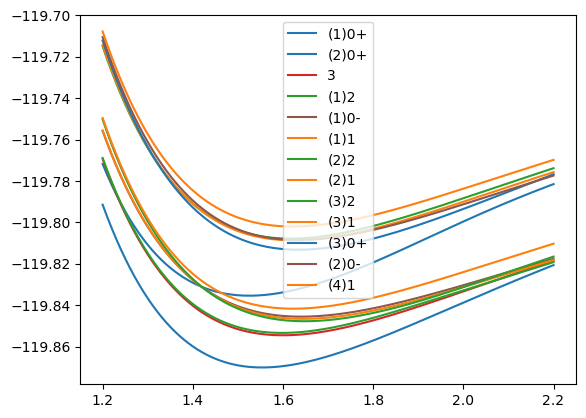

In [13]:
# Plot the PE curves 
plotcols = dftot.columns[1:15]
for col in plotcols:
    # color by Lz value
    lz = re.search(r'\d', col[::-1]).group()
    if '-' in col:
        # 0- different color from 0+
        lz = 5
    plt.plot(dftot.R, dftot[col], f'C{lz}', label=col)
plt.legend()
#plt.xlim([1.45, 1.6])
plt.show()

In [14]:
if False:
    # save data to tab-delimited file
    fdat = fsoc.replace('.pro', '.dat')
    print('Writing data to file', fdat)
    dftot.to_csv(fdat, sep='\t', index=False)